# 根据第四步的参数调优选择最优参数，来训练模型

In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import xgboost as xgb
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn import cross_validation, metrics
from matplotlib import pylab as plt
plot = True
goal = 'Sales'
myid = 'Id'

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/root/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_data():
    store = pd.read_csv('./store.csv')
    train_org = pd.read_csv('./train.csv',dtype={'StateHoliday':pd.np.string_})
    test_org = pd.read_csv('./test.csv',dtype={'StateHoliday':pd.np.string_})
    train = pd.merge(train_org,store,on='Store',how='left')
    test = pd.merge(test_org,store,on='Store',how='left')
    feature = test.columns.tolist()
    numerics = ['int16','int32','int64','float16','float32','float64']
    feature_numeric = test.select_dtypes(include = numerics).columns.tolist()
    feature_non_numeric = [f for f in feature if f not in feature_numeric]
    return (train,test,feature,feature_non_numeric)

In [3]:
def process_data(train,test,features,features_no):
    train = train[train['Open']==1]
    
    test = test[test['Open']==1]
    for rossm in [train,test]:
        rossm['year'] = rossm.Date.apply(lambda x: int(x.split('-')[0]))
        rossm['month']= rossm.Date.apply(lambda x: int(x.split('-')[1]))
        rossm['day']  = rossm.Date.apply(lambda x: int(x.split('-')[2]))

        rossm['promojan'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jan' in x else 0)
        rossm['promofeb'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Feb' in x else 0)
        rossm['promomar'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Mar' in x else 0)
        rossm['promoapr'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Apr' in x else 0)
        rossm['promomay'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'May' in x else 0)
        rossm['promojun'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jun' in x else 0)
        rossm['promojul'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jul' in x else 0)
        rossm['promoaug'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Aug' in x else 0)
        rossm['promosep'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Sep' in x else 0)
        rossm['promooct'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Oct' in x else 0)
        rossm['promonov'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Nov' in x else 0)
        rossm['promodec'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Dec' in x else 0)
    
    day_dummies = pd.get_dummies(train['DayOfWeek'],prefix='Day')
    day_dummies.drop(['Day_7'],axis=1,inplace=True)  #删除周日的数据
    train = train.join(day_dummies)

    
    day_dummies_test = pd.get_dummies(test['DayOfWeek'],prefix='Day')
    day_dummies_test.drop(['Day_7'],axis=1,inplace=True)  #删除周日数据
    test = test.join(day_dummies_test)
    
    noisy_features = [myid,'Date','Store']
    features = [c for c in features if c not in noisy_features]
    features_non_numeric = [c for c in features_no if c not in noisy_features]
    features.extend(['year','month','day'])
    class DataFrameInputer(TransformerMixin):
        def __init__(self):
                """
                """
        def fit(self,X,y=None):
            self.fill = pd.Series([X[c].value_counts().index[0] 
                                  if X[c].dtype==np.dtype('O') 
                                   else X[c].mean() for c in X],index = X.columns)
            return self
        def transform(self,X,y=None):
            return X.fillna(self.fill)
        
    train = DataFrameInputer().fit_transform(train)
    test  = DataFrameInputer().fit_transform(test)
        
    le = LabelEncoder()
    for col in features:
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
    scaler = StandardScaler()
    for col in set(features) - set(features_no) - set([]):
        try:
            scaler.fit(list(train[col])+list(test[col]))
        except:
            print(col)
        train[col] = scaler.transform(train[col])
        test[col] = scaler.transform(test[col])
    return (train,test,features,features_no)    
       
    

In [4]:
train,test,features,features_non_numeric = get_data()

train,test,features,features_non_numeric = process_data(train,test,features,features_non_numeric)
a1 = train.columns
a2 = ['Date','Sales','Customers','DayOfWeek']
a1 = [f for f in a1 if f not in a2]
# XGB_native(train,test,a1,features_non_numeric)
rossm_train = dict(list(train.groupby('Store')))
rossm_test = dict(list(test.groupby('Store')))

##  定义损失函数

In [5]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)

    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### 下面部分参考（http://blog.csdn.net/q383700092/article/details/53763328)  进行建模

In [6]:
features = a1
depth = 9
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta,
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
if not os.path.exists('result/'):
    os.makedirs('result/')
submission.to_csv("./result/dat-xgb_d%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)
   

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 9, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	eval-rmspe:0.999863	train-rmspe:0.99983
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmspe:0.999837	train-rmspe:0.999804
[2]	eval-rmspe:0.999809	train-rmspe:0.999776
[3]	eval-rmspe:0.999779	train-rmspe:0

[160]	eval-rmspe:0.798469	train-rmspe:0.799455
[161]	eval-rmspe:0.795218	train-rmspe:0.796223
[162]	eval-rmspe:0.791949	train-rmspe:0.792976
[163]	eval-rmspe:0.788667	train-rmspe:0.789715
[164]	eval-rmspe:0.785364	train-rmspe:0.786435
[165]	eval-rmspe:0.782044	train-rmspe:0.783138
[166]	eval-rmspe:0.778718	train-rmspe:0.779835
[167]	eval-rmspe:0.77538	train-rmspe:0.77652
[168]	eval-rmspe:0.772012	train-rmspe:0.773176
[169]	eval-rmspe:0.768634	train-rmspe:0.76982
[170]	eval-rmspe:0.765249	train-rmspe:0.766459
[171]	eval-rmspe:0.761845	train-rmspe:0.763079
[172]	eval-rmspe:0.758439	train-rmspe:0.759699
[173]	eval-rmspe:0.755012	train-rmspe:0.756295
[174]	eval-rmspe:0.751571	train-rmspe:0.75288
[175]	eval-rmspe:0.748128	train-rmspe:0.749466
[176]	eval-rmspe:0.744673	train-rmspe:0.746035
[177]	eval-rmspe:0.741203	train-rmspe:0.742589
[178]	eval-rmspe:0.73772	train-rmspe:0.739135
[179]	eval-rmspe:0.734236	train-rmspe:0.735679
[180]	eval-rmspe:0.730741	train-rmspe:0.732214
[181]	eval-rmspe:0

[336]	eval-rmspe:0.320404	train-rmspe:0.330271
[337]	eval-rmspe:0.319273	train-rmspe:0.329211
[338]	eval-rmspe:0.318288	train-rmspe:0.328274
[339]	eval-rmspe:0.317272	train-rmspe:0.327333
[340]	eval-rmspe:0.316341	train-rmspe:0.326466
[341]	eval-rmspe:0.315362	train-rmspe:0.325547
[342]	eval-rmspe:0.314302	train-rmspe:0.324602
[343]	eval-rmspe:0.313422	train-rmspe:0.323793
[344]	eval-rmspe:0.312496	train-rmspe:0.322934
[345]	eval-rmspe:0.311582	train-rmspe:0.322085
[346]	eval-rmspe:0.310584	train-rmspe:0.3212
[347]	eval-rmspe:0.309708	train-rmspe:0.320388
[348]	eval-rmspe:0.308866	train-rmspe:0.319624
[349]	eval-rmspe:0.308078	train-rmspe:0.318892
[350]	eval-rmspe:0.307165	train-rmspe:0.31806
[351]	eval-rmspe:0.306364	train-rmspe:0.317321
[352]	eval-rmspe:0.305544	train-rmspe:0.316588
[353]	eval-rmspe:0.304725	train-rmspe:0.315809
[354]	eval-rmspe:0.303987	train-rmspe:0.315123
[355]	eval-rmspe:0.303236	train-rmspe:0.31443
[356]	eval-rmspe:0.302535	train-rmspe:0.313785
[357]	eval-rmspe:

[511]	eval-rmspe:0.268647	train-rmspe:0.285838
[512]	eval-rmspe:0.268612	train-rmspe:0.285812
[513]	eval-rmspe:0.268571	train-rmspe:0.285723
[514]	eval-rmspe:0.268386	train-rmspe:0.285615
[515]	eval-rmspe:0.268257	train-rmspe:0.285499
[516]	eval-rmspe:0.268184	train-rmspe:0.285443
[517]	eval-rmspe:0.267937	train-rmspe:0.285261
[518]	eval-rmspe:0.267978	train-rmspe:0.285272
[519]	eval-rmspe:0.267815	train-rmspe:0.285151
[520]	eval-rmspe:0.267748	train-rmspe:0.285103
[521]	eval-rmspe:0.267382	train-rmspe:0.284793
[522]	eval-rmspe:0.267429	train-rmspe:0.284844
[523]	eval-rmspe:0.267394	train-rmspe:0.284769
[524]	eval-rmspe:0.267439	train-rmspe:0.284817
[525]	eval-rmspe:0.267473	train-rmspe:0.28486
[526]	eval-rmspe:0.267003	train-rmspe:0.284483
[527]	eval-rmspe:0.267048	train-rmspe:0.284538
[528]	eval-rmspe:0.267056	train-rmspe:0.284587
[529]	eval-rmspe:0.267119	train-rmspe:0.284669
[530]	eval-rmspe:0.267161	train-rmspe:0.28471
[531]	eval-rmspe:0.267185	train-rmspe:0.284592
[532]	eval-rmsp

[687]	eval-rmspe:0.251568	train-rmspe:0.271273
[688]	eval-rmspe:0.251543	train-rmspe:0.271233
[689]	eval-rmspe:0.25148	train-rmspe:0.271175
[690]	eval-rmspe:0.251448	train-rmspe:0.271132
[691]	eval-rmspe:0.251386	train-rmspe:0.271099
[692]	eval-rmspe:0.251249	train-rmspe:0.270961
[693]	eval-rmspe:0.251108	train-rmspe:0.270848
[694]	eval-rmspe:0.251024	train-rmspe:0.270784
[695]	eval-rmspe:0.250952	train-rmspe:0.27069
[696]	eval-rmspe:0.25089	train-rmspe:0.270625
[697]	eval-rmspe:0.250806	train-rmspe:0.270561
[698]	eval-rmspe:0.250749	train-rmspe:0.270515
[699]	eval-rmspe:0.250651	train-rmspe:0.270446
[700]	eval-rmspe:0.250568	train-rmspe:0.270383
[701]	eval-rmspe:0.250521	train-rmspe:0.270333
[702]	eval-rmspe:0.250431	train-rmspe:0.270256
[703]	eval-rmspe:0.250235	train-rmspe:0.270103
[704]	eval-rmspe:0.250058	train-rmspe:0.269984
[705]	eval-rmspe:0.249897	train-rmspe:0.269881
[706]	eval-rmspe:0.249826	train-rmspe:0.269816
[707]	eval-rmspe:0.249766	train-rmspe:0.269753
[708]	eval-rmspe

[862]	eval-rmspe:0.2337	train-rmspe:0.253834
[863]	eval-rmspe:0.233682	train-rmspe:0.253809
[864]	eval-rmspe:0.233509	train-rmspe:0.253663
[865]	eval-rmspe:0.233432	train-rmspe:0.25359
[866]	eval-rmspe:0.233133	train-rmspe:0.253326
[867]	eval-rmspe:0.232992	train-rmspe:0.2532
[868]	eval-rmspe:0.232893	train-rmspe:0.253114
[869]	eval-rmspe:0.2327	train-rmspe:0.252981
[870]	eval-rmspe:0.232682	train-rmspe:0.252976
[871]	eval-rmspe:0.232571	train-rmspe:0.252875
[872]	eval-rmspe:0.232541	train-rmspe:0.25284
[873]	eval-rmspe:0.232528	train-rmspe:0.25284
[874]	eval-rmspe:0.232285	train-rmspe:0.252632
[875]	eval-rmspe:0.232203	train-rmspe:0.252541
[876]	eval-rmspe:0.232191	train-rmspe:0.252542
[877]	eval-rmspe:0.232173	train-rmspe:0.252514
[878]	eval-rmspe:0.232046	train-rmspe:0.252398
[879]	eval-rmspe:0.232028	train-rmspe:0.252396
[880]	eval-rmspe:0.232019	train-rmspe:0.2524
[881]	eval-rmspe:0.231945	train-rmspe:0.252332
[882]	eval-rmspe:0.231918	train-rmspe:0.252304
[883]	eval-rmspe:0.23180

[1037]	eval-rmspe:0.216908	train-rmspe:0.238708
[1038]	eval-rmspe:0.216825	train-rmspe:0.238637
[1039]	eval-rmspe:0.216659	train-rmspe:0.238488
[1040]	eval-rmspe:0.216548	train-rmspe:0.238402
[1041]	eval-rmspe:0.216276	train-rmspe:0.238123
[1042]	eval-rmspe:0.216154	train-rmspe:0.23803
[1043]	eval-rmspe:0.216118	train-rmspe:0.237833
[1044]	eval-rmspe:0.215907	train-rmspe:0.237584
[1045]	eval-rmspe:0.215688	train-rmspe:0.237401
[1046]	eval-rmspe:0.215603	train-rmspe:0.237332
[1047]	eval-rmspe:0.215562	train-rmspe:0.237276
[1048]	eval-rmspe:0.215505	train-rmspe:0.237229
[1049]	eval-rmspe:0.215407	train-rmspe:0.23715
[1050]	eval-rmspe:0.21539	train-rmspe:0.237124
[1051]	eval-rmspe:0.21525	train-rmspe:0.237024
[1052]	eval-rmspe:0.215179	train-rmspe:0.236975
[1053]	eval-rmspe:0.215112	train-rmspe:0.236943
[1054]	eval-rmspe:0.215006	train-rmspe:0.236864
[1055]	eval-rmspe:0.21497	train-rmspe:0.236627
[1056]	eval-rmspe:0.214935	train-rmspe:0.236597
[1057]	eval-rmspe:0.214873	train-rmspe:0.2365

[1209]	eval-rmspe:0.203864	train-rmspe:0.225874
[1210]	eval-rmspe:0.203826	train-rmspe:0.225838
[1211]	eval-rmspe:0.203755	train-rmspe:0.225775
[1212]	eval-rmspe:0.203731	train-rmspe:0.225739
[1213]	eval-rmspe:0.20369	train-rmspe:0.225701
[1214]	eval-rmspe:0.203616	train-rmspe:0.225635
[1215]	eval-rmspe:0.20359	train-rmspe:0.225606
[1216]	eval-rmspe:0.203537	train-rmspe:0.22555
[1217]	eval-rmspe:0.203361	train-rmspe:0.225372
[1218]	eval-rmspe:0.203311	train-rmspe:0.225321
[1219]	eval-rmspe:0.203281	train-rmspe:0.22529
[1220]	eval-rmspe:0.203148	train-rmspe:0.225185
[1221]	eval-rmspe:0.202994	train-rmspe:0.225082
[1222]	eval-rmspe:0.202881	train-rmspe:0.224995
[1223]	eval-rmspe:0.202828	train-rmspe:0.224947
[1224]	eval-rmspe:0.202798	train-rmspe:0.224926
[1225]	eval-rmspe:0.202747	train-rmspe:0.224886
[1226]	eval-rmspe:0.202697	train-rmspe:0.224823
[1227]	eval-rmspe:0.202657	train-rmspe:0.224794
[1228]	eval-rmspe:0.202559	train-rmspe:0.224688
[1229]	eval-rmspe:0.202498	train-rmspe:0.224

[1381]	eval-rmspe:0.193215	train-rmspe:0.215878
[1382]	eval-rmspe:0.193173	train-rmspe:0.215828
[1383]	eval-rmspe:0.193125	train-rmspe:0.215765
[1384]	eval-rmspe:0.193076	train-rmspe:0.215727
[1385]	eval-rmspe:0.192989	train-rmspe:0.215644
[1386]	eval-rmspe:0.192936	train-rmspe:0.215602
[1387]	eval-rmspe:0.192887	train-rmspe:0.215548
[1388]	eval-rmspe:0.192852	train-rmspe:0.215375
[1389]	eval-rmspe:0.192755	train-rmspe:0.215292
[1390]	eval-rmspe:0.1927	train-rmspe:0.215236
[1391]	eval-rmspe:0.192694	train-rmspe:0.215068
[1392]	eval-rmspe:0.192641	train-rmspe:0.215026
[1393]	eval-rmspe:0.192568	train-rmspe:0.214969
[1394]	eval-rmspe:0.192559	train-rmspe:0.214904
[1395]	eval-rmspe:0.192522	train-rmspe:0.214872
[1396]	eval-rmspe:0.192445	train-rmspe:0.214795
[1397]	eval-rmspe:0.192407	train-rmspe:0.214751
[1398]	eval-rmspe:0.192368	train-rmspe:0.214732
[1399]	eval-rmspe:0.192295	train-rmspe:0.214678
[1400]	eval-rmspe:0.192267	train-rmspe:0.214648
[1401]	eval-rmspe:0.192198	train-rmspe:0.2

[1553]	eval-rmspe:0.184582	train-rmspe:0.206869
[1554]	eval-rmspe:0.184518	train-rmspe:0.206812
[1555]	eval-rmspe:0.184494	train-rmspe:0.20678
[1556]	eval-rmspe:0.184468	train-rmspe:0.206754
[1557]	eval-rmspe:0.184447	train-rmspe:0.206738
[1558]	eval-rmspe:0.184386	train-rmspe:0.20669
[1559]	eval-rmspe:0.18436	train-rmspe:0.206666
[1560]	eval-rmspe:0.184328	train-rmspe:0.206632
[1561]	eval-rmspe:0.184301	train-rmspe:0.206594
[1562]	eval-rmspe:0.184199	train-rmspe:0.206511
[1563]	eval-rmspe:0.184176	train-rmspe:0.206477
[1564]	eval-rmspe:0.18412	train-rmspe:0.20645
[1565]	eval-rmspe:0.184087	train-rmspe:0.206435
[1566]	eval-rmspe:0.184042	train-rmspe:0.206399
[1567]	eval-rmspe:0.183989	train-rmspe:0.206351
[1568]	eval-rmspe:0.183962	train-rmspe:0.206312
[1569]	eval-rmspe:0.183928	train-rmspe:0.206265
[1570]	eval-rmspe:0.183891	train-rmspe:0.206231
[1571]	eval-rmspe:0.183841	train-rmspe:0.206193
[1572]	eval-rmspe:0.183787	train-rmspe:0.206145
[1573]	eval-rmspe:0.183748	train-rmspe:0.2061

[1725]	eval-rmspe:0.176678	train-rmspe:0.200118
[1726]	eval-rmspe:0.176644	train-rmspe:0.200104
[1727]	eval-rmspe:0.176609	train-rmspe:0.200068
[1728]	eval-rmspe:0.176583	train-rmspe:0.200047
[1729]	eval-rmspe:0.17656	train-rmspe:0.200013
[1730]	eval-rmspe:0.176529	train-rmspe:0.199988
[1731]	eval-rmspe:0.176507	train-rmspe:0.199953
[1732]	eval-rmspe:0.176474	train-rmspe:0.19992
[1733]	eval-rmspe:0.176156	train-rmspe:0.199832
[1734]	eval-rmspe:0.176129	train-rmspe:0.199806
[1735]	eval-rmspe:0.176088	train-rmspe:0.199771
[1736]	eval-rmspe:0.176055	train-rmspe:0.19974
[1737]	eval-rmspe:0.175983	train-rmspe:0.19963
[1738]	eval-rmspe:0.175945	train-rmspe:0.199602
[1739]	eval-rmspe:0.175927	train-rmspe:0.199585
[1740]	eval-rmspe:0.17583	train-rmspe:0.199516
[1741]	eval-rmspe:0.175784	train-rmspe:0.199472
[1742]	eval-rmspe:0.175694	train-rmspe:0.199416
[1743]	eval-rmspe:0.175676	train-rmspe:0.199386
[1744]	eval-rmspe:0.175642	train-rmspe:0.199351
[1745]	eval-rmspe:0.175589	train-rmspe:0.1993

[1897]	eval-rmspe:0.169991	train-rmspe:0.193751
[1898]	eval-rmspe:0.169984	train-rmspe:0.19374
[1899]	eval-rmspe:0.169963	train-rmspe:0.193712
[1900]	eval-rmspe:0.16991	train-rmspe:0.19366
[1901]	eval-rmspe:0.169884	train-rmspe:0.193637
[1902]	eval-rmspe:0.169874	train-rmspe:0.193622
[1903]	eval-rmspe:0.169848	train-rmspe:0.193596
[1904]	eval-rmspe:0.169823	train-rmspe:0.193574
[1905]	eval-rmspe:0.169812	train-rmspe:0.193551
[1906]	eval-rmspe:0.169787	train-rmspe:0.193529
[1907]	eval-rmspe:0.169771	train-rmspe:0.193516
[1908]	eval-rmspe:0.16973	train-rmspe:0.193479
[1909]	eval-rmspe:0.169718	train-rmspe:0.193469
[1910]	eval-rmspe:0.169687	train-rmspe:0.193447
[1911]	eval-rmspe:0.169668	train-rmspe:0.193431
[1912]	eval-rmspe:0.169623	train-rmspe:0.193366
[1913]	eval-rmspe:0.16955	train-rmspe:0.193295
[1914]	eval-rmspe:0.169521	train-rmspe:0.193245
[1915]	eval-rmspe:0.169488	train-rmspe:0.193213
[1916]	eval-rmspe:0.169468	train-rmspe:0.193193
[1917]	eval-rmspe:0.169451	train-rmspe:0.1931

[2069]	eval-rmspe:0.164237	train-rmspe:0.188782
[2070]	eval-rmspe:0.164213	train-rmspe:0.18871
[2071]	eval-rmspe:0.164198	train-rmspe:0.188688
[2072]	eval-rmspe:0.164192	train-rmspe:0.188689
[2073]	eval-rmspe:0.164178	train-rmspe:0.188674
[2074]	eval-rmspe:0.164164	train-rmspe:0.188654
[2075]	eval-rmspe:0.163743	train-rmspe:0.188596
[2076]	eval-rmspe:0.163731	train-rmspe:0.188583
[2077]	eval-rmspe:0.163711	train-rmspe:0.188561
[2078]	eval-rmspe:0.163694	train-rmspe:0.188545
[2079]	eval-rmspe:0.163677	train-rmspe:0.188531
[2080]	eval-rmspe:0.163649	train-rmspe:0.188491
[2081]	eval-rmspe:0.16362	train-rmspe:0.18847
[2082]	eval-rmspe:0.163615	train-rmspe:0.188465
[2083]	eval-rmspe:0.163567	train-rmspe:0.188411
[2084]	eval-rmspe:0.163552	train-rmspe:0.188389
[2085]	eval-rmspe:0.163524	train-rmspe:0.18834
[2086]	eval-rmspe:0.163507	train-rmspe:0.18833
[2087]	eval-rmspe:0.163479	train-rmspe:0.188305
[2088]	eval-rmspe:0.163449	train-rmspe:0.188276
[2089]	eval-rmspe:0.163427	train-rmspe:0.1882

[2241]	eval-rmspe:0.159719	train-rmspe:0.184534
[2242]	eval-rmspe:0.159702	train-rmspe:0.184518
[2243]	eval-rmspe:0.159428	train-rmspe:0.184485
[2244]	eval-rmspe:0.159402	train-rmspe:0.184454
[2245]	eval-rmspe:0.159388	train-rmspe:0.18444
[2246]	eval-rmspe:0.15937	train-rmspe:0.184412
[2247]	eval-rmspe:0.159354	train-rmspe:0.184401
[2248]	eval-rmspe:0.159327	train-rmspe:0.184377
[2249]	eval-rmspe:0.159297	train-rmspe:0.184357
[2250]	eval-rmspe:0.159281	train-rmspe:0.184331
[2251]	eval-rmspe:0.159258	train-rmspe:0.184306
[2252]	eval-rmspe:0.159184	train-rmspe:0.184305
[2253]	eval-rmspe:0.159159	train-rmspe:0.184286
[2254]	eval-rmspe:0.159139	train-rmspe:0.184274
[2255]	eval-rmspe:0.159129	train-rmspe:0.18417
[2256]	eval-rmspe:0.159113	train-rmspe:0.184157
[2257]	eval-rmspe:0.159097	train-rmspe:0.184173
[2258]	eval-rmspe:0.159084	train-rmspe:0.18416
[2259]	eval-rmspe:0.15906	train-rmspe:0.184134
[2260]	eval-rmspe:0.159039	train-rmspe:0.1841
[2261]	eval-rmspe:0.15901	train-rmspe:0.18408
[

[2413]	eval-rmspe:0.154972	train-rmspe:0.180446
[2414]	eval-rmspe:0.154953	train-rmspe:0.180429
[2415]	eval-rmspe:0.154937	train-rmspe:0.180424
[2416]	eval-rmspe:0.154898	train-rmspe:0.1804
[2417]	eval-rmspe:0.154877	train-rmspe:0.180413
[2418]	eval-rmspe:0.154868	train-rmspe:0.180331
[2419]	eval-rmspe:0.154843	train-rmspe:0.180319
[2420]	eval-rmspe:0.154816	train-rmspe:0.180268
[2421]	eval-rmspe:0.154807	train-rmspe:0.180259
[2422]	eval-rmspe:0.154794	train-rmspe:0.180248
[2423]	eval-rmspe:0.154783	train-rmspe:0.180227
[2424]	eval-rmspe:0.154768	train-rmspe:0.180213
[2425]	eval-rmspe:0.154732	train-rmspe:0.180188
[2426]	eval-rmspe:0.154711	train-rmspe:0.180174
[2427]	eval-rmspe:0.154641	train-rmspe:0.180115
[2428]	eval-rmspe:0.154618	train-rmspe:0.180096
[2429]	eval-rmspe:0.154597	train-rmspe:0.180068
[2430]	eval-rmspe:0.154584	train-rmspe:0.180054
[2431]	eval-rmspe:0.154575	train-rmspe:0.180046
[2432]	eval-rmspe:0.15456	train-rmspe:0.179958
[2433]	eval-rmspe:0.154541	train-rmspe:0.17

[2585]	eval-rmspe:0.15115	train-rmspe:0.176508
[2586]	eval-rmspe:0.151126	train-rmspe:0.176493
[2587]	eval-rmspe:0.151111	train-rmspe:0.176473
[2588]	eval-rmspe:0.151111	train-rmspe:0.176467
[2589]	eval-rmspe:0.151088	train-rmspe:0.17645
[2590]	eval-rmspe:0.151074	train-rmspe:0.176439
[2591]	eval-rmspe:0.151061	train-rmspe:0.176422
[2592]	eval-rmspe:0.151032	train-rmspe:0.176397
[2593]	eval-rmspe:0.151015	train-rmspe:0.176381
[2594]	eval-rmspe:0.150991	train-rmspe:0.176362
[2595]	eval-rmspe:0.150972	train-rmspe:0.176349
[2596]	eval-rmspe:0.150954	train-rmspe:0.176284
[2597]	eval-rmspe:0.150942	train-rmspe:0.176297
[2598]	eval-rmspe:0.150904	train-rmspe:0.176266
[2599]	eval-rmspe:0.150894	train-rmspe:0.176249
[2600]	eval-rmspe:0.150891	train-rmspe:0.176248
[2601]	eval-rmspe:0.150878	train-rmspe:0.176234
[2602]	eval-rmspe:0.150871	train-rmspe:0.17623
[2603]	eval-rmspe:0.150853	train-rmspe:0.17622
[2604]	eval-rmspe:0.150834	train-rmspe:0.176244
[2605]	eval-rmspe:0.150819	train-rmspe:0.176

[2757]	eval-rmspe:0.147627	train-rmspe:0.173275
[2758]	eval-rmspe:0.147613	train-rmspe:0.173262
[2759]	eval-rmspe:0.14759	train-rmspe:0.173248
[2760]	eval-rmspe:0.147571	train-rmspe:0.173273
[2761]	eval-rmspe:0.147564	train-rmspe:0.173266
[2762]	eval-rmspe:0.147551	train-rmspe:0.173256
[2763]	eval-rmspe:0.147526	train-rmspe:0.173238
[2764]	eval-rmspe:0.147517	train-rmspe:0.173228
[2765]	eval-rmspe:0.147504	train-rmspe:0.173221
[2766]	eval-rmspe:0.147462	train-rmspe:0.1732
[2767]	eval-rmspe:0.147406	train-rmspe:0.173211
[2768]	eval-rmspe:0.147401	train-rmspe:0.173206
[2769]	eval-rmspe:0.147377	train-rmspe:0.173178
[2770]	eval-rmspe:0.147373	train-rmspe:0.173053
[2771]	eval-rmspe:0.147352	train-rmspe:0.173035
[2772]	eval-rmspe:0.147337	train-rmspe:0.173023
[2773]	eval-rmspe:0.147329	train-rmspe:0.173017
[2774]	eval-rmspe:0.147315	train-rmspe:0.173007
[2775]	eval-rmspe:0.147228	train-rmspe:0.173036
[2776]	eval-rmspe:0.14722	train-rmspe:0.173029
[2777]	eval-rmspe:0.14721	train-rmspe:0.1730

[2929]	eval-rmspe:0.143524	train-rmspe:0.170442
[2930]	eval-rmspe:0.143507	train-rmspe:0.170431
[2931]	eval-rmspe:0.143494	train-rmspe:0.170413
[2932]	eval-rmspe:0.143491	train-rmspe:0.170408
[2933]	eval-rmspe:0.143478	train-rmspe:0.170403
[2934]	eval-rmspe:0.14346	train-rmspe:0.170388
[2935]	eval-rmspe:0.143442	train-rmspe:0.170364
[2936]	eval-rmspe:0.143439	train-rmspe:0.170363
[2937]	eval-rmspe:0.143426	train-rmspe:0.170355
[2938]	eval-rmspe:0.143412	train-rmspe:0.1703
[2939]	eval-rmspe:0.143405	train-rmspe:0.170294
[2940]	eval-rmspe:0.143399	train-rmspe:0.170289
[2941]	eval-rmspe:0.143387	train-rmspe:0.170283
[2942]	eval-rmspe:0.143375	train-rmspe:0.170273
[2943]	eval-rmspe:0.143369	train-rmspe:0.169968
[2944]	eval-rmspe:0.143363	train-rmspe:0.169958
[2945]	eval-rmspe:0.143339	train-rmspe:0.169967
[2946]	eval-rmspe:0.143329	train-rmspe:0.169958
[2947]	eval-rmspe:0.143294	train-rmspe:0.169927
[2948]	eval-rmspe:0.143278	train-rmspe:0.169918
[2949]	eval-rmspe:0.143264	train-rmspe:0.16

[3101]	eval-rmspe:0.14006	train-rmspe:0.167004
[3102]	eval-rmspe:0.140031	train-rmspe:0.166978
[3103]	eval-rmspe:0.140019	train-rmspe:0.16696
[3104]	eval-rmspe:0.140017	train-rmspe:0.166956
[3105]	eval-rmspe:0.140005	train-rmspe:0.166943
[3106]	eval-rmspe:0.139998	train-rmspe:0.166934
[3107]	eval-rmspe:0.139986	train-rmspe:0.166923
[3108]	eval-rmspe:0.139977	train-rmspe:0.166917
[3109]	eval-rmspe:0.139975	train-rmspe:0.16691
[3110]	eval-rmspe:0.139962	train-rmspe:0.166896
[3111]	eval-rmspe:0.139933	train-rmspe:0.166878
[3112]	eval-rmspe:0.139872	train-rmspe:0.166859
[3113]	eval-rmspe:0.139836	train-rmspe:0.166886
[3114]	eval-rmspe:0.139643	train-rmspe:0.166834
[3115]	eval-rmspe:0.139636	train-rmspe:0.166829
[3116]	eval-rmspe:0.139521	train-rmspe:0.166731
[3117]	eval-rmspe:0.139509	train-rmspe:0.166716
[3118]	eval-rmspe:0.139458	train-rmspe:0.166742
[3119]	eval-rmspe:0.13945	train-rmspe:0.166718
[3120]	eval-rmspe:0.139438	train-rmspe:0.166707
[3121]	eval-rmspe:0.139435	train-rmspe:0.166

[3273]	eval-rmspe:0.13728	train-rmspe:0.164541
[3274]	eval-rmspe:0.137276	train-rmspe:0.164536
[3275]	eval-rmspe:0.137265	train-rmspe:0.164523
[3276]	eval-rmspe:0.137255	train-rmspe:0.164513
[3277]	eval-rmspe:0.137138	train-rmspe:0.164489
[3278]	eval-rmspe:0.137131	train-rmspe:0.164476
[3279]	eval-rmspe:0.137124	train-rmspe:0.164462
[3280]	eval-rmspe:0.137113	train-rmspe:0.164453
[3281]	eval-rmspe:0.137107	train-rmspe:0.164447
[3282]	eval-rmspe:0.137104	train-rmspe:0.164444
[3283]	eval-rmspe:0.137105	train-rmspe:0.164446
[3284]	eval-rmspe:0.137078	train-rmspe:0.164394
[3285]	eval-rmspe:0.137051	train-rmspe:0.164381
[3286]	eval-rmspe:0.136989	train-rmspe:0.164397
[3287]	eval-rmspe:0.136962	train-rmspe:0.16437
[3288]	eval-rmspe:0.136955	train-rmspe:0.16436
[3289]	eval-rmspe:0.136952	train-rmspe:0.164359
[3290]	eval-rmspe:0.136949	train-rmspe:0.164352
[3291]	eval-rmspe:0.136944	train-rmspe:0.164346
[3292]	eval-rmspe:0.136939	train-rmspe:0.164337
[3293]	eval-rmspe:0.136921	train-rmspe:0.16

[3445]	eval-rmspe:0.134666	train-rmspe:0.161834
[3446]	eval-rmspe:0.134553	train-rmspe:0.161808
[3447]	eval-rmspe:0.13455	train-rmspe:0.161726
[3448]	eval-rmspe:0.134543	train-rmspe:0.161718
[3449]	eval-rmspe:0.134539	train-rmspe:0.161719
[3450]	eval-rmspe:0.134537	train-rmspe:0.161697
[3451]	eval-rmspe:0.134533	train-rmspe:0.161693
[3452]	eval-rmspe:0.134435	train-rmspe:0.161466
[3453]	eval-rmspe:0.134433	train-rmspe:0.161463
[3454]	eval-rmspe:0.134422	train-rmspe:0.161454
[3455]	eval-rmspe:0.134417	train-rmspe:0.16145
[3456]	eval-rmspe:0.134409	train-rmspe:0.161445
[3457]	eval-rmspe:0.134401	train-rmspe:0.161435
[3458]	eval-rmspe:0.134396	train-rmspe:0.161384
[3459]	eval-rmspe:0.134388	train-rmspe:0.161379
[3460]	eval-rmspe:0.134344	train-rmspe:0.16137
[3461]	eval-rmspe:0.134338	train-rmspe:0.161364
[3462]	eval-rmspe:0.134328	train-rmspe:0.16135
[3463]	eval-rmspe:0.134315	train-rmspe:0.161344
[3464]	eval-rmspe:0.134304	train-rmspe:0.161325
[3465]	eval-rmspe:0.134298	train-rmspe:0.161

[3617]	eval-rmspe:0.132449	train-rmspe:0.159816
[3618]	eval-rmspe:0.132444	train-rmspe:0.159809
[3619]	eval-rmspe:0.132441	train-rmspe:0.159762
[3620]	eval-rmspe:0.132433	train-rmspe:0.159756
[3621]	eval-rmspe:0.13243	train-rmspe:0.159754
[3622]	eval-rmspe:0.132427	train-rmspe:0.159754
[3623]	eval-rmspe:0.132421	train-rmspe:0.159748
[3624]	eval-rmspe:0.132418	train-rmspe:0.159744
[3625]	eval-rmspe:0.132409	train-rmspe:0.159745
[3626]	eval-rmspe:0.13238	train-rmspe:0.159735
[3627]	eval-rmspe:0.132377	train-rmspe:0.159732
[3628]	eval-rmspe:0.132373	train-rmspe:0.15972
[3629]	eval-rmspe:0.132362	train-rmspe:0.159713
[3630]	eval-rmspe:0.132357	train-rmspe:0.159707
[3631]	eval-rmspe:0.132353	train-rmspe:0.159703
[3632]	eval-rmspe:0.132346	train-rmspe:0.159699
[3633]	eval-rmspe:0.132336	train-rmspe:0.159686
[3634]	eval-rmspe:0.132325	train-rmspe:0.159678
[3635]	eval-rmspe:0.132318	train-rmspe:0.159663
[3636]	eval-rmspe:0.13231	train-rmspe:0.159663
[3637]	eval-rmspe:0.132292	train-rmspe:0.159

[3789]	eval-rmspe:0.130047	train-rmspe:0.156078
[3790]	eval-rmspe:0.13004	train-rmspe:0.156072
[3791]	eval-rmspe:0.130035	train-rmspe:0.156064
[3792]	eval-rmspe:0.130015	train-rmspe:0.156052
[3793]	eval-rmspe:0.130015	train-rmspe:0.156048
[3794]	eval-rmspe:0.130005	train-rmspe:0.15604
[3795]	eval-rmspe:0.129996	train-rmspe:0.156027
[3796]	eval-rmspe:0.129992	train-rmspe:0.156014
[3797]	eval-rmspe:0.129968	train-rmspe:0.156003
[3798]	eval-rmspe:0.12996	train-rmspe:0.155994
[3799]	eval-rmspe:0.12996	train-rmspe:0.155991
[3800]	eval-rmspe:0.129956	train-rmspe:0.155982
[3801]	eval-rmspe:0.129951	train-rmspe:0.155977
[3802]	eval-rmspe:0.129938	train-rmspe:0.155963
[3803]	eval-rmspe:0.129916	train-rmspe:0.155944
[3804]	eval-rmspe:0.12991	train-rmspe:0.155937
[3805]	eval-rmspe:0.129909	train-rmspe:0.155933
[3806]	eval-rmspe:0.1299	train-rmspe:0.155927
[3807]	eval-rmspe:0.129895	train-rmspe:0.155917
[3808]	eval-rmspe:0.129883	train-rmspe:0.155907
[3809]	eval-rmspe:0.129879	train-rmspe:0.155901

[3961]	eval-rmspe:0.127968	train-rmspe:0.15414
[3962]	eval-rmspe:0.127939	train-rmspe:0.154135
[3963]	eval-rmspe:0.127928	train-rmspe:0.154127
[3964]	eval-rmspe:0.127924	train-rmspe:0.154122
[3965]	eval-rmspe:0.127921	train-rmspe:0.15412
[3966]	eval-rmspe:0.12792	train-rmspe:0.154118
[3967]	eval-rmspe:0.127919	train-rmspe:0.154116
[3968]	eval-rmspe:0.127917	train-rmspe:0.154114
[3969]	eval-rmspe:0.127913	train-rmspe:0.154096
[3970]	eval-rmspe:0.127907	train-rmspe:0.154088
[3971]	eval-rmspe:0.127899	train-rmspe:0.154136
[3972]	eval-rmspe:0.127888	train-rmspe:0.154122
[3973]	eval-rmspe:0.127847	train-rmspe:0.154118
[3974]	eval-rmspe:0.127838	train-rmspe:0.154074
[3975]	eval-rmspe:0.127829	train-rmspe:0.154067
[3976]	eval-rmspe:0.127822	train-rmspe:0.154057
[3977]	eval-rmspe:0.127818	train-rmspe:0.154049
[3978]	eval-rmspe:0.127805	train-rmspe:0.154044
[3979]	eval-rmspe:0.127799	train-rmspe:0.154039
[3980]	eval-rmspe:0.127797	train-rmspe:0.154028
[3981]	eval-rmspe:0.127792	train-rmspe:0.15

[4133]	eval-rmspe:0.126283	train-rmspe:0.152969
[4134]	eval-rmspe:0.126281	train-rmspe:0.152964
[4135]	eval-rmspe:0.126271	train-rmspe:0.152956
[4136]	eval-rmspe:0.126268	train-rmspe:0.152951
[4137]	eval-rmspe:0.126263	train-rmspe:0.152947
[4138]	eval-rmspe:0.126254	train-rmspe:0.152934
[4139]	eval-rmspe:0.126247	train-rmspe:0.152931
[4140]	eval-rmspe:0.126238	train-rmspe:0.152923
[4141]	eval-rmspe:0.126211	train-rmspe:0.152963
[4142]	eval-rmspe:0.126207	train-rmspe:0.15296
[4143]	eval-rmspe:0.126187	train-rmspe:0.152949
[4144]	eval-rmspe:0.126182	train-rmspe:0.152931
[4145]	eval-rmspe:0.126177	train-rmspe:0.152927
[4146]	eval-rmspe:0.126171	train-rmspe:0.152921
[4147]	eval-rmspe:0.126169	train-rmspe:0.152919
[4148]	eval-rmspe:0.126167	train-rmspe:0.152914
[4149]	eval-rmspe:0.126162	train-rmspe:0.152909
[4150]	eval-rmspe:0.126159	train-rmspe:0.152907
[4151]	eval-rmspe:0.126153	train-rmspe:0.152903
[4152]	eval-rmspe:0.126136	train-rmspe:0.152898
[4153]	eval-rmspe:0.126134	train-rmspe:0.

[4305]	eval-rmspe:0.124745	train-rmspe:0.150878
[4306]	eval-rmspe:0.124741	train-rmspe:0.150867
[4307]	eval-rmspe:0.124737	train-rmspe:0.150859
[4308]	eval-rmspe:0.124734	train-rmspe:0.150836
[4309]	eval-rmspe:0.124731	train-rmspe:0.15083
[4310]	eval-rmspe:0.124725	train-rmspe:0.150822
[4311]	eval-rmspe:0.124675	train-rmspe:0.150805
[4312]	eval-rmspe:0.124672	train-rmspe:0.150796
[4313]	eval-rmspe:0.124667	train-rmspe:0.150792
[4314]	eval-rmspe:0.124656	train-rmspe:0.150783
[4315]	eval-rmspe:0.124648	train-rmspe:0.150774
[4316]	eval-rmspe:0.124638	train-rmspe:0.150763
[4317]	eval-rmspe:0.124635	train-rmspe:0.150759
[4318]	eval-rmspe:0.124629	train-rmspe:0.150754
[4319]	eval-rmspe:0.124627	train-rmspe:0.150751
[4320]	eval-rmspe:0.124621	train-rmspe:0.150736
[4321]	eval-rmspe:0.124612	train-rmspe:0.150726
[4322]	eval-rmspe:0.124606	train-rmspe:0.150723
[4323]	eval-rmspe:0.124602	train-rmspe:0.150719
[4324]	eval-rmspe:0.1246	train-rmspe:0.150716
[4325]	eval-rmspe:0.124596	train-rmspe:0.15

[4477]	eval-rmspe:0.123332	train-rmspe:0.148982
[4478]	eval-rmspe:0.123327	train-rmspe:0.148977
[4479]	eval-rmspe:0.123305	train-rmspe:0.148964
[4480]	eval-rmspe:0.123303	train-rmspe:0.148934
[4481]	eval-rmspe:0.123293	train-rmspe:0.148925
[4482]	eval-rmspe:0.123289	train-rmspe:0.148919
[4483]	eval-rmspe:0.123285	train-rmspe:0.148915
[4484]	eval-rmspe:0.123274	train-rmspe:0.148903
[4485]	eval-rmspe:0.123269	train-rmspe:0.148898
[4486]	eval-rmspe:0.123266	train-rmspe:0.148895
[4487]	eval-rmspe:0.123263	train-rmspe:0.148891
[4488]	eval-rmspe:0.12326	train-rmspe:0.148879
[4489]	eval-rmspe:0.123255	train-rmspe:0.148859
[4490]	eval-rmspe:0.123253	train-rmspe:0.148857
[4491]	eval-rmspe:0.12325	train-rmspe:0.148854
[4492]	eval-rmspe:0.123238	train-rmspe:0.148841
[4493]	eval-rmspe:0.123234	train-rmspe:0.148837
[4494]	eval-rmspe:0.12323	train-rmspe:0.148831
[4495]	eval-rmspe:0.123223	train-rmspe:0.148823
[4496]	eval-rmspe:0.12322	train-rmspe:0.148819
[4497]	eval-rmspe:0.123198	train-rmspe:0.148

[4649]	eval-rmspe:0.121892	train-rmspe:0.147374
[4650]	eval-rmspe:0.121885	train-rmspe:0.147367
[4651]	eval-rmspe:0.121877	train-rmspe:0.147361
[4652]	eval-rmspe:0.121872	train-rmspe:0.147357
[4653]	eval-rmspe:0.12187	train-rmspe:0.147354
[4654]	eval-rmspe:0.121871	train-rmspe:0.147351
[4655]	eval-rmspe:0.121867	train-rmspe:0.147346
[4656]	eval-rmspe:0.121863	train-rmspe:0.147342
[4657]	eval-rmspe:0.121847	train-rmspe:0.147334
[4658]	eval-rmspe:0.121846	train-rmspe:0.14733
[4659]	eval-rmspe:0.12184	train-rmspe:0.147325
[4660]	eval-rmspe:0.121838	train-rmspe:0.147322
[4661]	eval-rmspe:0.12183	train-rmspe:0.147317
[4662]	eval-rmspe:0.121825	train-rmspe:0.14731
[4663]	eval-rmspe:0.121816	train-rmspe:0.147268
[4664]	eval-rmspe:0.121814	train-rmspe:0.147265
[4665]	eval-rmspe:0.121811	train-rmspe:0.147262
[4666]	eval-rmspe:0.121806	train-rmspe:0.147207
[4667]	eval-rmspe:0.121797	train-rmspe:0.147203
[4668]	eval-rmspe:0.121795	train-rmspe:0.147186
[4669]	eval-rmspe:0.121786	train-rmspe:0.1471

[4821]	eval-rmspe:0.120642	train-rmspe:0.145467
[4822]	eval-rmspe:0.12064	train-rmspe:0.145461
[4823]	eval-rmspe:0.120639	train-rmspe:0.145457
[4824]	eval-rmspe:0.120636	train-rmspe:0.145455
[4825]	eval-rmspe:0.120626	train-rmspe:0.145445
[4826]	eval-rmspe:0.120624	train-rmspe:0.145442
[4827]	eval-rmspe:0.120623	train-rmspe:0.145439
[4828]	eval-rmspe:0.120622	train-rmspe:0.14542
[4829]	eval-rmspe:0.120617	train-rmspe:0.145412
[4830]	eval-rmspe:0.120612	train-rmspe:0.145409
[4831]	eval-rmspe:0.120607	train-rmspe:0.145401
[4832]	eval-rmspe:0.120603	train-rmspe:0.145402
[4833]	eval-rmspe:0.12059	train-rmspe:0.145387
[4834]	eval-rmspe:0.120587	train-rmspe:0.145382
[4835]	eval-rmspe:0.120581	train-rmspe:0.14538
[4836]	eval-rmspe:0.120577	train-rmspe:0.145374
[4837]	eval-rmspe:0.120574	train-rmspe:0.145368
[4838]	eval-rmspe:0.120566	train-rmspe:0.145358
[4839]	eval-rmspe:0.120564	train-rmspe:0.145345
[4840]	eval-rmspe:0.12056	train-rmspe:0.14533
[4841]	eval-rmspe:0.120555	train-rmspe:0.14532

[4993]	eval-rmspe:0.11963	train-rmspe:0.144299
[4994]	eval-rmspe:0.119627	train-rmspe:0.144295
[4995]	eval-rmspe:0.119618	train-rmspe:0.144285
[4996]	eval-rmspe:0.119614	train-rmspe:0.14428
[4997]	eval-rmspe:0.119611	train-rmspe:0.144277
[4998]	eval-rmspe:0.119602	train-rmspe:0.144271
[4999]	eval-rmspe:0.119597	train-rmspe:0.144261
[5000]	eval-rmspe:0.11959	train-rmspe:0.144249
[5001]	eval-rmspe:0.119587	train-rmspe:0.144243
[5002]	eval-rmspe:0.119584	train-rmspe:0.144239
[5003]	eval-rmspe:0.11958	train-rmspe:0.144232
[5004]	eval-rmspe:0.119577	train-rmspe:0.144228
[5005]	eval-rmspe:0.119572	train-rmspe:0.144223
[5006]	eval-rmspe:0.11957	train-rmspe:0.144219
[5007]	eval-rmspe:0.119566	train-rmspe:0.144216
[5008]	eval-rmspe:0.119555	train-rmspe:0.14421
[5009]	eval-rmspe:0.119551	train-rmspe:0.144206
[5010]	eval-rmspe:0.119543	train-rmspe:0.144194
[5011]	eval-rmspe:0.11954	train-rmspe:0.144191
[5012]	eval-rmspe:0.119534	train-rmspe:0.144186
[5013]	eval-rmspe:0.119531	train-rmspe:0.144183

[5165]	eval-rmspe:0.11882	train-rmspe:0.143056
[5166]	eval-rmspe:0.118819	train-rmspe:0.143052
[5167]	eval-rmspe:0.118819	train-rmspe:0.143048
[5168]	eval-rmspe:0.118817	train-rmspe:0.143043
[5169]	eval-rmspe:0.11877	train-rmspe:0.143037
[5170]	eval-rmspe:0.118767	train-rmspe:0.143034
[5171]	eval-rmspe:0.118764	train-rmspe:0.143029
[5172]	eval-rmspe:0.11876	train-rmspe:0.143026
[5173]	eval-rmspe:0.118756	train-rmspe:0.143021
[5174]	eval-rmspe:0.118751	train-rmspe:0.143015
[5175]	eval-rmspe:0.118746	train-rmspe:0.14301
[5176]	eval-rmspe:0.118743	train-rmspe:0.143007
[5177]	eval-rmspe:0.118741	train-rmspe:0.143005
[5178]	eval-rmspe:0.118738	train-rmspe:0.143001
[5179]	eval-rmspe:0.118735	train-rmspe:0.142997
[5180]	eval-rmspe:0.118732	train-rmspe:0.142996
[5181]	eval-rmspe:0.118729	train-rmspe:0.142647
[5182]	eval-rmspe:0.118729	train-rmspe:0.142646
[5183]	eval-rmspe:0.118725	train-rmspe:0.142643
[5184]	eval-rmspe:0.118683	train-rmspe:0.142634
[5185]	eval-rmspe:0.118682	train-rmspe:0.142

[5337]	eval-rmspe:0.117782	train-rmspe:0.140847
[5338]	eval-rmspe:0.11778	train-rmspe:0.140843
[5339]	eval-rmspe:0.117774	train-rmspe:0.140838
[5340]	eval-rmspe:0.117768	train-rmspe:0.140831
[5341]	eval-rmspe:0.117765	train-rmspe:0.14078
[5342]	eval-rmspe:0.11776	train-rmspe:0.140774
[5343]	eval-rmspe:0.117761	train-rmspe:0.140773
[5344]	eval-rmspe:0.117756	train-rmspe:0.140771
[5345]	eval-rmspe:0.117755	train-rmspe:0.140776
[5346]	eval-rmspe:0.117751	train-rmspe:0.140766
[5347]	eval-rmspe:0.11775	train-rmspe:0.140764
[5348]	eval-rmspe:0.117746	train-rmspe:0.140758
[5349]	eval-rmspe:0.117744	train-rmspe:0.140757
[5350]	eval-rmspe:0.117743	train-rmspe:0.140754
[5351]	eval-rmspe:0.117742	train-rmspe:0.140751
[5352]	eval-rmspe:0.117739	train-rmspe:0.140746
[5353]	eval-rmspe:0.117735	train-rmspe:0.140743
[5354]	eval-rmspe:0.117731	train-rmspe:0.140742
[5355]	eval-rmspe:0.117728	train-rmspe:0.140739
[5356]	eval-rmspe:0.117669	train-rmspe:0.140729
[5357]	eval-rmspe:0.117665	train-rmspe:0.140

[5509]	eval-rmspe:0.116982	train-rmspe:0.139261
[5510]	eval-rmspe:0.116981	train-rmspe:0.139258
[5511]	eval-rmspe:0.116976	train-rmspe:0.139243
[5512]	eval-rmspe:0.11697	train-rmspe:0.139235
[5513]	eval-rmspe:0.116953	train-rmspe:0.139233
[5514]	eval-rmspe:0.116951	train-rmspe:0.139229
[5515]	eval-rmspe:0.116949	train-rmspe:0.139224
[5516]	eval-rmspe:0.116946	train-rmspe:0.139221
[5517]	eval-rmspe:0.116945	train-rmspe:0.13922
[5518]	eval-rmspe:0.116942	train-rmspe:0.139214
[5519]	eval-rmspe:0.116939	train-rmspe:0.139211
[5520]	eval-rmspe:0.116934	train-rmspe:0.139206
[5521]	eval-rmspe:0.116933	train-rmspe:0.139201
[5522]	eval-rmspe:0.116927	train-rmspe:0.139184
[5523]	eval-rmspe:0.116923	train-rmspe:0.139159
[5524]	eval-rmspe:0.116921	train-rmspe:0.139157
[5525]	eval-rmspe:0.116917	train-rmspe:0.139153
[5526]	eval-rmspe:0.116915	train-rmspe:0.13915
[5527]	eval-rmspe:0.116913	train-rmspe:0.139147
[5528]	eval-rmspe:0.11691	train-rmspe:0.139143
[5529]	eval-rmspe:0.116905	train-rmspe:0.139

[5681]	eval-rmspe:0.116195	train-rmspe:0.138213
[5682]	eval-rmspe:0.116193	train-rmspe:0.138209
[5683]	eval-rmspe:0.116189	train-rmspe:0.138206
[5684]	eval-rmspe:0.116185	train-rmspe:0.138206
[5685]	eval-rmspe:0.116185	train-rmspe:0.138196
[5686]	eval-rmspe:0.116181	train-rmspe:0.138184
[5687]	eval-rmspe:0.116173	train-rmspe:0.138086
[5688]	eval-rmspe:0.11617	train-rmspe:0.138082
[5689]	eval-rmspe:0.116168	train-rmspe:0.138078
[5690]	eval-rmspe:0.116163	train-rmspe:0.138075
[5691]	eval-rmspe:0.11616	train-rmspe:0.138072
[5692]	eval-rmspe:0.116156	train-rmspe:0.138068
[5693]	eval-rmspe:0.11615	train-rmspe:0.138063
[5694]	eval-rmspe:0.116147	train-rmspe:0.13806
[5695]	eval-rmspe:0.116145	train-rmspe:0.138056
[5696]	eval-rmspe:0.116142	train-rmspe:0.138054
[5697]	eval-rmspe:0.11614	train-rmspe:0.13805
[5698]	eval-rmspe:0.116114	train-rmspe:0.138031
[5699]	eval-rmspe:0.116111	train-rmspe:0.138028
[5700]	eval-rmspe:0.116104	train-rmspe:0.138023
[5701]	eval-rmspe:0.116101	train-rmspe:0.13798

[5853]	eval-rmspe:0.115465	train-rmspe:0.136821
[5854]	eval-rmspe:0.11546	train-rmspe:0.136813
[5855]	eval-rmspe:0.115456	train-rmspe:0.13681
[5856]	eval-rmspe:0.115454	train-rmspe:0.136806
[5857]	eval-rmspe:0.115448	train-rmspe:0.136801
[5858]	eval-rmspe:0.115443	train-rmspe:0.136796
[5859]	eval-rmspe:0.115441	train-rmspe:0.136792
[5860]	eval-rmspe:0.115437	train-rmspe:0.136728
[5861]	eval-rmspe:0.115434	train-rmspe:0.136727
[5862]	eval-rmspe:0.115432	train-rmspe:0.136725
[5863]	eval-rmspe:0.115431	train-rmspe:0.136724
[5864]	eval-rmspe:0.115429	train-rmspe:0.136722
[5865]	eval-rmspe:0.115429	train-rmspe:0.136721
[5866]	eval-rmspe:0.115424	train-rmspe:0.136715
[5867]	eval-rmspe:0.115421	train-rmspe:0.136719
[5868]	eval-rmspe:0.115418	train-rmspe:0.136713
[5869]	eval-rmspe:0.115416	train-rmspe:0.136712
[5870]	eval-rmspe:0.115413	train-rmspe:0.13671
[5871]	eval-rmspe:0.11541	train-rmspe:0.136707
[5872]	eval-rmspe:0.115407	train-rmspe:0.136703
[5873]	eval-rmspe:0.115407	train-rmspe:0.136

[6025]	eval-rmspe:0.11482	train-rmspe:0.135603
[6026]	eval-rmspe:0.114819	train-rmspe:0.135601
[6027]	eval-rmspe:0.114818	train-rmspe:0.135597
[6028]	eval-rmspe:0.114819	train-rmspe:0.135595
[6029]	eval-rmspe:0.114819	train-rmspe:0.135593
[6030]	eval-rmspe:0.114816	train-rmspe:0.135591
[6031]	eval-rmspe:0.114814	train-rmspe:0.135576
[6032]	eval-rmspe:0.114812	train-rmspe:0.135574
[6033]	eval-rmspe:0.114804	train-rmspe:0.135563
[6034]	eval-rmspe:0.114803	train-rmspe:0.135576
[6035]	eval-rmspe:0.114801	train-rmspe:0.135558
[6036]	eval-rmspe:0.114797	train-rmspe:0.135554
[6037]	eval-rmspe:0.114784	train-rmspe:0.13555
[6038]	eval-rmspe:0.114783	train-rmspe:0.135548
[6039]	eval-rmspe:0.114781	train-rmspe:0.135546
[6040]	eval-rmspe:0.114778	train-rmspe:0.135545
[6041]	eval-rmspe:0.114775	train-rmspe:0.135613
[6042]	eval-rmspe:0.114775	train-rmspe:0.135608
[6043]	eval-rmspe:0.114773	train-rmspe:0.135607
[6044]	eval-rmspe:0.11477	train-rmspe:0.135603
[6045]	eval-rmspe:0.114769	train-rmspe:0.13

[6197]	eval-rmspe:0.114362	train-rmspe:0.134865
[6198]	eval-rmspe:0.114359	train-rmspe:0.134862
[6199]	eval-rmspe:0.114354	train-rmspe:0.13482
[6200]	eval-rmspe:0.114351	train-rmspe:0.134818
[6201]	eval-rmspe:0.114346	train-rmspe:0.134814
[6202]	eval-rmspe:0.114345	train-rmspe:0.134811
[6203]	eval-rmspe:0.114341	train-rmspe:0.134805
[6204]	eval-rmspe:0.114339	train-rmspe:0.1348
[6205]	eval-rmspe:0.114337	train-rmspe:0.134797
[6206]	eval-rmspe:0.114336	train-rmspe:0.134795
[6207]	eval-rmspe:0.114332	train-rmspe:0.134792
[6208]	eval-rmspe:0.11433	train-rmspe:0.134788
[6209]	eval-rmspe:0.114329	train-rmspe:0.134785
[6210]	eval-rmspe:0.114326	train-rmspe:0.13478
[6211]	eval-rmspe:0.114325	train-rmspe:0.134778
[6212]	eval-rmspe:0.114324	train-rmspe:0.134777
[6213]	eval-rmspe:0.114322	train-rmspe:0.134775
[6214]	eval-rmspe:0.114319	train-rmspe:0.134771
[6215]	eval-rmspe:0.114317	train-rmspe:0.134769
[6216]	eval-rmspe:0.114314	train-rmspe:0.134767
[6217]	eval-rmspe:0.114312	train-rmspe:0.1347

[6369]	eval-rmspe:0.113853	train-rmspe:0.133857
[6370]	eval-rmspe:0.113853	train-rmspe:0.133856
[6371]	eval-rmspe:0.113852	train-rmspe:0.133841
[6372]	eval-rmspe:0.113851	train-rmspe:0.133839
[6373]	eval-rmspe:0.113849	train-rmspe:0.133838
[6374]	eval-rmspe:0.113838	train-rmspe:0.133826
[6375]	eval-rmspe:0.113836	train-rmspe:0.133823
[6376]	eval-rmspe:0.113834	train-rmspe:0.133819
[6377]	eval-rmspe:0.113832	train-rmspe:0.133815
[6378]	eval-rmspe:0.113829	train-rmspe:0.133812
[6379]	eval-rmspe:0.113825	train-rmspe:0.133801
[6380]	eval-rmspe:0.113823	train-rmspe:0.133799
[6381]	eval-rmspe:0.113816	train-rmspe:0.133869
[6382]	eval-rmspe:0.113815	train-rmspe:0.133865
[6383]	eval-rmspe:0.113811	train-rmspe:0.133863
[6384]	eval-rmspe:0.11381	train-rmspe:0.133861
[6385]	eval-rmspe:0.113809	train-rmspe:0.133857
[6386]	eval-rmspe:0.113806	train-rmspe:0.133855
[6387]	eval-rmspe:0.113802	train-rmspe:0.133852
[6388]	eval-rmspe:0.1138	train-rmspe:0.13385
[6389]	eval-rmspe:0.113798	train-rmspe:0.133

[6541]	eval-rmspe:0.113406	train-rmspe:0.133136
[6542]	eval-rmspe:0.113406	train-rmspe:0.133135
[6543]	eval-rmspe:0.113404	train-rmspe:0.133133
[6544]	eval-rmspe:0.113402	train-rmspe:0.133131
[6545]	eval-rmspe:0.1134	train-rmspe:0.133128
[6546]	eval-rmspe:0.113395	train-rmspe:0.133124
[6547]	eval-rmspe:0.113392	train-rmspe:0.133119
[6548]	eval-rmspe:0.11339	train-rmspe:0.133117
[6549]	eval-rmspe:0.113388	train-rmspe:0.133115
[6550]	eval-rmspe:0.113387	train-rmspe:0.133106
[6551]	eval-rmspe:0.113385	train-rmspe:0.133104
[6552]	eval-rmspe:0.113382	train-rmspe:0.1331
[6553]	eval-rmspe:0.11338	train-rmspe:0.133098
[6554]	eval-rmspe:0.11338	train-rmspe:0.133064
[6555]	eval-rmspe:0.11338	train-rmspe:0.133052
[6556]	eval-rmspe:0.113377	train-rmspe:0.133
[6557]	eval-rmspe:0.113377	train-rmspe:0.132998
[6558]	eval-rmspe:0.113374	train-rmspe:0.132985
[6559]	eval-rmspe:0.113374	train-rmspe:0.132981
[6560]	eval-rmspe:0.113373	train-rmspe:0.132979
[6561]	eval-rmspe:0.113372	train-rmspe:0.132976
[65

[6713]	eval-rmspe:0.11299	train-rmspe:0.132117
[6714]	eval-rmspe:0.11299	train-rmspe:0.132115
[6715]	eval-rmspe:0.112987	train-rmspe:0.1321
[6716]	eval-rmspe:0.112986	train-rmspe:0.132099
[6717]	eval-rmspe:0.112983	train-rmspe:0.132092
[6718]	eval-rmspe:0.112982	train-rmspe:0.13209
[6719]	eval-rmspe:0.112981	train-rmspe:0.132087
[6720]	eval-rmspe:0.112979	train-rmspe:0.132083
[6721]	eval-rmspe:0.112977	train-rmspe:0.132081
[6722]	eval-rmspe:0.112976	train-rmspe:0.13208
[6723]	eval-rmspe:0.112973	train-rmspe:0.132078
[6724]	eval-rmspe:0.112971	train-rmspe:0.132075
[6725]	eval-rmspe:0.11297	train-rmspe:0.132073
[6726]	eval-rmspe:0.112968	train-rmspe:0.13207
[6727]	eval-rmspe:0.112964	train-rmspe:0.132064
[6728]	eval-rmspe:0.112962	train-rmspe:0.132061
[6729]	eval-rmspe:0.11296	train-rmspe:0.132059
[6730]	eval-rmspe:0.112958	train-rmspe:0.132057
[6731]	eval-rmspe:0.112956	train-rmspe:0.132056
[6732]	eval-rmspe:0.112954	train-rmspe:0.132052
[6733]	eval-rmspe:0.11295	train-rmspe:0.132049
[6

[6885]	eval-rmspe:0.112551	train-rmspe:0.131004
[6886]	eval-rmspe:0.112548	train-rmspe:0.130999
[6887]	eval-rmspe:0.112548	train-rmspe:0.130995
[6888]	eval-rmspe:0.112546	train-rmspe:0.130992
[6889]	eval-rmspe:0.112545	train-rmspe:0.130985
[6890]	eval-rmspe:0.112545	train-rmspe:0.130982
[6891]	eval-rmspe:0.112543	train-rmspe:0.13098
[6892]	eval-rmspe:0.112541	train-rmspe:0.130977
[6893]	eval-rmspe:0.112539	train-rmspe:0.130975
[6894]	eval-rmspe:0.112538	train-rmspe:0.130972
[6895]	eval-rmspe:0.112537	train-rmspe:0.130959
[6896]	eval-rmspe:0.112535	train-rmspe:0.130955
[6897]	eval-rmspe:0.112533	train-rmspe:0.130953
[6898]	eval-rmspe:0.112528	train-rmspe:0.13095
[6899]	eval-rmspe:0.112525	train-rmspe:0.130943
[6900]	eval-rmspe:0.112523	train-rmspe:0.130941
[6901]	eval-rmspe:0.11252	train-rmspe:0.130937
[6902]	eval-rmspe:0.112499	train-rmspe:0.130932
[6903]	eval-rmspe:0.112495	train-rmspe:0.130911
[6904]	eval-rmspe:0.112494	train-rmspe:0.130909
[6905]	eval-rmspe:0.112493	train-rmspe:0.13

[7057]	eval-rmspe:0.112096	train-rmspe:0.130038
[7058]	eval-rmspe:0.112093	train-rmspe:0.130033
[7059]	eval-rmspe:0.112092	train-rmspe:0.130025
[7060]	eval-rmspe:0.11209	train-rmspe:0.130023
[7061]	eval-rmspe:0.112088	train-rmspe:0.130021
[7062]	eval-rmspe:0.112063	train-rmspe:0.130014
[7063]	eval-rmspe:0.112061	train-rmspe:0.130011
[7064]	eval-rmspe:0.11206	train-rmspe:0.13001
[7065]	eval-rmspe:0.112058	train-rmspe:0.130008
[7066]	eval-rmspe:0.112056	train-rmspe:0.130005
[7067]	eval-rmspe:0.112052	train-rmspe:0.130004
[7068]	eval-rmspe:0.112049	train-rmspe:0.130001
[7069]	eval-rmspe:0.112048	train-rmspe:0.129972
[7070]	eval-rmspe:0.112046	train-rmspe:0.129968
[7071]	eval-rmspe:0.112045	train-rmspe:0.129964
[7072]	eval-rmspe:0.112044	train-rmspe:0.129963
[7073]	eval-rmspe:0.112044	train-rmspe:0.129961
[7074]	eval-rmspe:0.112041	train-rmspe:0.129954
[7075]	eval-rmspe:0.112039	train-rmspe:0.129944
[7076]	eval-rmspe:0.112037	train-rmspe:0.129943
[7077]	eval-rmspe:0.112032	train-rmspe:0.12

[7229]	eval-rmspe:0.111631	train-rmspe:0.128602
[7230]	eval-rmspe:0.111629	train-rmspe:0.128599
[7231]	eval-rmspe:0.111628	train-rmspe:0.128597
[7232]	eval-rmspe:0.111623	train-rmspe:0.128594
[7233]	eval-rmspe:0.111623	train-rmspe:0.128592
[7234]	eval-rmspe:0.111621	train-rmspe:0.128591
[7235]	eval-rmspe:0.111621	train-rmspe:0.128588
[7236]	eval-rmspe:0.11162	train-rmspe:0.128586
[7237]	eval-rmspe:0.111618	train-rmspe:0.128583
[7238]	eval-rmspe:0.111616	train-rmspe:0.12858
[7239]	eval-rmspe:0.111614	train-rmspe:0.128578
[7240]	eval-rmspe:0.111614	train-rmspe:0.128576
[7241]	eval-rmspe:0.111613	train-rmspe:0.128574
[7242]	eval-rmspe:0.111611	train-rmspe:0.128572
[7243]	eval-rmspe:0.111608	train-rmspe:0.12857
[7244]	eval-rmspe:0.111607	train-rmspe:0.128553
[7245]	eval-rmspe:0.111607	train-rmspe:0.12855
[7246]	eval-rmspe:0.111605	train-rmspe:0.128544
[7247]	eval-rmspe:0.111589	train-rmspe:0.128534
[7248]	eval-rmspe:0.111586	train-rmspe:0.128529
[7249]	eval-rmspe:0.111585	train-rmspe:0.128

[7401]	eval-rmspe:0.1112	train-rmspe:0.127944
[7402]	eval-rmspe:0.111199	train-rmspe:0.12794
[7403]	eval-rmspe:0.111198	train-rmspe:0.127939
[7404]	eval-rmspe:0.111196	train-rmspe:0.127936
[7405]	eval-rmspe:0.111179	train-rmspe:0.127925
[7406]	eval-rmspe:0.111177	train-rmspe:0.127923
[7407]	eval-rmspe:0.111177	train-rmspe:0.127906
[7408]	eval-rmspe:0.111176	train-rmspe:0.127905
[7409]	eval-rmspe:0.111174	train-rmspe:0.127902
[7410]	eval-rmspe:0.111169	train-rmspe:0.127898
[7411]	eval-rmspe:0.111168	train-rmspe:0.127897
[7412]	eval-rmspe:0.111165	train-rmspe:0.127894
[7413]	eval-rmspe:0.111164	train-rmspe:0.127891
[7414]	eval-rmspe:0.111161	train-rmspe:0.127887
[7415]	eval-rmspe:0.111157	train-rmspe:0.127875
[7416]	eval-rmspe:0.111155	train-rmspe:0.127871
[7417]	eval-rmspe:0.111154	train-rmspe:0.12787
[7418]	eval-rmspe:0.111152	train-rmspe:0.127867
[7419]	eval-rmspe:0.11115	train-rmspe:0.12786
[7420]	eval-rmspe:0.111148	train-rmspe:0.127787
[7421]	eval-rmspe:0.111148	train-rmspe:0.12778

[7573]	eval-rmspe:0.110727	train-rmspe:0.127023
[7574]	eval-rmspe:0.110726	train-rmspe:0.127022
[7575]	eval-rmspe:0.110724	train-rmspe:0.12702
[7576]	eval-rmspe:0.110722	train-rmspe:0.127018
[7577]	eval-rmspe:0.11072	train-rmspe:0.127015
[7578]	eval-rmspe:0.110717	train-rmspe:0.126984
[7579]	eval-rmspe:0.110716	train-rmspe:0.126982
[7580]	eval-rmspe:0.110715	train-rmspe:0.12698
[7581]	eval-rmspe:0.110712	train-rmspe:0.126977
[7582]	eval-rmspe:0.110712	train-rmspe:0.126938
[7583]	eval-rmspe:0.110708	train-rmspe:0.126937
[7584]	eval-rmspe:0.11071	train-rmspe:0.126936
[7585]	eval-rmspe:0.110709	train-rmspe:0.126935
[7586]	eval-rmspe:0.110708	train-rmspe:0.126933
[7587]	eval-rmspe:0.110707	train-rmspe:0.126929
[7588]	eval-rmspe:0.110706	train-rmspe:0.126925
[7589]	eval-rmspe:0.110704	train-rmspe:0.126921
[7590]	eval-rmspe:0.110703	train-rmspe:0.126918
[7591]	eval-rmspe:0.1107	train-rmspe:0.1269
[7592]	eval-rmspe:0.110697	train-rmspe:0.126896
[7593]	eval-rmspe:0.110696	train-rmspe:0.126894


[7745]	eval-rmspe:0.110318	train-rmspe:0.126298
[7746]	eval-rmspe:0.110318	train-rmspe:0.126296
[7747]	eval-rmspe:0.110317	train-rmspe:0.126295
[7748]	eval-rmspe:0.110315	train-rmspe:0.126283
[7749]	eval-rmspe:0.110314	train-rmspe:0.126281
[7750]	eval-rmspe:0.110312	train-rmspe:0.126277
[7751]	eval-rmspe:0.11031	train-rmspe:0.126276
[7752]	eval-rmspe:0.110309	train-rmspe:0.126253
[7753]	eval-rmspe:0.110309	train-rmspe:0.126248
[7754]	eval-rmspe:0.110308	train-rmspe:0.126245
[7755]	eval-rmspe:0.110307	train-rmspe:0.126236
[7756]	eval-rmspe:0.110306	train-rmspe:0.126233
[7757]	eval-rmspe:0.1103	train-rmspe:0.126231
[7758]	eval-rmspe:0.110299	train-rmspe:0.126229
[7759]	eval-rmspe:0.110296	train-rmspe:0.126226
[7760]	eval-rmspe:0.110294	train-rmspe:0.126225
[7761]	eval-rmspe:0.110293	train-rmspe:0.126218
[7762]	eval-rmspe:0.11029	train-rmspe:0.126216
[7763]	eval-rmspe:0.110289	train-rmspe:0.126214
[7764]	eval-rmspe:0.110288	train-rmspe:0.126206
[7765]	eval-rmspe:0.110286	train-rmspe:0.126

[7917]	eval-rmspe:0.11007	train-rmspe:0.125778
[7918]	eval-rmspe:0.11007	train-rmspe:0.125776
[7919]	eval-rmspe:0.110069	train-rmspe:0.125775
[7920]	eval-rmspe:0.110069	train-rmspe:0.125771
[7921]	eval-rmspe:0.110069	train-rmspe:0.125767
[7922]	eval-rmspe:0.110067	train-rmspe:0.125768
[7923]	eval-rmspe:0.110065	train-rmspe:0.125766
[7924]	eval-rmspe:0.110062	train-rmspe:0.125765
[7925]	eval-rmspe:0.110061	train-rmspe:0.125762
[7926]	eval-rmspe:0.110053	train-rmspe:0.125757
[7927]	eval-rmspe:0.110052	train-rmspe:0.125755
[7928]	eval-rmspe:0.110051	train-rmspe:0.125754
[7929]	eval-rmspe:0.11005	train-rmspe:0.125754
[7930]	eval-rmspe:0.110049	train-rmspe:0.125753
[7931]	eval-rmspe:0.110042	train-rmspe:0.125746
[7932]	eval-rmspe:0.110041	train-rmspe:0.125745
[7933]	eval-rmspe:0.110039	train-rmspe:0.125743
[7934]	eval-rmspe:0.110038	train-rmspe:0.125741
[7935]	eval-rmspe:0.110037	train-rmspe:0.125739
[7936]	eval-rmspe:0.110034	train-rmspe:0.125736
[7937]	eval-rmspe:0.110035	train-rmspe:0.12

In [27]:
xgb.cv

<function xgboost.training.cv>

In [9]:
features = a1
depth = 11
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta, 
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
if not os.path.exists('result/'):
    os.makedirs('result/')
submission.to_csv("./result/dat-xgb_d%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)
   

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 11, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	eval-rmspe:0.999864	train-rmspe:0.99983
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmspe:0.999837	train-rmspe:0.999804
[2]	eval-rmspe:0.999809	train-rmspe:0.999776
[3]	eval-rmspe:0.999779	train-rmspe:

[160]	eval-rmspe:0.799673	train-rmspe:0.800398
[161]	eval-rmspe:0.796426	train-rmspe:0.797174
[162]	eval-rmspe:0.793161	train-rmspe:0.793933
[163]	eval-rmspe:0.789887	train-rmspe:0.790683
[164]	eval-rmspe:0.786586	train-rmspe:0.787407
[165]	eval-rmspe:0.783268	train-rmspe:0.784115
[166]	eval-rmspe:0.77995	train-rmspe:0.780822
[167]	eval-rmspe:0.776618	train-rmspe:0.777517
[168]	eval-rmspe:0.773259	train-rmspe:0.774186
[169]	eval-rmspe:0.769879	train-rmspe:0.770835
[170]	eval-rmspe:0.766494	train-rmspe:0.767478
[171]	eval-rmspe:0.763087	train-rmspe:0.7641
[172]	eval-rmspe:0.759675	train-rmspe:0.760717
[173]	eval-rmspe:0.75625	train-rmspe:0.757324
[174]	eval-rmspe:0.752804	train-rmspe:0.753911
[175]	eval-rmspe:0.749362	train-rmspe:0.750501
[176]	eval-rmspe:0.745891	train-rmspe:0.747065
[177]	eval-rmspe:0.742415	train-rmspe:0.743624
[178]	eval-rmspe:0.738927	train-rmspe:0.74017
[179]	eval-rmspe:0.73543	train-rmspe:0.736702
[180]	eval-rmspe:0.731932	train-rmspe:0.73324
[181]	eval-rmspe:0.7

[336]	eval-rmspe:0.295731	train-rmspe:0.313625
[337]	eval-rmspe:0.294258	train-rmspe:0.312343
[338]	eval-rmspe:0.292961	train-rmspe:0.311191
[339]	eval-rmspe:0.291684	train-rmspe:0.310047
[340]	eval-rmspe:0.290438	train-rmspe:0.308958
[341]	eval-rmspe:0.289136	train-rmspe:0.307821
[342]	eval-rmspe:0.287848	train-rmspe:0.306697
[343]	eval-rmspe:0.286631	train-rmspe:0.305624
[344]	eval-rmspe:0.285433	train-rmspe:0.30458
[345]	eval-rmspe:0.284189	train-rmspe:0.303508
[346]	eval-rmspe:0.282968	train-rmspe:0.302451
[347]	eval-rmspe:0.281824	train-rmspe:0.301461
[348]	eval-rmspe:0.280653	train-rmspe:0.300466
[349]	eval-rmspe:0.279548	train-rmspe:0.29953
[350]	eval-rmspe:0.278454	train-rmspe:0.298561
[351]	eval-rmspe:0.277351	train-rmspe:0.297614
[352]	eval-rmspe:0.27628	train-rmspe:0.296693
[353]	eval-rmspe:0.275225	train-rmspe:0.295783
[354]	eval-rmspe:0.274122	train-rmspe:0.29484
[355]	eval-rmspe:0.273059	train-rmspe:0.29393
[356]	eval-rmspe:0.272009	train-rmspe:0.293043
[357]	eval-rmspe:0

[512]	eval-rmspe:0.213039	train-rmspe:0.247906
[513]	eval-rmspe:0.212829	train-rmspe:0.247728
[514]	eval-rmspe:0.212594	train-rmspe:0.247586
[515]	eval-rmspe:0.212566	train-rmspe:0.247587
[516]	eval-rmspe:0.212466	train-rmspe:0.247556
[517]	eval-rmspe:0.212188	train-rmspe:0.247347
[518]	eval-rmspe:0.21218	train-rmspe:0.247346
[519]	eval-rmspe:0.212144	train-rmspe:0.247345
[520]	eval-rmspe:0.211997	train-rmspe:0.247247
[521]	eval-rmspe:0.211907	train-rmspe:0.247209
[522]	eval-rmspe:0.211932	train-rmspe:0.247265
[523]	eval-rmspe:0.211778	train-rmspe:0.247138
[524]	eval-rmspe:0.211658	train-rmspe:0.247019
[525]	eval-rmspe:0.211095	train-rmspe:0.246564
[526]	eval-rmspe:0.210718	train-rmspe:0.246299
[527]	eval-rmspe:0.210453	train-rmspe:0.246114
[528]	eval-rmspe:0.210438	train-rmspe:0.246112
[529]	eval-rmspe:0.210386	train-rmspe:0.24609
[530]	eval-rmspe:0.210355	train-rmspe:0.246081
[531]	eval-rmspe:0.210295	train-rmspe:0.246071
[532]	eval-rmspe:0.210275	train-rmspe:0.24606
[533]	eval-rmspe

[688]	eval-rmspe:0.188602	train-rmspe:0.229576
[689]	eval-rmspe:0.188377	train-rmspe:0.229396
[690]	eval-rmspe:0.188328	train-rmspe:0.229312
[691]	eval-rmspe:0.188228	train-rmspe:0.229229
[692]	eval-rmspe:0.188052	train-rmspe:0.229115
[693]	eval-rmspe:0.18782	train-rmspe:0.228932
[694]	eval-rmspe:0.187738	train-rmspe:0.228859
[695]	eval-rmspe:0.187695	train-rmspe:0.228821
[696]	eval-rmspe:0.187567	train-rmspe:0.228742
[697]	eval-rmspe:0.187274	train-rmspe:0.228498
[698]	eval-rmspe:0.187176	train-rmspe:0.228395
[699]	eval-rmspe:0.187038	train-rmspe:0.228307
[700]	eval-rmspe:0.186929	train-rmspe:0.228226
[701]	eval-rmspe:0.186637	train-rmspe:0.228007
[702]	eval-rmspe:0.186594	train-rmspe:0.227844
[703]	eval-rmspe:0.186319	train-rmspe:0.227646
[704]	eval-rmspe:0.186229	train-rmspe:0.227593
[705]	eval-rmspe:0.186111	train-rmspe:0.227495
[706]	eval-rmspe:0.185979	train-rmspe:0.227425
[707]	eval-rmspe:0.185695	train-rmspe:0.227206
[708]	eval-rmspe:0.18543	train-rmspe:0.226984
[709]	eval-rmsp

[864]	eval-rmspe:0.16742	train-rmspe:0.208499
[865]	eval-rmspe:0.16724	train-rmspe:0.208357
[866]	eval-rmspe:0.167176	train-rmspe:0.208294
[867]	eval-rmspe:0.167037	train-rmspe:0.208159
[868]	eval-rmspe:0.166784	train-rmspe:0.207964
[869]	eval-rmspe:0.166564	train-rmspe:0.207732
[870]	eval-rmspe:0.166499	train-rmspe:0.207679
[871]	eval-rmspe:0.166465	train-rmspe:0.207499
[872]	eval-rmspe:0.166314	train-rmspe:0.207383
[873]	eval-rmspe:0.166286	train-rmspe:0.207231
[874]	eval-rmspe:0.166205	train-rmspe:0.207128
[875]	eval-rmspe:0.166153	train-rmspe:0.207096
[876]	eval-rmspe:0.166085	train-rmspe:0.206962
[877]	eval-rmspe:0.166023	train-rmspe:0.206888
[878]	eval-rmspe:0.165862	train-rmspe:0.206765
[879]	eval-rmspe:0.165693	train-rmspe:0.20662
[880]	eval-rmspe:0.165629	train-rmspe:0.206556
[881]	eval-rmspe:0.165445	train-rmspe:0.206412
[882]	eval-rmspe:0.165398	train-rmspe:0.206334
[883]	eval-rmspe:0.165383	train-rmspe:0.206194
[884]	eval-rmspe:0.165322	train-rmspe:0.206114
[885]	eval-rmspe

[1039]	eval-rmspe:0.152289	train-rmspe:0.192046
[1040]	eval-rmspe:0.152228	train-rmspe:0.191955
[1041]	eval-rmspe:0.152162	train-rmspe:0.1919
[1042]	eval-rmspe:0.152035	train-rmspe:0.191786
[1043]	eval-rmspe:0.151911	train-rmspe:0.191688
[1044]	eval-rmspe:0.151843	train-rmspe:0.191631
[1045]	eval-rmspe:0.151751	train-rmspe:0.19155
[1046]	eval-rmspe:0.151694	train-rmspe:0.191504
[1047]	eval-rmspe:0.151639	train-rmspe:0.191458
[1048]	eval-rmspe:0.151603	train-rmspe:0.191089
[1049]	eval-rmspe:0.151557	train-rmspe:0.191051
[1050]	eval-rmspe:0.151516	train-rmspe:0.191017
[1051]	eval-rmspe:0.151384	train-rmspe:0.190904
[1052]	eval-rmspe:0.151343	train-rmspe:0.190792
[1053]	eval-rmspe:0.151259	train-rmspe:0.190724
[1054]	eval-rmspe:0.151132	train-rmspe:0.190636
[1055]	eval-rmspe:0.151017	train-rmspe:0.190525
[1056]	eval-rmspe:0.150974	train-rmspe:0.190444
[1057]	eval-rmspe:0.150941	train-rmspe:0.190402
[1058]	eval-rmspe:0.150868	train-rmspe:0.19035
[1059]	eval-rmspe:0.150699	train-rmspe:0.190

[1211]	eval-rmspe:0.141174	train-rmspe:0.179337
[1212]	eval-rmspe:0.141142	train-rmspe:0.179308
[1213]	eval-rmspe:0.141066	train-rmspe:0.179209
[1214]	eval-rmspe:0.141028	train-rmspe:0.17917
[1215]	eval-rmspe:0.14099	train-rmspe:0.179124
[1216]	eval-rmspe:0.140956	train-rmspe:0.179082
[1217]	eval-rmspe:0.140945	train-rmspe:0.179021
[1218]	eval-rmspe:0.140904	train-rmspe:0.178986
[1219]	eval-rmspe:0.140845	train-rmspe:0.178924
[1220]	eval-rmspe:0.14075	train-rmspe:0.178834
[1221]	eval-rmspe:0.140673	train-rmspe:0.178761
[1222]	eval-rmspe:0.140627	train-rmspe:0.178707
[1223]	eval-rmspe:0.140582	train-rmspe:0.178665
[1224]	eval-rmspe:0.140531	train-rmspe:0.178628
[1225]	eval-rmspe:0.140467	train-rmspe:0.178578
[1226]	eval-rmspe:0.1404	train-rmspe:0.178501
[1227]	eval-rmspe:0.140381	train-rmspe:0.178472
[1228]	eval-rmspe:0.140373	train-rmspe:0.178466
[1229]	eval-rmspe:0.140323	train-rmspe:0.178426
[1230]	eval-rmspe:0.140239	train-rmspe:0.178394
[1231]	eval-rmspe:0.140201	train-rmspe:0.1783

[1383]	eval-rmspe:0.132811	train-rmspe:0.169778
[1384]	eval-rmspe:0.13279	train-rmspe:0.16971
[1385]	eval-rmspe:0.132757	train-rmspe:0.169674
[1386]	eval-rmspe:0.132696	train-rmspe:0.169609
[1387]	eval-rmspe:0.132637	train-rmspe:0.169555
[1388]	eval-rmspe:0.132597	train-rmspe:0.169494
[1389]	eval-rmspe:0.132537	train-rmspe:0.169437
[1390]	eval-rmspe:0.132477	train-rmspe:0.169373
[1391]	eval-rmspe:0.132457	train-rmspe:0.169344
[1392]	eval-rmspe:0.132411	train-rmspe:0.169299
[1393]	eval-rmspe:0.13236	train-rmspe:0.169255
[1394]	eval-rmspe:0.132319	train-rmspe:0.169212
[1395]	eval-rmspe:0.132268	train-rmspe:0.169169
[1396]	eval-rmspe:0.132224	train-rmspe:0.169118
[1397]	eval-rmspe:0.132172	train-rmspe:0.169092
[1398]	eval-rmspe:0.13215	train-rmspe:0.169058
[1399]	eval-rmspe:0.132127	train-rmspe:0.169013
[1400]	eval-rmspe:0.13212	train-rmspe:0.168941
[1401]	eval-rmspe:0.132059	train-rmspe:0.168889
[1402]	eval-rmspe:0.132041	train-rmspe:0.168871
[1403]	eval-rmspe:0.132011	train-rmspe:0.1687

[1555]	eval-rmspe:0.126542	train-rmspe:0.16266
[1556]	eval-rmspe:0.126519	train-rmspe:0.162635
[1557]	eval-rmspe:0.126473	train-rmspe:0.162576
[1558]	eval-rmspe:0.12646	train-rmspe:0.162561
[1559]	eval-rmspe:0.12645	train-rmspe:0.162551
[1560]	eval-rmspe:0.126392	train-rmspe:0.162496
[1561]	eval-rmspe:0.126353	train-rmspe:0.16246
[1562]	eval-rmspe:0.126337	train-rmspe:0.162427
[1563]	eval-rmspe:0.126316	train-rmspe:0.162397
[1564]	eval-rmspe:0.126285	train-rmspe:0.162362
[1565]	eval-rmspe:0.12627	train-rmspe:0.162343
[1566]	eval-rmspe:0.126258	train-rmspe:0.162331
[1567]	eval-rmspe:0.126238	train-rmspe:0.162323
[1568]	eval-rmspe:0.126219	train-rmspe:0.162294
[1569]	eval-rmspe:0.126192	train-rmspe:0.162276
[1570]	eval-rmspe:0.126181	train-rmspe:0.162265
[1571]	eval-rmspe:0.126148	train-rmspe:0.162243
[1572]	eval-rmspe:0.126104	train-rmspe:0.162199
[1573]	eval-rmspe:0.126078	train-rmspe:0.162181
[1574]	eval-rmspe:0.126048	train-rmspe:0.162148
[1575]	eval-rmspe:0.125997	train-rmspe:0.1620

[1727]	eval-rmspe:0.121592	train-rmspe:0.156156
[1728]	eval-rmspe:0.121562	train-rmspe:0.15612
[1729]	eval-rmspe:0.121498	train-rmspe:0.15607
[1730]	eval-rmspe:0.121474	train-rmspe:0.156046
[1731]	eval-rmspe:0.121455	train-rmspe:0.156023
[1732]	eval-rmspe:0.121391	train-rmspe:0.155964
[1733]	eval-rmspe:0.12133	train-rmspe:0.155927
[1734]	eval-rmspe:0.121288	train-rmspe:0.155643
[1735]	eval-rmspe:0.121236	train-rmspe:0.155461
[1736]	eval-rmspe:0.121213	train-rmspe:0.155442
[1737]	eval-rmspe:0.121191	train-rmspe:0.15541
[1738]	eval-rmspe:0.121165	train-rmspe:0.155375
[1739]	eval-rmspe:0.121142	train-rmspe:0.155346
[1740]	eval-rmspe:0.121128	train-rmspe:0.155329
[1741]	eval-rmspe:0.121095	train-rmspe:0.155302
[1742]	eval-rmspe:0.12107	train-rmspe:0.155283
[1743]	eval-rmspe:0.121057	train-rmspe:0.155264
[1744]	eval-rmspe:0.121029	train-rmspe:0.155229
[1745]	eval-rmspe:0.121023	train-rmspe:0.155221
[1746]	eval-rmspe:0.120992	train-rmspe:0.155192
[1747]	eval-rmspe:0.120979	train-rmspe:0.1551

[1899]	eval-rmspe:0.117222	train-rmspe:0.150312
[1900]	eval-rmspe:0.117189	train-rmspe:0.15028
[1901]	eval-rmspe:0.117147	train-rmspe:0.15023
[1902]	eval-rmspe:0.11714	train-rmspe:0.150222
[1903]	eval-rmspe:0.11713	train-rmspe:0.150208
[1904]	eval-rmspe:0.117113	train-rmspe:0.150189
[1905]	eval-rmspe:0.117101	train-rmspe:0.150131
[1906]	eval-rmspe:0.117091	train-rmspe:0.15012
[1907]	eval-rmspe:0.117078	train-rmspe:0.15011
[1908]	eval-rmspe:0.117065	train-rmspe:0.150091
[1909]	eval-rmspe:0.117044	train-rmspe:0.149975
[1910]	eval-rmspe:0.117027	train-rmspe:0.14996
[1911]	eval-rmspe:0.117013	train-rmspe:0.149937
[1912]	eval-rmspe:0.116992	train-rmspe:0.14991
[1913]	eval-rmspe:0.116951	train-rmspe:0.14985
[1914]	eval-rmspe:0.116936	train-rmspe:0.149831
[1915]	eval-rmspe:0.116885	train-rmspe:0.149793
[1916]	eval-rmspe:0.116864	train-rmspe:0.149773
[1917]	eval-rmspe:0.116849	train-rmspe:0.149759
[1918]	eval-rmspe:0.116822	train-rmspe:0.149717
[1919]	eval-rmspe:0.116813	train-rmspe:0.149712
[

[2071]	eval-rmspe:0.113779	train-rmspe:0.145939
[2072]	eval-rmspe:0.113768	train-rmspe:0.145924
[2073]	eval-rmspe:0.113756	train-rmspe:0.145912
[2074]	eval-rmspe:0.113738	train-rmspe:0.145895
[2075]	eval-rmspe:0.113712	train-rmspe:0.145804
[2076]	eval-rmspe:0.113704	train-rmspe:0.145784
[2077]	eval-rmspe:0.113695	train-rmspe:0.145769
[2078]	eval-rmspe:0.113667	train-rmspe:0.145733
[2079]	eval-rmspe:0.113642	train-rmspe:0.145712
[2080]	eval-rmspe:0.11363	train-rmspe:0.145693
[2081]	eval-rmspe:0.11362	train-rmspe:0.145679
[2082]	eval-rmspe:0.113611	train-rmspe:0.145671
[2083]	eval-rmspe:0.113577	train-rmspe:0.145644
[2084]	eval-rmspe:0.113549	train-rmspe:0.145607
[2085]	eval-rmspe:0.113528	train-rmspe:0.145587
[2086]	eval-rmspe:0.113511	train-rmspe:0.145571
[2087]	eval-rmspe:0.113494	train-rmspe:0.145554
[2088]	eval-rmspe:0.113475	train-rmspe:0.145532
[2089]	eval-rmspe:0.113462	train-rmspe:0.145522
[2090]	eval-rmspe:0.113433	train-rmspe:0.145473
[2091]	eval-rmspe:0.113417	train-rmspe:0.1

[2243]	eval-rmspe:0.111163	train-rmspe:0.142094
[2244]	eval-rmspe:0.111159	train-rmspe:0.142071
[2245]	eval-rmspe:0.111149	train-rmspe:0.142061
[2246]	eval-rmspe:0.111136	train-rmspe:0.142037
[2247]	eval-rmspe:0.111129	train-rmspe:0.14203
[2248]	eval-rmspe:0.111101	train-rmspe:0.141998
[2249]	eval-rmspe:0.111088	train-rmspe:0.141908
[2250]	eval-rmspe:0.11107	train-rmspe:0.141881
[2251]	eval-rmspe:0.111054	train-rmspe:0.141639
[2252]	eval-rmspe:0.111042	train-rmspe:0.141661
[2253]	eval-rmspe:0.111025	train-rmspe:0.141646
[2254]	eval-rmspe:0.110995	train-rmspe:0.141618
[2255]	eval-rmspe:0.110971	train-rmspe:0.141589
[2256]	eval-rmspe:0.110959	train-rmspe:0.141578
[2257]	eval-rmspe:0.110935	train-rmspe:0.141547
[2258]	eval-rmspe:0.110918	train-rmspe:0.141534
[2259]	eval-rmspe:0.110892	train-rmspe:0.141523
[2260]	eval-rmspe:0.110867	train-rmspe:0.141436
[2261]	eval-rmspe:0.110821	train-rmspe:0.1414
[2262]	eval-rmspe:0.110799	train-rmspe:0.141385
[2263]	eval-rmspe:0.110784	train-rmspe:0.141

[2415]	eval-rmspe:0.108947	train-rmspe:0.138138
[2416]	eval-rmspe:0.108937	train-rmspe:0.138128
[2417]	eval-rmspe:0.108924	train-rmspe:0.138116
[2418]	eval-rmspe:0.108909	train-rmspe:0.138083
[2419]	eval-rmspe:0.108904	train-rmspe:0.138078
[2420]	eval-rmspe:0.108889	train-rmspe:0.137997
[2421]	eval-rmspe:0.108881	train-rmspe:0.137989
[2422]	eval-rmspe:0.108875	train-rmspe:0.137982
[2423]	eval-rmspe:0.108862	train-rmspe:0.13793
[2424]	eval-rmspe:0.108843	train-rmspe:0.13791
[2425]	eval-rmspe:0.108833	train-rmspe:0.137901
[2426]	eval-rmspe:0.108829	train-rmspe:0.137889
[2427]	eval-rmspe:0.108814	train-rmspe:0.13787
[2428]	eval-rmspe:0.108808	train-rmspe:0.137863
[2429]	eval-rmspe:0.108741	train-rmspe:0.137808
[2430]	eval-rmspe:0.108729	train-rmspe:0.137526
[2431]	eval-rmspe:0.10872	train-rmspe:0.137515
[2432]	eval-rmspe:0.108715	train-rmspe:0.137509
[2433]	eval-rmspe:0.108704	train-rmspe:0.137496
[2434]	eval-rmspe:0.108689	train-rmspe:0.137445
[2435]	eval-rmspe:0.108682	train-rmspe:0.137

[2587]	eval-rmspe:0.107174	train-rmspe:0.134578
[2588]	eval-rmspe:0.10717	train-rmspe:0.134573
[2589]	eval-rmspe:0.107152	train-rmspe:0.134544
[2590]	eval-rmspe:0.107143	train-rmspe:0.13453
[2591]	eval-rmspe:0.107136	train-rmspe:0.13452
[2592]	eval-rmspe:0.107118	train-rmspe:0.1345
[2593]	eval-rmspe:0.107112	train-rmspe:0.134493
[2594]	eval-rmspe:0.107101	train-rmspe:0.134475
[2595]	eval-rmspe:0.107093	train-rmspe:0.134466
[2596]	eval-rmspe:0.107081	train-rmspe:0.13441
[2597]	eval-rmspe:0.107074	train-rmspe:0.134405
[2598]	eval-rmspe:0.107064	train-rmspe:0.134395
[2599]	eval-rmspe:0.107057	train-rmspe:0.134383
[2600]	eval-rmspe:0.107055	train-rmspe:0.134381
[2601]	eval-rmspe:0.107051	train-rmspe:0.134371
[2602]	eval-rmspe:0.107033	train-rmspe:0.134354
[2603]	eval-rmspe:0.107021	train-rmspe:0.134341
[2604]	eval-rmspe:0.107003	train-rmspe:0.134326
[2605]	eval-rmspe:0.106991	train-rmspe:0.13431
[2606]	eval-rmspe:0.106973	train-rmspe:0.134287
[2607]	eval-rmspe:0.106965	train-rmspe:0.134274

[2759]	eval-rmspe:0.105489	train-rmspe:0.13117
[2760]	eval-rmspe:0.105473	train-rmspe:0.131122
[2761]	eval-rmspe:0.105468	train-rmspe:0.131003
[2762]	eval-rmspe:0.105464	train-rmspe:0.130999
[2763]	eval-rmspe:0.10545	train-rmspe:0.130986
[2764]	eval-rmspe:0.105444	train-rmspe:0.130978
[2765]	eval-rmspe:0.105438	train-rmspe:0.130971
[2766]	eval-rmspe:0.105432	train-rmspe:0.130966
[2767]	eval-rmspe:0.105422	train-rmspe:0.13102
[2768]	eval-rmspe:0.105419	train-rmspe:0.131013
[2769]	eval-rmspe:0.10541	train-rmspe:0.131005
[2770]	eval-rmspe:0.105405	train-rmspe:0.130993
[2771]	eval-rmspe:0.105394	train-rmspe:0.130979
[2772]	eval-rmspe:0.105387	train-rmspe:0.130972
[2773]	eval-rmspe:0.105378	train-rmspe:0.130946
[2774]	eval-rmspe:0.105373	train-rmspe:0.130938
[2775]	eval-rmspe:0.105361	train-rmspe:0.130927
[2776]	eval-rmspe:0.105345	train-rmspe:0.130912
[2777]	eval-rmspe:0.10534	train-rmspe:0.130907
[2778]	eval-rmspe:0.10532	train-rmspe:0.130889
[2779]	eval-rmspe:0.105318	train-rmspe:0.13088

[2931]	eval-rmspe:0.104209	train-rmspe:0.127334
[2932]	eval-rmspe:0.104205	train-rmspe:0.127329
[2933]	eval-rmspe:0.104202	train-rmspe:0.127322
[2934]	eval-rmspe:0.104191	train-rmspe:0.127307
[2935]	eval-rmspe:0.104171	train-rmspe:0.127292
[2936]	eval-rmspe:0.104163	train-rmspe:0.127266
[2937]	eval-rmspe:0.104155	train-rmspe:0.127259
[2938]	eval-rmspe:0.104147	train-rmspe:0.127251
[2939]	eval-rmspe:0.104135	train-rmspe:0.126994
[2940]	eval-rmspe:0.104126	train-rmspe:0.126975
[2941]	eval-rmspe:0.104121	train-rmspe:0.126968
[2942]	eval-rmspe:0.104116	train-rmspe:0.126963
[2943]	eval-rmspe:0.104109	train-rmspe:0.126686
[2944]	eval-rmspe:0.104101	train-rmspe:0.126677
[2945]	eval-rmspe:0.104095	train-rmspe:0.126672
[2946]	eval-rmspe:0.10409	train-rmspe:0.126666
[2947]	eval-rmspe:0.104084	train-rmspe:0.126653
[2948]	eval-rmspe:0.104076	train-rmspe:0.126632
[2949]	eval-rmspe:0.104072	train-rmspe:0.126625
[2950]	eval-rmspe:0.104066	train-rmspe:0.126616
[2951]	eval-rmspe:0.104055	train-rmspe:0.

[3103]	eval-rmspe:0.103068	train-rmspe:0.123711
[3104]	eval-rmspe:0.103068	train-rmspe:0.123704
[3105]	eval-rmspe:0.103064	train-rmspe:0.123586
[3106]	eval-rmspe:0.103054	train-rmspe:0.123571
[3107]	eval-rmspe:0.103046	train-rmspe:0.123561
[3108]	eval-rmspe:0.103045	train-rmspe:0.12356
[3109]	eval-rmspe:0.103036	train-rmspe:0.123551
[3110]	eval-rmspe:0.103031	train-rmspe:0.123546
[3111]	eval-rmspe:0.103031	train-rmspe:0.123506
[3112]	eval-rmspe:0.103027	train-rmspe:0.123503
[3113]	eval-rmspe:0.103017	train-rmspe:0.123488
[3114]	eval-rmspe:0.103013	train-rmspe:0.123484
[3115]	eval-rmspe:0.103005	train-rmspe:0.123476
[3116]	eval-rmspe:0.103002	train-rmspe:0.123491
[3117]	eval-rmspe:0.102992	train-rmspe:0.12346
[3118]	eval-rmspe:0.102985	train-rmspe:0.12345
[3119]	eval-rmspe:0.102981	train-rmspe:0.123441
[3120]	eval-rmspe:0.102978	train-rmspe:0.123437
[3121]	eval-rmspe:0.102973	train-rmspe:0.123431
[3122]	eval-rmspe:0.102968	train-rmspe:0.12343
[3123]	eval-rmspe:0.102968	train-rmspe:0.123

[3275]	eval-rmspe:0.102199	train-rmspe:0.120437
[3276]	eval-rmspe:0.102195	train-rmspe:0.12043
[3277]	eval-rmspe:0.102189	train-rmspe:0.120409
[3278]	eval-rmspe:0.102187	train-rmspe:0.1204
[3279]	eval-rmspe:0.102184	train-rmspe:0.120395
[3280]	eval-rmspe:0.10218	train-rmspe:0.120386
[3281]	eval-rmspe:0.102179	train-rmspe:0.120384
[3282]	eval-rmspe:0.102177	train-rmspe:0.120344
[3283]	eval-rmspe:0.10217	train-rmspe:0.120337
[3284]	eval-rmspe:0.102168	train-rmspe:0.120328
[3285]	eval-rmspe:0.102163	train-rmspe:0.120323
[3286]	eval-rmspe:0.102161	train-rmspe:0.120189
[3287]	eval-rmspe:0.102149	train-rmspe:0.120177
[3288]	eval-rmspe:0.102144	train-rmspe:0.120169
[3289]	eval-rmspe:0.102141	train-rmspe:0.120163
[3290]	eval-rmspe:0.102139	train-rmspe:0.120161
[3291]	eval-rmspe:0.102138	train-rmspe:0.120124
[3292]	eval-rmspe:0.102134	train-rmspe:0.120119
[3293]	eval-rmspe:0.102133	train-rmspe:0.120114
[3294]	eval-rmspe:0.102132	train-rmspe:0.12011
[3295]	eval-rmspe:0.102127	train-rmspe:0.12010

[3447]	eval-rmspe:0.101335	train-rmspe:0.11802
[3448]	eval-rmspe:0.101331	train-rmspe:0.118012
[3449]	eval-rmspe:0.101327	train-rmspe:0.118001
[3450]	eval-rmspe:0.101322	train-rmspe:0.117988
[3451]	eval-rmspe:0.101318	train-rmspe:0.117984
[3452]	eval-rmspe:0.101316	train-rmspe:0.117986
[3453]	eval-rmspe:0.101315	train-rmspe:0.117983
[3454]	eval-rmspe:0.101308	train-rmspe:0.117973
[3455]	eval-rmspe:0.1013	train-rmspe:0.117964
[3456]	eval-rmspe:0.101292	train-rmspe:0.117953
[3457]	eval-rmspe:0.101289	train-rmspe:0.117949
[3458]	eval-rmspe:0.101283	train-rmspe:0.11794
[3459]	eval-rmspe:0.101279	train-rmspe:0.117918
[3460]	eval-rmspe:0.101276	train-rmspe:0.117914
[3461]	eval-rmspe:0.101274	train-rmspe:0.117902
[3462]	eval-rmspe:0.101272	train-rmspe:0.117899
[3463]	eval-rmspe:0.10127	train-rmspe:0.117893
[3464]	eval-rmspe:0.101268	train-rmspe:0.117887
[3465]	eval-rmspe:0.101263	train-rmspe:0.117879
[3466]	eval-rmspe:0.101256	train-rmspe:0.117869
[3467]	eval-rmspe:0.101252	train-rmspe:0.1178

[3619]	eval-rmspe:0.1006	train-rmspe:0.115706
[3620]	eval-rmspe:0.100599	train-rmspe:0.115701
[3621]	eval-rmspe:0.100593	train-rmspe:0.115686
[3622]	eval-rmspe:0.100588	train-rmspe:0.115563
[3623]	eval-rmspe:0.100583	train-rmspe:0.115554
[3624]	eval-rmspe:0.100579	train-rmspe:0.115549
[3625]	eval-rmspe:0.100573	train-rmspe:0.11553
[3626]	eval-rmspe:0.100566	train-rmspe:0.115524
[3627]	eval-rmspe:0.100563	train-rmspe:0.11552
[3628]	eval-rmspe:0.100558	train-rmspe:0.115513
[3629]	eval-rmspe:0.100556	train-rmspe:0.115378
[3630]	eval-rmspe:0.100551	train-rmspe:0.115373
[3631]	eval-rmspe:0.100546	train-rmspe:0.115366
[3632]	eval-rmspe:0.100542	train-rmspe:0.115358
[3633]	eval-rmspe:0.100539	train-rmspe:0.115353
[3634]	eval-rmspe:0.100536	train-rmspe:0.115243
[3635]	eval-rmspe:0.100528	train-rmspe:0.115229
[3636]	eval-rmspe:0.100526	train-rmspe:0.115226
[3637]	eval-rmspe:0.100523	train-rmspe:0.115221
[3638]	eval-rmspe:0.10052	train-rmspe:0.115246
[3639]	eval-rmspe:0.100514	train-rmspe:0.1152

[3791]	eval-rmspe:0.09995	train-rmspe:0.112729
[3792]	eval-rmspe:0.099946	train-rmspe:0.112723
[3793]	eval-rmspe:0.099941	train-rmspe:0.112718
[3794]	eval-rmspe:0.099938	train-rmspe:0.112714
[3795]	eval-rmspe:0.099934	train-rmspe:0.11271
[3796]	eval-rmspe:0.099932	train-rmspe:0.112706
[3797]	eval-rmspe:0.099926	train-rmspe:0.112594
[3798]	eval-rmspe:0.099925	train-rmspe:0.11265
[3799]	eval-rmspe:0.099924	train-rmspe:0.112644
[3800]	eval-rmspe:0.099915	train-rmspe:0.112619
[3801]	eval-rmspe:0.099911	train-rmspe:0.112612
[3802]	eval-rmspe:0.099905	train-rmspe:0.112603
[3803]	eval-rmspe:0.099901	train-rmspe:0.112594
[3804]	eval-rmspe:0.099895	train-rmspe:0.112587
[3805]	eval-rmspe:0.099892	train-rmspe:0.112499
[3806]	eval-rmspe:0.09989	train-rmspe:0.11247
[3807]	eval-rmspe:0.099884	train-rmspe:0.11246
[3808]	eval-rmspe:0.099882	train-rmspe:0.112453
[3809]	eval-rmspe:0.09988	train-rmspe:0.112449
[3810]	eval-rmspe:0.099875	train-rmspe:0.112443
[3811]	eval-rmspe:0.09987	train-rmspe:0.112436


[3963]	eval-rmspe:0.09934	train-rmspe:0.110271
[3964]	eval-rmspe:0.099332	train-rmspe:0.110262
[3965]	eval-rmspe:0.09933	train-rmspe:0.11026
[3966]	eval-rmspe:0.099328	train-rmspe:0.110249
[3967]	eval-rmspe:0.099324	train-rmspe:0.110237
[3968]	eval-rmspe:0.099323	train-rmspe:0.110234
[3969]	eval-rmspe:0.099321	train-rmspe:0.110231
[3970]	eval-rmspe:0.099317	train-rmspe:0.110226
[3971]	eval-rmspe:0.099312	train-rmspe:0.110215
[3972]	eval-rmspe:0.099311	train-rmspe:0.110213
[3973]	eval-rmspe:0.099308	train-rmspe:0.110204
[3974]	eval-rmspe:0.099307	train-rmspe:0.1102
[3975]	eval-rmspe:0.099305	train-rmspe:0.110189
[3976]	eval-rmspe:0.099304	train-rmspe:0.110172
[3977]	eval-rmspe:0.099295	train-rmspe:0.110159
[3978]	eval-rmspe:0.099293	train-rmspe:0.110155
[3979]	eval-rmspe:0.09929	train-rmspe:0.11015
[3980]	eval-rmspe:0.099284	train-rmspe:0.110144
[3981]	eval-rmspe:0.099283	train-rmspe:0.110136
[3982]	eval-rmspe:0.099281	train-rmspe:0.110131
[3983]	eval-rmspe:0.099276	train-rmspe:0.110117

[4135]	eval-rmspe:0.098833	train-rmspe:0.108515
[4136]	eval-rmspe:0.098829	train-rmspe:0.108509
[4137]	eval-rmspe:0.098826	train-rmspe:0.108507
[4138]	eval-rmspe:0.098824	train-rmspe:0.108499
[4139]	eval-rmspe:0.09882	train-rmspe:0.108496
[4140]	eval-rmspe:0.098817	train-rmspe:0.108465
[4141]	eval-rmspe:0.098813	train-rmspe:0.108461
[4142]	eval-rmspe:0.09881	train-rmspe:0.10846
[4143]	eval-rmspe:0.098806	train-rmspe:0.108455
[4144]	eval-rmspe:0.098806	train-rmspe:0.108452
[4145]	eval-rmspe:0.098804	train-rmspe:0.10845
[4146]	eval-rmspe:0.0988	train-rmspe:0.108443
[4147]	eval-rmspe:0.098798	train-rmspe:0.108439
[4148]	eval-rmspe:0.098794	train-rmspe:0.108423
[4149]	eval-rmspe:0.098791	train-rmspe:0.108418
[4150]	eval-rmspe:0.098788	train-rmspe:0.108413
[4151]	eval-rmspe:0.098789	train-rmspe:0.108407
[4152]	eval-rmspe:0.098785	train-rmspe:0.108404
[4153]	eval-rmspe:0.098784	train-rmspe:0.10839
[4154]	eval-rmspe:0.098783	train-rmspe:0.108386
[4155]	eval-rmspe:0.098775	train-rmspe:0.108373

[4307]	eval-rmspe:0.098414	train-rmspe:0.107046
[4308]	eval-rmspe:0.098412	train-rmspe:0.10704
[4309]	eval-rmspe:0.098411	train-rmspe:0.107036
[4310]	eval-rmspe:0.098409	train-rmspe:0.106898
[4311]	eval-rmspe:0.098409	train-rmspe:0.106874
[4312]	eval-rmspe:0.098405	train-rmspe:0.106868
[4313]	eval-rmspe:0.098403	train-rmspe:0.106864
[4314]	eval-rmspe:0.098401	train-rmspe:0.106858
[4315]	eval-rmspe:0.098399	train-rmspe:0.106853
[4316]	eval-rmspe:0.098394	train-rmspe:0.106847
[4317]	eval-rmspe:0.098389	train-rmspe:0.106831
[4318]	eval-rmspe:0.098389	train-rmspe:0.106827
[4319]	eval-rmspe:0.098388	train-rmspe:0.106821
[4320]	eval-rmspe:0.098386	train-rmspe:0.106689
[4321]	eval-rmspe:0.09838	train-rmspe:0.106684
[4322]	eval-rmspe:0.098378	train-rmspe:0.106681
[4323]	eval-rmspe:0.098375	train-rmspe:0.106653
[4324]	eval-rmspe:0.098373	train-rmspe:0.106645
[4325]	eval-rmspe:0.098372	train-rmspe:0.106643
[4326]	eval-rmspe:0.09837	train-rmspe:0.106633
[4327]	eval-rmspe:0.098367	train-rmspe:0.10

[4479]	eval-rmspe:0.098044	train-rmspe:0.105205
[4480]	eval-rmspe:0.098044	train-rmspe:0.105201
[4481]	eval-rmspe:0.098041	train-rmspe:0.105196
[4482]	eval-rmspe:0.098039	train-rmspe:0.105193
[4483]	eval-rmspe:0.098033	train-rmspe:0.105181
[4484]	eval-rmspe:0.098024	train-rmspe:0.105172
[4485]	eval-rmspe:0.098022	train-rmspe:0.105161
[4486]	eval-rmspe:0.09802	train-rmspe:0.10515
[4487]	eval-rmspe:0.098019	train-rmspe:0.105147
[4488]	eval-rmspe:0.098019	train-rmspe:0.10513
[4489]	eval-rmspe:0.098018	train-rmspe:0.105125
[4490]	eval-rmspe:0.098016	train-rmspe:0.105119
[4491]	eval-rmspe:0.098013	train-rmspe:0.105111
[4492]	eval-rmspe:0.098011	train-rmspe:0.105103
[4493]	eval-rmspe:0.098009	train-rmspe:0.105002
[4494]	eval-rmspe:0.098008	train-rmspe:0.105
[4495]	eval-rmspe:0.098004	train-rmspe:0.105036
[4496]	eval-rmspe:0.097999	train-rmspe:0.10488
[4497]	eval-rmspe:0.098	train-rmspe:0.104876
[4498]	eval-rmspe:0.097998	train-rmspe:0.104872
[4499]	eval-rmspe:0.097995	train-rmspe:0.104869
[4

[4651]	eval-rmspe:0.097701	train-rmspe:0.103345
[4652]	eval-rmspe:0.097702	train-rmspe:0.10334
[4653]	eval-rmspe:0.097701	train-rmspe:0.103339
[4654]	eval-rmspe:0.0977	train-rmspe:0.103333
[4655]	eval-rmspe:0.097699	train-rmspe:0.10333
[4656]	eval-rmspe:0.097699	train-rmspe:0.103326
[4657]	eval-rmspe:0.097697	train-rmspe:0.103324
[4658]	eval-rmspe:0.097695	train-rmspe:0.103319
[4659]	eval-rmspe:0.097694	train-rmspe:0.103316
[4660]	eval-rmspe:0.097693	train-rmspe:0.103312
[4661]	eval-rmspe:0.097691	train-rmspe:0.103309
[4662]	eval-rmspe:0.097691	train-rmspe:0.103306
[4663]	eval-rmspe:0.09769	train-rmspe:0.103301
[4664]	eval-rmspe:0.097688	train-rmspe:0.103297
[4665]	eval-rmspe:0.097688	train-rmspe:0.103293
[4666]	eval-rmspe:0.097686	train-rmspe:0.103287
[4667]	eval-rmspe:0.097685	train-rmspe:0.103281
[4668]	eval-rmspe:0.097684	train-rmspe:0.103275
[4669]	eval-rmspe:0.097683	train-rmspe:0.103272
[4670]	eval-rmspe:0.09768	train-rmspe:0.103266
[4671]	eval-rmspe:0.097679	train-rmspe:0.10326

[4823]	eval-rmspe:0.097388	train-rmspe:0.10194
[4824]	eval-rmspe:0.097387	train-rmspe:0.101937
[4825]	eval-rmspe:0.097385	train-rmspe:0.101934
[4826]	eval-rmspe:0.097384	train-rmspe:0.101932
[4827]	eval-rmspe:0.097384	train-rmspe:0.101925
[4828]	eval-rmspe:0.097383	train-rmspe:0.101922
[4829]	eval-rmspe:0.09738	train-rmspe:0.101918
[4830]	eval-rmspe:0.097377	train-rmspe:0.101912
[4831]	eval-rmspe:0.097374	train-rmspe:0.101908
[4832]	eval-rmspe:0.097373	train-rmspe:0.101906
[4833]	eval-rmspe:0.097372	train-rmspe:0.101902
[4834]	eval-rmspe:0.097372	train-rmspe:0.101899
[4835]	eval-rmspe:0.097372	train-rmspe:0.101895
[4836]	eval-rmspe:0.097371	train-rmspe:0.101747
[4837]	eval-rmspe:0.097369	train-rmspe:0.101742
[4838]	eval-rmspe:0.097369	train-rmspe:0.101738
[4839]	eval-rmspe:0.097369	train-rmspe:0.101726
[4840]	eval-rmspe:0.097365	train-rmspe:0.101706
[4841]	eval-rmspe:0.097364	train-rmspe:0.101702
[4842]	eval-rmspe:0.097363	train-rmspe:0.101694
[4843]	eval-rmspe:0.097363	train-rmspe:0.1

[4995]	eval-rmspe:0.097146	train-rmspe:0.100449
[4996]	eval-rmspe:0.097143	train-rmspe:0.100442
[4997]	eval-rmspe:0.097143	train-rmspe:0.10044
[4998]	eval-rmspe:0.097142	train-rmspe:0.100435
[4999]	eval-rmspe:0.097139	train-rmspe:0.100424
[5000]	eval-rmspe:0.097135	train-rmspe:0.100416
[5001]	eval-rmspe:0.097133	train-rmspe:0.100394
[5002]	eval-rmspe:0.097132	train-rmspe:0.100391
[5003]	eval-rmspe:0.09713	train-rmspe:0.100388
[5004]	eval-rmspe:0.097128	train-rmspe:0.100385
[5005]	eval-rmspe:0.097126	train-rmspe:0.10038
[5006]	eval-rmspe:0.097125	train-rmspe:0.100379
[5007]	eval-rmspe:0.097123	train-rmspe:0.100377
[5008]	eval-rmspe:0.097122	train-rmspe:0.100375
[5009]	eval-rmspe:0.097119	train-rmspe:0.100371
[5010]	eval-rmspe:0.097116	train-rmspe:0.100367
[5011]	eval-rmspe:0.097117	train-rmspe:0.100364
[5012]	eval-rmspe:0.097116	train-rmspe:0.100359
[5013]	eval-rmspe:0.09711	train-rmspe:0.100345
[5014]	eval-rmspe:0.09711	train-rmspe:0.100341
[5015]	eval-rmspe:0.097108	train-rmspe:0.1003

[5167]	eval-rmspe:0.096873	train-rmspe:0.099536
[5168]	eval-rmspe:0.096872	train-rmspe:0.099533
[5169]	eval-rmspe:0.096872	train-rmspe:0.099529
[5170]	eval-rmspe:0.09687	train-rmspe:0.099526
[5171]	eval-rmspe:0.096868	train-rmspe:0.099519
[5172]	eval-rmspe:0.096867	train-rmspe:0.099517
[5173]	eval-rmspe:0.096866	train-rmspe:0.099514
[5174]	eval-rmspe:0.096865	train-rmspe:0.099509
[5175]	eval-rmspe:0.096864	train-rmspe:0.099531
[5176]	eval-rmspe:0.096862	train-rmspe:0.099527
[5177]	eval-rmspe:0.096862	train-rmspe:0.099526
[5178]	eval-rmspe:0.09686	train-rmspe:0.099522
[5179]	eval-rmspe:0.09686	train-rmspe:0.09952
[5180]	eval-rmspe:0.09686	train-rmspe:0.099516
[5181]	eval-rmspe:0.096855	train-rmspe:0.099507
[5182]	eval-rmspe:0.096856	train-rmspe:0.099498
[5183]	eval-rmspe:0.096855	train-rmspe:0.099495
[5184]	eval-rmspe:0.096853	train-rmspe:0.099485
[5185]	eval-rmspe:0.096853	train-rmspe:0.099483
[5186]	eval-rmspe:0.09685	train-rmspe:0.099475
[5187]	eval-rmspe:0.096849	train-rmspe:0.09946

[5339]	eval-rmspe:0.096636	train-rmspe:0.098248
[5340]	eval-rmspe:0.096634	train-rmspe:0.098246
[5341]	eval-rmspe:0.096632	train-rmspe:0.098239
[5342]	eval-rmspe:0.096631	train-rmspe:0.098236
[5343]	eval-rmspe:0.09663	train-rmspe:0.098234
[5344]	eval-rmspe:0.096631	train-rmspe:0.09823
[5345]	eval-rmspe:0.096631	train-rmspe:0.098224
[5346]	eval-rmspe:0.09663	train-rmspe:0.098221
[5347]	eval-rmspe:0.096629	train-rmspe:0.098218
[5348]	eval-rmspe:0.096626	train-rmspe:0.098214
[5349]	eval-rmspe:0.096625	train-rmspe:0.098212
[5350]	eval-rmspe:0.096623	train-rmspe:0.098208
[5351]	eval-rmspe:0.096623	train-rmspe:0.098207
[5352]	eval-rmspe:0.09662	train-rmspe:0.098199
[5353]	eval-rmspe:0.096619	train-rmspe:0.098197
[5354]	eval-rmspe:0.096617	train-rmspe:0.098191
[5355]	eval-rmspe:0.096615	train-rmspe:0.098187
[5356]	eval-rmspe:0.096614	train-rmspe:0.098184
[5357]	eval-rmspe:0.096614	train-rmspe:0.098179
[5358]	eval-rmspe:0.096613	train-rmspe:0.098155
[5359]	eval-rmspe:0.096612	train-rmspe:0.098

[5511]	eval-rmspe:0.096443	train-rmspe:0.097285
[5512]	eval-rmspe:0.096442	train-rmspe:0.09727
[5513]	eval-rmspe:0.096442	train-rmspe:0.097269
[5514]	eval-rmspe:0.09644	train-rmspe:0.09726
[5515]	eval-rmspe:0.096438	train-rmspe:0.097251
[5516]	eval-rmspe:0.096439	train-rmspe:0.097248
[5517]	eval-rmspe:0.096438	train-rmspe:0.097246
[5518]	eval-rmspe:0.096438	train-rmspe:0.097244
[5519]	eval-rmspe:0.096437	train-rmspe:0.097244
[5520]	eval-rmspe:0.096436	train-rmspe:0.09724
[5521]	eval-rmspe:0.096434	train-rmspe:0.097204
[5522]	eval-rmspe:0.096431	train-rmspe:0.097198
[5523]	eval-rmspe:0.096431	train-rmspe:0.097191
[5524]	eval-rmspe:0.09643	train-rmspe:0.097186
[5525]	eval-rmspe:0.096429	train-rmspe:0.09718
[5526]	eval-rmspe:0.096428	train-rmspe:0.097177
[5527]	eval-rmspe:0.096426	train-rmspe:0.097176
[5528]	eval-rmspe:0.096426	train-rmspe:0.097151
[5529]	eval-rmspe:0.096425	train-rmspe:0.097147
[5530]	eval-rmspe:0.096424	train-rmspe:0.097143
[5531]	eval-rmspe:0.096422	train-rmspe:0.09713

[5683]	eval-rmspe:0.096269	train-rmspe:0.096163
[5684]	eval-rmspe:0.096268	train-rmspe:0.096154
[5685]	eval-rmspe:0.096267	train-rmspe:0.096151
[5686]	eval-rmspe:0.096266	train-rmspe:0.096148
[5687]	eval-rmspe:0.096266	train-rmspe:0.096132
[5688]	eval-rmspe:0.096266	train-rmspe:0.096126
[5689]	eval-rmspe:0.096265	train-rmspe:0.096123
[5690]	eval-rmspe:0.096262	train-rmspe:0.096104
[5691]	eval-rmspe:0.096262	train-rmspe:0.0961
[5692]	eval-rmspe:0.096261	train-rmspe:0.096094
[5693]	eval-rmspe:0.09626	train-rmspe:0.096092
[5694]	eval-rmspe:0.096257	train-rmspe:0.096086
[5695]	eval-rmspe:0.096257	train-rmspe:0.096083
[5696]	eval-rmspe:0.096255	train-rmspe:0.096081
[5697]	eval-rmspe:0.096254	train-rmspe:0.096076
[5698]	eval-rmspe:0.09625	train-rmspe:0.09607
[5699]	eval-rmspe:0.096248	train-rmspe:0.096065
[5700]	eval-rmspe:0.096247	train-rmspe:0.096062
[5701]	eval-rmspe:0.096247	train-rmspe:0.096059
[5702]	eval-rmspe:0.096246	train-rmspe:0.096058
[5703]	eval-rmspe:0.096248	train-rmspe:0.0960

[5855]	eval-rmspe:0.096127	train-rmspe:0.094797
[5856]	eval-rmspe:0.096126	train-rmspe:0.094794
[5857]	eval-rmspe:0.096125	train-rmspe:0.094723
[5858]	eval-rmspe:0.096122	train-rmspe:0.094736
[5859]	eval-rmspe:0.096122	train-rmspe:0.094732
[5860]	eval-rmspe:0.096122	train-rmspe:0.094728
[5861]	eval-rmspe:0.096122	train-rmspe:0.094726
[5862]	eval-rmspe:0.09612	train-rmspe:0.094722
[5863]	eval-rmspe:0.096119	train-rmspe:0.094691
[5864]	eval-rmspe:0.096118	train-rmspe:0.094687
[5865]	eval-rmspe:0.096117	train-rmspe:0.094687
[5866]	eval-rmspe:0.096117	train-rmspe:0.094681
[5867]	eval-rmspe:0.096117	train-rmspe:0.09468
[5868]	eval-rmspe:0.096117	train-rmspe:0.09468
[5869]	eval-rmspe:0.096116	train-rmspe:0.094679
[5870]	eval-rmspe:0.096116	train-rmspe:0.094677
[5871]	eval-rmspe:0.096115	train-rmspe:0.094674
[5872]	eval-rmspe:0.096114	train-rmspe:0.094673
[5873]	eval-rmspe:0.096114	train-rmspe:0.09467
[5874]	eval-rmspe:0.096113	train-rmspe:0.094668
[5875]	eval-rmspe:0.096113	train-rmspe:0.094

[6027]	eval-rmspe:0.09599	train-rmspe:0.093202
[6028]	eval-rmspe:0.09599	train-rmspe:0.093199
[6029]	eval-rmspe:0.09599	train-rmspe:0.093197
[6030]	eval-rmspe:0.095989	train-rmspe:0.093193
[6031]	eval-rmspe:0.095988	train-rmspe:0.09319
[6032]	eval-rmspe:0.095988	train-rmspe:0.093185
[6033]	eval-rmspe:0.095987	train-rmspe:0.093176
[6034]	eval-rmspe:0.095987	train-rmspe:0.093173
[6035]	eval-rmspe:0.095985	train-rmspe:0.093169
[6036]	eval-rmspe:0.095984	train-rmspe:0.093165
[6037]	eval-rmspe:0.095984	train-rmspe:0.093161
[6038]	eval-rmspe:0.095983	train-rmspe:0.093158
[6039]	eval-rmspe:0.095983	train-rmspe:0.093156
[6040]	eval-rmspe:0.095983	train-rmspe:0.093154
[6041]	eval-rmspe:0.095983	train-rmspe:0.093143
[6042]	eval-rmspe:0.095982	train-rmspe:0.093141
[6043]	eval-rmspe:0.095982	train-rmspe:0.093138
[6044]	eval-rmspe:0.095981	train-rmspe:0.093136
[6045]	eval-rmspe:0.09598	train-rmspe:0.093145
[6046]	eval-rmspe:0.09598	train-rmspe:0.093136
[6047]	eval-rmspe:0.095977	train-rmspe:0.09313

[6199]	eval-rmspe:0.095827	train-rmspe:0.092104
[6200]	eval-rmspe:0.095827	train-rmspe:0.0921
[6201]	eval-rmspe:0.095827	train-rmspe:0.092097
[6202]	eval-rmspe:0.095827	train-rmspe:0.092092
[6203]	eval-rmspe:0.095827	train-rmspe:0.092088
[6204]	eval-rmspe:0.095826	train-rmspe:0.092085
[6205]	eval-rmspe:0.095826	train-rmspe:0.092084
[6206]	eval-rmspe:0.095826	train-rmspe:0.09208
[6207]	eval-rmspe:0.095826	train-rmspe:0.092072
[6208]	eval-rmspe:0.095826	train-rmspe:0.09207
[6209]	eval-rmspe:0.095824	train-rmspe:0.092061
[6210]	eval-rmspe:0.095823	train-rmspe:0.092053
[6211]	eval-rmspe:0.095823	train-rmspe:0.092045
[6212]	eval-rmspe:0.095822	train-rmspe:0.092041
[6213]	eval-rmspe:0.095822	train-rmspe:0.091956
[6214]	eval-rmspe:0.095823	train-rmspe:0.091954
[6215]	eval-rmspe:0.095822	train-rmspe:0.091952
[6216]	eval-rmspe:0.095822	train-rmspe:0.091842
[6217]	eval-rmspe:0.09582	train-rmspe:0.091832
[6218]	eval-rmspe:0.095819	train-rmspe:0.091829
[6219]	eval-rmspe:0.095817	train-rmspe:0.0918

[6371]	eval-rmspe:0.095702	train-rmspe:0.090844
[6372]	eval-rmspe:0.095702	train-rmspe:0.090842
[6373]	eval-rmspe:0.095699	train-rmspe:0.090838
[6374]	eval-rmspe:0.095699	train-rmspe:0.090834
[6375]	eval-rmspe:0.095698	train-rmspe:0.09083
[6376]	eval-rmspe:0.095698	train-rmspe:0.090833
[6377]	eval-rmspe:0.095697	train-rmspe:0.090831
[6378]	eval-rmspe:0.095696	train-rmspe:0.090857
[6379]	eval-rmspe:0.095695	train-rmspe:0.090852
[6380]	eval-rmspe:0.095694	train-rmspe:0.09085
[6381]	eval-rmspe:0.095693	train-rmspe:0.090844
[6382]	eval-rmspe:0.095693	train-rmspe:0.090857
[6383]	eval-rmspe:0.095692	train-rmspe:0.090856
[6384]	eval-rmspe:0.095691	train-rmspe:0.090853
[6385]	eval-rmspe:0.095689	train-rmspe:0.09083
[6386]	eval-rmspe:0.095687	train-rmspe:0.090821
[6387]	eval-rmspe:0.095686	train-rmspe:0.090819
[6388]	eval-rmspe:0.095687	train-rmspe:0.090815
[6389]	eval-rmspe:0.095686	train-rmspe:0.090752
[6390]	eval-rmspe:0.095685	train-rmspe:0.090749
[6391]	eval-rmspe:0.095683	train-rmspe:0.09

[6543]	eval-rmspe:0.095564	train-rmspe:0.089609
[6544]	eval-rmspe:0.095564	train-rmspe:0.08959
[6545]	eval-rmspe:0.095565	train-rmspe:0.089588
[6546]	eval-rmspe:0.095564	train-rmspe:0.089584
[6547]	eval-rmspe:0.095562	train-rmspe:0.089581
[6548]	eval-rmspe:0.095562	train-rmspe:0.089578
[6549]	eval-rmspe:0.095562	train-rmspe:0.089575
[6550]	eval-rmspe:0.095561	train-rmspe:0.089568
[6551]	eval-rmspe:0.095559	train-rmspe:0.089566
[6552]	eval-rmspe:0.095559	train-rmspe:0.089559
[6553]	eval-rmspe:0.09556	train-rmspe:0.089555
[6554]	eval-rmspe:0.095559	train-rmspe:0.089553
[6555]	eval-rmspe:0.095559	train-rmspe:0.089545
[6556]	eval-rmspe:0.095557	train-rmspe:0.089483
[6557]	eval-rmspe:0.095557	train-rmspe:0.089483
[6558]	eval-rmspe:0.095554	train-rmspe:0.089478
[6559]	eval-rmspe:0.095554	train-rmspe:0.089475
[6560]	eval-rmspe:0.095554	train-rmspe:0.08947
[6561]	eval-rmspe:0.095554	train-rmspe:0.089468
[6562]	eval-rmspe:0.095555	train-rmspe:0.089459
[6563]	eval-rmspe:0.095555	train-rmspe:0.08

[6715]	eval-rmspe:0.095468	train-rmspe:0.088445
[6716]	eval-rmspe:0.095469	train-rmspe:0.088443
[6717]	eval-rmspe:0.095469	train-rmspe:0.088394
[6718]	eval-rmspe:0.095468	train-rmspe:0.088298
[6719]	eval-rmspe:0.095466	train-rmspe:0.088296
[6720]	eval-rmspe:0.095465	train-rmspe:0.088295
[6721]	eval-rmspe:0.095464	train-rmspe:0.08829
[6722]	eval-rmspe:0.095463	train-rmspe:0.088288
[6723]	eval-rmspe:0.095462	train-rmspe:0.088286
[6724]	eval-rmspe:0.095461	train-rmspe:0.088282
[6725]	eval-rmspe:0.095459	train-rmspe:0.08828
[6726]	eval-rmspe:0.095459	train-rmspe:0.088274
[6727]	eval-rmspe:0.095458	train-rmspe:0.088262
[6728]	eval-rmspe:0.095458	train-rmspe:0.088259
[6729]	eval-rmspe:0.095456	train-rmspe:0.088257
[6730]	eval-rmspe:0.095455	train-rmspe:0.088224
[6731]	eval-rmspe:0.095453	train-rmspe:0.088222
[6732]	eval-rmspe:0.095453	train-rmspe:0.088211
[6733]	eval-rmspe:0.095453	train-rmspe:0.088205
[6734]	eval-rmspe:0.095452	train-rmspe:0.088202
[6735]	eval-rmspe:0.095451	train-rmspe:0.0

[6887]	eval-rmspe:0.09538	train-rmspe:0.087319
[6888]	eval-rmspe:0.09538	train-rmspe:0.087317
[6889]	eval-rmspe:0.095378	train-rmspe:0.087312
[6890]	eval-rmspe:0.095377	train-rmspe:0.087308
[6891]	eval-rmspe:0.095376	train-rmspe:0.087306
[6892]	eval-rmspe:0.095376	train-rmspe:0.087303
[6893]	eval-rmspe:0.095376	train-rmspe:0.087296
[6894]	eval-rmspe:0.095376	train-rmspe:0.087293
[6895]	eval-rmspe:0.095373	train-rmspe:0.087289
[6896]	eval-rmspe:0.095372	train-rmspe:0.087287
[6897]	eval-rmspe:0.095373	train-rmspe:0.087285
[6898]	eval-rmspe:0.095372	train-rmspe:0.087282
[6899]	eval-rmspe:0.095372	train-rmspe:0.08728
[6900]	eval-rmspe:0.095372	train-rmspe:0.087275
[6901]	eval-rmspe:0.095372	train-rmspe:0.087272
[6902]	eval-rmspe:0.095372	train-rmspe:0.087271
[6903]	eval-rmspe:0.095371	train-rmspe:0.087267
[6904]	eval-rmspe:0.09537	train-rmspe:0.087264
[6905]	eval-rmspe:0.09537	train-rmspe:0.087257
[6906]	eval-rmspe:0.09537	train-rmspe:0.08725
[6907]	eval-rmspe:0.095369	train-rmspe:0.087248

[7059]	eval-rmspe:0.095321	train-rmspe:0.086453
[7060]	eval-rmspe:0.095321	train-rmspe:0.086451
[7061]	eval-rmspe:0.095322	train-rmspe:0.086448
[7062]	eval-rmspe:0.095321	train-rmspe:0.086442
[7063]	eval-rmspe:0.095321	train-rmspe:0.08644
[7064]	eval-rmspe:0.09532	train-rmspe:0.086437
[7065]	eval-rmspe:0.09532	train-rmspe:0.086433
[7066]	eval-rmspe:0.09532	train-rmspe:0.086442
[7067]	eval-rmspe:0.09532	train-rmspe:0.086439
[7068]	eval-rmspe:0.09532	train-rmspe:0.086432
[7069]	eval-rmspe:0.09532	train-rmspe:0.086431
[7070]	eval-rmspe:0.095318	train-rmspe:0.086424
[7071]	eval-rmspe:0.095317	train-rmspe:0.086422
[7072]	eval-rmspe:0.095317	train-rmspe:0.086419
[7073]	eval-rmspe:0.095317	train-rmspe:0.086418
[7074]	eval-rmspe:0.095318	train-rmspe:0.086416
[7075]	eval-rmspe:0.095316	train-rmspe:0.086413
[7076]	eval-rmspe:0.095316	train-rmspe:0.086407
[7077]	eval-rmspe:0.095314	train-rmspe:0.086406
[7078]	eval-rmspe:0.095311	train-rmspe:0.0864
[7079]	eval-rmspe:0.095312	train-rmspe:0.086398
[

[7231]	eval-rmspe:0.095246	train-rmspe:0.085541
[7232]	eval-rmspe:0.095245	train-rmspe:0.085541
[7233]	eval-rmspe:0.095243	train-rmspe:0.085536
[7234]	eval-rmspe:0.095243	train-rmspe:0.085534
[7235]	eval-rmspe:0.095242	train-rmspe:0.085532
[7236]	eval-rmspe:0.09524	train-rmspe:0.085528
[7237]	eval-rmspe:0.09524	train-rmspe:0.085526
[7238]	eval-rmspe:0.095238	train-rmspe:0.08552
[7239]	eval-rmspe:0.095235	train-rmspe:0.085512
[7240]	eval-rmspe:0.095235	train-rmspe:0.085507
[7241]	eval-rmspe:0.095235	train-rmspe:0.085501
[7242]	eval-rmspe:0.095235	train-rmspe:0.085496
[7243]	eval-rmspe:0.095235	train-rmspe:0.085493
[7244]	eval-rmspe:0.095234	train-rmspe:0.085489
[7245]	eval-rmspe:0.095235	train-rmspe:0.085488
[7246]	eval-rmspe:0.095235	train-rmspe:0.085486
[7247]	eval-rmspe:0.095235	train-rmspe:0.085485
[7248]	eval-rmspe:0.095235	train-rmspe:0.08548
[7249]	eval-rmspe:0.095233	train-rmspe:0.085478
[7250]	eval-rmspe:0.095233	train-rmspe:0.085476
[7251]	eval-rmspe:0.095232	train-rmspe:0.085

[7403]	eval-rmspe:0.095172	train-rmspe:0.084627
[7404]	eval-rmspe:0.095172	train-rmspe:0.084647
[7405]	eval-rmspe:0.09517	train-rmspe:0.084644
[7406]	eval-rmspe:0.095171	train-rmspe:0.084637
[7407]	eval-rmspe:0.095172	train-rmspe:0.084635
[7408]	eval-rmspe:0.095172	train-rmspe:0.084622
[7409]	eval-rmspe:0.095172	train-rmspe:0.08462
[7410]	eval-rmspe:0.095172	train-rmspe:0.084618
[7411]	eval-rmspe:0.095172	train-rmspe:0.084617
[7412]	eval-rmspe:0.095171	train-rmspe:0.084614
[7413]	eval-rmspe:0.09517	train-rmspe:0.084611
[7414]	eval-rmspe:0.095172	train-rmspe:0.084602
[7415]	eval-rmspe:0.095172	train-rmspe:0.084601
[7416]	eval-rmspe:0.095173	train-rmspe:0.084603
[7417]	eval-rmspe:0.095172	train-rmspe:0.084601
[7418]	eval-rmspe:0.095171	train-rmspe:0.084599
[7419]	eval-rmspe:0.095172	train-rmspe:0.084595
[7420]	eval-rmspe:0.095171	train-rmspe:0.084593
[7421]	eval-rmspe:0.095172	train-rmspe:0.084592
[7422]	eval-rmspe:0.095172	train-rmspe:0.084593
[7423]	eval-rmspe:0.095171	train-rmspe:0.08

[7575]	eval-rmspe:0.09511	train-rmspe:0.083765
[7576]	eval-rmspe:0.09511	train-rmspe:0.083692
[7577]	eval-rmspe:0.095109	train-rmspe:0.08369
[7578]	eval-rmspe:0.09511	train-rmspe:0.083689
[7579]	eval-rmspe:0.095109	train-rmspe:0.083688
[7580]	eval-rmspe:0.095108	train-rmspe:0.083685
[7581]	eval-rmspe:0.095109	train-rmspe:0.083683
[7582]	eval-rmspe:0.095108	train-rmspe:0.08368
[7583]	eval-rmspe:0.095108	train-rmspe:0.083678
[7584]	eval-rmspe:0.095108	train-rmspe:0.083626
[7585]	eval-rmspe:0.095107	train-rmspe:0.083621
[7586]	eval-rmspe:0.095107	train-rmspe:0.083618
[7587]	eval-rmspe:0.095108	train-rmspe:0.083617
[7588]	eval-rmspe:0.095106	train-rmspe:0.083613
[7589]	eval-rmspe:0.095105	train-rmspe:0.083533
[7590]	eval-rmspe:0.095104	train-rmspe:0.083529
[7591]	eval-rmspe:0.095104	train-rmspe:0.083527
[7592]	eval-rmspe:0.095104	train-rmspe:0.08352
[7593]	eval-rmspe:0.095104	train-rmspe:0.083518
[7594]	eval-rmspe:0.095103	train-rmspe:0.083515
[7595]	eval-rmspe:0.095103	train-rmspe:0.08351

[7747]	eval-rmspe:0.095064	train-rmspe:0.082745
[7748]	eval-rmspe:0.095064	train-rmspe:0.082743
[7749]	eval-rmspe:0.095063	train-rmspe:0.082737
[7750]	eval-rmspe:0.095063	train-rmspe:0.082735
[7751]	eval-rmspe:0.095062	train-rmspe:0.082725
[7752]	eval-rmspe:0.095062	train-rmspe:0.082723
[7753]	eval-rmspe:0.095061	train-rmspe:0.082717
[7754]	eval-rmspe:0.09506	train-rmspe:0.082715
[7755]	eval-rmspe:0.095059	train-rmspe:0.08271
[7756]	eval-rmspe:0.09506	train-rmspe:0.082708
[7757]	eval-rmspe:0.095059	train-rmspe:0.082707
[7758]	eval-rmspe:0.095059	train-rmspe:0.082703
[7759]	eval-rmspe:0.095059	train-rmspe:0.082702
[7760]	eval-rmspe:0.095058	train-rmspe:0.082701
[7761]	eval-rmspe:0.095058	train-rmspe:0.082696
[7762]	eval-rmspe:0.095058	train-rmspe:0.082694
[7763]	eval-rmspe:0.095057	train-rmspe:0.082691
[7764]	eval-rmspe:0.095057	train-rmspe:0.082689
[7765]	eval-rmspe:0.095057	train-rmspe:0.082687
[7766]	eval-rmspe:0.095056	train-rmspe:0.082687
[7767]	eval-rmspe:0.095056	train-rmspe:0.08

[7919]	eval-rmspe:0.095029	train-rmspe:0.082004
[7920]	eval-rmspe:0.095029	train-rmspe:0.081996
[7921]	eval-rmspe:0.095029	train-rmspe:0.081993
[7922]	eval-rmspe:0.095029	train-rmspe:0.081985
[7923]	eval-rmspe:0.09503	train-rmspe:0.08198
[7924]	eval-rmspe:0.095028	train-rmspe:0.081975
[7925]	eval-rmspe:0.095027	train-rmspe:0.081957
[7926]	eval-rmspe:0.095027	train-rmspe:0.081955
[7927]	eval-rmspe:0.095027	train-rmspe:0.081954
[7928]	eval-rmspe:0.095028	train-rmspe:0.081949
[7929]	eval-rmspe:0.095028	train-rmspe:0.081945
[7930]	eval-rmspe:0.095029	train-rmspe:0.081944
[7931]	eval-rmspe:0.095027	train-rmspe:0.081941
[7932]	eval-rmspe:0.095027	train-rmspe:0.081939
[7933]	eval-rmspe:0.095027	train-rmspe:0.081957
[7934]	eval-rmspe:0.095028	train-rmspe:0.081895
[7935]	eval-rmspe:0.095028	train-rmspe:0.081893
[7936]	eval-rmspe:0.095028	train-rmspe:0.081891
[7937]	eval-rmspe:0.095028	train-rmspe:0.081888
[7938]	eval-rmspe:0.095028	train-rmspe:0.081886
[7939]	eval-rmspe:0.095028	train-rmspe:0.0

In [30]:
features = a1
depth = 11
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta, 
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
# gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
gbm1 = xgb.cv(params, dtrain, ntrees, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 11, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	train-rmspe:0.999832+2.94392e-06	test-rmspe:0.999832+5.4365e-06
[1]	train-rmspe:0.999806+2.62467e-06	test-rmspe:0.999806+5.4365e-06
[2]	train-rmspe:0.999778+2.62467e-06	test-rmspe:0.999778+5.4365e-06
[3]	train-rmspe:0.999748+2.62467e-06	test-rmspe:0.999748+5.4365e-06
[4]	train-rmspe:0.999716+2.62467e-06	test-rmsp

[108]	train-rmspe:0.933939+1.49666e-05	test-rmspe:0.933934+6.98204e-05
[109]	train-rmspe:0.932106+1.72111e-05	test-rmspe:0.932101+7.15557e-05
[110]	train-rmspe:0.930242+1.83727e-05	test-rmspe:0.930236+7.36674e-05
[111]	train-rmspe:0.928352+2.03361e-05	test-rmspe:0.928347+7.33136e-05
[112]	train-rmspe:0.926431+2.33381e-05	test-rmspe:0.926425+7.39204e-05
[113]	train-rmspe:0.924475+2.64197e-05	test-rmspe:0.92447+7.81295e-05
[114]	train-rmspe:0.922487+2.69815e-05	test-rmspe:0.922482+8.08057e-05
[115]	train-rmspe:0.920468+2.59401e-05	test-rmspe:0.920463+8.38345e-05
[116]	train-rmspe:0.918421+2.77248e-05	test-rmspe:0.918415+8.60581e-05
[117]	train-rmspe:0.916339+2.79205e-05	test-rmspe:0.916333+9.06238e-05
[118]	train-rmspe:0.914231+2.93523e-05	test-rmspe:0.914225+9.20302e-05
[119]	train-rmspe:0.912088+3.26224e-05	test-rmspe:0.912082+9.40933e-05
[120]	train-rmspe:0.909916+3.13794e-05	test-rmspe:0.90991+0.000100661
[121]	train-rmspe:0.907712+3.39542e-05	test-rmspe:0.907705+0.000105598
[122]	tr

[225]	train-rmspe:0.575496+0.00129764	test-rmspe:0.575921+0.00293153
[226]	train-rmspe:0.572119+0.00132785	test-rmspe:0.572553+0.00298627
[227]	train-rmspe:0.568749+0.00135983	test-rmspe:0.569194+0.00304743
[228]	train-rmspe:0.565393+0.00139048	test-rmspe:0.565853+0.00311592
[229]	train-rmspe:0.562045+0.00142918	test-rmspe:0.562528+0.00318734
[230]	train-rmspe:0.558708+0.00145685	test-rmspe:0.559213+0.00326007
[231]	train-rmspe:0.555392+0.00149045	test-rmspe:0.555907+0.00332785
[232]	train-rmspe:0.552087+0.00152703	test-rmspe:0.552619+0.00340094
[233]	train-rmspe:0.548773+0.00153564	test-rmspe:0.549346+0.00347659
[234]	train-rmspe:0.545497+0.00157375	test-rmspe:0.546083+0.00354462
[235]	train-rmspe:0.542237+0.00160969	test-rmspe:0.542826+0.00360748
[236]	train-rmspe:0.53899+0.00164523	test-rmspe:0.539593+0.00368329
[237]	train-rmspe:0.535752+0.00167495	test-rmspe:0.536374+0.00376107
[238]	train-rmspe:0.532533+0.00171298	test-rmspe:0.533168+0.0038345
[239]	train-rmspe:0.529329+0.0017510

[346]	train-rmspe:0.300513+0.00636516	test-rmspe:0.305918+0.0166741
[347]	train-rmspe:0.299476+0.00639475	test-rmspe:0.304955+0.0167994
[348]	train-rmspe:0.298444+0.00642818	test-rmspe:0.303992+0.0169299
[349]	train-rmspe:0.297388+0.00648043	test-rmspe:0.303015+0.0170234
[350]	train-rmspe:0.296412+0.00651044	test-rmspe:0.302056+0.0171548
[351]	train-rmspe:0.295366+0.00651668	test-rmspe:0.301079+0.0173483
[352]	train-rmspe:0.29437+0.00651927	test-rmspe:0.300138+0.0175388
[353]	train-rmspe:0.293454+0.00656608	test-rmspe:0.29926+0.0176721
[354]	train-rmspe:0.292495+0.00659384	test-rmspe:0.298306+0.0177952
[355]	train-rmspe:0.291626+0.00665242	test-rmspe:0.297457+0.0179261
[356]	train-rmspe:0.290686+0.00671214	test-rmspe:0.296621+0.018052
[357]	train-rmspe:0.289769+0.00671054	test-rmspe:0.295797+0.0181915
[358]	train-rmspe:0.288893+0.00675809	test-rmspe:0.295024+0.0183286
[359]	train-rmspe:0.288028+0.00678844	test-rmspe:0.294211+0.0184803
[360]	train-rmspe:0.287214+0.00684446	test-rmspe:0.

[468]	train-rmspe:0.246932+0.00961332	test-rmspe:0.258972+0.0288434
[469]	train-rmspe:0.246851+0.00960368	test-rmspe:0.258916+0.0289386
[470]	train-rmspe:0.246744+0.00962834	test-rmspe:0.258828+0.0289995
[471]	train-rmspe:0.246682+0.00961933	test-rmspe:0.258772+0.0290476
[472]	train-rmspe:0.246485+0.00953569	test-rmspe:0.258614+0.0292393
[473]	train-rmspe:0.246433+0.00955955	test-rmspe:0.258578+0.0292683
[474]	train-rmspe:0.246336+0.00965532	test-rmspe:0.258517+0.0292313
[475]	train-rmspe:0.246238+0.00965154	test-rmspe:0.258443+0.0292851
[476]	train-rmspe:0.246152+0.00967257	test-rmspe:0.258387+0.0293107
[477]	train-rmspe:0.246056+0.00974207	test-rmspe:0.25832+0.0292953
[478]	train-rmspe:0.245898+0.00984358	test-rmspe:0.258196+0.0292446
[479]	train-rmspe:0.245785+0.00981949	test-rmspe:0.258095+0.0293353
[480]	train-rmspe:0.245554+0.00990215	test-rmspe:0.257908+0.0293243
[481]	train-rmspe:0.245418+0.00986998	test-rmspe:0.257828+0.0294672
[482]	train-rmspe:0.245278+0.00992296	test-rmspe:

[591]	train-rmspe:0.234129+0.0112788	test-rmspe:0.248741+0.0329997
[592]	train-rmspe:0.233979+0.0113341	test-rmspe:0.248657+0.0329648
[593]	train-rmspe:0.233853+0.0113388	test-rmspe:0.248552+0.0330159
[594]	train-rmspe:0.23365+0.0114554	test-rmspe:0.248377+0.032942
[595]	train-rmspe:0.23355+0.0114091	test-rmspe:0.248267+0.0330545
[596]	train-rmspe:0.233453+0.011421	test-rmspe:0.248193+0.0330975
[597]	train-rmspe:0.233322+0.0114556	test-rmspe:0.248106+0.0330871
[598]	train-rmspe:0.23315+0.0115039	test-rmspe:0.248022+0.0331286
[599]	train-rmspe:0.23306+0.0114579	test-rmspe:0.247931+0.0332069
[600]	train-rmspe:0.232991+0.0114123	test-rmspe:0.247832+0.0332926
[601]	train-rmspe:0.232867+0.0114291	test-rmspe:0.247732+0.0333305
[602]	train-rmspe:0.232832+0.011455	test-rmspe:0.247713+0.0333205
[603]	train-rmspe:0.232695+0.0114994	test-rmspe:0.247593+0.0333189
[604]	train-rmspe:0.232512+0.0115755	test-rmspe:0.247413+0.033259
[605]	train-rmspe:0.232381+0.0115464	test-rmspe:0.247287+0.0333238
[60

[715]	train-rmspe:0.218233+0.0115817	test-rmspe:0.236265+0.0364559
[716]	train-rmspe:0.218049+0.0115523	test-rmspe:0.236123+0.0364483
[717]	train-rmspe:0.217801+0.0115749	test-rmspe:0.236008+0.0364784
[718]	train-rmspe:0.217756+0.0115679	test-rmspe:0.235954+0.0364749
[719]	train-rmspe:0.217653+0.0115406	test-rmspe:0.235854+0.0365257
[720]	train-rmspe:0.21747+0.011614	test-rmspe:0.235674+0.0364997
[721]	train-rmspe:0.217325+0.0116339	test-rmspe:0.235556+0.0365086
[722]	train-rmspe:0.217175+0.0117571	test-rmspe:0.23547+0.0364787
[723]	train-rmspe:0.217068+0.0117923	test-rmspe:0.235391+0.036472
[724]	train-rmspe:0.216954+0.0117799	test-rmspe:0.235336+0.0364476
[725]	train-rmspe:0.216846+0.0118091	test-rmspe:0.235239+0.0364558
[726]	train-rmspe:0.216688+0.0118056	test-rmspe:0.235117+0.0365468
[727]	train-rmspe:0.216565+0.0118083	test-rmspe:0.235045+0.0365372
[728]	train-rmspe:0.216506+0.0118398	test-rmspe:0.234996+0.0365367
[729]	train-rmspe:0.216348+0.0117894	test-rmspe:0.234838+0.0366343

[838]	train-rmspe:0.202873+0.0117504	test-rmspe:0.225063+0.038606
[839]	train-rmspe:0.202738+0.0116976	test-rmspe:0.225004+0.0385964
[840]	train-rmspe:0.202621+0.0116695	test-rmspe:0.224968+0.0386003
[841]	train-rmspe:0.202507+0.0115892	test-rmspe:0.224966+0.0386462
[842]	train-rmspe:0.202401+0.0115846	test-rmspe:0.224876+0.0386711
[843]	train-rmspe:0.202197+0.0116399	test-rmspe:0.224804+0.0386924
[844]	train-rmspe:0.202053+0.0116387	test-rmspe:0.224728+0.0387104
[845]	train-rmspe:0.20194+0.0116317	test-rmspe:0.224657+0.0387035
[846]	train-rmspe:0.201843+0.0115974	test-rmspe:0.224608+0.0387201
[847]	train-rmspe:0.201723+0.0116547	test-rmspe:0.224511+0.0387215
[848]	train-rmspe:0.201569+0.0115758	test-rmspe:0.224349+0.0388304
[849]	train-rmspe:0.201474+0.0115823	test-rmspe:0.224273+0.0388266
[850]	train-rmspe:0.2014+0.011598	test-rmspe:0.22419+0.0387971
[851]	train-rmspe:0.201256+0.0115699	test-rmspe:0.224118+0.0387976
[852]	train-rmspe:0.20114+0.0115478	test-rmspe:0.224057+0.0387689
[8

[962]	train-rmspe:0.189629+0.0118619	test-rmspe:0.216052+0.0406268
[963]	train-rmspe:0.189563+0.0118422	test-rmspe:0.215997+0.0406621
[964]	train-rmspe:0.189511+0.0118446	test-rmspe:0.215962+0.0406825
[965]	train-rmspe:0.189424+0.0117925	test-rmspe:0.215887+0.0407604
[966]	train-rmspe:0.189327+0.0118718	test-rmspe:0.215818+0.040815
[967]	train-rmspe:0.18926+0.0118629	test-rmspe:0.21575+0.0408423
[968]	train-rmspe:0.189121+0.0118309	test-rmspe:0.215691+0.0408299
[969]	train-rmspe:0.18902+0.0118473	test-rmspe:0.215565+0.0408088
[970]	train-rmspe:0.188932+0.011846	test-rmspe:0.215507+0.0408125
[971]	train-rmspe:0.188836+0.01184	test-rmspe:0.21543+0.0408053
[972]	train-rmspe:0.18877+0.0118398	test-rmspe:0.215381+0.0408158
[973]	train-rmspe:0.188663+0.0118754	test-rmspe:0.21529+0.0407924
[974]	train-rmspe:0.188604+0.0118748	test-rmspe:0.215255+0.040833
[975]	train-rmspe:0.188515+0.0118776	test-rmspe:0.21516+0.0408442
[976]	train-rmspe:0.188441+0.011887	test-rmspe:0.215101+0.0408406
[977]	tr

[1084]	train-rmspe:0.179239+0.0117433	test-rmspe:0.209047+0.0424356
[1085]	train-rmspe:0.179051+0.0115938	test-rmspe:0.208986+0.0424297
[1086]	train-rmspe:0.178909+0.011478	test-rmspe:0.208924+0.0424754
[1087]	train-rmspe:0.178822+0.011425	test-rmspe:0.208851+0.0425332
[1088]	train-rmspe:0.178774+0.011402	test-rmspe:0.2088+0.0425644
[1089]	train-rmspe:0.17869+0.0113413	test-rmspe:0.208761+0.0425862
[1090]	train-rmspe:0.178513+0.0113171	test-rmspe:0.208733+0.0426002
[1091]	train-rmspe:0.178457+0.0113097	test-rmspe:0.208672+0.04263
[1092]	train-rmspe:0.178342+0.0113522	test-rmspe:0.208606+0.0426829
[1093]	train-rmspe:0.178288+0.0113591	test-rmspe:0.208505+0.0426373
[1094]	train-rmspe:0.178206+0.0113572	test-rmspe:0.208452+0.0426473
[1095]	train-rmspe:0.178065+0.0112804	test-rmspe:0.208349+0.0427032
[1096]	train-rmspe:0.17801+0.0112562	test-rmspe:0.208316+0.0427457
[1097]	train-rmspe:0.177969+0.011269	test-rmspe:0.208279+0.0427405
[1098]	train-rmspe:0.177923+0.0112609	test-rmspe:0.208252+

[1206]	train-rmspe:0.17026+0.0112677	test-rmspe:0.203547+0.0436541
[1207]	train-rmspe:0.170143+0.0112554	test-rmspe:0.203483+0.0436256
[1208]	train-rmspe:0.170069+0.0112544	test-rmspe:0.203424+0.0436071
[1209]	train-rmspe:0.169951+0.0112532	test-rmspe:0.203344+0.0436102
[1210]	train-rmspe:0.169906+0.0112445	test-rmspe:0.203311+0.0436136
[1211]	train-rmspe:0.169848+0.0112635	test-rmspe:0.203279+0.04363
[1212]	train-rmspe:0.169811+0.0112604	test-rmspe:0.20326+0.0436431
[1213]	train-rmspe:0.169703+0.0113137	test-rmspe:0.203208+0.0436597
[1214]	train-rmspe:0.169659+0.011312	test-rmspe:0.203175+0.0436564
[1215]	train-rmspe:0.169614+0.0113103	test-rmspe:0.203141+0.0436623
[1216]	train-rmspe:0.169565+0.0113119	test-rmspe:0.2031+0.0436631
[1217]	train-rmspe:0.169526+0.0113106	test-rmspe:0.203066+0.0436751
[1218]	train-rmspe:0.169497+0.0113109	test-rmspe:0.20304+0.043684
[1219]	train-rmspe:0.169457+0.0113142	test-rmspe:0.203033+0.0437128
[1220]	train-rmspe:0.169411+0.0113165	test-rmspe:0.202986

[1328]	train-rmspe:0.162665+0.0115323	test-rmspe:0.198612+0.0441446
[1329]	train-rmspe:0.16256+0.0114608	test-rmspe:0.198585+0.0441485
[1330]	train-rmspe:0.16249+0.0114462	test-rmspe:0.198559+0.0441563
[1331]	train-rmspe:0.16246+0.0114556	test-rmspe:0.198539+0.0441587
[1332]	train-rmspe:0.162378+0.0114053	test-rmspe:0.19844+0.0442153
[1333]	train-rmspe:0.16231+0.0113635	test-rmspe:0.198414+0.044226
[1334]	train-rmspe:0.162273+0.0113715	test-rmspe:0.198396+0.0442206
[1335]	train-rmspe:0.162198+0.0113578	test-rmspe:0.198326+0.0442457
[1336]	train-rmspe:0.162098+0.0112946	test-rmspe:0.198277+0.0442876
[1337]	train-rmspe:0.162042+0.0112836	test-rmspe:0.198237+0.04432
[1338]	train-rmspe:0.162002+0.0112738	test-rmspe:0.198212+0.0443256
[1339]	train-rmspe:0.161959+0.0112769	test-rmspe:0.198203+0.0443325
[1340]	train-rmspe:0.161912+0.0113134	test-rmspe:0.198188+0.0443368
[1341]	train-rmspe:0.161778+0.0112045	test-rmspe:0.198144+0.0443749
[1342]	train-rmspe:0.161737+0.0112216	test-rmspe:0.19811

[1450]	train-rmspe:0.156411+0.0117207	test-rmspe:0.194735+0.0450455
[1451]	train-rmspe:0.156375+0.0117256	test-rmspe:0.194714+0.045055
[1452]	train-rmspe:0.156338+0.0117405	test-rmspe:0.194666+0.0450409
[1453]	train-rmspe:0.156326+0.0117415	test-rmspe:0.194635+0.0450456
[1454]	train-rmspe:0.156277+0.0117571	test-rmspe:0.194589+0.0450597
[1455]	train-rmspe:0.156202+0.0118055	test-rmspe:0.194561+0.0450638
[1456]	train-rmspe:0.156094+0.0118784	test-rmspe:0.194504+0.0450466
[1457]	train-rmspe:0.156057+0.0118877	test-rmspe:0.1945+0.0450794
[1458]	train-rmspe:0.156003+0.0119168	test-rmspe:0.194473+0.0450843
[1459]	train-rmspe:0.155976+0.0119301	test-rmspe:0.194448+0.0450787
[1460]	train-rmspe:0.155939+0.0119442	test-rmspe:0.194423+0.0450736
[1461]	train-rmspe:0.155897+0.0119312	test-rmspe:0.194392+0.0450808
[1462]	train-rmspe:0.15586+0.0119419	test-rmspe:0.194369+0.0450777
[1463]	train-rmspe:0.155819+0.0119466	test-rmspe:0.194349+0.0450756
[1464]	train-rmspe:0.155741+0.0119937	test-rmspe:0.1

[1572]	train-rmspe:0.151339+0.0125731	test-rmspe:0.191387+0.0454697
[1573]	train-rmspe:0.15126+0.0125311	test-rmspe:0.191338+0.045479
[1574]	train-rmspe:0.151238+0.0125437	test-rmspe:0.191319+0.0454724
[1575]	train-rmspe:0.151218+0.012548	test-rmspe:0.191302+0.0454762
[1576]	train-rmspe:0.151187+0.012554	test-rmspe:0.191271+0.0454676
[1577]	train-rmspe:0.151106+0.0126104	test-rmspe:0.191216+0.0454682
[1578]	train-rmspe:0.151054+0.0126054	test-rmspe:0.191196+0.0454605
[1579]	train-rmspe:0.151014+0.0126018	test-rmspe:0.191171+0.0454667
[1580]	train-rmspe:0.150976+0.0125853	test-rmspe:0.191146+0.0454761
[1581]	train-rmspe:0.150954+0.0125991	test-rmspe:0.191126+0.0454746
[1582]	train-rmspe:0.150904+0.0126319	test-rmspe:0.191101+0.0454796
[1583]	train-rmspe:0.150783+0.0126406	test-rmspe:0.191076+0.0454921
[1584]	train-rmspe:0.15075+0.0126324	test-rmspe:0.191062+0.0455042
[1585]	train-rmspe:0.150684+0.0126958	test-rmspe:0.191052+0.0455066
[1586]	train-rmspe:0.150662+0.0126974	test-rmspe:0.19

[1694]	train-rmspe:0.14665+0.0132447	test-rmspe:0.188788+0.0460246
[1695]	train-rmspe:0.146625+0.0132431	test-rmspe:0.188779+0.0460284
[1696]	train-rmspe:0.146591+0.0132388	test-rmspe:0.188754+0.046036
[1697]	train-rmspe:0.146562+0.0132415	test-rmspe:0.188732+0.0460406
[1698]	train-rmspe:0.146536+0.0132368	test-rmspe:0.188715+0.0460542
[1699]	train-rmspe:0.146501+0.0132382	test-rmspe:0.188676+0.0460564
[1700]	train-rmspe:0.146463+0.0132491	test-rmspe:0.188642+0.0460645
[1701]	train-rmspe:0.146448+0.0132492	test-rmspe:0.188631+0.0460647
[1702]	train-rmspe:0.146427+0.013247	test-rmspe:0.188606+0.0460845
[1703]	train-rmspe:0.146353+0.0132958	test-rmspe:0.188588+0.0460853
[1704]	train-rmspe:0.146331+0.0132959	test-rmspe:0.188568+0.0460944
[1705]	train-rmspe:0.146308+0.0133002	test-rmspe:0.188553+0.0460958
[1706]	train-rmspe:0.146244+0.0133468	test-rmspe:0.188536+0.046099
[1707]	train-rmspe:0.146181+0.0133101	test-rmspe:0.188522+0.0461027
[1708]	train-rmspe:0.146156+0.0133064	test-rmspe:0.1

[1816]	train-rmspe:0.142084+0.0133564	test-rmspe:0.186434+0.0463247
[1817]	train-rmspe:0.142058+0.0133652	test-rmspe:0.186425+0.046328
[1818]	train-rmspe:0.142028+0.0133596	test-rmspe:0.186372+0.046325
[1819]	train-rmspe:0.142013+0.0133541	test-rmspe:0.186363+0.0463316
[1820]	train-rmspe:0.141981+0.0133506	test-rmspe:0.186352+0.04633
[1821]	train-rmspe:0.14194+0.0133723	test-rmspe:0.186316+0.0463106
[1822]	train-rmspe:0.141918+0.0133799	test-rmspe:0.186301+0.0463116
[1823]	train-rmspe:0.141894+0.0133753	test-rmspe:0.186284+0.0463162
[1824]	train-rmspe:0.141856+0.0133512	test-rmspe:0.186246+0.0463538
[1825]	train-rmspe:0.14183+0.0133663	test-rmspe:0.186233+0.0463605
[1826]	train-rmspe:0.141792+0.0133509	test-rmspe:0.186209+0.0463818
[1827]	train-rmspe:0.141731+0.0133438	test-rmspe:0.186171+0.0463751
[1828]	train-rmspe:0.141716+0.0133444	test-rmspe:0.186159+0.0463796
[1829]	train-rmspe:0.141675+0.0133252	test-rmspe:0.186147+0.0463791
[1830]	train-rmspe:0.141656+0.0133307	test-rmspe:0.186

[1938]	train-rmspe:0.138307+0.0134964	test-rmspe:0.184221+0.0465691
[1939]	train-rmspe:0.138287+0.0134956	test-rmspe:0.184204+0.0465774
[1940]	train-rmspe:0.138135+0.0134675	test-rmspe:0.184175+0.0465589
[1941]	train-rmspe:0.138115+0.0134643	test-rmspe:0.184152+0.0465617
[1942]	train-rmspe:0.138064+0.0134547	test-rmspe:0.184138+0.0465575
[1943]	train-rmspe:0.138051+0.0134534	test-rmspe:0.184127+0.0465602
[1944]	train-rmspe:0.138038+0.0134538	test-rmspe:0.184112+0.0465611
[1945]	train-rmspe:0.138022+0.0134628	test-rmspe:0.184103+0.0465603
[1946]	train-rmspe:0.137989+0.0134877	test-rmspe:0.184091+0.0465602
[1947]	train-rmspe:0.137961+0.0134738	test-rmspe:0.184073+0.0465635
[1948]	train-rmspe:0.137924+0.0134577	test-rmspe:0.184046+0.0465559
[1949]	train-rmspe:0.137899+0.013445	test-rmspe:0.184039+0.0465582
[1950]	train-rmspe:0.137854+0.0134883	test-rmspe:0.184032+0.0465573
[1951]	train-rmspe:0.137841+0.0134891	test-rmspe:0.184024+0.0465601
[1952]	train-rmspe:0.137821+0.0134973	test-rmspe:

[2060]	train-rmspe:0.134432+0.0132479	test-rmspe:0.182474+0.0470266
[2061]	train-rmspe:0.134423+0.0132441	test-rmspe:0.182467+0.0470296
[2062]	train-rmspe:0.13441+0.013246	test-rmspe:0.182457+0.0470258
[2063]	train-rmspe:0.134395+0.0132459	test-rmspe:0.182445+0.0470263
[2064]	train-rmspe:0.134378+0.0132478	test-rmspe:0.182436+0.0470347
[2065]	train-rmspe:0.134363+0.0132472	test-rmspe:0.182428+0.0470381
[2066]	train-rmspe:0.134346+0.0132534	test-rmspe:0.182418+0.0470354
[2067]	train-rmspe:0.134215+0.0131441	test-rmspe:0.182405+0.0470345
[2068]	train-rmspe:0.134142+0.0130952	test-rmspe:0.182388+0.0470379
[2069]	train-rmspe:0.13413+0.0130945	test-rmspe:0.182385+0.0470505
[2070]	train-rmspe:0.134113+0.0130935	test-rmspe:0.182375+0.0470538
[2071]	train-rmspe:0.134087+0.0130887	test-rmspe:0.182364+0.0470595
[2072]	train-rmspe:0.134076+0.0130854	test-rmspe:0.182356+0.0470644
[2073]	train-rmspe:0.134036+0.0130604	test-rmspe:0.182347+0.0470701
[2074]	train-rmspe:0.133992+0.0130269	test-rmspe:0.

[2182]	train-rmspe:0.131115+0.013116	test-rmspe:0.181033+0.0473028
[2183]	train-rmspe:0.131106+0.0131172	test-rmspe:0.181023+0.0473066
[2184]	train-rmspe:0.131088+0.0131251	test-rmspe:0.181013+0.0473046
[2185]	train-rmspe:0.131068+0.0131241	test-rmspe:0.181+0.0473046
[2186]	train-rmspe:0.13105+0.013127	test-rmspe:0.180986+0.047302
[2187]	train-rmspe:0.131029+0.0131361	test-rmspe:0.180974+0.0472985
[2188]	train-rmspe:0.131029+0.0131471	test-rmspe:0.180962+0.0472995
[2189]	train-rmspe:0.131014+0.0131441	test-rmspe:0.180953+0.0473026
[2190]	train-rmspe:0.131003+0.0131465	test-rmspe:0.18095+0.0473039
[2191]	train-rmspe:0.130989+0.0131504	test-rmspe:0.18094+0.0473061
[2192]	train-rmspe:0.130974+0.0131453	test-rmspe:0.180927+0.047317
[2193]	train-rmspe:0.130949+0.013159	test-rmspe:0.180902+0.0473052
[2194]	train-rmspe:0.130935+0.0131721	test-rmspe:0.180889+0.0472987
[2195]	train-rmspe:0.130894+0.0131871	test-rmspe:0.180871+0.0473034
[2196]	train-rmspe:0.130799+0.0131607	test-rmspe:0.180856+0

[2304]	train-rmspe:0.128216+0.0130612	test-rmspe:0.179795+0.0475599
[2305]	train-rmspe:0.128204+0.0130651	test-rmspe:0.179788+0.0475617
[2306]	train-rmspe:0.128189+0.0130662	test-rmspe:0.179778+0.0475649
[2307]	train-rmspe:0.128144+0.0130717	test-rmspe:0.179754+0.0475645
[2308]	train-rmspe:0.128123+0.0130649	test-rmspe:0.179736+0.047569
[2309]	train-rmspe:0.128041+0.0130411	test-rmspe:0.17973+0.0475693
[2310]	train-rmspe:0.128012+0.0130609	test-rmspe:0.179719+0.0475663
[2311]	train-rmspe:0.127982+0.0130484	test-rmspe:0.179709+0.047572
[2312]	train-rmspe:0.127994+0.0130573	test-rmspe:0.179701+0.0475713
[2313]	train-rmspe:0.127982+0.0130544	test-rmspe:0.179694+0.0475725
[2314]	train-rmspe:0.127963+0.0130503	test-rmspe:0.179705+0.0476057
[2315]	train-rmspe:0.127952+0.0130424	test-rmspe:0.179689+0.0476145
[2316]	train-rmspe:0.127944+0.0130422	test-rmspe:0.179684+0.0476159
[2317]	train-rmspe:0.127931+0.0130426	test-rmspe:0.179675+0.0476216
[2318]	train-rmspe:0.127916+0.0130503	test-rmspe:0.

[2426]	train-rmspe:0.125637+0.0130644	test-rmspe:0.178625+0.0479043
[2427]	train-rmspe:0.1256+0.0130579	test-rmspe:0.178614+0.0478973
[2428]	train-rmspe:0.125582+0.0130503	test-rmspe:0.178598+0.0479021
[2429]	train-rmspe:0.125586+0.0130922	test-rmspe:0.178588+0.0479013
[2430]	train-rmspe:0.125474+0.0130497	test-rmspe:0.178582+0.0479023
[2431]	train-rmspe:0.125462+0.0130532	test-rmspe:0.178576+0.0479036
[2432]	train-rmspe:0.125443+0.0130592	test-rmspe:0.178594+0.0479384
[2433]	train-rmspe:0.125422+0.0130534	test-rmspe:0.178582+0.0479385
[2434]	train-rmspe:0.125409+0.0130521	test-rmspe:0.17857+0.0479363
[2435]	train-rmspe:0.125385+0.0130568	test-rmspe:0.178555+0.0479335
[2436]	train-rmspe:0.125372+0.0130578	test-rmspe:0.178547+0.0479337
[2437]	train-rmspe:0.125356+0.0130614	test-rmspe:0.17854+0.0479348
[2438]	train-rmspe:0.125317+0.0130409	test-rmspe:0.178504+0.0479572
[2439]	train-rmspe:0.125303+0.0130468	test-rmspe:0.178492+0.0479538
[2440]	train-rmspe:0.125287+0.0130416	test-rmspe:0.1

[2548]	train-rmspe:0.123246+0.0129587	test-rmspe:0.17759+0.0481866
[2549]	train-rmspe:0.123238+0.0129623	test-rmspe:0.177585+0.0481857
[2550]	train-rmspe:0.123214+0.0129628	test-rmspe:0.177578+0.048185
[2551]	train-rmspe:0.123198+0.0129539	test-rmspe:0.177573+0.0481857
[2552]	train-rmspe:0.123189+0.0129549	test-rmspe:0.177566+0.0481847
[2553]	train-rmspe:0.12318+0.0129557	test-rmspe:0.177561+0.0481868
[2554]	train-rmspe:0.123104+0.0129047	test-rmspe:0.177546+0.0481829
[2555]	train-rmspe:0.123089+0.0129031	test-rmspe:0.177535+0.0481836
[2556]	train-rmspe:0.123076+0.0129034	test-rmspe:0.177532+0.0481911
[2557]	train-rmspe:0.123068+0.0129007	test-rmspe:0.177528+0.0481931
[2558]	train-rmspe:0.122977+0.0128745	test-rmspe:0.177515+0.0481879
[2559]	train-rmspe:0.122969+0.0128792	test-rmspe:0.177516+0.0481942
[2560]	train-rmspe:0.122958+0.0128806	test-rmspe:0.17751+0.0482003
[2561]	train-rmspe:0.122949+0.0128812	test-rmspe:0.177505+0.0481988
[2562]	train-rmspe:0.122937+0.0128805	test-rmspe:0.1

[2670]	train-rmspe:0.120632+0.0125314	test-rmspe:0.176707+0.0483714
[2671]	train-rmspe:0.120615+0.0125305	test-rmspe:0.176699+0.0483735
[2672]	train-rmspe:0.12051+0.0124343	test-rmspe:0.176696+0.0483755
[2673]	train-rmspe:0.120498+0.012434	test-rmspe:0.176705+0.048389
[2674]	train-rmspe:0.120481+0.0124329	test-rmspe:0.176697+0.0483956
[2675]	train-rmspe:0.120468+0.012431	test-rmspe:0.17669+0.0483962
[2676]	train-rmspe:0.120433+0.0124215	test-rmspe:0.176699+0.0484258
[2677]	train-rmspe:0.120424+0.0124207	test-rmspe:0.176701+0.0484337
[2678]	train-rmspe:0.120406+0.0124179	test-rmspe:0.17669+0.0484349
[2679]	train-rmspe:0.120384+0.0124146	test-rmspe:0.176674+0.0484382
[2680]	train-rmspe:0.120377+0.0124135	test-rmspe:0.176673+0.0484419
[2681]	train-rmspe:0.120364+0.0124126	test-rmspe:0.176669+0.0484406
[2682]	train-rmspe:0.120352+0.0124154	test-rmspe:0.176671+0.0484504
[2683]	train-rmspe:0.120341+0.0124124	test-rmspe:0.176659+0.048451
[2684]	train-rmspe:0.12033+0.0124142	test-rmspe:0.17666

[2792]	train-rmspe:0.118479+0.0121329	test-rmspe:0.176055+0.0486816
[2793]	train-rmspe:0.118472+0.0121314	test-rmspe:0.176051+0.0486841
[2794]	train-rmspe:0.118462+0.0121356	test-rmspe:0.176046+0.0486859
[2795]	train-rmspe:0.118445+0.0121469	test-rmspe:0.176042+0.0486888
[2796]	train-rmspe:0.118436+0.0121453	test-rmspe:0.176039+0.0486924
[2797]	train-rmspe:0.118428+0.0121497	test-rmspe:0.176035+0.0486915
[2798]	train-rmspe:0.118405+0.0121682	test-rmspe:0.176027+0.0486906
[2799]	train-rmspe:0.118394+0.0121681	test-rmspe:0.176014+0.04869
[2800]	train-rmspe:0.118387+0.0121728	test-rmspe:0.176013+0.0486929
[2801]	train-rmspe:0.118376+0.0121761	test-rmspe:0.176009+0.0486975
[2802]	train-rmspe:0.118363+0.0121724	test-rmspe:0.176003+0.0486985
[2803]	train-rmspe:0.118355+0.0121728	test-rmspe:0.175996+0.0486967
[2804]	train-rmspe:0.118341+0.012183	test-rmspe:0.175994+0.0486971
[2805]	train-rmspe:0.118263+0.0121787	test-rmspe:0.175988+0.0486974
[2806]	train-rmspe:0.11815+0.0120836	test-rmspe:0.1

[2914]	train-rmspe:0.115876+0.0117274	test-rmspe:0.175429+0.048944
[2915]	train-rmspe:0.115866+0.0117301	test-rmspe:0.175424+0.0489407
[2916]	train-rmspe:0.11586+0.0117306	test-rmspe:0.175422+0.048942
[2917]	train-rmspe:0.115827+0.0117039	test-rmspe:0.175418+0.048944
[2918]	train-rmspe:0.11582+0.0117046	test-rmspe:0.175412+0.0489433
[2919]	train-rmspe:0.115813+0.0117034	test-rmspe:0.17541+0.0489452
[2920]	train-rmspe:0.115802+0.0117011	test-rmspe:0.175404+0.0489467
[2921]	train-rmspe:0.115792+0.0117025	test-rmspe:0.175399+0.0489453
[2922]	train-rmspe:0.115785+0.0117066	test-rmspe:0.175394+0.0489494
[2923]	train-rmspe:0.115773+0.0117019	test-rmspe:0.175386+0.0489578
[2924]	train-rmspe:0.115714+0.011666	test-rmspe:0.175351+0.0489525
[2925]	train-rmspe:0.115696+0.0116634	test-rmspe:0.175344+0.0489486
[2926]	train-rmspe:0.115679+0.0116659	test-rmspe:0.175336+0.0489494
[2927]	train-rmspe:0.115657+0.0116781	test-rmspe:0.175329+0.0489507
[2928]	train-rmspe:0.115645+0.0116804	test-rmspe:0.1753

[3036]	train-rmspe:0.113473+0.0111206	test-rmspe:0.174853+0.0491178
[3037]	train-rmspe:0.113455+0.0111182	test-rmspe:0.174846+0.0491223
[3038]	train-rmspe:0.113444+0.0111215	test-rmspe:0.174842+0.0491234
[3039]	train-rmspe:0.113435+0.0111215	test-rmspe:0.174835+0.0491265
[3040]	train-rmspe:0.113429+0.0111217	test-rmspe:0.174839+0.0491349
[3041]	train-rmspe:0.113422+0.0111197	test-rmspe:0.174835+0.0491362
[3042]	train-rmspe:0.113409+0.0111242	test-rmspe:0.174825+0.0491329
[3043]	train-rmspe:0.113396+0.0111193	test-rmspe:0.174822+0.0491381
[3044]	train-rmspe:0.113388+0.0111235	test-rmspe:0.17482+0.049139
[3045]	train-rmspe:0.113407+0.0111432	test-rmspe:0.174816+0.0491403
[3046]	train-rmspe:0.1134+0.0111438	test-rmspe:0.174827+0.0491562
[3047]	train-rmspe:0.113393+0.0111424	test-rmspe:0.174824+0.0491571
[3048]	train-rmspe:0.113311+0.0110704	test-rmspe:0.174819+0.0491621
[3049]	train-rmspe:0.113207+0.0110304	test-rmspe:0.174814+0.0491624
[3050]	train-rmspe:0.113196+0.0110342	test-rmspe:0.1

[3158]	train-rmspe:0.111198+0.0106567	test-rmspe:0.174336+0.0493272
[3159]	train-rmspe:0.11112+0.0106246	test-rmspe:0.174333+0.0493293
[3160]	train-rmspe:0.111107+0.0106231	test-rmspe:0.174329+0.0493316
[3161]	train-rmspe:0.110998+0.0105321	test-rmspe:0.174323+0.0493331
[3162]	train-rmspe:0.11099+0.0105321	test-rmspe:0.174319+0.049334
[3163]	train-rmspe:0.110992+0.0105374	test-rmspe:0.174315+0.0493358
[3164]	train-rmspe:0.110981+0.010537	test-rmspe:0.174312+0.0493379
[3165]	train-rmspe:0.110973+0.0105357	test-rmspe:0.17431+0.0493416
[3166]	train-rmspe:0.11097+0.0105379	test-rmspe:0.174309+0.0493442
[3167]	train-rmspe:0.110915+0.0104915	test-rmspe:0.174306+0.0493486
[3168]	train-rmspe:0.110866+0.0104466	test-rmspe:0.174303+0.0493497
[3169]	train-rmspe:0.110786+0.0103766	test-rmspe:0.1743+0.0493516
[3170]	train-rmspe:0.110777+0.0103761	test-rmspe:0.174292+0.0493529
[3171]	train-rmspe:0.110769+0.0103758	test-rmspe:0.174287+0.0493566
[3172]	train-rmspe:0.110659+0.0103064	test-rmspe:0.17429

[3280]	train-rmspe:0.109279+0.0100974	test-rmspe:0.173894+0.0495139
[3281]	train-rmspe:0.109271+0.0101001	test-rmspe:0.17389+0.0495148
[3282]	train-rmspe:0.109263+0.0101018	test-rmspe:0.173885+0.0495133
[3283]	train-rmspe:0.109256+0.0101035	test-rmspe:0.173882+0.0495117
[3284]	train-rmspe:0.109247+0.0101041	test-rmspe:0.173878+0.0495129
[3285]	train-rmspe:0.109238+0.0101084	test-rmspe:0.173872+0.0495102
[3286]	train-rmspe:0.109238+0.0101135	test-rmspe:0.173868+0.0495097
[3287]	train-rmspe:0.109232+0.0101135	test-rmspe:0.173863+0.0495102
[3288]	train-rmspe:0.109221+0.0101116	test-rmspe:0.173857+0.0495126
[3289]	train-rmspe:0.109236+0.010123	test-rmspe:0.173853+0.0495127
[3290]	train-rmspe:0.109221+0.0101293	test-rmspe:0.173853+0.0495142
[3291]	train-rmspe:0.109214+0.0101288	test-rmspe:0.17385+0.0495158
[3292]	train-rmspe:0.109177+0.0101166	test-rmspe:0.173845+0.0495142
[3293]	train-rmspe:0.109171+0.0101173	test-rmspe:0.173842+0.0495156
[3294]	train-rmspe:0.109165+0.0101184	test-rmspe:0.

[3400]	train-rmspe:0.107383+0.00971425	test-rmspe:0.173448+0.0496397
[3401]	train-rmspe:0.107374+0.00971202	test-rmspe:0.173444+0.049641
[3402]	train-rmspe:0.107362+0.00971264	test-rmspe:0.173439+0.0496416
[3403]	train-rmspe:0.10733+0.00970103	test-rmspe:0.173436+0.0496424
[3404]	train-rmspe:0.107316+0.00968593	test-rmspe:0.173436+0.0496426
[3405]	train-rmspe:0.107308+0.00968735	test-rmspe:0.173433+0.049643
[3406]	train-rmspe:0.107307+0.00968733	test-rmspe:0.17343+0.0496467
[3407]	train-rmspe:0.107224+0.00966348	test-rmspe:0.173428+0.0496513
[3408]	train-rmspe:0.107218+0.00966702	test-rmspe:0.173427+0.0496501
[3409]	train-rmspe:0.10721+0.00967188	test-rmspe:0.173425+0.049651
[3410]	train-rmspe:0.107206+0.00967253	test-rmspe:0.173413+0.0496512
[3411]	train-rmspe:0.107195+0.00967057	test-rmspe:0.17341+0.0496517
[3412]	train-rmspe:0.107189+0.00966956	test-rmspe:0.173414+0.0496606
[3413]	train-rmspe:0.10714+0.0096323	test-rmspe:0.173406+0.0496566
[3414]	train-rmspe:0.107125+0.00962651	test

[3520]	train-rmspe:0.105439+0.0091011	test-rmspe:0.17315+0.0497878
[3521]	train-rmspe:0.105432+0.00910048	test-rmspe:0.173143+0.0497842
[3522]	train-rmspe:0.105421+0.00910036	test-rmspe:0.173138+0.0497858
[3523]	train-rmspe:0.105411+0.00910345	test-rmspe:0.173135+0.0497867
[3524]	train-rmspe:0.105405+0.00910438	test-rmspe:0.173132+0.049788
[3525]	train-rmspe:0.105391+0.00910996	test-rmspe:0.173126+0.0497881
[3526]	train-rmspe:0.105385+0.00911183	test-rmspe:0.173124+0.049789
[3527]	train-rmspe:0.105377+0.00911074	test-rmspe:0.173122+0.0497912
[3528]	train-rmspe:0.105364+0.00910903	test-rmspe:0.173116+0.0497985
[3529]	train-rmspe:0.105359+0.00910689	test-rmspe:0.173117+0.0498022
[3530]	train-rmspe:0.10535+0.00910738	test-rmspe:0.173112+0.0498035
[3531]	train-rmspe:0.105346+0.00910642	test-rmspe:0.173108+0.0498023
[3532]	train-rmspe:0.105334+0.00912338	test-rmspe:0.173106+0.0498024
[3533]	train-rmspe:0.105308+0.00912636	test-rmspe:0.173098+0.0498034
[3534]	train-rmspe:0.105303+0.00912805	

[3640]	train-rmspe:0.103909+0.0088739	test-rmspe:0.172746+0.0498656
[3641]	train-rmspe:0.103901+0.00887437	test-rmspe:0.172745+0.0498684
[3642]	train-rmspe:0.103887+0.0088918	test-rmspe:0.17274+0.049865
[3643]	train-rmspe:0.103879+0.00889567	test-rmspe:0.172741+0.0498666
[3644]	train-rmspe:0.103869+0.00889326	test-rmspe:0.17274+0.0498678
[3645]	train-rmspe:0.10386+0.00889926	test-rmspe:0.172739+0.0498691
[3646]	train-rmspe:0.10385+0.00890175	test-rmspe:0.172741+0.0498743
[3647]	train-rmspe:0.103841+0.00889897	test-rmspe:0.172737+0.0498772
[3648]	train-rmspe:0.103832+0.00889727	test-rmspe:0.172734+0.0498771
[3649]	train-rmspe:0.103824+0.00889695	test-rmspe:0.172731+0.0498764
[3650]	train-rmspe:0.103816+0.00889653	test-rmspe:0.172728+0.0498749
[3651]	train-rmspe:0.103754+0.00886568	test-rmspe:0.17272+0.0498772
[3652]	train-rmspe:0.103749+0.00886664	test-rmspe:0.172719+0.0498766
[3653]	train-rmspe:0.103742+0.00886878	test-rmspe:0.172717+0.0498762
[3654]	train-rmspe:0.10373+0.00887614	test

[3760]	train-rmspe:0.102407+0.00873092	test-rmspe:0.172404+0.0499358
[3761]	train-rmspe:0.102398+0.00873131	test-rmspe:0.1724+0.0499379
[3762]	train-rmspe:0.102393+0.00873215	test-rmspe:0.172397+0.0499376
[3763]	train-rmspe:0.10241+0.00875738	test-rmspe:0.1724+0.0499398
[3764]	train-rmspe:0.102402+0.00875644	test-rmspe:0.172398+0.0499414
[3765]	train-rmspe:0.102397+0.00875768	test-rmspe:0.172395+0.0499402
[3766]	train-rmspe:0.102391+0.008759	test-rmspe:0.172392+0.04994
[3767]	train-rmspe:0.102381+0.008762	test-rmspe:0.17239+0.0499432
[3768]	train-rmspe:0.102375+0.00876075	test-rmspe:0.172383+0.0499415
[3769]	train-rmspe:0.102368+0.00876154	test-rmspe:0.17239+0.0499484
[3770]	train-rmspe:0.102364+0.00876195	test-rmspe:0.172388+0.0499491
[3771]	train-rmspe:0.102355+0.00875898	test-rmspe:0.172386+0.0499493
[3772]	train-rmspe:0.102348+0.00876159	test-rmspe:0.172384+0.049948
[3773]	train-rmspe:0.102341+0.00876479	test-rmspe:0.172381+0.0499484
[3774]	train-rmspe:0.102332+0.0087653	test-rmspe

[3880]	train-rmspe:0.100954+0.00847193	test-rmspe:0.17213+0.0500833
[3881]	train-rmspe:0.100949+0.00847326	test-rmspe:0.172129+0.050084
[3882]	train-rmspe:0.100937+0.00846581	test-rmspe:0.172121+0.0500872
[3883]	train-rmspe:0.100928+0.00846912	test-rmspe:0.172112+0.0500834
[3884]	train-rmspe:0.100923+0.00846888	test-rmspe:0.172112+0.0500838
[3885]	train-rmspe:0.100918+0.00846867	test-rmspe:0.172109+0.0500843
[3886]	train-rmspe:0.100902+0.00847235	test-rmspe:0.172104+0.0500793
[3887]	train-rmspe:0.100898+0.00847144	test-rmspe:0.172102+0.0500806
[3888]	train-rmspe:0.100866+0.00845984	test-rmspe:0.172099+0.0500826
[3889]	train-rmspe:0.100859+0.00846154	test-rmspe:0.172095+0.0500807
[3890]	train-rmspe:0.100854+0.00846449	test-rmspe:0.17209+0.0500781
[3891]	train-rmspe:0.100844+0.00846219	test-rmspe:0.172091+0.0500849
[3892]	train-rmspe:0.100834+0.0084681	test-rmspe:0.172088+0.0500835
[3893]	train-rmspe:0.100826+0.00846741	test-rmspe:0.172085+0.050085
[3894]	train-rmspe:0.10083+0.00847234	t

[4000]	train-rmspe:0.0992487+0.00803799	test-rmspe:0.171948+0.050211
[4001]	train-rmspe:0.0992417+0.00803891	test-rmspe:0.171946+0.0502126
[4002]	train-rmspe:0.0992337+0.00803545	test-rmspe:0.17194+0.0502186
[4003]	train-rmspe:0.099226+0.00803399	test-rmspe:0.171938+0.0502195
[4004]	train-rmspe:0.0992203+0.00803354	test-rmspe:0.171934+0.0502207
[4005]	train-rmspe:0.0991633+0.00802108	test-rmspe:0.171928+0.0502233
[4006]	train-rmspe:0.0991547+0.00801996	test-rmspe:0.171925+0.0502213
[4007]	train-rmspe:0.0991607+0.00803159	test-rmspe:0.171924+0.0502215
[4008]	train-rmspe:0.0991463+0.00802492	test-rmspe:0.17192+0.0502201
[4009]	train-rmspe:0.0991413+0.00802594	test-rmspe:0.171917+0.0502178
[4010]	train-rmspe:0.0991337+0.00802334	test-rmspe:0.171916+0.0502189
[4011]	train-rmspe:0.099129+0.00802175	test-rmspe:0.171911+0.0502189
[4012]	train-rmspe:0.099124+0.00802175	test-rmspe:0.17191+0.0502186
[4013]	train-rmspe:0.099118+0.00802209	test-rmspe:0.171929+0.0502453
[4014]	train-rmspe:0.0991113

[4119]	train-rmspe:0.0979913+0.00778756	test-rmspe:0.171733+0.0503006
[4120]	train-rmspe:0.097983+0.00778687	test-rmspe:0.17173+0.0503019
[4121]	train-rmspe:0.0979763+0.00779129	test-rmspe:0.171729+0.050302
[4122]	train-rmspe:0.097968+0.0077907	test-rmspe:0.171725+0.0503008
[4123]	train-rmspe:0.0979183+0.0077758	test-rmspe:0.171722+0.0503025
[4124]	train-rmspe:0.0979123+0.00777682	test-rmspe:0.17172+0.0503033
[4125]	train-rmspe:0.0979067+0.0077758	test-rmspe:0.17172+0.050305
[4126]	train-rmspe:0.0979057+0.0077783	test-rmspe:0.171719+0.0503047
[4127]	train-rmspe:0.0978923+0.00778463	test-rmspe:0.17172+0.0503081
[4128]	train-rmspe:0.0978887+0.00778373	test-rmspe:0.171717+0.0503093
[4129]	train-rmspe:0.0978803+0.00778406	test-rmspe:0.171716+0.0503084
[4130]	train-rmspe:0.0978753+0.0077835	test-rmspe:0.171711+0.0503085
[4131]	train-rmspe:0.0978703+0.00778293	test-rmspe:0.17171+0.050309
[4132]	train-rmspe:0.0978623+0.00777954	test-rmspe:0.17171+0.0503094
[4133]	train-rmspe:0.0978553+0.00777

[4238]	train-rmspe:0.096641+0.00746361	test-rmspe:0.171543+0.050398
[4239]	train-rmspe:0.0966373+0.00746452	test-rmspe:0.171544+0.0503996
[4240]	train-rmspe:0.096586+0.0074434	test-rmspe:0.171542+0.0504001
[4241]	train-rmspe:0.0965813+0.00744295	test-rmspe:0.171541+0.0503989
[4242]	train-rmspe:0.0965767+0.00744421	test-rmspe:0.171545+0.0504043
[4243]	train-rmspe:0.096557+0.00743978	test-rmspe:0.171544+0.0504051
[4244]	train-rmspe:0.096549+0.00743759	test-rmspe:0.171539+0.0504059
[4245]	train-rmspe:0.0965457+0.00743884	test-rmspe:0.171537+0.0504038
[4246]	train-rmspe:0.096536+0.00743648	test-rmspe:0.171537+0.0504038
[4247]	train-rmspe:0.096494+0.0074178	test-rmspe:0.171539+0.0504104
[4248]	train-rmspe:0.096488+0.00741881	test-rmspe:0.171537+0.0504104
[4249]	train-rmspe:0.0964783+0.00741283	test-rmspe:0.171538+0.0504117
[4250]	train-rmspe:0.096472+0.0074117	test-rmspe:0.171537+0.0504125
[4251]	train-rmspe:0.0964397+0.00740239	test-rmspe:0.171535+0.0504129
[4252]	train-rmspe:0.0964313+0.0

[4357]	train-rmspe:0.0954887+0.00723044	test-rmspe:0.171403+0.0504935
[4358]	train-rmspe:0.0954823+0.00723305	test-rmspe:0.171401+0.0504939
[4359]	train-rmspe:0.0954473+0.00722384	test-rmspe:0.1714+0.050493
[4360]	train-rmspe:0.0954417+0.00722014	test-rmspe:0.171395+0.0504915
[4361]	train-rmspe:0.0954367+0.00721965	test-rmspe:0.171394+0.0504925
[4362]	train-rmspe:0.09543+0.00722364	test-rmspe:0.171391+0.0504904
[4363]	train-rmspe:0.0953907+0.00721186	test-rmspe:0.171391+0.0504899
[4364]	train-rmspe:0.0953863+0.00721096	test-rmspe:0.17139+0.0504907
[4365]	train-rmspe:0.095378+0.0072173	test-rmspe:0.171387+0.0504892
[4366]	train-rmspe:0.0953747+0.00722125	test-rmspe:0.17138+0.0504889
[4367]	train-rmspe:0.0953697+0.00722125	test-rmspe:0.171379+0.0504892
[4368]	train-rmspe:0.0953207+0.0072058	test-rmspe:0.171376+0.0504889
[4369]	train-rmspe:0.0953163+0.00720648	test-rmspe:0.171373+0.0504892
[4370]	train-rmspe:0.0953093+0.00720638	test-rmspe:0.171372+0.05049
[4371]	train-rmspe:0.095305+0.00

[4476]	train-rmspe:0.0943043+0.00700654	test-rmspe:0.17121+0.0505628
[4477]	train-rmspe:0.0942987+0.00700576	test-rmspe:0.171219+0.0505746
[4478]	train-rmspe:0.0942913+0.00700812	test-rmspe:0.171219+0.0505773
[4479]	train-rmspe:0.0942863+0.007007	test-rmspe:0.171217+0.0505772
[4480]	train-rmspe:0.0942753+0.00699995	test-rmspe:0.171215+0.0505779
[4481]	train-rmspe:0.0942687+0.00700426	test-rmspe:0.171216+0.0505794
[4482]	train-rmspe:0.0942657+0.00700291	test-rmspe:0.171215+0.0505789
[4483]	train-rmspe:0.0942503+0.00699717	test-rmspe:0.171214+0.0505781
[4484]	train-rmspe:0.0942427+0.00699909	test-rmspe:0.171212+0.0505778
[4485]	train-rmspe:0.094238+0.00699818	test-rmspe:0.171211+0.0505778
[4486]	train-rmspe:0.094233+0.00699669	test-rmspe:0.171209+0.0505787
[4487]	train-rmspe:0.0942293+0.00699601	test-rmspe:0.171208+0.0505808
[4488]	train-rmspe:0.0942193+0.00699112	test-rmspe:0.171205+0.0505804
[4489]	train-rmspe:0.0942113+0.00698828	test-rmspe:0.171204+0.0505857
[4490]	train-rmspe:0.0942

[4595]	train-rmspe:0.0929797+0.00668065	test-rmspe:0.171061+0.0506432
[4596]	train-rmspe:0.092975+0.00667917	test-rmspe:0.17106+0.0506438
[4597]	train-rmspe:0.09297+0.00667861	test-rmspe:0.171058+0.050644
[4598]	train-rmspe:0.0929627+0.00667723	test-rmspe:0.171056+0.0506452
[4599]	train-rmspe:0.092955+0.00668218	test-rmspe:0.171055+0.0506437
[4600]	train-rmspe:0.0929513+0.00668308	test-rmspe:0.171053+0.0506429
[4601]	train-rmspe:0.092946+0.00668568	test-rmspe:0.171052+0.0506422
[4602]	train-rmspe:0.0929387+0.00668907	test-rmspe:0.171053+0.0506423
[4603]	train-rmspe:0.0929343+0.00669056	test-rmspe:0.171053+0.0506419
[4604]	train-rmspe:0.0929293+0.00668921	test-rmspe:0.17105+0.0506425
[4605]	train-rmspe:0.0929237+0.00669219	test-rmspe:0.171045+0.0506339
[4606]	train-rmspe:0.092919+0.00669309	test-rmspe:0.17104+0.0506302
[4607]	train-rmspe:0.092913+0.00669374	test-rmspe:0.17104+0.0506307
[4608]	train-rmspe:0.0928673+0.0066559	test-rmspe:0.171038+0.0506308
[4609]	train-rmspe:0.0928613+0.00

[4714]	train-rmspe:0.0919213+0.00644213	test-rmspe:0.170935+0.0507095
[4715]	train-rmspe:0.0919133+0.00644283	test-rmspe:0.170937+0.0507133
[4716]	train-rmspe:0.091907+0.00644099	test-rmspe:0.170931+0.0507134
[4717]	train-rmspe:0.091898+0.00644075	test-rmspe:0.17093+0.0507137
[4718]	train-rmspe:0.0918923+0.00644278	test-rmspe:0.17093+0.050712
[4719]	train-rmspe:0.091887+0.00644355	test-rmspe:0.17093+0.0507126
[4720]	train-rmspe:0.0918763+0.00644625	test-rmspe:0.170926+0.0507109
[4721]	train-rmspe:0.0918697+0.00644977	test-rmspe:0.170926+0.0507101
[4722]	train-rmspe:0.0918633+0.00644839	test-rmspe:0.170924+0.0507112
[4723]	train-rmspe:0.091858+0.00644829	test-rmspe:0.170924+0.0507139
[4724]	train-rmspe:0.0918543+0.00644919	test-rmspe:0.170925+0.0507082
[4725]	train-rmspe:0.0918513+0.00644942	test-rmspe:0.170924+0.0507087
[4726]	train-rmspe:0.091848+0.00645123	test-rmspe:0.170924+0.0507094
[4727]	train-rmspe:0.0918353+0.00644254	test-rmspe:0.170927+0.0507141
[4728]	train-rmspe:0.0918313+

[4833]	train-rmspe:0.0910097+0.00632382	test-rmspe:0.17091+0.0508455
[4834]	train-rmspe:0.0910127+0.00633204	test-rmspe:0.17091+0.0508473
[4835]	train-rmspe:0.0910073+0.00633351	test-rmspe:0.170908+0.0508464
[4836]	train-rmspe:0.0910067+0.00633986	test-rmspe:0.170907+0.0508475
[4837]	train-rmspe:0.0910023+0.00633885	test-rmspe:0.170906+0.050847
[4838]	train-rmspe:0.0910077+0.00635292	test-rmspe:0.170905+0.0508474
[4839]	train-rmspe:0.0909987+0.00635891	test-rmspe:0.170904+0.0508474
[4840]	train-rmspe:0.090988+0.0063562	test-rmspe:0.170905+0.050853
[4841]	train-rmspe:0.090979+0.00635416	test-rmspe:0.170904+0.050853
[4842]	train-rmspe:0.090975+0.00635631	test-rmspe:0.170903+0.0508534
[4843]	train-rmspe:0.090969+0.00635631	test-rmspe:0.170901+0.050853
[4844]	train-rmspe:0.0909373+0.0063403	test-rmspe:0.170899+0.0508531
[4845]	train-rmspe:0.0909323+0.00633871	test-rmspe:0.170896+0.0508529
[4846]	train-rmspe:0.0909237+0.00634245	test-rmspe:0.170895+0.0508529
[4847]	train-rmspe:0.0909163+0.0

[4952]	train-rmspe:0.0901253+0.00617648	test-rmspe:0.170836+0.0509515
[4953]	train-rmspe:0.090096+0.00615412	test-rmspe:0.170835+0.050951
[4954]	train-rmspe:0.0900927+0.00615537	test-rmspe:0.170833+0.0509507
[4955]	train-rmspe:0.090088+0.00615749	test-rmspe:0.170831+0.0509504
[4956]	train-rmspe:0.0900857+0.00615699	test-rmspe:0.17083+0.0509504
[4957]	train-rmspe:0.0900813+0.00615782	test-rmspe:0.170828+0.0509512
[4958]	train-rmspe:0.0900753+0.00616055	test-rmspe:0.170827+0.0509513
[4959]	train-rmspe:0.090071+0.00616238	test-rmspe:0.170825+0.0509501
[4960]	train-rmspe:0.090066+0.00616122	test-rmspe:0.170823+0.0509505
[4961]	train-rmspe:0.09006+0.00616164	test-rmspe:0.170824+0.0509516
[4962]	train-rmspe:0.0900553+0.0061606	test-rmspe:0.170823+0.0509525
[4963]	train-rmspe:0.0900513+0.00616002	test-rmspe:0.170822+0.0509531
[4964]	train-rmspe:0.0900443+0.00615965	test-rmspe:0.170819+0.0509532
[4965]	train-rmspe:0.0900373+0.00615729	test-rmspe:0.170818+0.0509539
[4966]	train-rmspe:0.090008+0

[5071]	train-rmspe:0.0891297+0.00593666	test-rmspe:0.170731+0.0510391
[5072]	train-rmspe:0.089136+0.00594124	test-rmspe:0.17073+0.0510395
[5073]	train-rmspe:0.0891087+0.00591943	test-rmspe:0.170731+0.0510434
[5074]	train-rmspe:0.089102+0.00591842	test-rmspe:0.17073+0.051045
[5075]	train-rmspe:0.0890973+0.00591741	test-rmspe:0.170728+0.0510464
[5076]	train-rmspe:0.089095+0.00591805	test-rmspe:0.170728+0.0510457
[5077]	train-rmspe:0.0890883+0.00591718	test-rmspe:0.170728+0.0510484
[5078]	train-rmspe:0.0890827+0.00591511	test-rmspe:0.170727+0.0510484
[5079]	train-rmspe:0.0890767+0.00591943	test-rmspe:0.170727+0.0510495
[5080]	train-rmspe:0.0890717+0.00591764	test-rmspe:0.170725+0.0510499
[5081]	train-rmspe:0.089067+0.00591957	test-rmspe:0.170725+0.0510508
[5082]	train-rmspe:0.0890573+0.00591837	test-rmspe:0.170723+0.0510517
[5083]	train-rmspe:0.0890177+0.00590565	test-rmspe:0.170716+0.0510436
[5084]	train-rmspe:0.0890147+0.00590624	test-rmspe:0.170712+0.051044
[5085]	train-rmspe:0.0890103

[5190]	train-rmspe:0.088229+0.00577205	test-rmspe:0.170643+0.0510962
[5191]	train-rmspe:0.088196+0.00574409	test-rmspe:0.170641+0.0510961
[5192]	train-rmspe:0.0881933+0.00574423	test-rmspe:0.170641+0.0510982
[5193]	train-rmspe:0.0881887+0.00574298	test-rmspe:0.17064+0.0510979
[5194]	train-rmspe:0.0881823+0.00574281	test-rmspe:0.170639+0.0510974
[5195]	train-rmspe:0.0881773+0.00574203	test-rmspe:0.170639+0.0510978
[5196]	train-rmspe:0.088171+0.00574365	test-rmspe:0.170637+0.0510971
[5197]	train-rmspe:0.088167+0.00574286	test-rmspe:0.170635+0.0510965
[5198]	train-rmspe:0.0881627+0.00574213	test-rmspe:0.170634+0.0510954
[5199]	train-rmspe:0.0881537+0.00573901	test-rmspe:0.170632+0.0510949
[5200]	train-rmspe:0.088114+0.00572368	test-rmspe:0.17063+0.0510957
[5201]	train-rmspe:0.0881083+0.00572186	test-rmspe:0.170623+0.0510941
[5202]	train-rmspe:0.0880717+0.00568849	test-rmspe:0.170623+0.051094
[5203]	train-rmspe:0.0880673+0.00568638	test-rmspe:0.170623+0.0510948
[5204]	train-rmspe:0.0880207

[5309]	train-rmspe:0.0872277+0.0055352	test-rmspe:0.170569+0.0511657
[5310]	train-rmspe:0.087221+0.00553769	test-rmspe:0.170571+0.0511697
[5311]	train-rmspe:0.0872103+0.00553804	test-rmspe:0.170571+0.0511721
[5312]	train-rmspe:0.0872073+0.00553784	test-rmspe:0.170569+0.0511714
[5313]	train-rmspe:0.087204+0.00553731	test-rmspe:0.170572+0.0511753
[5314]	train-rmspe:0.0871983+0.00553649	test-rmspe:0.170572+0.0511761
[5315]	train-rmspe:0.0871917+0.0055384	test-rmspe:0.170567+0.0511726
[5316]	train-rmspe:0.0871873+0.00553827	test-rmspe:0.170567+0.0511731
[5317]	train-rmspe:0.0871813+0.0055367	test-rmspe:0.170564+0.051173
[5318]	train-rmspe:0.0871753+0.00553472	test-rmspe:0.170563+0.0511726
[5319]	train-rmspe:0.087158+0.00551998	test-rmspe:0.170562+0.0511734
[5320]	train-rmspe:0.087153+0.00552096	test-rmspe:0.170561+0.051173
[5321]	train-rmspe:0.0871257+0.00549858	test-rmspe:0.17056+0.0511726
[5322]	train-rmspe:0.0871237+0.00549897	test-rmspe:0.170559+0.0511729
[5323]	train-rmspe:0.087119+0.

[5428]	train-rmspe:0.0865237+0.00546656	test-rmspe:0.170543+0.0512797
[5429]	train-rmspe:0.08652+0.00546905	test-rmspe:0.170542+0.0512801
[5430]	train-rmspe:0.0865147+0.00547108	test-rmspe:0.170542+0.051281
[5431]	train-rmspe:0.0865097+0.00546967	test-rmspe:0.170541+0.0512807
[5432]	train-rmspe:0.0865053+0.00546975	test-rmspe:0.170541+0.0512813
[5433]	train-rmspe:0.086488+0.00545634	test-rmspe:0.17054+0.0512817
[5434]	train-rmspe:0.0864823+0.0054541	test-rmspe:0.17054+0.0512821
[5435]	train-rmspe:0.0864757+0.00544967	test-rmspe:0.17054+0.0512816
[5436]	train-rmspe:0.0864723+0.00545071	test-rmspe:0.17054+0.0512824
[5437]	train-rmspe:0.086467+0.00544901	test-rmspe:0.17054+0.0512839
[5438]	train-rmspe:0.0864617+0.005452	test-rmspe:0.170541+0.0512827
[5439]	train-rmspe:0.086456+0.00545251	test-rmspe:0.17054+0.0512827
[5440]	train-rmspe:0.0864517+0.00545197	test-rmspe:0.170539+0.0512834
[5441]	train-rmspe:0.0864483+0.00545243	test-rmspe:0.170534+0.0512821
[5442]	train-rmspe:0.0864427+0.0054

In [ ]:
train_probs = gbm1.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

In [10]:
features = a1
depth = 13
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta,
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
if not os.path.exists('result/'):
    os.makedirs('result/')
submission.to_csv("./result/dat-xgb_d%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)
   

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 13, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	eval-rmspe:0.999804	train-rmspe:0.999833
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmspe:0.999778	train-rmspe:0.999807
[2]	eval-rmspe:0.99975	train-rmspe:0.999779
[3]	eval-rmspe:0.99972	train-rmspe:0

[160]	eval-rmspe:0.80053	train-rmspe:0.801184
[161]	eval-rmspe:0.797295	train-rmspe:0.797967
[162]	eval-rmspe:0.794042	train-rmspe:0.794734
[163]	eval-rmspe:0.790778	train-rmspe:0.791481
[164]	eval-rmspe:0.787487	train-rmspe:0.78821
[165]	eval-rmspe:0.78418	train-rmspe:0.784924
[166]	eval-rmspe:0.780874	train-rmspe:0.78164
[167]	eval-rmspe:0.777552	train-rmspe:0.778341
[168]	eval-rmspe:0.774196	train-rmspe:0.775007
[169]	eval-rmspe:0.770827	train-rmspe:0.771661
[170]	eval-rmspe:0.76745	train-rmspe:0.768307
[171]	eval-rmspe:0.764053	train-rmspe:0.764931
[172]	eval-rmspe:0.760652	train-rmspe:0.761541
[173]	eval-rmspe:0.75723	train-rmspe:0.758143
[174]	eval-rmspe:0.753795	train-rmspe:0.754732
[175]	eval-rmspe:0.750356	train-rmspe:0.751323
[176]	eval-rmspe:0.746893	train-rmspe:0.747887
[177]	eval-rmspe:0.743424	train-rmspe:0.744433
[178]	eval-rmspe:0.739939	train-rmspe:0.740979
[179]	eval-rmspe:0.73645	train-rmspe:0.737519
[180]	eval-rmspe:0.732956	train-rmspe:0.734053
[181]	eval-rmspe:0.7

[336]	eval-rmspe:0.285413	train-rmspe:0.297086
[337]	eval-rmspe:0.283754	train-rmspe:0.295561
[338]	eval-rmspe:0.282277	train-rmspe:0.294177
[339]	eval-rmspe:0.280831	train-rmspe:0.292824
[340]	eval-rmspe:0.279402	train-rmspe:0.291317
[341]	eval-rmspe:0.277908	train-rmspe:0.289938
[342]	eval-rmspe:0.276488	train-rmspe:0.288626
[343]	eval-rmspe:0.275131	train-rmspe:0.287289
[344]	eval-rmspe:0.273779	train-rmspe:0.28597
[345]	eval-rmspe:0.272339	train-rmspe:0.28465
[346]	eval-rmspe:0.270894	train-rmspe:0.283328
[347]	eval-rmspe:0.269583	train-rmspe:0.282094
[348]	eval-rmspe:0.268247	train-rmspe:0.28086
[349]	eval-rmspe:0.26696	train-rmspe:0.279676
[350]	eval-rmspe:0.265693	train-rmspe:0.27843
[351]	eval-rmspe:0.264451	train-rmspe:0.277303
[352]	eval-rmspe:0.263186	train-rmspe:0.276084
[353]	eval-rmspe:0.261963	train-rmspe:0.274843
[354]	eval-rmspe:0.260699	train-rmspe:0.273688
[355]	eval-rmspe:0.259397	train-rmspe:0.27251
[356]	eval-rmspe:0.258183	train-rmspe:0.271405
[357]	eval-rmspe:0.

[512]	eval-rmspe:0.182813	train-rmspe:0.202818
[513]	eval-rmspe:0.182554	train-rmspe:0.202611
[514]	eval-rmspe:0.182395	train-rmspe:0.202504
[515]	eval-rmspe:0.182283	train-rmspe:0.202426
[516]	eval-rmspe:0.182172	train-rmspe:0.202353
[517]	eval-rmspe:0.182038	train-rmspe:0.202249
[518]	eval-rmspe:0.182005	train-rmspe:0.20207
[519]	eval-rmspe:0.181906	train-rmspe:0.201998
[520]	eval-rmspe:0.181751	train-rmspe:0.201884
[521]	eval-rmspe:0.181584	train-rmspe:0.201756
[522]	eval-rmspe:0.181506	train-rmspe:0.201691
[523]	eval-rmspe:0.181287	train-rmspe:0.201514
[524]	eval-rmspe:0.181164	train-rmspe:0.201436
[525]	eval-rmspe:0.181079	train-rmspe:0.20138
[526]	eval-rmspe:0.180878	train-rmspe:0.201207
[527]	eval-rmspe:0.180555	train-rmspe:0.20093
[528]	eval-rmspe:0.18049	train-rmspe:0.200828
[529]	eval-rmspe:0.180314	train-rmspe:0.200644
[530]	eval-rmspe:0.180223	train-rmspe:0.200441
[531]	eval-rmspe:0.179862	train-rmspe:0.200144
[532]	eval-rmspe:0.17971	train-rmspe:0.19989
[533]	eval-rmspe:0.

[688]	eval-rmspe:0.159175	train-rmspe:0.179912
[689]	eval-rmspe:0.159166	train-rmspe:0.179838
[690]	eval-rmspe:0.159023	train-rmspe:0.179707
[691]	eval-rmspe:0.158926	train-rmspe:0.179612
[692]	eval-rmspe:0.158673	train-rmspe:0.1793
[693]	eval-rmspe:0.158615	train-rmspe:0.179263
[694]	eval-rmspe:0.158474	train-rmspe:0.179136
[695]	eval-rmspe:0.158431	train-rmspe:0.179051
[696]	eval-rmspe:0.1584	train-rmspe:0.178952
[697]	eval-rmspe:0.15814	train-rmspe:0.178654
[698]	eval-rmspe:0.158044	train-rmspe:0.178576
[699]	eval-rmspe:0.157994	train-rmspe:0.17842
[700]	eval-rmspe:0.157947	train-rmspe:0.178307
[701]	eval-rmspe:0.157887	train-rmspe:0.17825
[702]	eval-rmspe:0.157714	train-rmspe:0.178117
[703]	eval-rmspe:0.157629	train-rmspe:0.17804
[704]	eval-rmspe:0.1574	train-rmspe:0.177768
[705]	eval-rmspe:0.157121	train-rmspe:0.177528
[706]	eval-rmspe:0.157002	train-rmspe:0.177396
[707]	eval-rmspe:0.156922	train-rmspe:0.177314
[708]	eval-rmspe:0.156849	train-rmspe:0.177238
[709]	eval-rmspe:0.1567

[864]	eval-rmspe:0.14148	train-rmspe:0.159648
[865]	eval-rmspe:0.141422	train-rmspe:0.15959
[866]	eval-rmspe:0.141371	train-rmspe:0.15947
[867]	eval-rmspe:0.141279	train-rmspe:0.159391
[868]	eval-rmspe:0.141242	train-rmspe:0.159363
[869]	eval-rmspe:0.141165	train-rmspe:0.159285
[870]	eval-rmspe:0.141096	train-rmspe:0.159228
[871]	eval-rmspe:0.140983	train-rmspe:0.159134
[872]	eval-rmspe:0.140942	train-rmspe:0.159081
[873]	eval-rmspe:0.140877	train-rmspe:0.159013
[874]	eval-rmspe:0.140824	train-rmspe:0.1589
[875]	eval-rmspe:0.140706	train-rmspe:0.158781
[876]	eval-rmspe:0.140639	train-rmspe:0.158707
[877]	eval-rmspe:0.140609	train-rmspe:0.158675
[878]	eval-rmspe:0.140463	train-rmspe:0.158552
[879]	eval-rmspe:0.140428	train-rmspe:0.158489
[880]	eval-rmspe:0.140379	train-rmspe:0.158436
[881]	eval-rmspe:0.140243	train-rmspe:0.158335
[882]	eval-rmspe:0.140157	train-rmspe:0.158269
[883]	eval-rmspe:0.140098	train-rmspe:0.158204
[884]	eval-rmspe:0.140035	train-rmspe:0.158092
[885]	eval-rmspe:0

[1039]	eval-rmspe:0.129803	train-rmspe:0.144323
[1040]	eval-rmspe:0.12976	train-rmspe:0.144266
[1041]	eval-rmspe:0.129685	train-rmspe:0.144203
[1042]	eval-rmspe:0.129585	train-rmspe:0.144109
[1043]	eval-rmspe:0.129563	train-rmspe:0.144047
[1044]	eval-rmspe:0.12954	train-rmspe:0.144019
[1045]	eval-rmspe:0.129509	train-rmspe:0.143921
[1046]	eval-rmspe:0.129454	train-rmspe:0.143869
[1047]	eval-rmspe:0.129385	train-rmspe:0.143691
[1048]	eval-rmspe:0.129328	train-rmspe:0.143637
[1049]	eval-rmspe:0.129265	train-rmspe:0.143571
[1050]	eval-rmspe:0.129222	train-rmspe:0.143533
[1051]	eval-rmspe:0.12918	train-rmspe:0.143356
[1052]	eval-rmspe:0.129136	train-rmspe:0.143331
[1053]	eval-rmspe:0.129107	train-rmspe:0.143293
[1054]	eval-rmspe:0.128992	train-rmspe:0.143191
[1055]	eval-rmspe:0.128941	train-rmspe:0.14308
[1056]	eval-rmspe:0.128886	train-rmspe:0.142947
[1057]	eval-rmspe:0.128842	train-rmspe:0.142741
[1058]	eval-rmspe:0.128795	train-rmspe:0.142531
[1059]	eval-rmspe:0.128697	train-rmspe:0.142

[1211]	eval-rmspe:0.121979	train-rmspe:0.132435
[1212]	eval-rmspe:0.121956	train-rmspe:0.13237
[1213]	eval-rmspe:0.121935	train-rmspe:0.132345
[1214]	eval-rmspe:0.121882	train-rmspe:0.13229
[1215]	eval-rmspe:0.121838	train-rmspe:0.132244
[1216]	eval-rmspe:0.121812	train-rmspe:0.132222
[1217]	eval-rmspe:0.12176	train-rmspe:0.132164
[1218]	eval-rmspe:0.121704	train-rmspe:0.132102
[1219]	eval-rmspe:0.121672	train-rmspe:0.132053
[1220]	eval-rmspe:0.121631	train-rmspe:0.13201
[1221]	eval-rmspe:0.121609	train-rmspe:0.131961
[1222]	eval-rmspe:0.121581	train-rmspe:0.131924
[1223]	eval-rmspe:0.121535	train-rmspe:0.131829
[1224]	eval-rmspe:0.121481	train-rmspe:0.131771
[1225]	eval-rmspe:0.12144	train-rmspe:0.131731
[1226]	eval-rmspe:0.121415	train-rmspe:0.131702
[1227]	eval-rmspe:0.121402	train-rmspe:0.131669
[1228]	eval-rmspe:0.121355	train-rmspe:0.131623
[1229]	eval-rmspe:0.121313	train-rmspe:0.131587
[1230]	eval-rmspe:0.121256	train-rmspe:0.131543
[1231]	eval-rmspe:0.121197	train-rmspe:0.1314

[1383]	eval-rmspe:0.116431	train-rmspe:0.12441
[1384]	eval-rmspe:0.116384	train-rmspe:0.124359
[1385]	eval-rmspe:0.116346	train-rmspe:0.124316
[1386]	eval-rmspe:0.116325	train-rmspe:0.124293
[1387]	eval-rmspe:0.116307	train-rmspe:0.124273
[1388]	eval-rmspe:0.116287	train-rmspe:0.124252
[1389]	eval-rmspe:0.116271	train-rmspe:0.12423
[1390]	eval-rmspe:0.116236	train-rmspe:0.124192
[1391]	eval-rmspe:0.116199	train-rmspe:0.124151
[1392]	eval-rmspe:0.116164	train-rmspe:0.12409
[1393]	eval-rmspe:0.116146	train-rmspe:0.124068
[1394]	eval-rmspe:0.116122	train-rmspe:0.124039
[1395]	eval-rmspe:0.116063	train-rmspe:0.123982
[1396]	eval-rmspe:0.116019	train-rmspe:0.123806
[1397]	eval-rmspe:0.115975	train-rmspe:0.123759
[1398]	eval-rmspe:0.115956	train-rmspe:0.123737
[1399]	eval-rmspe:0.115904	train-rmspe:0.123676
[1400]	eval-rmspe:0.115892	train-rmspe:0.123633
[1401]	eval-rmspe:0.115863	train-rmspe:0.123477
[1402]	eval-rmspe:0.115836	train-rmspe:0.123447
[1403]	eval-rmspe:0.115817	train-rmspe:0.12

[1555]	eval-rmspe:0.11229	train-rmspe:0.117331
[1556]	eval-rmspe:0.112271	train-rmspe:0.117292
[1557]	eval-rmspe:0.112252	train-rmspe:0.117271
[1558]	eval-rmspe:0.112232	train-rmspe:0.117246
[1559]	eval-rmspe:0.112224	train-rmspe:0.117234
[1560]	eval-rmspe:0.112183	train-rmspe:0.11718
[1561]	eval-rmspe:0.112165	train-rmspe:0.117158
[1562]	eval-rmspe:0.112124	train-rmspe:0.116991
[1563]	eval-rmspe:0.112117	train-rmspe:0.116935
[1564]	eval-rmspe:0.112078	train-rmspe:0.116781
[1565]	eval-rmspe:0.112065	train-rmspe:0.116766
[1566]	eval-rmspe:0.112044	train-rmspe:0.116697
[1567]	eval-rmspe:0.112031	train-rmspe:0.11668
[1568]	eval-rmspe:0.112014	train-rmspe:0.116654
[1569]	eval-rmspe:0.111997	train-rmspe:0.116625
[1570]	eval-rmspe:0.111992	train-rmspe:0.116614
[1571]	eval-rmspe:0.111981	train-rmspe:0.116604
[1572]	eval-rmspe:0.111951	train-rmspe:0.116569
[1573]	eval-rmspe:0.111924	train-rmspe:0.116534
[1574]	eval-rmspe:0.111908	train-rmspe:0.116486
[1575]	eval-rmspe:0.111894	train-rmspe:0.11

[1727]	eval-rmspe:0.10908	train-rmspe:0.110296
[1728]	eval-rmspe:0.109061	train-rmspe:0.110168
[1729]	eval-rmspe:0.109049	train-rmspe:0.110072
[1730]	eval-rmspe:0.109041	train-rmspe:0.110057
[1731]	eval-rmspe:0.109015	train-rmspe:0.109965
[1732]	eval-rmspe:0.108991	train-rmspe:0.109931
[1733]	eval-rmspe:0.108969	train-rmspe:0.109907
[1734]	eval-rmspe:0.108954	train-rmspe:0.109819
[1735]	eval-rmspe:0.108939	train-rmspe:0.109787
[1736]	eval-rmspe:0.108925	train-rmspe:0.109759
[1737]	eval-rmspe:0.108911	train-rmspe:0.109746
[1738]	eval-rmspe:0.108893	train-rmspe:0.109726
[1739]	eval-rmspe:0.108879	train-rmspe:0.109626
[1740]	eval-rmspe:0.108862	train-rmspe:0.109608
[1741]	eval-rmspe:0.108839	train-rmspe:0.109554
[1742]	eval-rmspe:0.108822	train-rmspe:0.109533
[1743]	eval-rmspe:0.108813	train-rmspe:0.109505
[1744]	eval-rmspe:0.108791	train-rmspe:0.109459
[1745]	eval-rmspe:0.108778	train-rmspe:0.109435
[1746]	eval-rmspe:0.10877	train-rmspe:0.109423
[1747]	eval-rmspe:0.108759	train-rmspe:0.1

[1899]	eval-rmspe:0.106814	train-rmspe:0.105379
[1900]	eval-rmspe:0.106807	train-rmspe:0.105361
[1901]	eval-rmspe:0.106799	train-rmspe:0.105347
[1902]	eval-rmspe:0.106795	train-rmspe:0.105335
[1903]	eval-rmspe:0.106792	train-rmspe:0.105333
[1904]	eval-rmspe:0.10678	train-rmspe:0.105316
[1905]	eval-rmspe:0.106768	train-rmspe:0.105257
[1906]	eval-rmspe:0.106756	train-rmspe:0.105237
[1907]	eval-rmspe:0.106751	train-rmspe:0.105225
[1908]	eval-rmspe:0.106745	train-rmspe:0.105206
[1909]	eval-rmspe:0.106744	train-rmspe:0.105203
[1910]	eval-rmspe:0.106728	train-rmspe:0.105183
[1911]	eval-rmspe:0.106721	train-rmspe:0.105166
[1912]	eval-rmspe:0.106711	train-rmspe:0.105117
[1913]	eval-rmspe:0.1067	train-rmspe:0.105035
[1914]	eval-rmspe:0.106686	train-rmspe:0.105018
[1915]	eval-rmspe:0.106676	train-rmspe:0.105008
[1916]	eval-rmspe:0.10667	train-rmspe:0.104988
[1917]	eval-rmspe:0.106663	train-rmspe:0.104969
[1918]	eval-rmspe:0.106644	train-rmspe:0.104953
[1919]	eval-rmspe:0.10664	train-rmspe:0.1048

[2071]	eval-rmspe:0.105021	train-rmspe:0.101332
[2072]	eval-rmspe:0.105015	train-rmspe:0.101325
[2073]	eval-rmspe:0.104995	train-rmspe:0.101299
[2074]	eval-rmspe:0.104992	train-rmspe:0.101294
[2075]	eval-rmspe:0.104981	train-rmspe:0.101276
[2076]	eval-rmspe:0.104965	train-rmspe:0.101242
[2077]	eval-rmspe:0.10496	train-rmspe:0.101211
[2078]	eval-rmspe:0.104953	train-rmspe:0.101197
[2079]	eval-rmspe:0.104949	train-rmspe:0.101186
[2080]	eval-rmspe:0.104946	train-rmspe:0.101162
[2081]	eval-rmspe:0.104943	train-rmspe:0.101155
[2082]	eval-rmspe:0.10494	train-rmspe:0.101152
[2083]	eval-rmspe:0.104925	train-rmspe:0.10111
[2084]	eval-rmspe:0.104915	train-rmspe:0.101095
[2085]	eval-rmspe:0.104907	train-rmspe:0.101078
[2086]	eval-rmspe:0.104898	train-rmspe:0.101063
[2087]	eval-rmspe:0.104896	train-rmspe:0.101058
[2088]	eval-rmspe:0.104891	train-rmspe:0.101053
[2089]	eval-rmspe:0.104884	train-rmspe:0.101034
[2090]	eval-rmspe:0.104862	train-rmspe:0.101006
[2091]	eval-rmspe:0.104855	train-rmspe:0.10

[2243]	eval-rmspe:0.103787	train-rmspe:0.098201
[2244]	eval-rmspe:0.10378	train-rmspe:0.098188
[2245]	eval-rmspe:0.103779	train-rmspe:0.098181
[2246]	eval-rmspe:0.103776	train-rmspe:0.098194
[2247]	eval-rmspe:0.10377	train-rmspe:0.098188
[2248]	eval-rmspe:0.103762	train-rmspe:0.09817
[2249]	eval-rmspe:0.103744	train-rmspe:0.098055
[2250]	eval-rmspe:0.103736	train-rmspe:0.098045
[2251]	eval-rmspe:0.10373	train-rmspe:0.098033
[2252]	eval-rmspe:0.103724	train-rmspe:0.098026
[2253]	eval-rmspe:0.103719	train-rmspe:0.098015
[2254]	eval-rmspe:0.103713	train-rmspe:0.09799
[2255]	eval-rmspe:0.103712	train-rmspe:0.09798
[2256]	eval-rmspe:0.103701	train-rmspe:0.097967
[2257]	eval-rmspe:0.103692	train-rmspe:0.097957
[2258]	eval-rmspe:0.103684	train-rmspe:0.097944
[2259]	eval-rmspe:0.103681	train-rmspe:0.097936
[2260]	eval-rmspe:0.103667	train-rmspe:0.097891
[2261]	eval-rmspe:0.103658	train-rmspe:0.097874
[2262]	eval-rmspe:0.103649	train-rmspe:0.097863
[2263]	eval-rmspe:0.103641	train-rmspe:0.09780

[2415]	eval-rmspe:0.102678	train-rmspe:0.095015
[2416]	eval-rmspe:0.102673	train-rmspe:0.095007
[2417]	eval-rmspe:0.102665	train-rmspe:0.094995
[2418]	eval-rmspe:0.102662	train-rmspe:0.094986
[2419]	eval-rmspe:0.102653	train-rmspe:0.094973
[2420]	eval-rmspe:0.102649	train-rmspe:0.094965
[2421]	eval-rmspe:0.102646	train-rmspe:0.094961
[2422]	eval-rmspe:0.10264	train-rmspe:0.094948
[2423]	eval-rmspe:0.102632	train-rmspe:0.094919
[2424]	eval-rmspe:0.102624	train-rmspe:0.094909
[2425]	eval-rmspe:0.10262	train-rmspe:0.094901
[2426]	eval-rmspe:0.102616	train-rmspe:0.09488
[2427]	eval-rmspe:0.10261	train-rmspe:0.094869
[2428]	eval-rmspe:0.102605	train-rmspe:0.094864
[2429]	eval-rmspe:0.102592	train-rmspe:0.094838
[2430]	eval-rmspe:0.10259	train-rmspe:0.094832
[2431]	eval-rmspe:0.102583	train-rmspe:0.094815
[2432]	eval-rmspe:0.102578	train-rmspe:0.094804
[2433]	eval-rmspe:0.10257	train-rmspe:0.094794
[2434]	eval-rmspe:0.102566	train-rmspe:0.094783
[2435]	eval-rmspe:0.10256	train-rmspe:0.094765

[2587]	eval-rmspe:0.101793	train-rmspe:0.092169
[2588]	eval-rmspe:0.101787	train-rmspe:0.09215
[2589]	eval-rmspe:0.101782	train-rmspe:0.092143
[2590]	eval-rmspe:0.101779	train-rmspe:0.092131
[2591]	eval-rmspe:0.101776	train-rmspe:0.092102
[2592]	eval-rmspe:0.101769	train-rmspe:0.092092
[2593]	eval-rmspe:0.101758	train-rmspe:0.092074
[2594]	eval-rmspe:0.101755	train-rmspe:0.092056
[2595]	eval-rmspe:0.101746	train-rmspe:0.092041
[2596]	eval-rmspe:0.101744	train-rmspe:0.092034
[2597]	eval-rmspe:0.101739	train-rmspe:0.092029
[2598]	eval-rmspe:0.101733	train-rmspe:0.092018
[2599]	eval-rmspe:0.101727	train-rmspe:0.091988
[2600]	eval-rmspe:0.101727	train-rmspe:0.091978
[2601]	eval-rmspe:0.101724	train-rmspe:0.091967
[2602]	eval-rmspe:0.101719	train-rmspe:0.091961
[2603]	eval-rmspe:0.101712	train-rmspe:0.091906
[2604]	eval-rmspe:0.10171	train-rmspe:0.091901
[2605]	eval-rmspe:0.10171	train-rmspe:0.091897
[2606]	eval-rmspe:0.101706	train-rmspe:0.091887
[2607]	eval-rmspe:0.101704	train-rmspe:0.09

[2759]	eval-rmspe:0.101041	train-rmspe:0.089454
[2760]	eval-rmspe:0.101036	train-rmspe:0.089437
[2761]	eval-rmspe:0.101035	train-rmspe:0.089424
[2762]	eval-rmspe:0.101034	train-rmspe:0.089413
[2763]	eval-rmspe:0.101028	train-rmspe:0.089401
[2764]	eval-rmspe:0.101028	train-rmspe:0.089397
[2765]	eval-rmspe:0.101027	train-rmspe:0.089376
[2766]	eval-rmspe:0.101024	train-rmspe:0.089372
[2767]	eval-rmspe:0.101017	train-rmspe:0.08936
[2768]	eval-rmspe:0.101014	train-rmspe:0.089345
[2769]	eval-rmspe:0.10101	train-rmspe:0.089334
[2770]	eval-rmspe:0.101011	train-rmspe:0.089325
[2771]	eval-rmspe:0.101005	train-rmspe:0.089312
[2772]	eval-rmspe:0.100999	train-rmspe:0.089294
[2773]	eval-rmspe:0.100998	train-rmspe:0.089242
[2774]	eval-rmspe:0.100997	train-rmspe:0.089236
[2775]	eval-rmspe:0.100992	train-rmspe:0.089231
[2776]	eval-rmspe:0.100992	train-rmspe:0.089212
[2777]	eval-rmspe:0.100989	train-rmspe:0.089207
[2778]	eval-rmspe:0.100984	train-rmspe:0.08919
[2779]	eval-rmspe:0.100979	train-rmspe:0.08

[2931]	eval-rmspe:0.100452	train-rmspe:0.087136
[2932]	eval-rmspe:0.100446	train-rmspe:0.087127
[2933]	eval-rmspe:0.100441	train-rmspe:0.087116
[2934]	eval-rmspe:0.100437	train-rmspe:0.087099
[2935]	eval-rmspe:0.100432	train-rmspe:0.087085
[2936]	eval-rmspe:0.100425	train-rmspe:0.087074
[2937]	eval-rmspe:0.100422	train-rmspe:0.087069
[2938]	eval-rmspe:0.100419	train-rmspe:0.087064
[2939]	eval-rmspe:0.100417	train-rmspe:0.087025
[2940]	eval-rmspe:0.100414	train-rmspe:0.086945
[2941]	eval-rmspe:0.100412	train-rmspe:0.086936
[2942]	eval-rmspe:0.10041	train-rmspe:0.086924
[2943]	eval-rmspe:0.100403	train-rmspe:0.086872
[2944]	eval-rmspe:0.100401	train-rmspe:0.086861
[2945]	eval-rmspe:0.100397	train-rmspe:0.086855
[2946]	eval-rmspe:0.100397	train-rmspe:0.086849
[2947]	eval-rmspe:0.100396	train-rmspe:0.086839
[2948]	eval-rmspe:0.100394	train-rmspe:0.08683
[2949]	eval-rmspe:0.10039	train-rmspe:0.086816
[2950]	eval-rmspe:0.100386	train-rmspe:0.086799
[2951]	eval-rmspe:0.100382	train-rmspe:0.08

[3103]	eval-rmspe:0.099994	train-rmspe:0.084856
[3104]	eval-rmspe:0.099993	train-rmspe:0.084846
[3105]	eval-rmspe:0.099992	train-rmspe:0.084838
[3106]	eval-rmspe:0.099991	train-rmspe:0.08483
[3107]	eval-rmspe:0.099987	train-rmspe:0.084821
[3108]	eval-rmspe:0.099987	train-rmspe:0.084812
[3109]	eval-rmspe:0.099986	train-rmspe:0.084808
[3110]	eval-rmspe:0.099984	train-rmspe:0.084804
[3111]	eval-rmspe:0.09998	train-rmspe:0.084797
[3112]	eval-rmspe:0.099974	train-rmspe:0.084793
[3113]	eval-rmspe:0.099974	train-rmspe:0.084783
[3114]	eval-rmspe:0.099967	train-rmspe:0.084775
[3115]	eval-rmspe:0.099966	train-rmspe:0.084769
[3116]	eval-rmspe:0.099965	train-rmspe:0.08476
[3117]	eval-rmspe:0.099963	train-rmspe:0.084741
[3118]	eval-rmspe:0.09996	train-rmspe:0.08473
[3119]	eval-rmspe:0.099949	train-rmspe:0.084706
[3120]	eval-rmspe:0.099948	train-rmspe:0.084697
[3121]	eval-rmspe:0.099944	train-rmspe:0.084693
[3122]	eval-rmspe:0.099944	train-rmspe:0.08469
[3123]	eval-rmspe:0.099944	train-rmspe:0.08468

[3275]	eval-rmspe:0.099634	train-rmspe:0.082777
[3276]	eval-rmspe:0.099631	train-rmspe:0.08277
[3277]	eval-rmspe:0.099625	train-rmspe:0.082755
[3278]	eval-rmspe:0.099625	train-rmspe:0.082749
[3279]	eval-rmspe:0.099624	train-rmspe:0.082742
[3280]	eval-rmspe:0.099622	train-rmspe:0.08275
[3281]	eval-rmspe:0.099618	train-rmspe:0.082738
[3282]	eval-rmspe:0.099618	train-rmspe:0.08272
[3283]	eval-rmspe:0.099617	train-rmspe:0.082718
[3284]	eval-rmspe:0.099614	train-rmspe:0.082706
[3285]	eval-rmspe:0.09961	train-rmspe:0.082696
[3286]	eval-rmspe:0.099609	train-rmspe:0.082681
[3287]	eval-rmspe:0.099604	train-rmspe:0.082667
[3288]	eval-rmspe:0.099601	train-rmspe:0.082657
[3289]	eval-rmspe:0.099597	train-rmspe:0.082648
[3290]	eval-rmspe:0.099596	train-rmspe:0.082639
[3291]	eval-rmspe:0.099594	train-rmspe:0.082634
[3292]	eval-rmspe:0.099591	train-rmspe:0.082639
[3293]	eval-rmspe:0.09959	train-rmspe:0.082635
[3294]	eval-rmspe:0.099588	train-rmspe:0.082625
[3295]	eval-rmspe:0.099588	train-rmspe:0.0825

[3447]	eval-rmspe:0.099281	train-rmspe:0.080902
[3448]	eval-rmspe:0.099281	train-rmspe:0.080895
[3449]	eval-rmspe:0.099279	train-rmspe:0.080893
[3450]	eval-rmspe:0.099276	train-rmspe:0.080886
[3451]	eval-rmspe:0.099274	train-rmspe:0.080877
[3452]	eval-rmspe:0.099272	train-rmspe:0.080871
[3453]	eval-rmspe:0.099272	train-rmspe:0.080868
[3454]	eval-rmspe:0.099271	train-rmspe:0.080868
[3455]	eval-rmspe:0.09927	train-rmspe:0.080859
[3456]	eval-rmspe:0.099269	train-rmspe:0.080809
[3457]	eval-rmspe:0.099267	train-rmspe:0.080802
[3458]	eval-rmspe:0.099268	train-rmspe:0.080791
[3459]	eval-rmspe:0.099268	train-rmspe:0.080789
[3460]	eval-rmspe:0.099267	train-rmspe:0.080781
[3461]	eval-rmspe:0.099265	train-rmspe:0.080769
[3462]	eval-rmspe:0.099265	train-rmspe:0.080762
[3463]	eval-rmspe:0.099264	train-rmspe:0.080753
[3464]	eval-rmspe:0.099263	train-rmspe:0.080746
[3465]	eval-rmspe:0.099263	train-rmspe:0.080734
[3466]	eval-rmspe:0.099261	train-rmspe:0.08073
[3467]	eval-rmspe:0.099261	train-rmspe:0.0

[3619]	eval-rmspe:0.099025	train-rmspe:0.078929
[3620]	eval-rmspe:0.099025	train-rmspe:0.078925
[3621]	eval-rmspe:0.099023	train-rmspe:0.078914
[3622]	eval-rmspe:0.099021	train-rmspe:0.078908
[3623]	eval-rmspe:0.099015	train-rmspe:0.078874
[3624]	eval-rmspe:0.099015	train-rmspe:0.07886
[3625]	eval-rmspe:0.099013	train-rmspe:0.078851
[3626]	eval-rmspe:0.099012	train-rmspe:0.078849
[3627]	eval-rmspe:0.099011	train-rmspe:0.078846
[3628]	eval-rmspe:0.099011	train-rmspe:0.07884
[3629]	eval-rmspe:0.099011	train-rmspe:0.078832
[3630]	eval-rmspe:0.099009	train-rmspe:0.078827
[3631]	eval-rmspe:0.099011	train-rmspe:0.078822
[3632]	eval-rmspe:0.099007	train-rmspe:0.078807
[3633]	eval-rmspe:0.099005	train-rmspe:0.078802
[3634]	eval-rmspe:0.099003	train-rmspe:0.078797
[3635]	eval-rmspe:0.099003	train-rmspe:0.078785
[3636]	eval-rmspe:0.099001	train-rmspe:0.078781
[3637]	eval-rmspe:0.099	train-rmspe:0.078775
[3638]	eval-rmspe:0.098997	train-rmspe:0.078768
[3639]	eval-rmspe:0.098996	train-rmspe:0.0787

[3791]	eval-rmspe:0.098794	train-rmspe:0.077287
[3792]	eval-rmspe:0.098793	train-rmspe:0.077283
[3793]	eval-rmspe:0.09879	train-rmspe:0.077274
[3794]	eval-rmspe:0.098788	train-rmspe:0.077267
[3795]	eval-rmspe:0.098786	train-rmspe:0.077261
[3796]	eval-rmspe:0.098786	train-rmspe:0.077257
[3797]	eval-rmspe:0.098786	train-rmspe:0.077232
[3798]	eval-rmspe:0.098782	train-rmspe:0.077222
[3799]	eval-rmspe:0.098782	train-rmspe:0.077215
[3800]	eval-rmspe:0.098782	train-rmspe:0.077206
[3801]	eval-rmspe:0.098782	train-rmspe:0.077197
[3802]	eval-rmspe:0.098782	train-rmspe:0.077182
[3803]	eval-rmspe:0.098779	train-rmspe:0.077162
[3804]	eval-rmspe:0.098778	train-rmspe:0.077168
[3805]	eval-rmspe:0.098779	train-rmspe:0.077157
[3806]	eval-rmspe:0.098776	train-rmspe:0.077144
[3807]	eval-rmspe:0.098769	train-rmspe:0.077132
[3808]	eval-rmspe:0.098767	train-rmspe:0.077128
[3809]	eval-rmspe:0.098769	train-rmspe:0.077119
[3810]	eval-rmspe:0.098768	train-rmspe:0.077112
[3811]	eval-rmspe:0.098765	train-rmspe:0.

[3963]	eval-rmspe:0.098601	train-rmspe:0.075794
[3964]	eval-rmspe:0.0986	train-rmspe:0.075774
[3965]	eval-rmspe:0.098599	train-rmspe:0.075754
[3966]	eval-rmspe:0.098598	train-rmspe:0.075747
[3967]	eval-rmspe:0.098593	train-rmspe:0.075732
[3968]	eval-rmspe:0.098592	train-rmspe:0.075719
[3969]	eval-rmspe:0.098591	train-rmspe:0.075718
[3970]	eval-rmspe:0.098592	train-rmspe:0.075712
[3971]	eval-rmspe:0.098591	train-rmspe:0.075705
[3972]	eval-rmspe:0.09859	train-rmspe:0.075703
[3973]	eval-rmspe:0.098589	train-rmspe:0.075703
[3974]	eval-rmspe:0.098587	train-rmspe:0.075671
[3975]	eval-rmspe:0.098587	train-rmspe:0.075673
[3976]	eval-rmspe:0.098586	train-rmspe:0.075667
[3977]	eval-rmspe:0.098585	train-rmspe:0.075658
[3978]	eval-rmspe:0.098584	train-rmspe:0.075654
[3979]	eval-rmspe:0.098583	train-rmspe:0.075644
[3980]	eval-rmspe:0.098582	train-rmspe:0.07564
[3981]	eval-rmspe:0.098583	train-rmspe:0.075635
[3982]	eval-rmspe:0.098581	train-rmspe:0.075628
[3983]	eval-rmspe:0.09858	train-rmspe:0.0756

[4135]	eval-rmspe:0.098448	train-rmspe:0.07423
[4136]	eval-rmspe:0.098447	train-rmspe:0.074219
[4137]	eval-rmspe:0.098446	train-rmspe:0.074218
[4138]	eval-rmspe:0.098445	train-rmspe:0.074224
[4139]	eval-rmspe:0.098444	train-rmspe:0.074223
[4140]	eval-rmspe:0.098438	train-rmspe:0.074214
[4141]	eval-rmspe:0.098436	train-rmspe:0.074206
[4142]	eval-rmspe:0.098434	train-rmspe:0.074198
[4143]	eval-rmspe:0.098435	train-rmspe:0.074184
[4144]	eval-rmspe:0.098435	train-rmspe:0.074179
[4145]	eval-rmspe:0.098434	train-rmspe:0.074178
[4146]	eval-rmspe:0.098434	train-rmspe:0.074155
[4147]	eval-rmspe:0.098435	train-rmspe:0.074152
[4148]	eval-rmspe:0.09843	train-rmspe:0.074142
[4149]	eval-rmspe:0.098424	train-rmspe:0.074136
[4150]	eval-rmspe:0.09842	train-rmspe:0.074124
[4151]	eval-rmspe:0.098419	train-rmspe:0.074119
[4152]	eval-rmspe:0.098419	train-rmspe:0.074118
[4153]	eval-rmspe:0.09842	train-rmspe:0.074094
[4154]	eval-rmspe:0.098419	train-rmspe:0.074091
[4155]	eval-rmspe:0.098417	train-rmspe:0.074

[4307]	eval-rmspe:0.098292	train-rmspe:0.072809
[4308]	eval-rmspe:0.098291	train-rmspe:0.072794
[4309]	eval-rmspe:0.098291	train-rmspe:0.072787
[4310]	eval-rmspe:0.09829	train-rmspe:0.072781
[4311]	eval-rmspe:0.09829	train-rmspe:0.072772
[4312]	eval-rmspe:0.098289	train-rmspe:0.072769
[4313]	eval-rmspe:0.09829	train-rmspe:0.072765
[4314]	eval-rmspe:0.098286	train-rmspe:0.072756
[4315]	eval-rmspe:0.098284	train-rmspe:0.072748
[4316]	eval-rmspe:0.098284	train-rmspe:0.072742
[4317]	eval-rmspe:0.09828	train-rmspe:0.072737
[4318]	eval-rmspe:0.098279	train-rmspe:0.072736
[4319]	eval-rmspe:0.098281	train-rmspe:0.072729
[4320]	eval-rmspe:0.09828	train-rmspe:0.072722
[4321]	eval-rmspe:0.098279	train-rmspe:0.072718
[4322]	eval-rmspe:0.098278	train-rmspe:0.07271
[4323]	eval-rmspe:0.098275	train-rmspe:0.072703
[4324]	eval-rmspe:0.098272	train-rmspe:0.072694
[4325]	eval-rmspe:0.098272	train-rmspe:0.072702
[4326]	eval-rmspe:0.098264	train-rmspe:0.072687
[4327]	eval-rmspe:0.098264	train-rmspe:0.07268

[4479]	eval-rmspe:0.098173	train-rmspe:0.071305
[4480]	eval-rmspe:0.098174	train-rmspe:0.071301
[4481]	eval-rmspe:0.098173	train-rmspe:0.071291
[4482]	eval-rmspe:0.098173	train-rmspe:0.071281
[4483]	eval-rmspe:0.09817	train-rmspe:0.071271
[4484]	eval-rmspe:0.09817	train-rmspe:0.071264
[4485]	eval-rmspe:0.09817	train-rmspe:0.071255
[4486]	eval-rmspe:0.09816	train-rmspe:0.071245
[4487]	eval-rmspe:0.098162	train-rmspe:0.071238
[4488]	eval-rmspe:0.09816	train-rmspe:0.071232
[4489]	eval-rmspe:0.09816	train-rmspe:0.071226
[4490]	eval-rmspe:0.09816	train-rmspe:0.071219
[4491]	eval-rmspe:0.098163	train-rmspe:0.071209
[4492]	eval-rmspe:0.098163	train-rmspe:0.071202
[4493]	eval-rmspe:0.098161	train-rmspe:0.071187
[4494]	eval-rmspe:0.098161	train-rmspe:0.071186
[4495]	eval-rmspe:0.09816	train-rmspe:0.071182
[4496]	eval-rmspe:0.098159	train-rmspe:0.071174
[4497]	eval-rmspe:0.09816	train-rmspe:0.07117
[4498]	eval-rmspe:0.09816	train-rmspe:0.071161
[4499]	eval-rmspe:0.098159	train-rmspe:0.07116
[450

[4651]	eval-rmspe:0.098085	train-rmspe:0.069969
[4652]	eval-rmspe:0.098083	train-rmspe:0.069965
[4653]	eval-rmspe:0.098083	train-rmspe:0.069961
[4654]	eval-rmspe:0.09808	train-rmspe:0.069951
[4655]	eval-rmspe:0.09808	train-rmspe:0.069948
[4656]	eval-rmspe:0.098079	train-rmspe:0.069943
[4657]	eval-rmspe:0.098078	train-rmspe:0.069929
[4658]	eval-rmspe:0.098077	train-rmspe:0.069921
[4659]	eval-rmspe:0.098078	train-rmspe:0.069917
[4660]	eval-rmspe:0.098079	train-rmspe:0.069912
[4661]	eval-rmspe:0.098079	train-rmspe:0.069907
[4662]	eval-rmspe:0.098081	train-rmspe:0.069902
[4663]	eval-rmspe:0.098077	train-rmspe:0.069894
[4664]	eval-rmspe:0.098078	train-rmspe:0.069883
[4665]	eval-rmspe:0.098078	train-rmspe:0.069879
[4666]	eval-rmspe:0.098078	train-rmspe:0.069877
[4667]	eval-rmspe:0.098081	train-rmspe:0.069847
[4668]	eval-rmspe:0.098082	train-rmspe:0.069841
[4669]	eval-rmspe:0.098082	train-rmspe:0.069836
[4670]	eval-rmspe:0.098083	train-rmspe:0.069825
[4671]	eval-rmspe:0.098082	train-rmspe:0.0

[4823]	eval-rmspe:0.097979	train-rmspe:0.068659
[4824]	eval-rmspe:0.097979	train-rmspe:0.068658
[4825]	eval-rmspe:0.097979	train-rmspe:0.068656
[4826]	eval-rmspe:0.097979	train-rmspe:0.068647
[4827]	eval-rmspe:0.09798	train-rmspe:0.068644
[4828]	eval-rmspe:0.097979	train-rmspe:0.068639
[4829]	eval-rmspe:0.097978	train-rmspe:0.068614
[4830]	eval-rmspe:0.097978	train-rmspe:0.068609
[4831]	eval-rmspe:0.097978	train-rmspe:0.068603
[4832]	eval-rmspe:0.097978	train-rmspe:0.068591
[4833]	eval-rmspe:0.097977	train-rmspe:0.06856
[4834]	eval-rmspe:0.097977	train-rmspe:0.068554
[4835]	eval-rmspe:0.097978	train-rmspe:0.068548
[4836]	eval-rmspe:0.097977	train-rmspe:0.068543
[4837]	eval-rmspe:0.097977	train-rmspe:0.068537
[4838]	eval-rmspe:0.097977	train-rmspe:0.068531
[4839]	eval-rmspe:0.097978	train-rmspe:0.068529
[4840]	eval-rmspe:0.097974	train-rmspe:0.068516
[4841]	eval-rmspe:0.097974	train-rmspe:0.068511
[4842]	eval-rmspe:0.097973	train-rmspe:0.068507
[4843]	eval-rmspe:0.097974	train-rmspe:0.0

[4995]	eval-rmspe:0.097922	train-rmspe:0.067435
[4996]	eval-rmspe:0.09792	train-rmspe:0.067428
[4997]	eval-rmspe:0.097919	train-rmspe:0.067427
[4998]	eval-rmspe:0.09792	train-rmspe:0.067415
[4999]	eval-rmspe:0.097921	train-rmspe:0.067404
[5000]	eval-rmspe:0.09792	train-rmspe:0.067398
[5001]	eval-rmspe:0.097921	train-rmspe:0.067388
[5002]	eval-rmspe:0.097922	train-rmspe:0.067382
[5003]	eval-rmspe:0.097919	train-rmspe:0.067374
[5004]	eval-rmspe:0.097918	train-rmspe:0.067373
[5005]	eval-rmspe:0.097921	train-rmspe:0.067368
[5006]	eval-rmspe:0.097921	train-rmspe:0.067364
[5007]	eval-rmspe:0.097921	train-rmspe:0.067363
[5008]	eval-rmspe:0.09792	train-rmspe:0.067362
[5009]	eval-rmspe:0.097918	train-rmspe:0.067358
[5010]	eval-rmspe:0.097917	train-rmspe:0.067351
[5011]	eval-rmspe:0.097918	train-rmspe:0.067348
[5012]	eval-rmspe:0.097916	train-rmspe:0.067342
[5013]	eval-rmspe:0.097916	train-rmspe:0.067336
[5014]	eval-rmspe:0.097917	train-rmspe:0.06733
[5015]	eval-rmspe:0.097915	train-rmspe:0.0673

[5167]	eval-rmspe:0.097878	train-rmspe:0.066381
[5168]	eval-rmspe:0.097877	train-rmspe:0.066375
[5169]	eval-rmspe:0.097878	train-rmspe:0.066373
[5170]	eval-rmspe:0.097878	train-rmspe:0.066362
[5171]	eval-rmspe:0.097877	train-rmspe:0.066357
[5172]	eval-rmspe:0.097876	train-rmspe:0.066353
[5173]	eval-rmspe:0.097877	train-rmspe:0.066345
[5174]	eval-rmspe:0.097879	train-rmspe:0.06634
[5175]	eval-rmspe:0.097879	train-rmspe:0.066336
[5176]	eval-rmspe:0.09788	train-rmspe:0.066317
[5177]	eval-rmspe:0.09788	train-rmspe:0.066316
[5178]	eval-rmspe:0.09788	train-rmspe:0.066309
[5179]	eval-rmspe:0.09788	train-rmspe:0.0663
[5180]	eval-rmspe:0.097881	train-rmspe:0.066296
[5181]	eval-rmspe:0.09788	train-rmspe:0.066291
[5182]	eval-rmspe:0.09788	train-rmspe:0.066287
[5183]	eval-rmspe:0.097879	train-rmspe:0.066282
[5184]	eval-rmspe:0.097879	train-rmspe:0.066274
[5185]	eval-rmspe:0.09788	train-rmspe:0.066271
[5186]	eval-rmspe:0.09788	train-rmspe:0.066258
[5187]	eval-rmspe:0.097879	train-rmspe:0.066248
[51

[5339]	eval-rmspe:0.097856	train-rmspe:0.06539
[5340]	eval-rmspe:0.097856	train-rmspe:0.065387
[5341]	eval-rmspe:0.097854	train-rmspe:0.065358
[5342]	eval-rmspe:0.097855	train-rmspe:0.065356
[5343]	eval-rmspe:0.097856	train-rmspe:0.065345
[5344]	eval-rmspe:0.097857	train-rmspe:0.065341
[5345]	eval-rmspe:0.097858	train-rmspe:0.065338
[5346]	eval-rmspe:0.097857	train-rmspe:0.065333
[5347]	eval-rmspe:0.097858	train-rmspe:0.065328
[5348]	eval-rmspe:0.097858	train-rmspe:0.065322
[5349]	eval-rmspe:0.097858	train-rmspe:0.065321
[5350]	eval-rmspe:0.097857	train-rmspe:0.065316
[5351]	eval-rmspe:0.097858	train-rmspe:0.065314
[5352]	eval-rmspe:0.097855	train-rmspe:0.065307
[5353]	eval-rmspe:0.097855	train-rmspe:0.065302
[5354]	eval-rmspe:0.097856	train-rmspe:0.065294
[5355]	eval-rmspe:0.097856	train-rmspe:0.065287
[5356]	eval-rmspe:0.097857	train-rmspe:0.065283
[5357]	eval-rmspe:0.097858	train-rmspe:0.065275
[5358]	eval-rmspe:0.097859	train-rmspe:0.065273
[5359]	eval-rmspe:0.097858	train-rmspe:0.

[5511]	eval-rmspe:0.097837	train-rmspe:0.064402
[5512]	eval-rmspe:0.097837	train-rmspe:0.064396
[5513]	eval-rmspe:0.097837	train-rmspe:0.064394
[5514]	eval-rmspe:0.097834	train-rmspe:0.064386
[5515]	eval-rmspe:0.097834	train-rmspe:0.064376
[5516]	eval-rmspe:0.097834	train-rmspe:0.064373
[5517]	eval-rmspe:0.097833	train-rmspe:0.064371
[5518]	eval-rmspe:0.097833	train-rmspe:0.064368
[5519]	eval-rmspe:0.097833	train-rmspe:0.064348
[5520]	eval-rmspe:0.097833	train-rmspe:0.064342
[5521]	eval-rmspe:0.097834	train-rmspe:0.064334
[5522]	eval-rmspe:0.097833	train-rmspe:0.064329
[5523]	eval-rmspe:0.097832	train-rmspe:0.06432
[5524]	eval-rmspe:0.097833	train-rmspe:0.064318
[5525]	eval-rmspe:0.097831	train-rmspe:0.064316
[5526]	eval-rmspe:0.097832	train-rmspe:0.064312
[5527]	eval-rmspe:0.097831	train-rmspe:0.064311
[5528]	eval-rmspe:0.09783	train-rmspe:0.064304
[5529]	eval-rmspe:0.097829	train-rmspe:0.064301
[5530]	eval-rmspe:0.097827	train-rmspe:0.064293
[5531]	eval-rmspe:0.097827	train-rmspe:0.0

[5683]	eval-rmspe:0.097771	train-rmspe:0.063352
[5684]	eval-rmspe:0.097771	train-rmspe:0.063329
[5685]	eval-rmspe:0.097773	train-rmspe:0.063325
[5686]	eval-rmspe:0.097774	train-rmspe:0.063322
[5687]	eval-rmspe:0.097775	train-rmspe:0.063317
[5688]	eval-rmspe:0.097776	train-rmspe:0.063294
[5689]	eval-rmspe:0.097775	train-rmspe:0.06329
[5690]	eval-rmspe:0.097774	train-rmspe:0.06328
[5691]	eval-rmspe:0.097774	train-rmspe:0.063275
[5692]	eval-rmspe:0.097773	train-rmspe:0.063256
[5693]	eval-rmspe:0.097773	train-rmspe:0.063251
[5694]	eval-rmspe:0.097774	train-rmspe:0.063244
[5695]	eval-rmspe:0.097774	train-rmspe:0.063237
[5696]	eval-rmspe:0.097774	train-rmspe:0.063236
[5697]	eval-rmspe:0.097774	train-rmspe:0.063233
[5698]	eval-rmspe:0.097772	train-rmspe:0.063228
[5699]	eval-rmspe:0.097771	train-rmspe:0.063224
[5700]	eval-rmspe:0.09777	train-rmspe:0.063221
[5701]	eval-rmspe:0.09777	train-rmspe:0.063212
[5702]	eval-rmspe:0.09777	train-rmspe:0.063212
[5703]	eval-rmspe:0.09777	train-rmspe:0.06320

[5855]	eval-rmspe:0.097752	train-rmspe:0.062329
[5856]	eval-rmspe:0.097754	train-rmspe:0.062322
[5857]	eval-rmspe:0.097755	train-rmspe:0.062318
[5858]	eval-rmspe:0.097755	train-rmspe:0.062313
[5859]	eval-rmspe:0.097754	train-rmspe:0.062307
[5860]	eval-rmspe:0.097754	train-rmspe:0.062304
[5861]	eval-rmspe:0.097754	train-rmspe:0.062303
[5862]	eval-rmspe:0.097753	train-rmspe:0.062299
[5863]	eval-rmspe:0.097752	train-rmspe:0.062295
[5864]	eval-rmspe:0.097749	train-rmspe:0.062291
[5865]	eval-rmspe:0.097751	train-rmspe:0.062285
[5866]	eval-rmspe:0.097751	train-rmspe:0.062276
[5867]	eval-rmspe:0.097751	train-rmspe:0.062275
[5868]	eval-rmspe:0.097751	train-rmspe:0.062276
[5869]	eval-rmspe:0.097751	train-rmspe:0.062275
[5870]	eval-rmspe:0.097752	train-rmspe:0.062271
[5871]	eval-rmspe:0.097751	train-rmspe:0.062268
[5872]	eval-rmspe:0.097752	train-rmspe:0.062265
[5873]	eval-rmspe:0.097752	train-rmspe:0.062262
[5874]	eval-rmspe:0.097752	train-rmspe:0.062242
[5875]	eval-rmspe:0.097753	train-rmspe:0

[6027]	eval-rmspe:0.097728	train-rmspe:0.061397
[6028]	eval-rmspe:0.097728	train-rmspe:0.061396
[6029]	eval-rmspe:0.097727	train-rmspe:0.061393
[6030]	eval-rmspe:0.097728	train-rmspe:0.061389
[6031]	eval-rmspe:0.097729	train-rmspe:0.061384
[6032]	eval-rmspe:0.097727	train-rmspe:0.061376
[6033]	eval-rmspe:0.097728	train-rmspe:0.06137
[6034]	eval-rmspe:0.097729	train-rmspe:0.061367
[6035]	eval-rmspe:0.097726	train-rmspe:0.061363
[6036]	eval-rmspe:0.097727	train-rmspe:0.061353
[6037]	eval-rmspe:0.097726	train-rmspe:0.061347
[6038]	eval-rmspe:0.097726	train-rmspe:0.061342
[6039]	eval-rmspe:0.097726	train-rmspe:0.061333
[6040]	eval-rmspe:0.097726	train-rmspe:0.061326
[6041]	eval-rmspe:0.097725	train-rmspe:0.061313
[6042]	eval-rmspe:0.097727	train-rmspe:0.06131
[6043]	eval-rmspe:0.097727	train-rmspe:0.061306
[6044]	eval-rmspe:0.097725	train-rmspe:0.0613
[6045]	eval-rmspe:0.097724	train-rmspe:0.061295
[6046]	eval-rmspe:0.097725	train-rmspe:0.061291
[6047]	eval-rmspe:0.097726	train-rmspe:0.061

[6199]	eval-rmspe:0.097704	train-rmspe:0.060452
[6200]	eval-rmspe:0.097704	train-rmspe:0.060444
[6201]	eval-rmspe:0.097705	train-rmspe:0.060442
[6202]	eval-rmspe:0.097706	train-rmspe:0.060438
[6203]	eval-rmspe:0.097706	train-rmspe:0.060431
[6204]	eval-rmspe:0.097706	train-rmspe:0.060428
[6205]	eval-rmspe:0.097706	train-rmspe:0.060429
[6206]	eval-rmspe:0.097706	train-rmspe:0.060421
[6207]	eval-rmspe:0.097707	train-rmspe:0.060414
[6208]	eval-rmspe:0.097707	train-rmspe:0.060398
[6209]	eval-rmspe:0.097707	train-rmspe:0.060392
[6210]	eval-rmspe:0.097708	train-rmspe:0.060384
[6211]	eval-rmspe:0.097708	train-rmspe:0.060379
[6212]	eval-rmspe:0.097709	train-rmspe:0.060375
[6213]	eval-rmspe:0.09771	train-rmspe:0.060373
[6214]	eval-rmspe:0.09771	train-rmspe:0.060369
[6215]	eval-rmspe:0.097712	train-rmspe:0.060366
[6216]	eval-rmspe:0.097712	train-rmspe:0.060363
[6217]	eval-rmspe:0.097712	train-rmspe:0.060355
[6218]	eval-rmspe:0.097712	train-rmspe:0.06035
[6219]	eval-rmspe:0.097713	train-rmspe:0.06

[6371]	eval-rmspe:0.097714	train-rmspe:0.059616
[6372]	eval-rmspe:0.097715	train-rmspe:0.059614
[6373]	eval-rmspe:0.097715	train-rmspe:0.059612
[6374]	eval-rmspe:0.097717	train-rmspe:0.059603
[6375]	eval-rmspe:0.097714	train-rmspe:0.059596
[6376]	eval-rmspe:0.097714	train-rmspe:0.059591
[6377]	eval-rmspe:0.097715	train-rmspe:0.059585
[6378]	eval-rmspe:0.097716	train-rmspe:0.059582
[6379]	eval-rmspe:0.097715	train-rmspe:0.05957
[6380]	eval-rmspe:0.097714	train-rmspe:0.059568
[6381]	eval-rmspe:0.097714	train-rmspe:0.059556
[6382]	eval-rmspe:0.097714	train-rmspe:0.05955
[6383]	eval-rmspe:0.097715	train-rmspe:0.059549
[6384]	eval-rmspe:0.097715	train-rmspe:0.059546
[6385]	eval-rmspe:0.097715	train-rmspe:0.059544
[6386]	eval-rmspe:0.097716	train-rmspe:0.059541
[6387]	eval-rmspe:0.097716	train-rmspe:0.059541
[6388]	eval-rmspe:0.097716	train-rmspe:0.059535
[6389]	eval-rmspe:0.097716	train-rmspe:0.059519
[6390]	eval-rmspe:0.097716	train-rmspe:0.059515
[6391]	eval-rmspe:0.097716	train-rmspe:0.0

[6543]	eval-rmspe:0.09772	train-rmspe:0.05875
[6544]	eval-rmspe:0.097719	train-rmspe:0.058747
[6545]	eval-rmspe:0.09772	train-rmspe:0.058741
[6546]	eval-rmspe:0.097721	train-rmspe:0.058736
[6547]	eval-rmspe:0.097722	train-rmspe:0.058734
[6548]	eval-rmspe:0.097722	train-rmspe:0.058731
[6549]	eval-rmspe:0.097722	train-rmspe:0.058723
[6550]	eval-rmspe:0.09772	train-rmspe:0.058711
[6551]	eval-rmspe:0.097719	train-rmspe:0.058709
[6552]	eval-rmspe:0.097719	train-rmspe:0.058701
[6553]	eval-rmspe:0.097719	train-rmspe:0.058698
[6554]	eval-rmspe:0.097719	train-rmspe:0.058695
[6555]	eval-rmspe:0.097719	train-rmspe:0.058691
[6556]	eval-rmspe:0.097719	train-rmspe:0.058688
[6557]	eval-rmspe:0.09772	train-rmspe:0.058686
[6558]	eval-rmspe:0.097714	train-rmspe:0.058678
[6559]	eval-rmspe:0.097714	train-rmspe:0.058675
[6560]	eval-rmspe:0.097713	train-rmspe:0.058673
[6561]	eval-rmspe:0.097714	train-rmspe:0.058669
[6562]	eval-rmspe:0.097712	train-rmspe:0.058664
[6563]	eval-rmspe:0.097713	train-rmspe:0.0586

[6715]	eval-rmspe:0.097728	train-rmspe:0.057979
[6716]	eval-rmspe:0.097724	train-rmspe:0.057967
[6717]	eval-rmspe:0.097724	train-rmspe:0.057966
[6718]	eval-rmspe:0.097725	train-rmspe:0.05796
[6719]	eval-rmspe:0.097725	train-rmspe:0.057957
[6720]	eval-rmspe:0.097726	train-rmspe:0.057955
[6721]	eval-rmspe:0.097726	train-rmspe:0.057951
[6722]	eval-rmspe:0.097726	train-rmspe:0.057949
[6723]	eval-rmspe:0.097727	train-rmspe:0.057949
[6724]	eval-rmspe:0.097726	train-rmspe:0.057943
[6725]	eval-rmspe:0.097726	train-rmspe:0.057939
[6726]	eval-rmspe:0.097723	train-rmspe:0.057931
[6727]	eval-rmspe:0.09772	train-rmspe:0.057925
[6728]	eval-rmspe:0.097721	train-rmspe:0.057921
[6729]	eval-rmspe:0.097721	train-rmspe:0.057919
[6730]	eval-rmspe:0.09772	train-rmspe:0.057906
[6731]	eval-rmspe:0.09772	train-rmspe:0.057903
[6732]	eval-rmspe:0.09772	train-rmspe:0.057898
[6733]	eval-rmspe:0.097721	train-rmspe:0.057893
[6734]	eval-rmspe:0.097722	train-rmspe:0.057886
[6735]	eval-rmspe:0.097722	train-rmspe:0.0578

[6887]	eval-rmspe:0.097728	train-rmspe:0.057108
[6888]	eval-rmspe:0.097728	train-rmspe:0.057101
[6889]	eval-rmspe:0.097725	train-rmspe:0.057094
[6890]	eval-rmspe:0.097724	train-rmspe:0.057082
[6891]	eval-rmspe:0.097726	train-rmspe:0.057078
[6892]	eval-rmspe:0.097718	train-rmspe:0.057069
[6893]	eval-rmspe:0.097719	train-rmspe:0.057064
[6894]	eval-rmspe:0.097719	train-rmspe:0.057058
[6895]	eval-rmspe:0.09772	train-rmspe:0.057054
[6896]	eval-rmspe:0.097719	train-rmspe:0.05705
[6897]	eval-rmspe:0.097718	train-rmspe:0.057046
[6898]	eval-rmspe:0.097719	train-rmspe:0.05704
[6899]	eval-rmspe:0.097719	train-rmspe:0.057037
[6900]	eval-rmspe:0.097718	train-rmspe:0.057032
[6901]	eval-rmspe:0.097719	train-rmspe:0.057026
[6902]	eval-rmspe:0.097719	train-rmspe:0.057024
[6903]	eval-rmspe:0.097718	train-rmspe:0.057016
[6904]	eval-rmspe:0.097718	train-rmspe:0.057013
[6905]	eval-rmspe:0.097719	train-rmspe:0.057008
[6906]	eval-rmspe:0.097718	train-rmspe:0.057002
[6907]	eval-rmspe:0.097718	train-rmspe:0.05

[7059]	eval-rmspe:0.09774	train-rmspe:0.056379
[7060]	eval-rmspe:0.09774	train-rmspe:0.056378
[7061]	eval-rmspe:0.097741	train-rmspe:0.056371
[7062]	eval-rmspe:0.097741	train-rmspe:0.056363
[7063]	eval-rmspe:0.097742	train-rmspe:0.056356
[7064]	eval-rmspe:0.097741	train-rmspe:0.056353
[7065]	eval-rmspe:0.097741	train-rmspe:0.056346
[7066]	eval-rmspe:0.097743	train-rmspe:0.056342
[7067]	eval-rmspe:0.097744	train-rmspe:0.056338
[7068]	eval-rmspe:0.097744	train-rmspe:0.056331
[7069]	eval-rmspe:0.097745	train-rmspe:0.056328
[7070]	eval-rmspe:0.097744	train-rmspe:0.056318
[7071]	eval-rmspe:0.097745	train-rmspe:0.056315
[7072]	eval-rmspe:0.097745	train-rmspe:0.056312
[7073]	eval-rmspe:0.097745	train-rmspe:0.056309
[7074]	eval-rmspe:0.097745	train-rmspe:0.056304
[7075]	eval-rmspe:0.097746	train-rmspe:0.056303
[7076]	eval-rmspe:0.097746	train-rmspe:0.056297
[7077]	eval-rmspe:0.097746	train-rmspe:0.056296
[7078]	eval-rmspe:0.097746	train-rmspe:0.056291
[7079]	eval-rmspe:0.097747	train-rmspe:0.0

[7231]	eval-rmspe:0.097788	train-rmspe:0.055643
[7232]	eval-rmspe:0.097786	train-rmspe:0.05564
[7233]	eval-rmspe:0.097785	train-rmspe:0.055636
[7234]	eval-rmspe:0.097785	train-rmspe:0.055633
[7235]	eval-rmspe:0.097783	train-rmspe:0.055627
[7236]	eval-rmspe:0.097783	train-rmspe:0.055624
[7237]	eval-rmspe:0.097783	train-rmspe:0.055622
[7238]	eval-rmspe:0.097782	train-rmspe:0.055616
[7239]	eval-rmspe:0.097782	train-rmspe:0.05561
[7240]	eval-rmspe:0.097783	train-rmspe:0.055607
[7241]	eval-rmspe:0.097784	train-rmspe:0.055603
[7242]	eval-rmspe:0.097782	train-rmspe:0.055601
[7243]	eval-rmspe:0.097781	train-rmspe:0.055591
[7244]	eval-rmspe:0.097781	train-rmspe:0.055587
[7245]	eval-rmspe:0.097782	train-rmspe:0.055583
[7246]	eval-rmspe:0.097784	train-rmspe:0.055578
[7247]	eval-rmspe:0.097784	train-rmspe:0.055576
[7248]	eval-rmspe:0.097784	train-rmspe:0.055571
[7249]	eval-rmspe:0.097783	train-rmspe:0.055565
[7250]	eval-rmspe:0.097784	train-rmspe:0.055563
[7251]	eval-rmspe:0.097783	train-rmspe:0.0

[7403]	eval-rmspe:0.097819	train-rmspe:0.054976
[7404]	eval-rmspe:0.097818	train-rmspe:0.054967
[7405]	eval-rmspe:0.097817	train-rmspe:0.054965
[7406]	eval-rmspe:0.097818	train-rmspe:0.054961
[7407]	eval-rmspe:0.097819	train-rmspe:0.054959
[7408]	eval-rmspe:0.097821	train-rmspe:0.054951
[7409]	eval-rmspe:0.097822	train-rmspe:0.054949
[7410]	eval-rmspe:0.097821	train-rmspe:0.054943
[7411]	eval-rmspe:0.097821	train-rmspe:0.054943
[7412]	eval-rmspe:0.097821	train-rmspe:0.054941
[7413]	eval-rmspe:0.097821	train-rmspe:0.054938
[7414]	eval-rmspe:0.097821	train-rmspe:0.054933
[7415]	eval-rmspe:0.097822	train-rmspe:0.054931
[7416]	eval-rmspe:0.097821	train-rmspe:0.054928
[7417]	eval-rmspe:0.097823	train-rmspe:0.054923
[7418]	eval-rmspe:0.097822	train-rmspe:0.054922
[7419]	eval-rmspe:0.097826	train-rmspe:0.054914
[7420]	eval-rmspe:0.097827	train-rmspe:0.054912
[7421]	eval-rmspe:0.097829	train-rmspe:0.054908
[7422]	eval-rmspe:0.097825	train-rmspe:0.054906
[7423]	eval-rmspe:0.097825	train-rmspe:0

[7575]	eval-rmspe:0.097866	train-rmspe:0.054324
[7576]	eval-rmspe:0.097868	train-rmspe:0.054315
[7577]	eval-rmspe:0.097868	train-rmspe:0.054313
[7578]	eval-rmspe:0.097869	train-rmspe:0.054306
[7579]	eval-rmspe:0.09787	train-rmspe:0.054305
[7580]	eval-rmspe:0.097871	train-rmspe:0.054299
[7581]	eval-rmspe:0.097871	train-rmspe:0.054295
[7582]	eval-rmspe:0.097872	train-rmspe:0.054289
[7583]	eval-rmspe:0.097873	train-rmspe:0.054287
[7584]	eval-rmspe:0.097873	train-rmspe:0.054283
[7585]	eval-rmspe:0.097873	train-rmspe:0.05428
[7586]	eval-rmspe:0.097873	train-rmspe:0.054276
[7587]	eval-rmspe:0.097874	train-rmspe:0.054272
[7588]	eval-rmspe:0.097874	train-rmspe:0.054262
[7589]	eval-rmspe:0.097872	train-rmspe:0.054258
[7590]	eval-rmspe:0.097872	train-rmspe:0.054253
[7591]	eval-rmspe:0.097874	train-rmspe:0.054247
[7592]	eval-rmspe:0.097873	train-rmspe:0.054242
[7593]	eval-rmspe:0.097873	train-rmspe:0.054236
[7594]	eval-rmspe:0.097874	train-rmspe:0.054234
[7595]	eval-rmspe:0.097873	train-rmspe:0.0

[7747]	eval-rmspe:0.097906	train-rmspe:0.053612
[7748]	eval-rmspe:0.097907	train-rmspe:0.053601
[7749]	eval-rmspe:0.097908	train-rmspe:0.053598
[7750]	eval-rmspe:0.097908	train-rmspe:0.053595
[7751]	eval-rmspe:0.097909	train-rmspe:0.053585
[7752]	eval-rmspe:0.097908	train-rmspe:0.05358
[7753]	eval-rmspe:0.097903	train-rmspe:0.053572
[7754]	eval-rmspe:0.097903	train-rmspe:0.05357
[7755]	eval-rmspe:0.097903	train-rmspe:0.053567
[7756]	eval-rmspe:0.097904	train-rmspe:0.053565
[7757]	eval-rmspe:0.097905	train-rmspe:0.053563
[7758]	eval-rmspe:0.097905	train-rmspe:0.053559
[7759]	eval-rmspe:0.097904	train-rmspe:0.053554
[7760]	eval-rmspe:0.097904	train-rmspe:0.053554
[7761]	eval-rmspe:0.097906	train-rmspe:0.05355
[7762]	eval-rmspe:0.097905	train-rmspe:0.053549
[7763]	eval-rmspe:0.097905	train-rmspe:0.053545
[7764]	eval-rmspe:0.097906	train-rmspe:0.053543
[7765]	eval-rmspe:0.097907	train-rmspe:0.05354
[7766]	eval-rmspe:0.097907	train-rmspe:0.053539
[7767]	eval-rmspe:0.097907	train-rmspe:0.053

[7919]	eval-rmspe:0.097953	train-rmspe:0.053003
[7920]	eval-rmspe:0.097953	train-rmspe:0.053001
[7921]	eval-rmspe:0.097954	train-rmspe:0.052998
[7922]	eval-rmspe:0.097954	train-rmspe:0.052994
[7923]	eval-rmspe:0.097955	train-rmspe:0.052992
[7924]	eval-rmspe:0.097955	train-rmspe:0.052987
[7925]	eval-rmspe:0.097954	train-rmspe:0.052981
[7926]	eval-rmspe:0.097954	train-rmspe:0.052978
[7927]	eval-rmspe:0.097955	train-rmspe:0.052974
[7928]	eval-rmspe:0.097956	train-rmspe:0.052973
[7929]	eval-rmspe:0.097956	train-rmspe:0.052969
[7930]	eval-rmspe:0.097956	train-rmspe:0.052967
[7931]	eval-rmspe:0.097957	train-rmspe:0.052964
[7932]	eval-rmspe:0.097958	train-rmspe:0.052964
[7933]	eval-rmspe:0.097958	train-rmspe:0.05296
[7934]	eval-rmspe:0.097959	train-rmspe:0.052957
[7935]	eval-rmspe:0.097959	train-rmspe:0.052957
[7936]	eval-rmspe:0.09796	train-rmspe:0.052952
[7937]	eval-rmspe:0.09796	train-rmspe:0.052946
[7938]	eval-rmspe:0.097961	train-rmspe:0.052938
[7939]	eval-rmspe:0.097961	train-rmspe:0.05

In [11]:
features = a1
depth = 15
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta,
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
if not os.path.exists('result/'):
    os.makedirs('result/')
submission.to_csv("./result/dat-xgb_d%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)
   

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 15, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	eval-rmspe:0.999817	train-rmspe:0.999833
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmspe:0.999791	train-rmspe:0.999807
[2]	eval-rmspe:0.999763	train-rmspe:0.999779
[3]	eval-rmspe:0.999733	train-rmspe

[160]	eval-rmspe:0.801719	train-rmspe:0.80174
[161]	eval-rmspe:0.798498	train-rmspe:0.798531
[162]	eval-rmspe:0.795257	train-rmspe:0.795303
[163]	eval-rmspe:0.792004	train-rmspe:0.792063
[164]	eval-rmspe:0.788728	train-rmspe:0.788798
[165]	eval-rmspe:0.785431	train-rmspe:0.785515
[166]	eval-rmspe:0.78214	train-rmspe:0.782242
[167]	eval-rmspe:0.778828	train-rmspe:0.778947
[168]	eval-rmspe:0.775487	train-rmspe:0.77562
[169]	eval-rmspe:0.772128	train-rmspe:0.77227
[170]	eval-rmspe:0.768761	train-rmspe:0.768922
[171]	eval-rmspe:0.765376	train-rmspe:0.765553
[172]	eval-rmspe:0.761982	train-rmspe:0.762179
[173]	eval-rmspe:0.758572	train-rmspe:0.758784
[174]	eval-rmspe:0.755143	train-rmspe:0.755378
[175]	eval-rmspe:0.751715	train-rmspe:0.75197
[176]	eval-rmspe:0.748258	train-rmspe:0.748535
[177]	eval-rmspe:0.744802	train-rmspe:0.745092
[178]	eval-rmspe:0.741329	train-rmspe:0.741639
[179]	eval-rmspe:0.737851	train-rmspe:0.738174
[180]	eval-rmspe:0.734365	train-rmspe:0.734712
[181]	eval-rmspe:0

[336]	eval-rmspe:0.277553	train-rmspe:0.287064
[337]	eval-rmspe:0.275834	train-rmspe:0.285462
[338]	eval-rmspe:0.27422	train-rmspe:0.283946
[339]	eval-rmspe:0.272633	train-rmspe:0.28237
[340]	eval-rmspe:0.271063	train-rmspe:0.28072
[341]	eval-rmspe:0.269447	train-rmspe:0.279199
[342]	eval-rmspe:0.267876	train-rmspe:0.277725
[343]	eval-rmspe:0.266373	train-rmspe:0.276271
[344]	eval-rmspe:0.264878	train-rmspe:0.274713
[345]	eval-rmspe:0.26333	train-rmspe:0.273282
[346]	eval-rmspe:0.261704	train-rmspe:0.271777
[347]	eval-rmspe:0.260248	train-rmspe:0.270371
[348]	eval-rmspe:0.258737	train-rmspe:0.268964
[349]	eval-rmspe:0.257302	train-rmspe:0.267623
[350]	eval-rmspe:0.25588	train-rmspe:0.266174
[351]	eval-rmspe:0.254485	train-rmspe:0.264869
[352]	eval-rmspe:0.253092	train-rmspe:0.263435
[353]	eval-rmspe:0.251719	train-rmspe:0.262063
[354]	eval-rmspe:0.250325	train-rmspe:0.26077
[355]	eval-rmspe:0.248915	train-rmspe:0.259456
[356]	eval-rmspe:0.247564	train-rmspe:0.25822
[357]	eval-rmspe:0.2

[512]	eval-rmspe:0.159185	train-rmspe:0.17054
[513]	eval-rmspe:0.158925	train-rmspe:0.170301
[514]	eval-rmspe:0.15871	train-rmspe:0.170121
[515]	eval-rmspe:0.158503	train-rmspe:0.169967
[516]	eval-rmspe:0.15834	train-rmspe:0.169828
[517]	eval-rmspe:0.158085	train-rmspe:0.169612
[518]	eval-rmspe:0.157988	train-rmspe:0.16943
[519]	eval-rmspe:0.157868	train-rmspe:0.16928
[520]	eval-rmspe:0.157639	train-rmspe:0.169047
[521]	eval-rmspe:0.157493	train-rmspe:0.1689
[522]	eval-rmspe:0.157394	train-rmspe:0.168635
[523]	eval-rmspe:0.1572	train-rmspe:0.168442
[524]	eval-rmspe:0.157087	train-rmspe:0.168345
[525]	eval-rmspe:0.156939	train-rmspe:0.168216
[526]	eval-rmspe:0.156756	train-rmspe:0.168023
[527]	eval-rmspe:0.15651	train-rmspe:0.167806
[528]	eval-rmspe:0.156433	train-rmspe:0.167721
[529]	eval-rmspe:0.156309	train-rmspe:0.167494
[530]	eval-rmspe:0.156215	train-rmspe:0.167257
[531]	eval-rmspe:0.156082	train-rmspe:0.166984
[532]	eval-rmspe:0.155899	train-rmspe:0.166739
[533]	eval-rmspe:0.1558

[688]	eval-rmspe:0.138795	train-rmspe:0.144753
[689]	eval-rmspe:0.138731	train-rmspe:0.144643
[690]	eval-rmspe:0.138676	train-rmspe:0.144447
[691]	eval-rmspe:0.138601	train-rmspe:0.144359
[692]	eval-rmspe:0.138532	train-rmspe:0.1442
[693]	eval-rmspe:0.138485	train-rmspe:0.144161
[694]	eval-rmspe:0.138332	train-rmspe:0.143978
[695]	eval-rmspe:0.138291	train-rmspe:0.143927
[696]	eval-rmspe:0.138287	train-rmspe:0.14388
[697]	eval-rmspe:0.13822	train-rmspe:0.143726
[698]	eval-rmspe:0.138167	train-rmspe:0.143517
[699]	eval-rmspe:0.138034	train-rmspe:0.143371
[700]	eval-rmspe:0.137978	train-rmspe:0.143229
[701]	eval-rmspe:0.137938	train-rmspe:0.143094
[702]	eval-rmspe:0.137845	train-rmspe:0.142982
[703]	eval-rmspe:0.137664	train-rmspe:0.142814
[704]	eval-rmspe:0.137478	train-rmspe:0.142562
[705]	eval-rmspe:0.137418	train-rmspe:0.142454
[706]	eval-rmspe:0.137367	train-rmspe:0.142278
[707]	eval-rmspe:0.137231	train-rmspe:0.142153
[708]	eval-rmspe:0.137128	train-rmspe:0.142034
[709]	eval-rmspe:

[863]	eval-rmspe:0.125956	train-rmspe:0.126196
[864]	eval-rmspe:0.125942	train-rmspe:0.126128
[865]	eval-rmspe:0.125859	train-rmspe:0.125927
[866]	eval-rmspe:0.125807	train-rmspe:0.125875
[867]	eval-rmspe:0.125708	train-rmspe:0.125768
[868]	eval-rmspe:0.125683	train-rmspe:0.125743
[869]	eval-rmspe:0.125628	train-rmspe:0.12567
[870]	eval-rmspe:0.125581	train-rmspe:0.12563
[871]	eval-rmspe:0.125548	train-rmspe:0.125561
[872]	eval-rmspe:0.125456	train-rmspe:0.12546
[873]	eval-rmspe:0.125403	train-rmspe:0.125374
[874]	eval-rmspe:0.125347	train-rmspe:0.125336
[875]	eval-rmspe:0.125288	train-rmspe:0.125269
[876]	eval-rmspe:0.125261	train-rmspe:0.125233
[877]	eval-rmspe:0.125213	train-rmspe:0.125117
[878]	eval-rmspe:0.125157	train-rmspe:0.125056
[879]	eval-rmspe:0.125064	train-rmspe:0.124852
[880]	eval-rmspe:0.12501	train-rmspe:0.124773
[881]	eval-rmspe:0.124957	train-rmspe:0.124721
[882]	eval-rmspe:0.124919	train-rmspe:0.124656
[883]	eval-rmspe:0.124895	train-rmspe:0.124595
[884]	eval-rmspe:

[1038]	eval-rmspe:0.118038	train-rmspe:0.112552
[1039]	eval-rmspe:0.118012	train-rmspe:0.112415
[1040]	eval-rmspe:0.117977	train-rmspe:0.112376
[1041]	eval-rmspe:0.117955	train-rmspe:0.112343
[1042]	eval-rmspe:0.117912	train-rmspe:0.112284
[1043]	eval-rmspe:0.117874	train-rmspe:0.11223
[1044]	eval-rmspe:0.117843	train-rmspe:0.112177
[1045]	eval-rmspe:0.117805	train-rmspe:0.112127
[1046]	eval-rmspe:0.117756	train-rmspe:0.112004
[1047]	eval-rmspe:0.117717	train-rmspe:0.111886
[1048]	eval-rmspe:0.117678	train-rmspe:0.111733
[1049]	eval-rmspe:0.117634	train-rmspe:0.111681
[1050]	eval-rmspe:0.117589	train-rmspe:0.111626
[1051]	eval-rmspe:0.117561	train-rmspe:0.111547
[1052]	eval-rmspe:0.117522	train-rmspe:0.111495
[1053]	eval-rmspe:0.117484	train-rmspe:0.11143
[1054]	eval-rmspe:0.11744	train-rmspe:0.111375
[1055]	eval-rmspe:0.117402	train-rmspe:0.11133
[1056]	eval-rmspe:0.117376	train-rmspe:0.111277
[1057]	eval-rmspe:0.117332	train-rmspe:0.111219
[1058]	eval-rmspe:0.1173	train-rmspe:0.11109

[1210]	eval-rmspe:0.113188	train-rmspe:0.102732
[1211]	eval-rmspe:0.113163	train-rmspe:0.10269
[1212]	eval-rmspe:0.113151	train-rmspe:0.102669
[1213]	eval-rmspe:0.11312	train-rmspe:0.102615
[1214]	eval-rmspe:0.113095	train-rmspe:0.102447
[1215]	eval-rmspe:0.113076	train-rmspe:0.102427
[1216]	eval-rmspe:0.113058	train-rmspe:0.102373
[1217]	eval-rmspe:0.113037	train-rmspe:0.102306
[1218]	eval-rmspe:0.113006	train-rmspe:0.10225
[1219]	eval-rmspe:0.112978	train-rmspe:0.102199
[1220]	eval-rmspe:0.112963	train-rmspe:0.10217
[1221]	eval-rmspe:0.112925	train-rmspe:0.102122
[1222]	eval-rmspe:0.112915	train-rmspe:0.102095
[1223]	eval-rmspe:0.112892	train-rmspe:0.102064
[1224]	eval-rmspe:0.112876	train-rmspe:0.102022
[1225]	eval-rmspe:0.112863	train-rmspe:0.10199
[1226]	eval-rmspe:0.112833	train-rmspe:0.101873
[1227]	eval-rmspe:0.112824	train-rmspe:0.101843
[1228]	eval-rmspe:0.112808	train-rmspe:0.10182
[1229]	eval-rmspe:0.112779	train-rmspe:0.101784
[1230]	eval-rmspe:0.112758	train-rmspe:0.10176

[1382]	eval-rmspe:0.110132	train-rmspe:0.09523
[1383]	eval-rmspe:0.110115	train-rmspe:0.095198
[1384]	eval-rmspe:0.110091	train-rmspe:0.095088
[1385]	eval-rmspe:0.110083	train-rmspe:0.095071
[1386]	eval-rmspe:0.11007	train-rmspe:0.095012
[1387]	eval-rmspe:0.110052	train-rmspe:0.094987
[1388]	eval-rmspe:0.110036	train-rmspe:0.094912
[1389]	eval-rmspe:0.110028	train-rmspe:0.094892
[1390]	eval-rmspe:0.110009	train-rmspe:0.094866
[1391]	eval-rmspe:0.109982	train-rmspe:0.094779
[1392]	eval-rmspe:0.109966	train-rmspe:0.094747
[1393]	eval-rmspe:0.109952	train-rmspe:0.094716
[1394]	eval-rmspe:0.109927	train-rmspe:0.094681
[1395]	eval-rmspe:0.109905	train-rmspe:0.094664
[1396]	eval-rmspe:0.109876	train-rmspe:0.094549
[1397]	eval-rmspe:0.109864	train-rmspe:0.094476
[1398]	eval-rmspe:0.109854	train-rmspe:0.094462
[1399]	eval-rmspe:0.10983	train-rmspe:0.09436
[1400]	eval-rmspe:0.109828	train-rmspe:0.094332
[1401]	eval-rmspe:0.109825	train-rmspe:0.094295
[1402]	eval-rmspe:0.109815	train-rmspe:0.094

[1554]	eval-rmspe:0.10798	train-rmspe:0.089731
[1555]	eval-rmspe:0.10798	train-rmspe:0.089669
[1556]	eval-rmspe:0.107977	train-rmspe:0.089655
[1557]	eval-rmspe:0.107971	train-rmspe:0.089646
[1558]	eval-rmspe:0.107963	train-rmspe:0.08962
[1559]	eval-rmspe:0.10795	train-rmspe:0.089551
[1560]	eval-rmspe:0.107931	train-rmspe:0.089491
[1561]	eval-rmspe:0.107926	train-rmspe:0.089471
[1562]	eval-rmspe:0.107922	train-rmspe:0.089458
[1563]	eval-rmspe:0.107907	train-rmspe:0.08941
[1564]	eval-rmspe:0.107892	train-rmspe:0.089376
[1565]	eval-rmspe:0.107885	train-rmspe:0.089358
[1566]	eval-rmspe:0.107858	train-rmspe:0.089296
[1567]	eval-rmspe:0.107853	train-rmspe:0.089279
[1568]	eval-rmspe:0.107843	train-rmspe:0.08923
[1569]	eval-rmspe:0.107833	train-rmspe:0.089147
[1570]	eval-rmspe:0.107828	train-rmspe:0.089122
[1571]	eval-rmspe:0.107824	train-rmspe:0.089115
[1572]	eval-rmspe:0.107812	train-rmspe:0.0891
[1573]	eval-rmspe:0.107805	train-rmspe:0.089067
[1574]	eval-rmspe:0.107785	train-rmspe:0.089026


[1726]	eval-rmspe:0.106529	train-rmspe:0.084521
[1727]	eval-rmspe:0.106523	train-rmspe:0.084499
[1728]	eval-rmspe:0.106518	train-rmspe:0.084488
[1729]	eval-rmspe:0.106512	train-rmspe:0.084475
[1730]	eval-rmspe:0.106506	train-rmspe:0.084457
[1731]	eval-rmspe:0.106499	train-rmspe:0.084405
[1732]	eval-rmspe:0.106491	train-rmspe:0.08432
[1733]	eval-rmspe:0.106474	train-rmspe:0.0843
[1734]	eval-rmspe:0.106464	train-rmspe:0.08426
[1735]	eval-rmspe:0.106456	train-rmspe:0.084231
[1736]	eval-rmspe:0.106447	train-rmspe:0.084128
[1737]	eval-rmspe:0.106412	train-rmspe:0.084056
[1738]	eval-rmspe:0.106408	train-rmspe:0.084045
[1739]	eval-rmspe:0.106403	train-rmspe:0.08401
[1740]	eval-rmspe:0.106397	train-rmspe:0.083994
[1741]	eval-rmspe:0.106399	train-rmspe:0.083985
[1742]	eval-rmspe:0.106395	train-rmspe:0.083953
[1743]	eval-rmspe:0.10639	train-rmspe:0.083939
[1744]	eval-rmspe:0.10638	train-rmspe:0.083906
[1745]	eval-rmspe:0.106381	train-rmspe:0.083869
[1746]	eval-rmspe:0.106376	train-rmspe:0.083853

[1898]	eval-rmspe:0.105386	train-rmspe:0.080709
[1899]	eval-rmspe:0.105385	train-rmspe:0.080698
[1900]	eval-rmspe:0.10538	train-rmspe:0.080673
[1901]	eval-rmspe:0.105378	train-rmspe:0.080648
[1902]	eval-rmspe:0.105377	train-rmspe:0.080634
[1903]	eval-rmspe:0.105372	train-rmspe:0.080619
[1904]	eval-rmspe:0.105342	train-rmspe:0.080591
[1905]	eval-rmspe:0.105337	train-rmspe:0.080569
[1906]	eval-rmspe:0.105333	train-rmspe:0.080546
[1907]	eval-rmspe:0.105327	train-rmspe:0.080531
[1908]	eval-rmspe:0.105324	train-rmspe:0.080513
[1909]	eval-rmspe:0.105323	train-rmspe:0.08049
[1910]	eval-rmspe:0.105317	train-rmspe:0.080478
[1911]	eval-rmspe:0.105319	train-rmspe:0.080462
[1912]	eval-rmspe:0.105316	train-rmspe:0.080448
[1913]	eval-rmspe:0.105296	train-rmspe:0.080403
[1914]	eval-rmspe:0.105294	train-rmspe:0.080361
[1915]	eval-rmspe:0.10529	train-rmspe:0.080326
[1916]	eval-rmspe:0.105286	train-rmspe:0.080308
[1917]	eval-rmspe:0.105284	train-rmspe:0.080297
[1918]	eval-rmspe:0.105284	train-rmspe:0.08

[2070]	eval-rmspe:0.1046	train-rmspe:0.077263
[2071]	eval-rmspe:0.104599	train-rmspe:0.077253
[2072]	eval-rmspe:0.104597	train-rmspe:0.077249
[2073]	eval-rmspe:0.104592	train-rmspe:0.077236
[2074]	eval-rmspe:0.104589	train-rmspe:0.077229
[2075]	eval-rmspe:0.104584	train-rmspe:0.077191
[2076]	eval-rmspe:0.104577	train-rmspe:0.077176
[2077]	eval-rmspe:0.104576	train-rmspe:0.077134
[2078]	eval-rmspe:0.104573	train-rmspe:0.077118
[2079]	eval-rmspe:0.10457	train-rmspe:0.077093
[2080]	eval-rmspe:0.104569	train-rmspe:0.077045
[2081]	eval-rmspe:0.104568	train-rmspe:0.077034
[2082]	eval-rmspe:0.104564	train-rmspe:0.077023
[2083]	eval-rmspe:0.104558	train-rmspe:0.077001
[2084]	eval-rmspe:0.104556	train-rmspe:0.07699
[2085]	eval-rmspe:0.104555	train-rmspe:0.076956
[2086]	eval-rmspe:0.104556	train-rmspe:0.076943
[2087]	eval-rmspe:0.104552	train-rmspe:0.076928
[2088]	eval-rmspe:0.104539	train-rmspe:0.07691
[2089]	eval-rmspe:0.104535	train-rmspe:0.076891
[2090]	eval-rmspe:0.104532	train-rmspe:0.0768

[2242]	eval-rmspe:0.104072	train-rmspe:0.074276
[2243]	eval-rmspe:0.104069	train-rmspe:0.074267
[2244]	eval-rmspe:0.104064	train-rmspe:0.074235
[2245]	eval-rmspe:0.104064	train-rmspe:0.074223
[2246]	eval-rmspe:0.104059	train-rmspe:0.074179
[2247]	eval-rmspe:0.104053	train-rmspe:0.07417
[2248]	eval-rmspe:0.104055	train-rmspe:0.07412
[2249]	eval-rmspe:0.104051	train-rmspe:0.074084
[2250]	eval-rmspe:0.104049	train-rmspe:0.074042
[2251]	eval-rmspe:0.104046	train-rmspe:0.074029
[2252]	eval-rmspe:0.104043	train-rmspe:0.074021
[2253]	eval-rmspe:0.104039	train-rmspe:0.073976
[2254]	eval-rmspe:0.104042	train-rmspe:0.073963
[2255]	eval-rmspe:0.104038	train-rmspe:0.073902
[2256]	eval-rmspe:0.104036	train-rmspe:0.073894
[2257]	eval-rmspe:0.104033	train-rmspe:0.073887
[2258]	eval-rmspe:0.104031	train-rmspe:0.073858
[2259]	eval-rmspe:0.10403	train-rmspe:0.073838
[2260]	eval-rmspe:0.104031	train-rmspe:0.073822
[2261]	eval-rmspe:0.104031	train-rmspe:0.073814
[2262]	eval-rmspe:0.104028	train-rmspe:0.07

[2414]	eval-rmspe:0.103685	train-rmspe:0.071413
[2415]	eval-rmspe:0.103682	train-rmspe:0.071407
[2416]	eval-rmspe:0.103681	train-rmspe:0.071391
[2417]	eval-rmspe:0.103675	train-rmspe:0.071369
[2418]	eval-rmspe:0.103671	train-rmspe:0.071346
[2419]	eval-rmspe:0.103669	train-rmspe:0.071339
[2420]	eval-rmspe:0.103669	train-rmspe:0.071328
[2421]	eval-rmspe:0.103666	train-rmspe:0.071308
[2422]	eval-rmspe:0.103665	train-rmspe:0.071282
[2423]	eval-rmspe:0.103664	train-rmspe:0.071259
[2424]	eval-rmspe:0.103661	train-rmspe:0.071224
[2425]	eval-rmspe:0.103659	train-rmspe:0.071214
[2426]	eval-rmspe:0.103659	train-rmspe:0.071208
[2427]	eval-rmspe:0.103655	train-rmspe:0.071191
[2428]	eval-rmspe:0.103655	train-rmspe:0.071184
[2429]	eval-rmspe:0.103646	train-rmspe:0.071165
[2430]	eval-rmspe:0.103644	train-rmspe:0.071152
[2431]	eval-rmspe:0.103637	train-rmspe:0.071133
[2432]	eval-rmspe:0.103636	train-rmspe:0.071097
[2433]	eval-rmspe:0.103634	train-rmspe:0.071092
[2434]	eval-rmspe:0.103634	train-rmspe:0

[2586]	eval-rmspe:0.103371	train-rmspe:0.068824
[2587]	eval-rmspe:0.103372	train-rmspe:0.068816
[2588]	eval-rmspe:0.103367	train-rmspe:0.06877
[2589]	eval-rmspe:0.103366	train-rmspe:0.068767
[2590]	eval-rmspe:0.103364	train-rmspe:0.068765
[2591]	eval-rmspe:0.103359	train-rmspe:0.068746
[2592]	eval-rmspe:0.103359	train-rmspe:0.068736
[2593]	eval-rmspe:0.103359	train-rmspe:0.06873
[2594]	eval-rmspe:0.103357	train-rmspe:0.068722
[2595]	eval-rmspe:0.103356	train-rmspe:0.068715
[2596]	eval-rmspe:0.103353	train-rmspe:0.068694
[2597]	eval-rmspe:0.103352	train-rmspe:0.068692
[2598]	eval-rmspe:0.103348	train-rmspe:0.068684
[2599]	eval-rmspe:0.103346	train-rmspe:0.068662
[2600]	eval-rmspe:0.103345	train-rmspe:0.068653
[2601]	eval-rmspe:0.103345	train-rmspe:0.068639
[2602]	eval-rmspe:0.103341	train-rmspe:0.068636
[2603]	eval-rmspe:0.103343	train-rmspe:0.068623
[2604]	eval-rmspe:0.103341	train-rmspe:0.068616
[2605]	eval-rmspe:0.10334	train-rmspe:0.068607
[2606]	eval-rmspe:0.103337	train-rmspe:0.06

[2758]	eval-rmspe:0.103096	train-rmspe:0.066443
[2759]	eval-rmspe:0.103096	train-rmspe:0.066437
[2760]	eval-rmspe:0.103096	train-rmspe:0.066427
[2761]	eval-rmspe:0.103096	train-rmspe:0.066417
[2762]	eval-rmspe:0.103097	train-rmspe:0.066413
[2763]	eval-rmspe:0.103096	train-rmspe:0.066391
[2764]	eval-rmspe:0.103095	train-rmspe:0.066377
[2765]	eval-rmspe:0.103094	train-rmspe:0.066343
[2766]	eval-rmspe:0.103092	train-rmspe:0.066339
[2767]	eval-rmspe:0.103091	train-rmspe:0.066301
[2768]	eval-rmspe:0.103091	train-rmspe:0.066288
[2769]	eval-rmspe:0.103089	train-rmspe:0.066277
[2770]	eval-rmspe:0.103089	train-rmspe:0.066268
[2771]	eval-rmspe:0.103086	train-rmspe:0.066257
[2772]	eval-rmspe:0.103082	train-rmspe:0.066244
[2773]	eval-rmspe:0.103081	train-rmspe:0.066226
[2774]	eval-rmspe:0.103083	train-rmspe:0.066217
[2775]	eval-rmspe:0.10308	train-rmspe:0.066215
[2776]	eval-rmspe:0.103083	train-rmspe:0.066206
[2777]	eval-rmspe:0.103081	train-rmspe:0.0662
[2778]	eval-rmspe:0.103079	train-rmspe:0.06

[2930]	eval-rmspe:0.102963	train-rmspe:0.064364
[2931]	eval-rmspe:0.102961	train-rmspe:0.064353
[2932]	eval-rmspe:0.10296	train-rmspe:0.064341
[2933]	eval-rmspe:0.102949	train-rmspe:0.064323
[2934]	eval-rmspe:0.102937	train-rmspe:0.064305
[2935]	eval-rmspe:0.102935	train-rmspe:0.064296
[2936]	eval-rmspe:0.102938	train-rmspe:0.064285
[2937]	eval-rmspe:0.102934	train-rmspe:0.064282
[2938]	eval-rmspe:0.102932	train-rmspe:0.064275
[2939]	eval-rmspe:0.102932	train-rmspe:0.064259
[2940]	eval-rmspe:0.102923	train-rmspe:0.06424
[2941]	eval-rmspe:0.102922	train-rmspe:0.064232
[2942]	eval-rmspe:0.102924	train-rmspe:0.064218
[2943]	eval-rmspe:0.102914	train-rmspe:0.064204
[2944]	eval-rmspe:0.102912	train-rmspe:0.064169
[2945]	eval-rmspe:0.102912	train-rmspe:0.064164
[2946]	eval-rmspe:0.102912	train-rmspe:0.064155
[2947]	eval-rmspe:0.102911	train-rmspe:0.064148
[2948]	eval-rmspe:0.102913	train-rmspe:0.064135
[2949]	eval-rmspe:0.102898	train-rmspe:0.064101
[2950]	eval-rmspe:0.102899	train-rmspe:0.0

[3102]	eval-rmspe:0.102832	train-rmspe:0.062351
[3103]	eval-rmspe:0.102838	train-rmspe:0.062338
[3104]	eval-rmspe:0.102839	train-rmspe:0.062329
[3105]	eval-rmspe:0.102838	train-rmspe:0.062321
[3106]	eval-rmspe:0.10284	train-rmspe:0.06231
[3107]	eval-rmspe:0.102839	train-rmspe:0.062302
[3108]	eval-rmspe:0.10284	train-rmspe:0.062303
[3109]	eval-rmspe:0.102841	train-rmspe:0.062295
[3110]	eval-rmspe:0.10284	train-rmspe:0.062293
[3111]	eval-rmspe:0.102838	train-rmspe:0.062266
[3112]	eval-rmspe:0.102835	train-rmspe:0.062254
[3113]	eval-rmspe:0.102834	train-rmspe:0.062225
[3114]	eval-rmspe:0.102834	train-rmspe:0.062223
[3115]	eval-rmspe:0.102835	train-rmspe:0.062215
[3116]	eval-rmspe:0.102835	train-rmspe:0.062206
[3117]	eval-rmspe:0.102837	train-rmspe:0.062188
[3118]	eval-rmspe:0.102835	train-rmspe:0.062171
[3119]	eval-rmspe:0.102835	train-rmspe:0.062147
[3120]	eval-rmspe:0.102835	train-rmspe:0.062143
[3121]	eval-rmspe:0.102834	train-rmspe:0.062138
[3122]	eval-rmspe:0.102833	train-rmspe:0.062

[3274]	eval-rmspe:0.102726	train-rmspe:0.060626
[3275]	eval-rmspe:0.102725	train-rmspe:0.060616
[3276]	eval-rmspe:0.102724	train-rmspe:0.060607
[3277]	eval-rmspe:0.102723	train-rmspe:0.0606
[3278]	eval-rmspe:0.102725	train-rmspe:0.060592
[3279]	eval-rmspe:0.102729	train-rmspe:0.060584
[3280]	eval-rmspe:0.102726	train-rmspe:0.060575
[3281]	eval-rmspe:0.102725	train-rmspe:0.060567
[3282]	eval-rmspe:0.102725	train-rmspe:0.060543
[3283]	eval-rmspe:0.102725	train-rmspe:0.060541
[3284]	eval-rmspe:0.102727	train-rmspe:0.060528
[3285]	eval-rmspe:0.102726	train-rmspe:0.060523
[3286]	eval-rmspe:0.102726	train-rmspe:0.060516
[3287]	eval-rmspe:0.10272	train-rmspe:0.060486
[3288]	eval-rmspe:0.10272	train-rmspe:0.060478
[3289]	eval-rmspe:0.102721	train-rmspe:0.060469
[3290]	eval-rmspe:0.102723	train-rmspe:0.060462
[3291]	eval-rmspe:0.102724	train-rmspe:0.060457
[3292]	eval-rmspe:0.102724	train-rmspe:0.060445
[3293]	eval-rmspe:0.102725	train-rmspe:0.060425
[3294]	eval-rmspe:0.102726	train-rmspe:0.060

[3446]	eval-rmspe:0.102614	train-rmspe:0.058783
[3447]	eval-rmspe:0.102611	train-rmspe:0.05877
[3448]	eval-rmspe:0.102611	train-rmspe:0.058742
[3449]	eval-rmspe:0.102613	train-rmspe:0.058737
[3450]	eval-rmspe:0.102611	train-rmspe:0.058723
[3451]	eval-rmspe:0.10261	train-rmspe:0.058715
[3452]	eval-rmspe:0.102609	train-rmspe:0.058699
[3453]	eval-rmspe:0.102609	train-rmspe:0.058689
[3454]	eval-rmspe:0.102612	train-rmspe:0.058678
[3455]	eval-rmspe:0.102611	train-rmspe:0.058661
[3456]	eval-rmspe:0.102608	train-rmspe:0.058646
[3457]	eval-rmspe:0.102603	train-rmspe:0.05864
[3458]	eval-rmspe:0.102605	train-rmspe:0.058623
[3459]	eval-rmspe:0.102607	train-rmspe:0.058615
[3460]	eval-rmspe:0.102605	train-rmspe:0.058601
[3461]	eval-rmspe:0.102606	train-rmspe:0.058583
[3462]	eval-rmspe:0.102606	train-rmspe:0.058577
[3463]	eval-rmspe:0.102605	train-rmspe:0.058557
[3464]	eval-rmspe:0.102609	train-rmspe:0.058548
[3465]	eval-rmspe:0.102606	train-rmspe:0.058539
[3466]	eval-rmspe:0.102611	train-rmspe:0.05

[3618]	eval-rmspe:0.102564	train-rmspe:0.057151
[3619]	eval-rmspe:0.102566	train-rmspe:0.057128
[3620]	eval-rmspe:0.102567	train-rmspe:0.05712
[3621]	eval-rmspe:0.102569	train-rmspe:0.057101
[3622]	eval-rmspe:0.102567	train-rmspe:0.057087
[3623]	eval-rmspe:0.102569	train-rmspe:0.05708
[3624]	eval-rmspe:0.102572	train-rmspe:0.057068
[3625]	eval-rmspe:0.102574	train-rmspe:0.057057
[3626]	eval-rmspe:0.102573	train-rmspe:0.057056
[3627]	eval-rmspe:0.102574	train-rmspe:0.057053
[3628]	eval-rmspe:0.102579	train-rmspe:0.057034
[3629]	eval-rmspe:0.102581	train-rmspe:0.057013
[3630]	eval-rmspe:0.102581	train-rmspe:0.057002
[3631]	eval-rmspe:0.102581	train-rmspe:0.056995
[3632]	eval-rmspe:0.102581	train-rmspe:0.056988
[3633]	eval-rmspe:0.102581	train-rmspe:0.056981
[3634]	eval-rmspe:0.102582	train-rmspe:0.05697
[3635]	eval-rmspe:0.102584	train-rmspe:0.056959
[3636]	eval-rmspe:0.102583	train-rmspe:0.056957
[3637]	eval-rmspe:0.102588	train-rmspe:0.056948
[3638]	eval-rmspe:0.102587	train-rmspe:0.05

[3790]	eval-rmspe:0.102523	train-rmspe:0.055546
[3791]	eval-rmspe:0.102523	train-rmspe:0.055532
[3792]	eval-rmspe:0.102523	train-rmspe:0.05553
[3793]	eval-rmspe:0.102526	train-rmspe:0.055522
[3794]	eval-rmspe:0.102524	train-rmspe:0.05551
[3795]	eval-rmspe:0.102525	train-rmspe:0.055499
[3796]	eval-rmspe:0.102526	train-rmspe:0.055495
[3797]	eval-rmspe:0.102527	train-rmspe:0.055494
[3798]	eval-rmspe:0.102528	train-rmspe:0.055483
[3799]	eval-rmspe:0.102528	train-rmspe:0.055475
[3800]	eval-rmspe:0.10253	train-rmspe:0.055464
[3801]	eval-rmspe:0.10253	train-rmspe:0.055449
[3802]	eval-rmspe:0.10253	train-rmspe:0.055441
[3803]	eval-rmspe:0.10253	train-rmspe:0.055432
[3804]	eval-rmspe:0.102531	train-rmspe:0.055428
[3805]	eval-rmspe:0.102532	train-rmspe:0.055412
[3806]	eval-rmspe:0.102532	train-rmspe:0.055403
[3807]	eval-rmspe:0.102528	train-rmspe:0.055393
[3808]	eval-rmspe:0.102526	train-rmspe:0.055385
[3809]	eval-rmspe:0.102526	train-rmspe:0.055371
[3810]	eval-rmspe:0.102527	train-rmspe:0.05536

[3962]	eval-rmspe:0.102554	train-rmspe:0.054114
[3963]	eval-rmspe:0.102555	train-rmspe:0.054107
[3964]	eval-rmspe:0.102554	train-rmspe:0.054099
[3965]	eval-rmspe:0.102557	train-rmspe:0.054095
[3966]	eval-rmspe:0.102556	train-rmspe:0.054087
[3967]	eval-rmspe:0.102557	train-rmspe:0.05407
[3968]	eval-rmspe:0.102559	train-rmspe:0.054061
[3969]	eval-rmspe:0.102557	train-rmspe:0.054061
[3970]	eval-rmspe:0.102558	train-rmspe:0.054055
[3971]	eval-rmspe:0.102559	train-rmspe:0.054042
[3972]	eval-rmspe:0.102559	train-rmspe:0.054041
[3973]	eval-rmspe:0.102561	train-rmspe:0.05403
[3974]	eval-rmspe:0.10256	train-rmspe:0.054014
[3975]	eval-rmspe:0.10256	train-rmspe:0.054007
[3976]	eval-rmspe:0.102562	train-rmspe:0.053999
[3977]	eval-rmspe:0.102559	train-rmspe:0.053988
[3978]	eval-rmspe:0.10256	train-rmspe:0.053983
[3979]	eval-rmspe:0.102561	train-rmspe:0.053975
[3980]	eval-rmspe:0.102558	train-rmspe:0.053974
[3981]	eval-rmspe:0.102559	train-rmspe:0.053968
[3982]	eval-rmspe:0.10256	train-rmspe:0.05396

[4134]	eval-rmspe:0.102528	train-rmspe:0.052718
[4135]	eval-rmspe:0.102527	train-rmspe:0.052697
[4136]	eval-rmspe:0.102528	train-rmspe:0.052688
[4137]	eval-rmspe:0.102527	train-rmspe:0.052688
[4138]	eval-rmspe:0.102526	train-rmspe:0.052676
[4139]	eval-rmspe:0.102526	train-rmspe:0.052675
[4140]	eval-rmspe:0.102526	train-rmspe:0.052665
[4141]	eval-rmspe:0.102529	train-rmspe:0.05266
[4142]	eval-rmspe:0.102532	train-rmspe:0.05265
[4143]	eval-rmspe:0.102531	train-rmspe:0.052638
[4144]	eval-rmspe:0.102533	train-rmspe:0.05263
[4145]	eval-rmspe:0.102532	train-rmspe:0.052629
[4146]	eval-rmspe:0.102532	train-rmspe:0.052619
[4147]	eval-rmspe:0.102532	train-rmspe:0.052614
[4148]	eval-rmspe:0.102532	train-rmspe:0.052607
[4149]	eval-rmspe:0.102533	train-rmspe:0.052602
[4150]	eval-rmspe:0.102533	train-rmspe:0.052583
[4151]	eval-rmspe:0.102534	train-rmspe:0.052574
[4152]	eval-rmspe:0.102534	train-rmspe:0.052573
[4153]	eval-rmspe:0.102534	train-rmspe:0.052571
[4154]	eval-rmspe:0.102535	train-rmspe:0.05

[4306]	eval-rmspe:0.102546	train-rmspe:0.051411
[4307]	eval-rmspe:0.102546	train-rmspe:0.051402
[4308]	eval-rmspe:0.102543	train-rmspe:0.051392
[4309]	eval-rmspe:0.102544	train-rmspe:0.051379
[4310]	eval-rmspe:0.102547	train-rmspe:0.051373
[4311]	eval-rmspe:0.102555	train-rmspe:0.051364
[4312]	eval-rmspe:0.102556	train-rmspe:0.051359
[4313]	eval-rmspe:0.102558	train-rmspe:0.051353
[4314]	eval-rmspe:0.102559	train-rmspe:0.051346
[4315]	eval-rmspe:0.102559	train-rmspe:0.051335
[4316]	eval-rmspe:0.102561	train-rmspe:0.051329
[4317]	eval-rmspe:0.10256	train-rmspe:0.051323
[4318]	eval-rmspe:0.10256	train-rmspe:0.051316
[4319]	eval-rmspe:0.102561	train-rmspe:0.051313
[4320]	eval-rmspe:0.102559	train-rmspe:0.051304
[4321]	eval-rmspe:0.102558	train-rmspe:0.051299
[4322]	eval-rmspe:0.10256	train-rmspe:0.051293
[4323]	eval-rmspe:0.10256	train-rmspe:0.05129
[4324]	eval-rmspe:0.10256	train-rmspe:0.051278
[4325]	eval-rmspe:0.102557	train-rmspe:0.051275
[4326]	eval-rmspe:0.102559	train-rmspe:0.05126

[4478]	eval-rmspe:0.102535	train-rmspe:0.050129
[4479]	eval-rmspe:0.102534	train-rmspe:0.05012
[4480]	eval-rmspe:0.102532	train-rmspe:0.050116
[4481]	eval-rmspe:0.102534	train-rmspe:0.050111
[4482]	eval-rmspe:0.102532	train-rmspe:0.050102
[4483]	eval-rmspe:0.102532	train-rmspe:0.050091
[4484]	eval-rmspe:0.102532	train-rmspe:0.050087
[4485]	eval-rmspe:0.102535	train-rmspe:0.05008
[4486]	eval-rmspe:0.102543	train-rmspe:0.050068
[4487]	eval-rmspe:0.102545	train-rmspe:0.050059
[4488]	eval-rmspe:0.102548	train-rmspe:0.050049
[4489]	eval-rmspe:0.102548	train-rmspe:0.050042
[4490]	eval-rmspe:0.102545	train-rmspe:0.05003
[4491]	eval-rmspe:0.102546	train-rmspe:0.050024
[4492]	eval-rmspe:0.102545	train-rmspe:0.050013
[4493]	eval-rmspe:0.102543	train-rmspe:0.050003
[4494]	eval-rmspe:0.102543	train-rmspe:0.050002
[4495]	eval-rmspe:0.102544	train-rmspe:0.049997
[4496]	eval-rmspe:0.102545	train-rmspe:0.049984
[4497]	eval-rmspe:0.102547	train-rmspe:0.049979
[4498]	eval-rmspe:0.102548	train-rmspe:0.04

[4650]	eval-rmspe:0.102547	train-rmspe:0.048871
[4651]	eval-rmspe:0.102548	train-rmspe:0.048867
[4652]	eval-rmspe:0.102548	train-rmspe:0.048856
[4653]	eval-rmspe:0.102551	train-rmspe:0.04885
[4654]	eval-rmspe:0.102549	train-rmspe:0.048843
[4655]	eval-rmspe:0.102553	train-rmspe:0.048832
[4656]	eval-rmspe:0.102553	train-rmspe:0.048828
[4657]	eval-rmspe:0.10255	train-rmspe:0.048825
[4658]	eval-rmspe:0.102551	train-rmspe:0.048813
[4659]	eval-rmspe:0.102552	train-rmspe:0.048808
[4660]	eval-rmspe:0.102553	train-rmspe:0.048803
[4661]	eval-rmspe:0.102554	train-rmspe:0.048797
[4662]	eval-rmspe:0.102555	train-rmspe:0.048791
[4663]	eval-rmspe:0.102554	train-rmspe:0.048785
[4664]	eval-rmspe:0.102555	train-rmspe:0.048771
[4665]	eval-rmspe:0.102554	train-rmspe:0.048767
[4666]	eval-rmspe:0.102554	train-rmspe:0.048762
[4667]	eval-rmspe:0.102556	train-rmspe:0.048749
[4668]	eval-rmspe:0.102559	train-rmspe:0.048745
[4669]	eval-rmspe:0.10256	train-rmspe:0.048741
[4670]	eval-rmspe:0.10256	train-rmspe:0.048

[4822]	eval-rmspe:0.102536	train-rmspe:0.047663
[4823]	eval-rmspe:0.102538	train-rmspe:0.04766
[4824]	eval-rmspe:0.102538	train-rmspe:0.047659
[4825]	eval-rmspe:0.10254	train-rmspe:0.047652
[4826]	eval-rmspe:0.102538	train-rmspe:0.047639
[4827]	eval-rmspe:0.102538	train-rmspe:0.047636
[4828]	eval-rmspe:0.102539	train-rmspe:0.047629
[4829]	eval-rmspe:0.102538	train-rmspe:0.047625
[4830]	eval-rmspe:0.102539	train-rmspe:0.047616
[4831]	eval-rmspe:0.102539	train-rmspe:0.047609
[4832]	eval-rmspe:0.102542	train-rmspe:0.047604
[4833]	eval-rmspe:0.102542	train-rmspe:0.047595
[4834]	eval-rmspe:0.102544	train-rmspe:0.047582
[4835]	eval-rmspe:0.102544	train-rmspe:0.047575
[4836]	eval-rmspe:0.102545	train-rmspe:0.047568
[4837]	eval-rmspe:0.102548	train-rmspe:0.04756
[4838]	eval-rmspe:0.10255	train-rmspe:0.047556
[4839]	eval-rmspe:0.102551	train-rmspe:0.047551
[4840]	eval-rmspe:0.102552	train-rmspe:0.047542
[4841]	eval-rmspe:0.102553	train-rmspe:0.047537
[4842]	eval-rmspe:0.102553	train-rmspe:0.047

[4994]	eval-rmspe:0.102608	train-rmspe:0.046511
[4995]	eval-rmspe:0.10261	train-rmspe:0.046505
[4996]	eval-rmspe:0.102609	train-rmspe:0.046499
[4997]	eval-rmspe:0.102608	train-rmspe:0.046496
[4998]	eval-rmspe:0.102609	train-rmspe:0.046483
[4999]	eval-rmspe:0.102612	train-rmspe:0.046474
[5000]	eval-rmspe:0.102612	train-rmspe:0.046464
[5001]	eval-rmspe:0.102614	train-rmspe:0.046455
[5002]	eval-rmspe:0.102614	train-rmspe:0.04645
[5003]	eval-rmspe:0.102611	train-rmspe:0.046442
[5004]	eval-rmspe:0.102612	train-rmspe:0.046441
[5005]	eval-rmspe:0.10261	train-rmspe:0.046438
[5006]	eval-rmspe:0.102611	train-rmspe:0.046435
[5007]	eval-rmspe:0.10261	train-rmspe:0.046434
[5008]	eval-rmspe:0.102611	train-rmspe:0.046434
[5009]	eval-rmspe:0.102611	train-rmspe:0.046428
[5010]	eval-rmspe:0.102611	train-rmspe:0.046422
[5011]	eval-rmspe:0.102612	train-rmspe:0.046419
[5012]	eval-rmspe:0.102614	train-rmspe:0.046407
[5013]	eval-rmspe:0.10261	train-rmspe:0.046398
[5014]	eval-rmspe:0.102611	train-rmspe:0.0463

[5166]	eval-rmspe:0.102677	train-rmspe:0.045509
[5167]	eval-rmspe:0.102676	train-rmspe:0.045504
[5168]	eval-rmspe:0.102677	train-rmspe:0.045497
[5169]	eval-rmspe:0.102679	train-rmspe:0.045493
[5170]	eval-rmspe:0.102681	train-rmspe:0.045476
[5171]	eval-rmspe:0.102682	train-rmspe:0.045463
[5172]	eval-rmspe:0.102682	train-rmspe:0.045459
[5173]	eval-rmspe:0.102683	train-rmspe:0.045452
[5174]	eval-rmspe:0.102681	train-rmspe:0.045444
[5175]	eval-rmspe:0.102683	train-rmspe:0.045443
[5176]	eval-rmspe:0.102684	train-rmspe:0.045435
[5177]	eval-rmspe:0.102684	train-rmspe:0.045434
[5178]	eval-rmspe:0.102686	train-rmspe:0.045425
[5179]	eval-rmspe:0.102688	train-rmspe:0.045418
[5180]	eval-rmspe:0.10269	train-rmspe:0.045412
[5181]	eval-rmspe:0.102688	train-rmspe:0.045404
[5182]	eval-rmspe:0.102687	train-rmspe:0.045401
[5183]	eval-rmspe:0.102689	train-rmspe:0.045395
[5184]	eval-rmspe:0.102691	train-rmspe:0.045387
[5185]	eval-rmspe:0.102692	train-rmspe:0.045382
[5186]	eval-rmspe:0.102691	train-rmspe:0.

[5338]	eval-rmspe:0.10273	train-rmspe:0.044547
[5339]	eval-rmspe:0.10273	train-rmspe:0.044545
[5340]	eval-rmspe:0.10273	train-rmspe:0.044541
[5341]	eval-rmspe:0.10273	train-rmspe:0.044534
[5342]	eval-rmspe:0.10273	train-rmspe:0.044533
[5343]	eval-rmspe:0.102731	train-rmspe:0.044529
[5344]	eval-rmspe:0.102732	train-rmspe:0.044521
[5345]	eval-rmspe:0.102734	train-rmspe:0.044517
[5346]	eval-rmspe:0.102735	train-rmspe:0.044513
[5347]	eval-rmspe:0.102736	train-rmspe:0.044508
[5348]	eval-rmspe:0.102729	train-rmspe:0.044499
[5349]	eval-rmspe:0.102729	train-rmspe:0.044499
[5350]	eval-rmspe:0.10273	train-rmspe:0.044487
[5351]	eval-rmspe:0.10273	train-rmspe:0.044484
[5352]	eval-rmspe:0.102733	train-rmspe:0.044477
[5353]	eval-rmspe:0.102731	train-rmspe:0.044472
[5354]	eval-rmspe:0.102733	train-rmspe:0.044467
[5355]	eval-rmspe:0.102733	train-rmspe:0.044458
[5356]	eval-rmspe:0.102733	train-rmspe:0.044453
[5357]	eval-rmspe:0.102733	train-rmspe:0.044448
[5358]	eval-rmspe:0.102735	train-rmspe:0.044444

[5510]	eval-rmspe:0.102799	train-rmspe:0.043617
[5511]	eval-rmspe:0.102802	train-rmspe:0.043608
[5512]	eval-rmspe:0.102805	train-rmspe:0.043599
[5513]	eval-rmspe:0.102806	train-rmspe:0.043596
[5514]	eval-rmspe:0.102806	train-rmspe:0.043589
[5515]	eval-rmspe:0.102804	train-rmspe:0.04358
[5516]	eval-rmspe:0.102806	train-rmspe:0.043577
[5517]	eval-rmspe:0.102808	train-rmspe:0.043576
[5518]	eval-rmspe:0.102808	train-rmspe:0.043574
[5519]	eval-rmspe:0.10281	train-rmspe:0.043566
[5520]	eval-rmspe:0.102805	train-rmspe:0.043559
[5521]	eval-rmspe:0.102806	train-rmspe:0.043549
[5522]	eval-rmspe:0.102806	train-rmspe:0.043545
[5523]	eval-rmspe:0.102806	train-rmspe:0.043535
[5524]	eval-rmspe:0.102807	train-rmspe:0.043532
[5525]	eval-rmspe:0.102808	train-rmspe:0.043526
[5526]	eval-rmspe:0.102809	train-rmspe:0.043521
[5527]	eval-rmspe:0.102809	train-rmspe:0.043521
[5528]	eval-rmspe:0.102815	train-rmspe:0.04351
[5529]	eval-rmspe:0.102815	train-rmspe:0.043506
[5530]	eval-rmspe:0.102816	train-rmspe:0.04

[5682]	eval-rmspe:0.102859	train-rmspe:0.042695
[5683]	eval-rmspe:0.102859	train-rmspe:0.042688
[5684]	eval-rmspe:0.102861	train-rmspe:0.04268
[5685]	eval-rmspe:0.102861	train-rmspe:0.042678
[5686]	eval-rmspe:0.102861	train-rmspe:0.042675
[5687]	eval-rmspe:0.102861	train-rmspe:0.042665
[5688]	eval-rmspe:0.102864	train-rmspe:0.042654
[5689]	eval-rmspe:0.102865	train-rmspe:0.042651
[5690]	eval-rmspe:0.102866	train-rmspe:0.042647
[5691]	eval-rmspe:0.10287	train-rmspe:0.042642
[5692]	eval-rmspe:0.102869	train-rmspe:0.042632
[5693]	eval-rmspe:0.102866	train-rmspe:0.042628
[5694]	eval-rmspe:0.102866	train-rmspe:0.042622
[5695]	eval-rmspe:0.102866	train-rmspe:0.042615
[5696]	eval-rmspe:0.102866	train-rmspe:0.042614
[5697]	eval-rmspe:0.102867	train-rmspe:0.042608
[5698]	eval-rmspe:0.102859	train-rmspe:0.042604
[5699]	eval-rmspe:0.102859	train-rmspe:0.042598
[5700]	eval-rmspe:0.102853	train-rmspe:0.042588
[5701]	eval-rmspe:0.102853	train-rmspe:0.042581
[5702]	eval-rmspe:0.102853	train-rmspe:0.0

[5854]	eval-rmspe:0.10292	train-rmspe:0.041786
[5855]	eval-rmspe:0.102921	train-rmspe:0.041783
[5856]	eval-rmspe:0.10292	train-rmspe:0.041777
[5857]	eval-rmspe:0.102921	train-rmspe:0.041773
[5858]	eval-rmspe:0.102921	train-rmspe:0.041771
[5859]	eval-rmspe:0.102923	train-rmspe:0.041762
[5860]	eval-rmspe:0.102923	train-rmspe:0.041756
[5861]	eval-rmspe:0.102923	train-rmspe:0.041755
[5862]	eval-rmspe:0.102923	train-rmspe:0.041751
[5863]	eval-rmspe:0.102923	train-rmspe:0.041749
[5864]	eval-rmspe:0.102925	train-rmspe:0.041746
[5865]	eval-rmspe:0.102926	train-rmspe:0.041742
[5866]	eval-rmspe:0.102927	train-rmspe:0.041735
[5867]	eval-rmspe:0.102927	train-rmspe:0.041735
[5868]	eval-rmspe:0.102927	train-rmspe:0.041735
[5869]	eval-rmspe:0.102926	train-rmspe:0.041735
[5870]	eval-rmspe:0.102927	train-rmspe:0.041729
[5871]	eval-rmspe:0.102928	train-rmspe:0.041725
[5872]	eval-rmspe:0.102929	train-rmspe:0.041724
[5873]	eval-rmspe:0.10293	train-rmspe:0.04172
[5874]	eval-rmspe:0.10293	train-rmspe:0.0417

[6026]	eval-rmspe:0.103016	train-rmspe:0.040961
[6027]	eval-rmspe:0.103016	train-rmspe:0.040955
[6028]	eval-rmspe:0.103016	train-rmspe:0.040954
[6029]	eval-rmspe:0.103018	train-rmspe:0.040952
[6030]	eval-rmspe:0.103018	train-rmspe:0.040947
[6031]	eval-rmspe:0.103015	train-rmspe:0.040938
[6032]	eval-rmspe:0.103016	train-rmspe:0.040928
[6033]	eval-rmspe:0.103016	train-rmspe:0.040926
[6034]	eval-rmspe:0.103017	train-rmspe:0.040923
[6035]	eval-rmspe:0.10302	train-rmspe:0.040918
[6036]	eval-rmspe:0.103022	train-rmspe:0.040911
[6037]	eval-rmspe:0.103019	train-rmspe:0.040902
[6038]	eval-rmspe:0.10302	train-rmspe:0.040896
[6039]	eval-rmspe:0.103019	train-rmspe:0.040891
[6040]	eval-rmspe:0.10302	train-rmspe:0.04089
[6041]	eval-rmspe:0.103023	train-rmspe:0.040883
[6042]	eval-rmspe:0.103024	train-rmspe:0.040878
[6043]	eval-rmspe:0.103025	train-rmspe:0.040875
[6044]	eval-rmspe:0.103025	train-rmspe:0.040869
[6045]	eval-rmspe:0.103026	train-rmspe:0.040863
[6046]	eval-rmspe:0.103027	train-rmspe:0.040

[6198]	eval-rmspe:0.103089	train-rmspe:0.04013
[6199]	eval-rmspe:0.10309	train-rmspe:0.040124
[6200]	eval-rmspe:0.103087	train-rmspe:0.040117
[6201]	eval-rmspe:0.103088	train-rmspe:0.040111
[6202]	eval-rmspe:0.103089	train-rmspe:0.040107
[6203]	eval-rmspe:0.103092	train-rmspe:0.040098
[6204]	eval-rmspe:0.103092	train-rmspe:0.040094
[6205]	eval-rmspe:0.103094	train-rmspe:0.040091
[6206]	eval-rmspe:0.103095	train-rmspe:0.040085
[6207]	eval-rmspe:0.103096	train-rmspe:0.040077
[6208]	eval-rmspe:0.103097	train-rmspe:0.040067
[6209]	eval-rmspe:0.103097	train-rmspe:0.040059
[6210]	eval-rmspe:0.103097	train-rmspe:0.040047
[6211]	eval-rmspe:0.103096	train-rmspe:0.04004
[6212]	eval-rmspe:0.103098	train-rmspe:0.040037
[6213]	eval-rmspe:0.103099	train-rmspe:0.040033
[6214]	eval-rmspe:0.103099	train-rmspe:0.040027
[6215]	eval-rmspe:0.103099	train-rmspe:0.040025
[6216]	eval-rmspe:0.1031	train-rmspe:0.040018
[6217]	eval-rmspe:0.103101	train-rmspe:0.040012
[6218]	eval-rmspe:0.103101	train-rmspe:0.0400

[6370]	eval-rmspe:0.103112	train-rmspe:0.039297
[6371]	eval-rmspe:0.10311	train-rmspe:0.03929
[6372]	eval-rmspe:0.103113	train-rmspe:0.039289
[6373]	eval-rmspe:0.103112	train-rmspe:0.039288
[6374]	eval-rmspe:0.103115	train-rmspe:0.03928
[6375]	eval-rmspe:0.10311	train-rmspe:0.039276
[6376]	eval-rmspe:0.103109	train-rmspe:0.03927
[6377]	eval-rmspe:0.10311	train-rmspe:0.039266
[6378]	eval-rmspe:0.103112	train-rmspe:0.039263
[6379]	eval-rmspe:0.103113	train-rmspe:0.039255
[6380]	eval-rmspe:0.103113	train-rmspe:0.039255
[6381]	eval-rmspe:0.103114	train-rmspe:0.039246
[6382]	eval-rmspe:0.103115	train-rmspe:0.039241
[6383]	eval-rmspe:0.103115	train-rmspe:0.03924
[6384]	eval-rmspe:0.103116	train-rmspe:0.039236
[6385]	eval-rmspe:0.103116	train-rmspe:0.039233
[6386]	eval-rmspe:0.103109	train-rmspe:0.039227
[6387]	eval-rmspe:0.103109	train-rmspe:0.039227
[6388]	eval-rmspe:0.10311	train-rmspe:0.039217
[6389]	eval-rmspe:0.10311	train-rmspe:0.039215
[6390]	eval-rmspe:0.103111	train-rmspe:0.039212
[

[6542]	eval-rmspe:0.10317	train-rmspe:0.038499
[6543]	eval-rmspe:0.103167	train-rmspe:0.038494
[6544]	eval-rmspe:0.103169	train-rmspe:0.038492
[6545]	eval-rmspe:0.103168	train-rmspe:0.038483
[6546]	eval-rmspe:0.103168	train-rmspe:0.038476
[6547]	eval-rmspe:0.103169	train-rmspe:0.038473
[6548]	eval-rmspe:0.10317	train-rmspe:0.038468
[6549]	eval-rmspe:0.103175	train-rmspe:0.038463
[6550]	eval-rmspe:0.103176	train-rmspe:0.038457
[6551]	eval-rmspe:0.103177	train-rmspe:0.038456
[6552]	eval-rmspe:0.103178	train-rmspe:0.03845
[6553]	eval-rmspe:0.103179	train-rmspe:0.038446
[6554]	eval-rmspe:0.10318	train-rmspe:0.038442
[6555]	eval-rmspe:0.103183	train-rmspe:0.038434
[6556]	eval-rmspe:0.103185	train-rmspe:0.038424
[6557]	eval-rmspe:0.103186	train-rmspe:0.03842
[6558]	eval-rmspe:0.103186	train-rmspe:0.038415
[6559]	eval-rmspe:0.103187	train-rmspe:0.038413
[6560]	eval-rmspe:0.103188	train-rmspe:0.038409
[6561]	eval-rmspe:0.103189	train-rmspe:0.038405
[6562]	eval-rmspe:0.103189	train-rmspe:0.0384

[6714]	eval-rmspe:0.103255	train-rmspe:0.037741
[6715]	eval-rmspe:0.103255	train-rmspe:0.037739
[6716]	eval-rmspe:0.103256	train-rmspe:0.037733
[6717]	eval-rmspe:0.103256	train-rmspe:0.037732
[6718]	eval-rmspe:0.103257	train-rmspe:0.037724
[6719]	eval-rmspe:0.103258	train-rmspe:0.037721
[6720]	eval-rmspe:0.103258	train-rmspe:0.03772
[6721]	eval-rmspe:0.103259	train-rmspe:0.037717
[6722]	eval-rmspe:0.10326	train-rmspe:0.037715
[6723]	eval-rmspe:0.103259	train-rmspe:0.037715
[6724]	eval-rmspe:0.10326	train-rmspe:0.037709
[6725]	eval-rmspe:0.103261	train-rmspe:0.037705
[6726]	eval-rmspe:0.103259	train-rmspe:0.037699
[6727]	eval-rmspe:0.103259	train-rmspe:0.037694
[6728]	eval-rmspe:0.10326	train-rmspe:0.03769
[6729]	eval-rmspe:0.10326	train-rmspe:0.037688
[6730]	eval-rmspe:0.103263	train-rmspe:0.037681
[6731]	eval-rmspe:0.103264	train-rmspe:0.037677
[6732]	eval-rmspe:0.103266	train-rmspe:0.037671
[6733]	eval-rmspe:0.103264	train-rmspe:0.037666
[6734]	eval-rmspe:0.103265	train-rmspe:0.03766

[6886]	eval-rmspe:0.103292	train-rmspe:0.037004
[6887]	eval-rmspe:0.103293	train-rmspe:0.037002
[6888]	eval-rmspe:0.103294	train-rmspe:0.036995
[6889]	eval-rmspe:0.103293	train-rmspe:0.036989
[6890]	eval-rmspe:0.103294	train-rmspe:0.03698
[6891]	eval-rmspe:0.103295	train-rmspe:0.036976
[6892]	eval-rmspe:0.103294	train-rmspe:0.036972
[6893]	eval-rmspe:0.103294	train-rmspe:0.036967
[6894]	eval-rmspe:0.103291	train-rmspe:0.036962
[6895]	eval-rmspe:0.103289	train-rmspe:0.036955
[6896]	eval-rmspe:0.103289	train-rmspe:0.036953
[6897]	eval-rmspe:0.10329	train-rmspe:0.036949
[6898]	eval-rmspe:0.103291	train-rmspe:0.036946
[6899]	eval-rmspe:0.103293	train-rmspe:0.036939
[6900]	eval-rmspe:0.103293	train-rmspe:0.036935
[6901]	eval-rmspe:0.103291	train-rmspe:0.036928
[6902]	eval-rmspe:0.103292	train-rmspe:0.036927
[6903]	eval-rmspe:0.103293	train-rmspe:0.036921
[6904]	eval-rmspe:0.103293	train-rmspe:0.036919
[6905]	eval-rmspe:0.103295	train-rmspe:0.036916
[6906]	eval-rmspe:0.103295	train-rmspe:0.0

[7058]	eval-rmspe:0.103339	train-rmspe:0.036309
[7059]	eval-rmspe:0.103339	train-rmspe:0.036303
[7060]	eval-rmspe:0.103339	train-rmspe:0.036302
[7061]	eval-rmspe:0.103337	train-rmspe:0.036298
[7062]	eval-rmspe:0.103337	train-rmspe:0.036291
[7063]	eval-rmspe:0.103337	train-rmspe:0.036287
[7064]	eval-rmspe:0.103337	train-rmspe:0.036285
[7065]	eval-rmspe:0.103338	train-rmspe:0.036278
[7066]	eval-rmspe:0.103339	train-rmspe:0.036276
[7067]	eval-rmspe:0.10334	train-rmspe:0.036272
[7068]	eval-rmspe:0.10334	train-rmspe:0.03627
[7069]	eval-rmspe:0.103341	train-rmspe:0.036267
[7070]	eval-rmspe:0.10334	train-rmspe:0.036261
[7071]	eval-rmspe:0.10334	train-rmspe:0.036258
[7072]	eval-rmspe:0.103342	train-rmspe:0.036256
[7073]	eval-rmspe:0.103343	train-rmspe:0.036253
[7074]	eval-rmspe:0.103343	train-rmspe:0.036245
[7075]	eval-rmspe:0.103346	train-rmspe:0.036242
[7076]	eval-rmspe:0.103347	train-rmspe:0.036236
[7077]	eval-rmspe:0.103347	train-rmspe:0.036236
[7078]	eval-rmspe:0.103347	train-rmspe:0.0362

[7230]	eval-rmspe:0.103424	train-rmspe:0.035611
[7231]	eval-rmspe:0.103424	train-rmspe:0.03561
[7232]	eval-rmspe:0.103423	train-rmspe:0.035608
[7233]	eval-rmspe:0.103424	train-rmspe:0.035603
[7234]	eval-rmspe:0.103424	train-rmspe:0.035602
[7235]	eval-rmspe:0.103428	train-rmspe:0.035598
[7236]	eval-rmspe:0.103428	train-rmspe:0.035591
[7237]	eval-rmspe:0.103428	train-rmspe:0.035589
[7238]	eval-rmspe:0.103421	train-rmspe:0.035582
[7239]	eval-rmspe:0.103416	train-rmspe:0.035576
[7240]	eval-rmspe:0.103418	train-rmspe:0.035574
[7241]	eval-rmspe:0.103419	train-rmspe:0.035568
[7242]	eval-rmspe:0.103422	train-rmspe:0.035563
[7243]	eval-rmspe:0.103422	train-rmspe:0.035557
[7244]	eval-rmspe:0.103424	train-rmspe:0.03555
[7245]	eval-rmspe:0.103424	train-rmspe:0.035548
[7246]	eval-rmspe:0.103425	train-rmspe:0.035544
[7247]	eval-rmspe:0.103426	train-rmspe:0.035542
[7248]	eval-rmspe:0.103426	train-rmspe:0.035535
[7249]	eval-rmspe:0.103426	train-rmspe:0.035531
[7250]	eval-rmspe:0.103427	train-rmspe:0.0

[7402]	eval-rmspe:0.103492	train-rmspe:0.034978
[7403]	eval-rmspe:0.103492	train-rmspe:0.034976
[7404]	eval-rmspe:0.103493	train-rmspe:0.034972
[7405]	eval-rmspe:0.103493	train-rmspe:0.034972
[7406]	eval-rmspe:0.103495	train-rmspe:0.034968
[7407]	eval-rmspe:0.103496	train-rmspe:0.034965
[7408]	eval-rmspe:0.103498	train-rmspe:0.034963
[7409]	eval-rmspe:0.103493	train-rmspe:0.03496
[7410]	eval-rmspe:0.103494	train-rmspe:0.034955
[7411]	eval-rmspe:0.103494	train-rmspe:0.034954
[7412]	eval-rmspe:0.103493	train-rmspe:0.034951
[7413]	eval-rmspe:0.103494	train-rmspe:0.034947
[7414]	eval-rmspe:0.103495	train-rmspe:0.034941
[7415]	eval-rmspe:0.103497	train-rmspe:0.034937
[7416]	eval-rmspe:0.103496	train-rmspe:0.034933
[7417]	eval-rmspe:0.103497	train-rmspe:0.034931
[7418]	eval-rmspe:0.103497	train-rmspe:0.034931
[7419]	eval-rmspe:0.103499	train-rmspe:0.034925
[7420]	eval-rmspe:0.103499	train-rmspe:0.034923
[7421]	eval-rmspe:0.103501	train-rmspe:0.03492
[7422]	eval-rmspe:0.103502	train-rmspe:0.0

[7574]	eval-rmspe:0.103568	train-rmspe:0.034364
[7575]	eval-rmspe:0.103569	train-rmspe:0.034363
[7576]	eval-rmspe:0.103569	train-rmspe:0.034358
[7577]	eval-rmspe:0.10357	train-rmspe:0.034356
[7578]	eval-rmspe:0.10357	train-rmspe:0.034351
[7579]	eval-rmspe:0.103571	train-rmspe:0.034349
[7580]	eval-rmspe:0.103571	train-rmspe:0.034345
[7581]	eval-rmspe:0.10357	train-rmspe:0.03434
[7582]	eval-rmspe:0.10357	train-rmspe:0.034332
[7583]	eval-rmspe:0.10357	train-rmspe:0.034332
[7584]	eval-rmspe:0.103572	train-rmspe:0.034327
[7585]	eval-rmspe:0.103572	train-rmspe:0.034323
[7586]	eval-rmspe:0.103573	train-rmspe:0.03432
[7587]	eval-rmspe:0.103573	train-rmspe:0.034317
[7588]	eval-rmspe:0.103576	train-rmspe:0.034312
[7589]	eval-rmspe:0.10358	train-rmspe:0.034305
[7590]	eval-rmspe:0.103579	train-rmspe:0.034299
[7591]	eval-rmspe:0.103578	train-rmspe:0.034294
[7592]	eval-rmspe:0.103581	train-rmspe:0.034287
[7593]	eval-rmspe:0.103579	train-rmspe:0.034283
[7594]	eval-rmspe:0.103579	train-rmspe:0.03428
[

[7746]	eval-rmspe:0.103618	train-rmspe:0.033712
[7747]	eval-rmspe:0.103619	train-rmspe:0.033709
[7748]	eval-rmspe:0.103623	train-rmspe:0.033705
[7749]	eval-rmspe:0.103624	train-rmspe:0.033702
[7750]	eval-rmspe:0.103621	train-rmspe:0.0337
[7751]	eval-rmspe:0.103622	train-rmspe:0.033695
[7752]	eval-rmspe:0.103624	train-rmspe:0.033689
[7753]	eval-rmspe:0.103618	train-rmspe:0.033683
[7754]	eval-rmspe:0.103618	train-rmspe:0.033681
[7755]	eval-rmspe:0.103618	train-rmspe:0.033679
[7756]	eval-rmspe:0.103619	train-rmspe:0.033677
[7757]	eval-rmspe:0.10362	train-rmspe:0.033675
[7758]	eval-rmspe:0.10362	train-rmspe:0.033669
[7759]	eval-rmspe:0.103622	train-rmspe:0.033667
[7760]	eval-rmspe:0.103622	train-rmspe:0.033667
[7761]	eval-rmspe:0.103623	train-rmspe:0.033662
[7762]	eval-rmspe:0.103624	train-rmspe:0.03366
[7763]	eval-rmspe:0.103624	train-rmspe:0.033652
[7764]	eval-rmspe:0.103625	train-rmspe:0.033651
[7765]	eval-rmspe:0.103623	train-rmspe:0.033649
[7766]	eval-rmspe:0.103623	train-rmspe:0.0336

[7918]	eval-rmspe:0.103695	train-rmspe:0.033137
[7919]	eval-rmspe:0.103695	train-rmspe:0.033132
[7920]	eval-rmspe:0.103696	train-rmspe:0.033127
[7921]	eval-rmspe:0.103697	train-rmspe:0.033123
[7922]	eval-rmspe:0.103697	train-rmspe:0.033118
[7923]	eval-rmspe:0.103697	train-rmspe:0.033116
[7924]	eval-rmspe:0.103697	train-rmspe:0.03311
[7925]	eval-rmspe:0.103699	train-rmspe:0.033106
[7926]	eval-rmspe:0.103698	train-rmspe:0.033103
[7927]	eval-rmspe:0.103699	train-rmspe:0.0331
[7928]	eval-rmspe:0.1037	train-rmspe:0.033097
[7929]	eval-rmspe:0.103699	train-rmspe:0.033092
[7930]	eval-rmspe:0.1037	train-rmspe:0.03309
[7931]	eval-rmspe:0.103702	train-rmspe:0.033087
[7932]	eval-rmspe:0.103702	train-rmspe:0.033087
[7933]	eval-rmspe:0.103702	train-rmspe:0.033085
[7934]	eval-rmspe:0.103702	train-rmspe:0.033082
[7935]	eval-rmspe:0.103703	train-rmspe:0.033082
[7936]	eval-rmspe:0.103704	train-rmspe:0.033079
[7937]	eval-rmspe:0.103703	train-rmspe:0.033074
[7938]	eval-rmspe:0.103704	train-rmspe:0.03307
[

In [33]:
features = a1
depth = 17
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta,
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, ntrees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test[goal].values)
print error

test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({myid: test[myid], goal: np.exp(test_probs) - 1})
if not os.path.exists('result/'):
    os.makedirs('result/')
submission.to_csv("./result/dat-xgb_d%s_eta%s_ntree%s_mcw%s_tsize%s.csv" % (str(depth),str(eta),str(ntrees),str(mcw),str(tsize)) , index=False)
   

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 17, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	eval-rmspe:0.999852	train-rmspe:0.999831
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 100 rounds.
[1]	eval-rmspe:0.999826	train-rmspe:0.999805
[2]	eval-rmspe:0.999798	train-rmspe:0.999777
[3]	eval-rmspe:0.999768	train-rmspe

[160]	eval-rmspe:0.808187	train-rmspe:0.801784
[161]	eval-rmspe:0.805175	train-rmspe:0.798563
[162]	eval-rmspe:0.802181	train-rmspe:0.795327
[163]	eval-rmspe:0.799183	train-rmspe:0.792081
[164]	eval-rmspe:0.796137	train-rmspe:0.788807
[165]	eval-rmspe:0.793098	train-rmspe:0.785513
[166]	eval-rmspe:0.790093	train-rmspe:0.782234
[167]	eval-rmspe:0.787071	train-rmspe:0.778925
[168]	eval-rmspe:0.784053	train-rmspe:0.775591
[169]	eval-rmspe:0.780994	train-rmspe:0.772237
[170]	eval-rmspe:0.777937	train-rmspe:0.768875
[171]	eval-rmspe:0.774832	train-rmspe:0.765493
[172]	eval-rmspe:0.771728	train-rmspe:0.762109
[173]	eval-rmspe:0.768644	train-rmspe:0.758704
[174]	eval-rmspe:0.765558	train-rmspe:0.75528
[175]	eval-rmspe:0.762488	train-rmspe:0.751859
[176]	eval-rmspe:0.759389	train-rmspe:0.748409
[177]	eval-rmspe:0.756254	train-rmspe:0.744958
[178]	eval-rmspe:0.753154	train-rmspe:0.741492
[179]	eval-rmspe:0.750001	train-rmspe:0.738019
[180]	eval-rmspe:0.746908	train-rmspe:0.734543
[181]	eval-rms

[336]	eval-rmspe:0.473648	train-rmspe:0.274573
[337]	eval-rmspe:0.473758	train-rmspe:0.272798
[338]	eval-rmspe:0.473615	train-rmspe:0.271102
[339]	eval-rmspe:0.473766	train-rmspe:0.269418
[340]	eval-rmspe:0.473417	train-rmspe:0.267737
[341]	eval-rmspe:0.473382	train-rmspe:0.266053
[342]	eval-rmspe:0.473317	train-rmspe:0.26442
[343]	eval-rmspe:0.473326	train-rmspe:0.262778
[344]	eval-rmspe:0.473202	train-rmspe:0.261186
[345]	eval-rmspe:0.472996	train-rmspe:0.259541
[346]	eval-rmspe:0.473255	train-rmspe:0.257879
[347]	eval-rmspe:0.473252	train-rmspe:0.256318
[348]	eval-rmspe:0.473215	train-rmspe:0.254717
[349]	eval-rmspe:0.473293	train-rmspe:0.253161
[350]	eval-rmspe:0.473641	train-rmspe:0.251643
[351]	eval-rmspe:0.473671	train-rmspe:0.25017
[352]	eval-rmspe:0.47321	train-rmspe:0.248639
[353]	eval-rmspe:0.472794	train-rmspe:0.247187
[354]	eval-rmspe:0.472761	train-rmspe:0.245727
[355]	eval-rmspe:0.472724	train-rmspe:0.244251
[356]	eval-rmspe:0.473098	train-rmspe:0.242804
[357]	eval-rmspe

[511]	eval-rmspe:0.502678	train-rmspe:0.138218
[512]	eval-rmspe:0.502831	train-rmspe:0.137958
[513]	eval-rmspe:0.502936	train-rmspe:0.137731
[514]	eval-rmspe:0.503143	train-rmspe:0.137459
[515]	eval-rmspe:0.50333	train-rmspe:0.137202
[516]	eval-rmspe:0.503486	train-rmspe:0.136984
[517]	eval-rmspe:0.503642	train-rmspe:0.136715
[518]	eval-rmspe:0.503807	train-rmspe:0.136435
[519]	eval-rmspe:0.504229	train-rmspe:0.136237
[520]	eval-rmspe:0.504342	train-rmspe:0.136042
[521]	eval-rmspe:0.504503	train-rmspe:0.135804
[522]	eval-rmspe:0.504795	train-rmspe:0.135559
[523]	eval-rmspe:0.504799	train-rmspe:0.135291
[524]	eval-rmspe:0.504939	train-rmspe:0.135118
[525]	eval-rmspe:0.505058	train-rmspe:0.134951
[526]	eval-rmspe:0.5051	train-rmspe:0.134637
[527]	eval-rmspe:0.505309	train-rmspe:0.134442
[528]	eval-rmspe:0.505479	train-rmspe:0.134204
[529]	eval-rmspe:0.505561	train-rmspe:0.133939
[530]	eval-rmspe:0.505727	train-rmspe:0.133757
[531]	eval-rmspe:0.505855	train-rmspe:0.133485
[532]	eval-rmspe

[687]	eval-rmspe:0.516034	train-rmspe:0.112643
[688]	eval-rmspe:0.516048	train-rmspe:0.112586
[689]	eval-rmspe:0.516073	train-rmspe:0.112461
[690]	eval-rmspe:0.516058	train-rmspe:0.112405
[691]	eval-rmspe:0.516249	train-rmspe:0.112336
[692]	eval-rmspe:0.516319	train-rmspe:0.112182
[693]	eval-rmspe:0.516411	train-rmspe:0.112146
[694]	eval-rmspe:0.516432	train-rmspe:0.11207
[695]	eval-rmspe:0.516383	train-rmspe:0.111966
[696]	eval-rmspe:0.516467	train-rmspe:0.111876
[697]	eval-rmspe:0.516474	train-rmspe:0.111801
[698]	eval-rmspe:0.516546	train-rmspe:0.111702
[699]	eval-rmspe:0.516566	train-rmspe:0.111535
[700]	eval-rmspe:0.516817	train-rmspe:0.111381
[701]	eval-rmspe:0.51683	train-rmspe:0.111268
[702]	eval-rmspe:0.516968	train-rmspe:0.111159
[703]	eval-rmspe:0.516978	train-rmspe:0.111061
[704]	eval-rmspe:0.517372	train-rmspe:0.11087
[705]	eval-rmspe:0.51763	train-rmspe:0.110754
[706]	eval-rmspe:0.517531	train-rmspe:0.110616
[707]	eval-rmspe:0.517695	train-rmspe:0.110484
[708]	eval-rmspe:

[863]	eval-rmspe:0.519567	train-rmspe:0.097222
[864]	eval-rmspe:0.51957	train-rmspe:0.097126
[865]	eval-rmspe:0.519555	train-rmspe:0.097051
[866]	eval-rmspe:0.519647	train-rmspe:0.096971
[867]	eval-rmspe:0.519608	train-rmspe:0.096911
[868]	eval-rmspe:0.519678	train-rmspe:0.096844
[869]	eval-rmspe:0.519562	train-rmspe:0.09672
[870]	eval-rmspe:0.519616	train-rmspe:0.096642
[871]	eval-rmspe:0.519578	train-rmspe:0.096519
[872]	eval-rmspe:0.519553	train-rmspe:0.096461
[873]	eval-rmspe:0.519673	train-rmspe:0.096373
[874]	eval-rmspe:0.519673	train-rmspe:0.096308
[875]	eval-rmspe:0.519675	train-rmspe:0.096255
[876]	eval-rmspe:0.519666	train-rmspe:0.096138
[877]	eval-rmspe:0.519712	train-rmspe:0.096079
[878]	eval-rmspe:0.519707	train-rmspe:0.096013
[879]	eval-rmspe:0.51961	train-rmspe:0.09589
[880]	eval-rmspe:0.519608	train-rmspe:0.095838
[881]	eval-rmspe:0.519606	train-rmspe:0.095779
[882]	eval-rmspe:0.519575	train-rmspe:0.095672
[883]	eval-rmspe:0.519608	train-rmspe:0.095566
[884]	eval-rmspe:

[1038]	eval-rmspe:0.519076	train-rmspe:0.086272
[1039]	eval-rmspe:0.519055	train-rmspe:0.086219
[1040]	eval-rmspe:0.519104	train-rmspe:0.086182
[1041]	eval-rmspe:0.519077	train-rmspe:0.086083
[1042]	eval-rmspe:0.519136	train-rmspe:0.086035
[1043]	eval-rmspe:0.519154	train-rmspe:0.085974
[1044]	eval-rmspe:0.519169	train-rmspe:0.085879
[1045]	eval-rmspe:0.519121	train-rmspe:0.085835
[1046]	eval-rmspe:0.519118	train-rmspe:0.085816
[1047]	eval-rmspe:0.519103	train-rmspe:0.085709
[1048]	eval-rmspe:0.519083	train-rmspe:0.085623
[1049]	eval-rmspe:0.519148	train-rmspe:0.085582
[1050]	eval-rmspe:0.519146	train-rmspe:0.085558
[1051]	eval-rmspe:0.51909	train-rmspe:0.085523
[1052]	eval-rmspe:0.519035	train-rmspe:0.085415
[1053]	eval-rmspe:0.519034	train-rmspe:0.085386
[1054]	eval-rmspe:0.519084	train-rmspe:0.085342
[1055]	eval-rmspe:0.519082	train-rmspe:0.085307
[1056]	eval-rmspe:0.519023	train-rmspe:0.085261
[1057]	eval-rmspe:0.519021	train-rmspe:0.085171
[1058]	eval-rmspe:0.51901	train-rmspe:0.0

[1210]	eval-rmspe:0.520661	train-rmspe:0.078749
[1211]	eval-rmspe:0.52035	train-rmspe:0.07872
[1212]	eval-rmspe:0.520336	train-rmspe:0.078694
[1213]	eval-rmspe:0.520328	train-rmspe:0.078664
[1214]	eval-rmspe:0.520324	train-rmspe:0.078595
[1215]	eval-rmspe:0.520327	train-rmspe:0.078571
[1216]	eval-rmspe:0.520322	train-rmspe:0.078529
[1217]	eval-rmspe:0.520321	train-rmspe:0.078523
[1218]	eval-rmspe:0.52032	train-rmspe:0.078506
[1219]	eval-rmspe:0.520318	train-rmspe:0.078469
[1220]	eval-rmspe:0.520291	train-rmspe:0.078421
[1221]	eval-rmspe:0.520235	train-rmspe:0.078387
[1222]	eval-rmspe:0.520234	train-rmspe:0.078362
[1223]	eval-rmspe:0.520269	train-rmspe:0.078349
[1224]	eval-rmspe:0.520269	train-rmspe:0.078299
[1225]	eval-rmspe:0.520262	train-rmspe:0.078287
[1226]	eval-rmspe:0.520261	train-rmspe:0.078235
[1227]	eval-rmspe:0.520272	train-rmspe:0.078212
[1228]	eval-rmspe:0.52032	train-rmspe:0.078199
[1229]	eval-rmspe:0.520318	train-rmspe:0.078188
[1230]	eval-rmspe:0.520357	train-rmspe:0.078

[1382]	eval-rmspe:0.52086	train-rmspe:0.0732
[1383]	eval-rmspe:0.520859	train-rmspe:0.073177
[1384]	eval-rmspe:0.520695	train-rmspe:0.073147
[1385]	eval-rmspe:0.520684	train-rmspe:0.073104
[1386]	eval-rmspe:0.520682	train-rmspe:0.073061
[1387]	eval-rmspe:0.520684	train-rmspe:0.073045
[1388]	eval-rmspe:0.520709	train-rmspe:0.073015
[1389]	eval-rmspe:0.520708	train-rmspe:0.072986
[1390]	eval-rmspe:0.520704	train-rmspe:0.072963
[1391]	eval-rmspe:0.520699	train-rmspe:0.072914
[1392]	eval-rmspe:0.520697	train-rmspe:0.07286
[1393]	eval-rmspe:0.520697	train-rmspe:0.072842
[1394]	eval-rmspe:0.520685	train-rmspe:0.0728
[1395]	eval-rmspe:0.520682	train-rmspe:0.072779
[1396]	eval-rmspe:0.520646	train-rmspe:0.072741
[1397]	eval-rmspe:0.520626	train-rmspe:0.072706
[1398]	eval-rmspe:0.520674	train-rmspe:0.07269
[1399]	eval-rmspe:0.520773	train-rmspe:0.072649
[1400]	eval-rmspe:0.520761	train-rmspe:0.07261
[1401]	eval-rmspe:0.520749	train-rmspe:0.072585
[1402]	eval-rmspe:0.520733	train-rmspe:0.072572


KeyboardInterrupt: 

In [34]:
features = a1
depth = 11
eta = 0.01
ntrees = 8000
mcw = 5
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": eta,
          "max_depth": depth,
          "min_child_weight": mcw,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
        }
print "Running with params: " + str(params)
print "Running with ntrees: " + str(ntrees)
print "Running with features: " + str(features)

    # Train model with local split
tsize = 0.05
X_train, X_test = cross_validation.train_test_split(train, test_size=tsize)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train[goal] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test[goal] + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm1 = xgb.cv(params, dtrain, ntrees, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Running with params: {'subsample': 0.9, 'eta': 0.01, 'colsample_bytree': 0.7, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 11, 'min_child_weight': 5, 'booster': 'gbtree'}
Running with ntrees: 8000
Running with features: ['Store', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'year', 'month', 'day', 'promojan', 'promofeb', 'promomar', 'promoapr', 'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct', 'promonov', 'promodec', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6']
[0]	train-rmspe:0.999832+8.16497e-07	test-rmspe:0.999832+1.63299e-06
[1]	train-rmspe:0.999806+8.16497e-07	test-rmspe:0.999806+1.63299e-06
[2]	train-rmspe:0.999778+8.16497e-07	test-rmspe:0.999778+1.63299e-06
[3]	train-rmspe:0.999748+8.16497e-07	test-rmspe:0.999748+1.63299e-06
[4]	train-rmspe:0.999715+4.71405e-07	test-

[108]	train-rmspe:0.933932+3.64173e-05	test-rmspe:0.933924+9.31916e-05
[109]	train-rmspe:0.932099+3.5966e-05	test-rmspe:0.932091+9.9871e-05
[110]	train-rmspe:0.930234+3.67242e-05	test-rmspe:0.930226+0.000104596
[111]	train-rmspe:0.928345+3.56495e-05	test-rmspe:0.928337+0.000110062
[112]	train-rmspe:0.926422+3.51852e-05	test-rmspe:0.926414+0.000116609
[113]	train-rmspe:0.924466+3.47659e-05	test-rmspe:0.924458+0.000126009
[114]	train-rmspe:0.92248+3.69354e-05	test-rmspe:0.92247+0.000129832
[115]	train-rmspe:0.920462+4.05983e-05	test-rmspe:0.920452+0.000132071
[116]	train-rmspe:0.918414+4.40303e-05	test-rmspe:0.918405+0.000135051
[117]	train-rmspe:0.916331+4.64567e-05	test-rmspe:0.916322+0.000141145
[118]	train-rmspe:0.914224+4.78911e-05	test-rmspe:0.914214+0.000145813
[119]	train-rmspe:0.912082+4.78911e-05	test-rmspe:0.912072+0.000154735
[120]	train-rmspe:0.909909+5.32228e-05	test-rmspe:0.909899+0.000160481
[121]	train-rmspe:0.907705+5.45303e-05	test-rmspe:0.907695+0.000170267
[122]	trai

[226]	train-rmspe:0.571932+0.00186178	test-rmspe:0.572458+0.00454804
[227]	train-rmspe:0.568564+0.00190213	test-rmspe:0.569101+0.00464902
[228]	train-rmspe:0.565211+0.00194474	test-rmspe:0.56575+0.00474264
[229]	train-rmspe:0.561867+0.00198823	test-rmspe:0.562411+0.00483747
[230]	train-rmspe:0.558527+0.00202846	test-rmspe:0.559091+0.00494521
[231]	train-rmspe:0.555209+0.00207375	test-rmspe:0.555788+0.00505558
[232]	train-rmspe:0.551895+0.00211438	test-rmspe:0.552491+0.00515843
[233]	train-rmspe:0.548589+0.00215424	test-rmspe:0.549219+0.00527707
[234]	train-rmspe:0.545306+0.00220237	test-rmspe:0.545954+0.00538899
[235]	train-rmspe:0.542022+0.00224094	test-rmspe:0.542703+0.00550102
[236]	train-rmspe:0.538772+0.00228989	test-rmspe:0.539467+0.00561733
[237]	train-rmspe:0.535532+0.00233556	test-rmspe:0.536243+0.00573112
[238]	train-rmspe:0.532309+0.00238472	test-rmspe:0.533038+0.0058539
[239]	train-rmspe:0.529099+0.00243664	test-rmspe:0.529857+0.00598722
[240]	train-rmspe:0.525905+0.0024870

[347]	train-rmspe:0.298576+0.0105632	test-rmspe:0.30377+0.025615
[348]	train-rmspe:0.297549+0.0106631	test-rmspe:0.302795+0.0258075
[349]	train-rmspe:0.296468+0.0106967	test-rmspe:0.301827+0.0259865
[350]	train-rmspe:0.295481+0.0107885	test-rmspe:0.300906+0.0261761
[351]	train-rmspe:0.294441+0.0108574	test-rmspe:0.299909+0.0264203
[352]	train-rmspe:0.293444+0.0109488	test-rmspe:0.298953+0.0266338
[353]	train-rmspe:0.292498+0.0110118	test-rmspe:0.298066+0.0268334
[354]	train-rmspe:0.291518+0.0110668	test-rmspe:0.297141+0.027056
[355]	train-rmspe:0.290596+0.0111526	test-rmspe:0.296286+0.0272659
[356]	train-rmspe:0.289711+0.0112323	test-rmspe:0.295426+0.0274378
[357]	train-rmspe:0.28883+0.0113308	test-rmspe:0.29458+0.0275933
[358]	train-rmspe:0.287921+0.0113672	test-rmspe:0.293763+0.0277861
[359]	train-rmspe:0.287083+0.0114416	test-rmspe:0.292961+0.0279746
[360]	train-rmspe:0.286242+0.0114974	test-rmspe:0.292161+0.0281834
[361]	train-rmspe:0.285376+0.0115511	test-rmspe:0.291332+0.028394
[

[471]	train-rmspe:0.245699+0.0170108	test-rmspe:0.255873+0.0424515
[472]	train-rmspe:0.245641+0.0170702	test-rmspe:0.255807+0.0424894
[473]	train-rmspe:0.24556+0.0170857	test-rmspe:0.255734+0.0425676
[474]	train-rmspe:0.24536+0.0170152	test-rmspe:0.2556+0.0426267
[475]	train-rmspe:0.245242+0.0171134	test-rmspe:0.255533+0.0426305
[476]	train-rmspe:0.24511+0.0170846	test-rmspe:0.25548+0.0426963
[477]	train-rmspe:0.244968+0.0170781	test-rmspe:0.255429+0.0427758
[478]	train-rmspe:0.24487+0.0170926	test-rmspe:0.255354+0.0428479
[479]	train-rmspe:0.24478+0.0171806	test-rmspe:0.255294+0.0428553
[480]	train-rmspe:0.244651+0.0172947	test-rmspe:0.255262+0.0428788
[481]	train-rmspe:0.244479+0.0173858	test-rmspe:0.255104+0.0429432
[482]	train-rmspe:0.244342+0.0173754	test-rmspe:0.254967+0.043066
[483]	train-rmspe:0.244237+0.0174406	test-rmspe:0.254914+0.043088
[484]	train-rmspe:0.244156+0.0174448	test-rmspe:0.25486+0.0431825
[485]	train-rmspe:0.244061+0.0175062	test-rmspe:0.254751+0.0431797
[486]	

[595]	train-rmspe:0.23119+0.0191081	test-rmspe:0.244256+0.0493644
[596]	train-rmspe:0.231037+0.0192171	test-rmspe:0.24421+0.0494011
[597]	train-rmspe:0.230922+0.019299	test-rmspe:0.244145+0.049399
[598]	train-rmspe:0.230785+0.019397	test-rmspe:0.244048+0.0493749
[599]	train-rmspe:0.23072+0.019399	test-rmspe:0.243966+0.0493849
[600]	train-rmspe:0.230691+0.0194135	test-rmspe:0.243957+0.0494043
[601]	train-rmspe:0.23055+0.0194291	test-rmspe:0.243829+0.049443
[602]	train-rmspe:0.230539+0.0194131	test-rmspe:0.243855+0.0494866
[603]	train-rmspe:0.230484+0.0194712	test-rmspe:0.24384+0.0495256
[604]	train-rmspe:0.230392+0.0194277	test-rmspe:0.243764+0.0496117
[605]	train-rmspe:0.23031+0.0195192	test-rmspe:0.243706+0.0495754
[606]	train-rmspe:0.230118+0.0196064	test-rmspe:0.243566+0.0496338
[607]	train-rmspe:0.230068+0.0195925	test-rmspe:0.24347+0.0497087
[608]	train-rmspe:0.229958+0.0196082	test-rmspe:0.243373+0.0497654
[609]	train-rmspe:0.229857+0.0196256	test-rmspe:0.243292+0.0497871
[610]	t

[718]	train-rmspe:0.216116+0.0206692	test-rmspe:0.231586+0.0537643
[719]	train-rmspe:0.215955+0.020659	test-rmspe:0.231501+0.0537728
[720]	train-rmspe:0.215789+0.0207379	test-rmspe:0.231381+0.0537495
[721]	train-rmspe:0.215708+0.0207099	test-rmspe:0.231259+0.053798
[722]	train-rmspe:0.215575+0.0207071	test-rmspe:0.231143+0.0538254
[723]	train-rmspe:0.215344+0.0206449	test-rmspe:0.231096+0.0538208
[724]	train-rmspe:0.21526+0.0206835	test-rmspe:0.231062+0.0538253
[725]	train-rmspe:0.215184+0.0207017	test-rmspe:0.231001+0.0538446
[726]	train-rmspe:0.215054+0.0207043	test-rmspe:0.230861+0.0538764
[727]	train-rmspe:0.214932+0.0207226	test-rmspe:0.230784+0.0539082
[728]	train-rmspe:0.214859+0.0207133	test-rmspe:0.230753+0.0539455
[729]	train-rmspe:0.214745+0.0206956	test-rmspe:0.230671+0.0539677
[730]	train-rmspe:0.21462+0.0206908	test-rmspe:0.230501+0.0540001
[731]	train-rmspe:0.214562+0.0206792	test-rmspe:0.230403+0.0540339
[732]	train-rmspe:0.214466+0.0206844	test-rmspe:0.23033+0.0540607


[842]	train-rmspe:0.201705+0.0205874	test-rmspe:0.220629+0.056694
[843]	train-rmspe:0.201604+0.020594	test-rmspe:0.220543+0.0567379
[844]	train-rmspe:0.201542+0.0206017	test-rmspe:0.220512+0.0567863
[845]	train-rmspe:0.201471+0.0205574	test-rmspe:0.220441+0.0568261
[846]	train-rmspe:0.201332+0.0206586	test-rmspe:0.22032+0.0567728
[847]	train-rmspe:0.201229+0.020663	test-rmspe:0.22025+0.0567793
[848]	train-rmspe:0.201123+0.0207241	test-rmspe:0.220166+0.0567489
[849]	train-rmspe:0.201021+0.0207231	test-rmspe:0.220093+0.0567698
[850]	train-rmspe:0.200902+0.0206822	test-rmspe:0.219982+0.0568545
[851]	train-rmspe:0.200716+0.0206111	test-rmspe:0.219894+0.0568916
[852]	train-rmspe:0.200598+0.0205811	test-rmspe:0.219811+0.0570027
[853]	train-rmspe:0.200543+0.0205782	test-rmspe:0.219776+0.0570486
[854]	train-rmspe:0.200435+0.0205381	test-rmspe:0.21964+0.0570974
[855]	train-rmspe:0.200351+0.0205293	test-rmspe:0.219589+0.0571054
[856]	train-rmspe:0.200284+0.0205127	test-rmspe:0.219493+0.0571478
[

[966]	train-rmspe:0.188617+0.0206076	test-rmspe:0.210523+0.0591424
[967]	train-rmspe:0.188514+0.0205916	test-rmspe:0.210416+0.0591953
[968]	train-rmspe:0.188373+0.0205978	test-rmspe:0.210323+0.0591947
[969]	train-rmspe:0.188313+0.0206195	test-rmspe:0.210273+0.0592093
[970]	train-rmspe:0.188142+0.0205445	test-rmspe:0.210225+0.0592271
[971]	train-rmspe:0.188055+0.0205558	test-rmspe:0.210135+0.059242
[972]	train-rmspe:0.187987+0.0205707	test-rmspe:0.210066+0.0592669
[973]	train-rmspe:0.187908+0.0206046	test-rmspe:0.210006+0.0592518
[974]	train-rmspe:0.187774+0.0205592	test-rmspe:0.209964+0.059258
[975]	train-rmspe:0.187642+0.0205481	test-rmspe:0.20986+0.0592739
[976]	train-rmspe:0.187577+0.0205614	test-rmspe:0.2098+0.0592878
[977]	train-rmspe:0.187458+0.0205133	test-rmspe:0.209748+0.0593035
[978]	train-rmspe:0.187333+0.0204451	test-rmspe:0.209694+0.0593284
[979]	train-rmspe:0.18716+0.0203981	test-rmspe:0.209599+0.0593587
[980]	train-rmspe:0.18708+0.0203731	test-rmspe:0.209486+0.059384
[98

[1088]	train-rmspe:0.178299+0.0197232	test-rmspe:0.202923+0.0609991
[1089]	train-rmspe:0.178194+0.0196971	test-rmspe:0.202891+0.0610024
[1090]	train-rmspe:0.178136+0.0197076	test-rmspe:0.202845+0.0610107
[1091]	train-rmspe:0.178025+0.0196564	test-rmspe:0.202787+0.061024
[1092]	train-rmspe:0.177958+0.0196483	test-rmspe:0.202724+0.0610533
[1093]	train-rmspe:0.177927+0.0196507	test-rmspe:0.202733+0.0611158
[1094]	train-rmspe:0.17785+0.0196452	test-rmspe:0.202678+0.061136
[1095]	train-rmspe:0.177788+0.0196483	test-rmspe:0.202615+0.061163
[1096]	train-rmspe:0.177623+0.0195564	test-rmspe:0.202562+0.0611583
[1097]	train-rmspe:0.177538+0.0196251	test-rmspe:0.202497+0.0611351
[1098]	train-rmspe:0.177429+0.0195773	test-rmspe:0.202472+0.0611423
[1099]	train-rmspe:0.177394+0.0195661	test-rmspe:0.202426+0.0611447
[1100]	train-rmspe:0.177347+0.019562	test-rmspe:0.202383+0.0611587
[1101]	train-rmspe:0.177289+0.0195484	test-rmspe:0.202317+0.0611759
[1102]	train-rmspe:0.177218+0.019512	test-rmspe:0.202

[1210]	train-rmspe:0.168931+0.0183612	test-rmspe:0.196933+0.0624613
[1211]	train-rmspe:0.168861+0.0183507	test-rmspe:0.196923+0.0624744
[1212]	train-rmspe:0.168831+0.0183631	test-rmspe:0.196895+0.0624681
[1213]	train-rmspe:0.168775+0.0183583	test-rmspe:0.196851+0.0624822
[1214]	train-rmspe:0.168731+0.0183596	test-rmspe:0.196805+0.0624808
[1215]	train-rmspe:0.168683+0.0183805	test-rmspe:0.196786+0.0625099
[1216]	train-rmspe:0.168604+0.0183953	test-rmspe:0.196766+0.0625485
[1217]	train-rmspe:0.168558+0.0183943	test-rmspe:0.196719+0.0625545
[1218]	train-rmspe:0.168522+0.0184069	test-rmspe:0.196693+0.0625595
[1219]	train-rmspe:0.168484+0.0184081	test-rmspe:0.196657+0.0625673
[1220]	train-rmspe:0.168438+0.0183889	test-rmspe:0.19661+0.0625825
[1221]	train-rmspe:0.168379+0.0183995	test-rmspe:0.196559+0.0625897
[1222]	train-rmspe:0.168298+0.0183986	test-rmspe:0.196509+0.0626519
[1223]	train-rmspe:0.168213+0.018367	test-rmspe:0.19643+0.0626605
[1224]	train-rmspe:0.168179+0.0183688	test-rmspe:0.

[1332]	train-rmspe:0.162296+0.0179769	test-rmspe:0.192457+0.0638308
[1333]	train-rmspe:0.162216+0.0179583	test-rmspe:0.192414+0.0638264
[1334]	train-rmspe:0.162162+0.0179571	test-rmspe:0.192371+0.0638346
[1335]	train-rmspe:0.162106+0.0179817	test-rmspe:0.192346+0.0638562
[1336]	train-rmspe:0.162055+0.0179915	test-rmspe:0.192284+0.0638521
[1337]	train-rmspe:0.162024+0.0179911	test-rmspe:0.192254+0.063863
[1338]	train-rmspe:0.161993+0.017988	test-rmspe:0.192201+0.0638741
[1339]	train-rmspe:0.161952+0.0179869	test-rmspe:0.192163+0.0638889
[1340]	train-rmspe:0.161916+0.0179791	test-rmspe:0.192135+0.0639001
[1341]	train-rmspe:0.16185+0.0179743	test-rmspe:0.192101+0.0638944
[1342]	train-rmspe:0.161794+0.0179887	test-rmspe:0.192061+0.0638973
[1343]	train-rmspe:0.161764+0.0180016	test-rmspe:0.192072+0.0639595
[1344]	train-rmspe:0.161677+0.0179668	test-rmspe:0.192044+0.0639682
[1345]	train-rmspe:0.161649+0.0179729	test-rmspe:0.192023+0.0639712
[1346]	train-rmspe:0.161588+0.0179751	test-rmspe:0.

[1454]	train-rmspe:0.15615+0.0175226	test-rmspe:0.188497+0.0650486
[1455]	train-rmspe:0.156107+0.0175223	test-rmspe:0.188462+0.0650647
[1456]	train-rmspe:0.156062+0.0175062	test-rmspe:0.188423+0.0650847
[1457]	train-rmspe:0.155991+0.0174831	test-rmspe:0.188437+0.0651312
[1458]	train-rmspe:0.155961+0.0174901	test-rmspe:0.18839+0.0651378
[1459]	train-rmspe:0.155929+0.0174855	test-rmspe:0.188363+0.0651592
[1460]	train-rmspe:0.155894+0.0174935	test-rmspe:0.188325+0.0651467
[1461]	train-rmspe:0.155846+0.0175039	test-rmspe:0.188292+0.0651515
[1462]	train-rmspe:0.155789+0.0174815	test-rmspe:0.188236+0.0651749
[1463]	train-rmspe:0.155766+0.0174934	test-rmspe:0.188208+0.0651867
[1464]	train-rmspe:0.155741+0.0175077	test-rmspe:0.18819+0.0651904
[1465]	train-rmspe:0.155712+0.0175036	test-rmspe:0.188163+0.0651935
[1466]	train-rmspe:0.155688+0.017506	test-rmspe:0.188143+0.0652001
[1467]	train-rmspe:0.155663+0.0175074	test-rmspe:0.188119+0.0652028
[1468]	train-rmspe:0.155586+0.0174747	test-rmspe:0.1

[1576]	train-rmspe:0.150428+0.0173087	test-rmspe:0.185091+0.0661386
[1577]	train-rmspe:0.150389+0.0172857	test-rmspe:0.185052+0.0661688
[1578]	train-rmspe:0.150367+0.0172865	test-rmspe:0.185039+0.0661712
[1579]	train-rmspe:0.150295+0.01726	test-rmspe:0.185012+0.0661813
[1580]	train-rmspe:0.15027+0.0172493	test-rmspe:0.18499+0.0661977
[1581]	train-rmspe:0.150251+0.0172523	test-rmspe:0.184976+0.0662016
[1582]	train-rmspe:0.15019+0.0172776	test-rmspe:0.184959+0.0662265
[1583]	train-rmspe:0.150169+0.0172719	test-rmspe:0.18494+0.0662237
[1584]	train-rmspe:0.15009+0.0172747	test-rmspe:0.184935+0.0662556
[1585]	train-rmspe:0.15004+0.0173054	test-rmspe:0.184897+0.0662441
[1586]	train-rmspe:0.149971+0.0172879	test-rmspe:0.184868+0.0662559
[1587]	train-rmspe:0.149914+0.0172778	test-rmspe:0.184841+0.066282
[1588]	train-rmspe:0.149888+0.0172771	test-rmspe:0.184815+0.0662839
[1589]	train-rmspe:0.149807+0.0172636	test-rmspe:0.184832+0.0663576
[1590]	train-rmspe:0.149746+0.017258	test-rmspe:0.184798+

[1698]	train-rmspe:0.145513+0.0169435	test-rmspe:0.182145+0.0671443
[1699]	train-rmspe:0.145486+0.0169422	test-rmspe:0.182127+0.067156
[1700]	train-rmspe:0.145461+0.0169422	test-rmspe:0.182107+0.0671636
[1701]	train-rmspe:0.14543+0.0169366	test-rmspe:0.182088+0.0671803
[1702]	train-rmspe:0.145322+0.016879	test-rmspe:0.182066+0.0671885
[1703]	train-rmspe:0.14529+0.0168904	test-rmspe:0.182059+0.067214
[1704]	train-rmspe:0.145259+0.0168944	test-rmspe:0.182039+0.0672324
[1705]	train-rmspe:0.145242+0.0169004	test-rmspe:0.182017+0.0672225
[1706]	train-rmspe:0.145225+0.0168943	test-rmspe:0.182004+0.0672295
[1707]	train-rmspe:0.145187+0.0168816	test-rmspe:0.181962+0.067237
[1708]	train-rmspe:0.145157+0.0168902	test-rmspe:0.181947+0.0672399
[1709]	train-rmspe:0.145134+0.01688	test-rmspe:0.181934+0.0672486
[1710]	train-rmspe:0.14506+0.0168537	test-rmspe:0.181898+0.0672538
[1711]	train-rmspe:0.145045+0.0168537	test-rmspe:0.181891+0.0672573
[1712]	train-rmspe:0.145017+0.0168581	test-rmspe:0.181879

[1820]	train-rmspe:0.1412+0.0165339	test-rmspe:0.179444+0.0677369
[1821]	train-rmspe:0.141169+0.0165428	test-rmspe:0.179414+0.067735
[1822]	train-rmspe:0.141145+0.0165478	test-rmspe:0.179391+0.067734
[1823]	train-rmspe:0.141131+0.0165521	test-rmspe:0.179376+0.0677365
[1824]	train-rmspe:0.141093+0.0165376	test-rmspe:0.179334+0.0677609
[1825]	train-rmspe:0.140972+0.0164781	test-rmspe:0.179321+0.0677672
[1826]	train-rmspe:0.14094+0.0164809	test-rmspe:0.179299+0.0677656
[1827]	train-rmspe:0.140756+0.0163614	test-rmspe:0.179276+0.0677707
[1828]	train-rmspe:0.14072+0.0163556	test-rmspe:0.179245+0.0677855
[1829]	train-rmspe:0.140675+0.0163329	test-rmspe:0.179215+0.0678054
[1830]	train-rmspe:0.140629+0.0163192	test-rmspe:0.17921+0.0678251
[1831]	train-rmspe:0.140607+0.0163119	test-rmspe:0.179203+0.0678274
[1832]	train-rmspe:0.140589+0.0163108	test-rmspe:0.179191+0.0678308
[1833]	train-rmspe:0.140565+0.0163192	test-rmspe:0.179197+0.0678773
[1834]	train-rmspe:0.140535+0.0163164	test-rmspe:0.1791

[1942]	train-rmspe:0.136926+0.0158757	test-rmspe:0.177389+0.0685119
[1943]	train-rmspe:0.136906+0.0158735	test-rmspe:0.177374+0.0685191
[1944]	train-rmspe:0.13689+0.0158695	test-rmspe:0.177366+0.068523
[1945]	train-rmspe:0.136867+0.0158701	test-rmspe:0.177347+0.0685288
[1946]	train-rmspe:0.136852+0.0158732	test-rmspe:0.177337+0.0685307
[1947]	train-rmspe:0.136835+0.0158831	test-rmspe:0.177323+0.0685281
[1948]	train-rmspe:0.136797+0.015911	test-rmspe:0.17729+0.0685108
[1949]	train-rmspe:0.136778+0.0159111	test-rmspe:0.177274+0.0685083
[1950]	train-rmspe:0.136757+0.0159207	test-rmspe:0.177254+0.068496
[1951]	train-rmspe:0.136737+0.0159153	test-rmspe:0.177245+0.0685009
[1952]	train-rmspe:0.136702+0.0159039	test-rmspe:0.177228+0.0685103
[1953]	train-rmspe:0.13668+0.0159027	test-rmspe:0.17721+0.0685271
[1954]	train-rmspe:0.136658+0.0159111	test-rmspe:0.177207+0.06855
[1955]	train-rmspe:0.136632+0.015911	test-rmspe:0.177192+0.0685549
[1956]	train-rmspe:0.136594+0.015928	test-rmspe:0.177171+0

[2064]	train-rmspe:0.133609+0.0155332	test-rmspe:0.17549+0.0690841
[2065]	train-rmspe:0.13357+0.0155147	test-rmspe:0.175463+0.0691003
[2066]	train-rmspe:0.133556+0.0155189	test-rmspe:0.175465+0.0691283
[2067]	train-rmspe:0.133522+0.0155185	test-rmspe:0.175439+0.0691338
[2068]	train-rmspe:0.133491+0.015518	test-rmspe:0.175418+0.0691338
[2069]	train-rmspe:0.13348+0.0155184	test-rmspe:0.175408+0.0691364
[2070]	train-rmspe:0.133455+0.0155185	test-rmspe:0.175397+0.0691604
[2071]	train-rmspe:0.133434+0.0155256	test-rmspe:0.175389+0.069168
[2072]	train-rmspe:0.133391+0.0155097	test-rmspe:0.175375+0.0691732
[2073]	train-rmspe:0.133367+0.015501	test-rmspe:0.17534+0.0692004
[2074]	train-rmspe:0.133345+0.0154978	test-rmspe:0.17532+0.0691995
[2075]	train-rmspe:0.133333+0.0154966	test-rmspe:0.175309+0.0692029
[2076]	train-rmspe:0.133312+0.0154938	test-rmspe:0.1753+0.0692095
[2077]	train-rmspe:0.133297+0.0154917	test-rmspe:0.17528+0.0692095
[2078]	train-rmspe:0.133233+0.0154748	test-rmspe:0.175265+0

[2186]	train-rmspe:0.130434+0.0152342	test-rmspe:0.173985+0.0697078
[2187]	train-rmspe:0.130416+0.0152465	test-rmspe:0.173976+0.0697099
[2188]	train-rmspe:0.130394+0.0152368	test-rmspe:0.173966+0.0697176
[2189]	train-rmspe:0.130367+0.0152301	test-rmspe:0.173949+0.0697198
[2190]	train-rmspe:0.130328+0.0152819	test-rmspe:0.173919+0.0696998
[2191]	train-rmspe:0.130298+0.0152867	test-rmspe:0.173912+0.069714
[2192]	train-rmspe:0.130257+0.0152674	test-rmspe:0.173896+0.0697234
[2193]	train-rmspe:0.130245+0.0152646	test-rmspe:0.173888+0.0697285
[2194]	train-rmspe:0.130232+0.0152657	test-rmspe:0.173882+0.0697303
[2195]	train-rmspe:0.130215+0.0152634	test-rmspe:0.173872+0.0697329
[2196]	train-rmspe:0.130199+0.0152569	test-rmspe:0.173863+0.0697407
[2197]	train-rmspe:0.130192+0.0152557	test-rmspe:0.173853+0.069737
[2198]	train-rmspe:0.130176+0.0152529	test-rmspe:0.173835+0.0697307
[2199]	train-rmspe:0.130159+0.0152573	test-rmspe:0.173828+0.0697305
[2200]	train-rmspe:0.130139+0.0152573	test-rmspe:0

[2308]	train-rmspe:0.127291+0.0147113	test-rmspe:0.172662+0.0703366
[2309]	train-rmspe:0.127283+0.0147114	test-rmspe:0.172657+0.0703421
[2310]	train-rmspe:0.127273+0.0147084	test-rmspe:0.172649+0.0703461
[2311]	train-rmspe:0.127258+0.0147119	test-rmspe:0.172644+0.070352
[2312]	train-rmspe:0.127241+0.0147153	test-rmspe:0.172636+0.0703534
[2313]	train-rmspe:0.127227+0.0147142	test-rmspe:0.172626+0.0703525
[2314]	train-rmspe:0.1272+0.0147403	test-rmspe:0.172608+0.0703376
[2315]	train-rmspe:0.127198+0.014753	test-rmspe:0.172591+0.0703459
[2316]	train-rmspe:0.127176+0.0147603	test-rmspe:0.172579+0.0703445
[2317]	train-rmspe:0.127135+0.0147366	test-rmspe:0.172568+0.0703508
[2318]	train-rmspe:0.127105+0.0147264	test-rmspe:0.172552+0.0703563
[2319]	train-rmspe:0.127091+0.0147222	test-rmspe:0.172543+0.0703622
[2320]	train-rmspe:0.127072+0.0147182	test-rmspe:0.172534+0.0703609
[2321]	train-rmspe:0.127028+0.0146946	test-rmspe:0.172519+0.0703699
[2322]	train-rmspe:0.126987+0.0146655	test-rmspe:0.1

[2430]	train-rmspe:0.124119+0.0138632	test-rmspe:0.171374+0.070723
[2431]	train-rmspe:0.124093+0.0138601	test-rmspe:0.171329+0.0707172
[2432]	train-rmspe:0.124084+0.0138614	test-rmspe:0.171324+0.0707188
[2433]	train-rmspe:0.124056+0.0138517	test-rmspe:0.171306+0.0707261
[2434]	train-rmspe:0.124044+0.0138549	test-rmspe:0.171296+0.070726
[2435]	train-rmspe:0.124027+0.0138566	test-rmspe:0.171284+0.0707227
[2436]	train-rmspe:0.124012+0.0138666	test-rmspe:0.171276+0.0707225
[2437]	train-rmspe:0.123996+0.0138711	test-rmspe:0.171267+0.0707272
[2438]	train-rmspe:0.123973+0.0138839	test-rmspe:0.171253+0.0707194
[2439]	train-rmspe:0.123959+0.013884	test-rmspe:0.171242+0.0707213
[2440]	train-rmspe:0.123939+0.0138802	test-rmspe:0.17123+0.070727
[2441]	train-rmspe:0.123875+0.0138562	test-rmspe:0.171212+0.0707169
[2442]	train-rmspe:0.12386+0.0138669	test-rmspe:0.1712+0.070712
[2443]	train-rmspe:0.123847+0.0138655	test-rmspe:0.171187+0.0707069
[2444]	train-rmspe:0.123819+0.0138599	test-rmspe:0.171179

[2552]	train-rmspe:0.121214+0.0133181	test-rmspe:0.170262+0.0713571
[2553]	train-rmspe:0.121165+0.0132951	test-rmspe:0.170263+0.0713689
[2554]	train-rmspe:0.121147+0.0132966	test-rmspe:0.170251+0.071371
[2555]	train-rmspe:0.121084+0.0132627	test-rmspe:0.170245+0.0713731
[2556]	train-rmspe:0.121076+0.0132623	test-rmspe:0.170239+0.0713752
[2557]	train-rmspe:0.121058+0.0132552	test-rmspe:0.170231+0.0713797
[2558]	train-rmspe:0.12103+0.0132469	test-rmspe:0.170222+0.0713758
[2559]	train-rmspe:0.12102+0.0132464	test-rmspe:0.170214+0.0713798
[2560]	train-rmspe:0.12101+0.0132428	test-rmspe:0.170207+0.0713854
[2561]	train-rmspe:0.120995+0.0132425	test-rmspe:0.170193+0.0713871
[2562]	train-rmspe:0.12097+0.0132485	test-rmspe:0.170183+0.0713897
[2563]	train-rmspe:0.120886+0.0131798	test-rmspe:0.170176+0.0713939
[2564]	train-rmspe:0.120807+0.0131237	test-rmspe:0.170173+0.0714105
[2565]	train-rmspe:0.120722+0.0130856	test-rmspe:0.170166+0.0714131
[2566]	train-rmspe:0.120703+0.0130936	test-rmspe:0.17

[2674]	train-rmspe:0.118282+0.0125958	test-rmspe:0.169369+0.0718652
[2675]	train-rmspe:0.118271+0.0125967	test-rmspe:0.169361+0.0718699
[2676]	train-rmspe:0.118255+0.0125999	test-rmspe:0.169347+0.0718624
[2677]	train-rmspe:0.118247+0.0126007	test-rmspe:0.169342+0.0718631
[2678]	train-rmspe:0.118231+0.0126061	test-rmspe:0.169346+0.0718843
[2679]	train-rmspe:0.118219+0.0126055	test-rmspe:0.169336+0.0718805
[2680]	train-rmspe:0.118209+0.0126077	test-rmspe:0.169327+0.0718813
[2681]	train-rmspe:0.118198+0.0126031	test-rmspe:0.169317+0.0718851
[2682]	train-rmspe:0.118182+0.0125997	test-rmspe:0.169302+0.0718948
[2683]	train-rmspe:0.118174+0.0126046	test-rmspe:0.169296+0.0718924
[2684]	train-rmspe:0.118162+0.0126049	test-rmspe:0.16929+0.0718967
[2685]	train-rmspe:0.118151+0.0126061	test-rmspe:0.169275+0.0718872
[2686]	train-rmspe:0.118133+0.0126055	test-rmspe:0.16927+0.0718922
[2687]	train-rmspe:0.118106+0.012599	test-rmspe:0.169258+0.0718856
[2688]	train-rmspe:0.118086+0.0125955	test-rmspe:0.

[2796]	train-rmspe:0.115702+0.011883	test-rmspe:0.168436+0.072118
[2797]	train-rmspe:0.115695+0.0118842	test-rmspe:0.168426+0.0721121
[2798]	train-rmspe:0.115661+0.0118689	test-rmspe:0.168421+0.0721129
[2799]	train-rmspe:0.115647+0.0118716	test-rmspe:0.168413+0.0721177
[2800]	train-rmspe:0.115642+0.0118713	test-rmspe:0.168411+0.0721233
[2801]	train-rmspe:0.115626+0.0118684	test-rmspe:0.168405+0.0721256
[2802]	train-rmspe:0.11563+0.0118798	test-rmspe:0.168399+0.0721306
[2803]	train-rmspe:0.115623+0.0118803	test-rmspe:0.168395+0.0721318
[2804]	train-rmspe:0.115611+0.0118795	test-rmspe:0.16839+0.0721326
[2805]	train-rmspe:0.115521+0.0118164	test-rmspe:0.168376+0.0721352
[2806]	train-rmspe:0.115488+0.0117987	test-rmspe:0.168369+0.0721386
[2807]	train-rmspe:0.115452+0.0117806	test-rmspe:0.168362+0.0721426
[2808]	train-rmspe:0.115442+0.0117808	test-rmspe:0.168356+0.0721424
[2809]	train-rmspe:0.115418+0.0117769	test-rmspe:0.168348+0.0721429
[2810]	train-rmspe:0.115404+0.0117772	test-rmspe:0.1

[2918]	train-rmspe:0.11329+0.0112164	test-rmspe:0.167754+0.0726009
[2919]	train-rmspe:0.113278+0.0112135	test-rmspe:0.167749+0.0726054
[2920]	train-rmspe:0.113249+0.0112032	test-rmspe:0.167728+0.0726142
[2921]	train-rmspe:0.113259+0.0112151	test-rmspe:0.16773+0.072626
[2922]	train-rmspe:0.113249+0.0112166	test-rmspe:0.167724+0.0726272
[2923]	train-rmspe:0.113165+0.0111617	test-rmspe:0.167702+0.0726333
[2924]	train-rmspe:0.113088+0.0111289	test-rmspe:0.167682+0.0726396
[2925]	train-rmspe:0.113077+0.0111282	test-rmspe:0.167685+0.0726519
[2926]	train-rmspe:0.113069+0.0111288	test-rmspe:0.167681+0.0726533
[2927]	train-rmspe:0.112991+0.0110852	test-rmspe:0.167678+0.0726533
[2928]	train-rmspe:0.112977+0.0110804	test-rmspe:0.167673+0.0726616
[2929]	train-rmspe:0.112968+0.0110827	test-rmspe:0.167686+0.0726904
[2930]	train-rmspe:0.112961+0.0110813	test-rmspe:0.167684+0.0726935
[2931]	train-rmspe:0.11295+0.0110808	test-rmspe:0.167709+0.072737
[2932]	train-rmspe:0.11294+0.0110862	test-rmspe:0.167

[3040]	train-rmspe:0.110904+0.0105409	test-rmspe:0.167174+0.0731105
[3041]	train-rmspe:0.110897+0.0105397	test-rmspe:0.167171+0.073113
[3042]	train-rmspe:0.110885+0.0105429	test-rmspe:0.167169+0.0731191
[3043]	train-rmspe:0.110874+0.0105425	test-rmspe:0.167163+0.0731213
[3044]	train-rmspe:0.110864+0.0105433	test-rmspe:0.167159+0.073124
[3045]	train-rmspe:0.110849+0.0105435	test-rmspe:0.167152+0.0731226
[3046]	train-rmspe:0.110841+0.0105431	test-rmspe:0.167149+0.0731242
[3047]	train-rmspe:0.110827+0.0105375	test-rmspe:0.167135+0.0731194
[3048]	train-rmspe:0.110818+0.0105366	test-rmspe:0.167131+0.0731217
[3049]	train-rmspe:0.110802+0.0105338	test-rmspe:0.167125+0.0731268
[3050]	train-rmspe:0.110794+0.0105328	test-rmspe:0.167127+0.0731465
[3051]	train-rmspe:0.110772+0.0105336	test-rmspe:0.16712+0.0731448
[3052]	train-rmspe:0.110757+0.010527	test-rmspe:0.167116+0.0731497
[3053]	train-rmspe:0.110741+0.0105275	test-rmspe:0.167108+0.0731492
[3054]	train-rmspe:0.110679+0.010498	test-rmspe:0.16

[3162]	train-rmspe:0.108887+0.0100498	test-rmspe:0.166506+0.073386
[3163]	train-rmspe:0.108865+0.0100512	test-rmspe:0.166499+0.0733885
[3164]	train-rmspe:0.108853+0.0100477	test-rmspe:0.166484+0.0733961
[3165]	train-rmspe:0.108844+0.0100523	test-rmspe:0.166475+0.0733883
[3166]	train-rmspe:0.108834+0.0100523	test-rmspe:0.166463+0.0733751
[3167]	train-rmspe:0.108826+0.0100513	test-rmspe:0.166458+0.0733754
[3168]	train-rmspe:0.108818+0.0100488	test-rmspe:0.166454+0.0733775
[3169]	train-rmspe:0.108812+0.0100486	test-rmspe:0.166452+0.0733797
[3170]	train-rmspe:0.108798+0.0100453	test-rmspe:0.166444+0.0733782
[3171]	train-rmspe:0.108788+0.0100411	test-rmspe:0.166439+0.0733818
[3172]	train-rmspe:0.108781+0.0100439	test-rmspe:0.166434+0.073379
[3173]	train-rmspe:0.108708+0.0100036	test-rmspe:0.166428+0.0733852
[3174]	train-rmspe:0.108698+0.0100019	test-rmspe:0.166425+0.0733878
[3175]	train-rmspe:0.108688+0.0100021	test-rmspe:0.166422+0.0733887
[3176]	train-rmspe:0.108675+0.0100024	test-rmspe:0

[3282]	train-rmspe:0.107116+0.00967741	test-rmspe:0.165972+0.0736819
[3283]	train-rmspe:0.107105+0.00967842	test-rmspe:0.165968+0.0736829
[3284]	train-rmspe:0.107096+0.00967905	test-rmspe:0.165961+0.0736815
[3285]	train-rmspe:0.107089+0.0096922	test-rmspe:0.165956+0.0736796
[3286]	train-rmspe:0.107083+0.00969364	test-rmspe:0.165954+0.0736796
[3287]	train-rmspe:0.107064+0.00968597	test-rmspe:0.16595+0.0736822
[3288]	train-rmspe:0.107048+0.00968601	test-rmspe:0.165945+0.073685
[3289]	train-rmspe:0.107034+0.00969047	test-rmspe:0.165947+0.073697
[3290]	train-rmspe:0.106966+0.00964739	test-rmspe:0.165944+0.0736977
[3291]	train-rmspe:0.106963+0.0096488	test-rmspe:0.165942+0.073704
[3292]	train-rmspe:0.106946+0.00965051	test-rmspe:0.165937+0.0737026
[3293]	train-rmspe:0.106935+0.00965108	test-rmspe:0.165932+0.0737005
[3294]	train-rmspe:0.106931+0.00965274	test-rmspe:0.165927+0.0736993
[3295]	train-rmspe:0.106918+0.00964783	test-rmspe:0.165924+0.0736967
[3296]	train-rmspe:0.106911+0.0096486	te

[3402]	train-rmspe:0.105384+0.00932077	test-rmspe:0.165462+0.0738483
[3403]	train-rmspe:0.105376+0.00932171	test-rmspe:0.165459+0.0738481
[3404]	train-rmspe:0.105369+0.00932213	test-rmspe:0.165456+0.0738481
[3405]	train-rmspe:0.105362+0.00932427	test-rmspe:0.165453+0.0738476
[3406]	train-rmspe:0.105352+0.00932115	test-rmspe:0.165445+0.0738508
[3407]	train-rmspe:0.105347+0.00932115	test-rmspe:0.165444+0.0738515
[3408]	train-rmspe:0.105323+0.00931068	test-rmspe:0.165441+0.0738562
[3409]	train-rmspe:0.105311+0.00930917	test-rmspe:0.165478+0.0739194
[3410]	train-rmspe:0.105305+0.0093112	test-rmspe:0.165477+0.0739203
[3411]	train-rmspe:0.105298+0.00931413	test-rmspe:0.165468+0.073916
[3412]	train-rmspe:0.10529+0.00931304	test-rmspe:0.165464+0.0739194
[3413]	train-rmspe:0.105282+0.00931064	test-rmspe:0.16546+0.0739225
[3414]	train-rmspe:0.105262+0.0093089	test-rmspe:0.165456+0.0739249
[3415]	train-rmspe:0.105253+0.00930823	test-rmspe:0.165459+0.0739355
[3416]	train-rmspe:0.105244+0.00930638	

[3522]	train-rmspe:0.103826+0.00900354	test-rmspe:0.165051+0.0740929
[3523]	train-rmspe:0.103817+0.00900474	test-rmspe:0.165046+0.0740961
[3524]	train-rmspe:0.103807+0.00900467	test-rmspe:0.165042+0.0740975
[3525]	train-rmspe:0.103789+0.00899381	test-rmspe:0.165039+0.0740985
[3526]	train-rmspe:0.103778+0.00898823	test-rmspe:0.165035+0.0741014
[3527]	train-rmspe:0.10377+0.00898994	test-rmspe:0.165031+0.0740999
[3528]	train-rmspe:0.103764+0.00899517	test-rmspe:0.165025+0.0740943
[3529]	train-rmspe:0.103747+0.00898564	test-rmspe:0.165022+0.0740969
[3530]	train-rmspe:0.103731+0.00898188	test-rmspe:0.165019+0.0741023
[3531]	train-rmspe:0.103714+0.0089771	test-rmspe:0.165017+0.0741021
[3532]	train-rmspe:0.103707+0.0089819	test-rmspe:0.165017+0.0741061
[3533]	train-rmspe:0.1037+0.00898378	test-rmspe:0.165009+0.0741005
[3534]	train-rmspe:0.103692+0.00898339	test-rmspe:0.165003+0.0740993
[3535]	train-rmspe:0.103685+0.0089854	test-rmspe:0.165001+0.0740998
[3536]	train-rmspe:0.10367+0.00898125	te

[3642]	train-rmspe:0.102249+0.00865319	test-rmspe:0.164768+0.074468
[3643]	train-rmspe:0.102236+0.0086509	test-rmspe:0.164764+0.0744711
[3644]	train-rmspe:0.102206+0.00864696	test-rmspe:0.164758+0.0744688
[3645]	train-rmspe:0.102197+0.00864544	test-rmspe:0.164755+0.074469
[3646]	train-rmspe:0.102185+0.00864472	test-rmspe:0.164753+0.0744743
[3647]	train-rmspe:0.102179+0.00864294	test-rmspe:0.164751+0.0744751
[3648]	train-rmspe:0.102166+0.00864104	test-rmspe:0.164763+0.0744944
[3649]	train-rmspe:0.10216+0.00864036	test-rmspe:0.16476+0.0744951
[3650]	train-rmspe:0.102145+0.00863476	test-rmspe:0.164758+0.0744981
[3651]	train-rmspe:0.102135+0.00863644	test-rmspe:0.164755+0.0745005
[3652]	train-rmspe:0.102118+0.00862985	test-rmspe:0.164751+0.0745019
[3653]	train-rmspe:0.102109+0.00862853	test-rmspe:0.164749+0.0745017
[3654]	train-rmspe:0.102103+0.00862842	test-rmspe:0.164747+0.0745
[3655]	train-rmspe:0.102095+0.00862722	test-rmspe:0.164758+0.0745236
[3656]	train-rmspe:0.102086+0.00862763	tes

[3762]	train-rmspe:0.100721+0.00825629	test-rmspe:0.16445+0.0746833
[3763]	train-rmspe:0.100713+0.00825287	test-rmspe:0.164447+0.0746835
[3764]	train-rmspe:0.100705+0.00825182	test-rmspe:0.164439+0.0746838
[3765]	train-rmspe:0.100692+0.00824507	test-rmspe:0.164436+0.0746843
[3766]	train-rmspe:0.100683+0.00824538	test-rmspe:0.164436+0.0746911
[3767]	train-rmspe:0.100675+0.00824601	test-rmspe:0.16444+0.0746993
[3768]	train-rmspe:0.100641+0.00822258	test-rmspe:0.164437+0.0746993
[3769]	train-rmspe:0.100636+0.00822242	test-rmspe:0.164434+0.0747007
[3770]	train-rmspe:0.100624+0.00821803	test-rmspe:0.164431+0.0747022
[3771]	train-rmspe:0.100617+0.0082164	test-rmspe:0.164423+0.0747069
[3772]	train-rmspe:0.100611+0.00821531	test-rmspe:0.164423+0.0747074
[3773]	train-rmspe:0.100604+0.00821447	test-rmspe:0.16442+0.0747084
[3774]	train-rmspe:0.100592+0.00820795	test-rmspe:0.164415+0.0747128
[3775]	train-rmspe:0.100583+0.00820524	test-rmspe:0.164413+0.0747124
[3776]	train-rmspe:0.100573+0.00820507

[3881]	train-rmspe:0.0995017+0.00800718	test-rmspe:0.164159+0.0748904
[3882]	train-rmspe:0.0994897+0.00800597	test-rmspe:0.164152+0.0748956
[3883]	train-rmspe:0.099484+0.0080055	test-rmspe:0.164148+0.0748971
[3884]	train-rmspe:0.0994703+0.00800493	test-rmspe:0.16414+0.0748998
[3885]	train-rmspe:0.0994217+0.00797333	test-rmspe:0.164135+0.0749014
[3886]	train-rmspe:0.099389+0.00795711	test-rmspe:0.164133+0.0749012
[3887]	train-rmspe:0.0993843+0.00795724	test-rmspe:0.164131+0.0749033
[3888]	train-rmspe:0.0993793+0.00796084	test-rmspe:0.164128+0.0749021
[3889]	train-rmspe:0.099367+0.00795853	test-rmspe:0.164126+0.0749035
[3890]	train-rmspe:0.0993533+0.00795232	test-rmspe:0.164125+0.0749052
[3891]	train-rmspe:0.0993007+0.0079236	test-rmspe:0.164146+0.0749392
[3892]	train-rmspe:0.099293+0.00792167	test-rmspe:0.164143+0.0749399
[3893]	train-rmspe:0.099283+0.00792221	test-rmspe:0.164149+0.0749526
[3894]	train-rmspe:0.09927+0.00791603	test-rmspe:0.164143+0.0749566
[3895]	train-rmspe:0.0992573+0

[4000]	train-rmspe:0.0980747+0.00765468	test-rmspe:0.163867+0.0750477
[4001]	train-rmspe:0.098068+0.00765348	test-rmspe:0.163864+0.0750496
[4002]	train-rmspe:0.0980557+0.00764655	test-rmspe:0.163862+0.0750494
[4003]	train-rmspe:0.098045+0.0076422	test-rmspe:0.163862+0.0750529
[4004]	train-rmspe:0.098037+0.00764496	test-rmspe:0.163862+0.0750546
[4005]	train-rmspe:0.097982+0.00761603	test-rmspe:0.163858+0.075056
[4006]	train-rmspe:0.0979713+0.00761397	test-rmspe:0.163863+0.0750675
[4007]	train-rmspe:0.0979657+0.00761197	test-rmspe:0.163861+0.075068
[4008]	train-rmspe:0.0979553+0.00761171	test-rmspe:0.163858+0.0750675
[4009]	train-rmspe:0.0979463+0.00761603	test-rmspe:0.16386+0.0750741
[4010]	train-rmspe:0.097939+0.00762074	test-rmspe:0.163859+0.0750731
[4011]	train-rmspe:0.0978873+0.0075842	test-rmspe:0.163858+0.0750743
[4012]	train-rmspe:0.0978787+0.00758508	test-rmspe:0.163858+0.0750793
[4013]	train-rmspe:0.0978723+0.00758424	test-rmspe:0.163853+0.0750895
[4014]	train-rmspe:0.0978607+0

[4119]	train-rmspe:0.0964853+0.00714973	test-rmspe:0.163614+0.075164
[4120]	train-rmspe:0.0964773+0.00715044	test-rmspe:0.163611+0.0751649
[4121]	train-rmspe:0.0964677+0.00714864	test-rmspe:0.163604+0.0751683
[4122]	train-rmspe:0.096462+0.0071503	test-rmspe:0.163603+0.0751697
[4123]	train-rmspe:0.0964523+0.00715548	test-rmspe:0.1636+0.0751709
[4124]	train-rmspe:0.0964457+0.00715433	test-rmspe:0.163598+0.0751721
[4125]	train-rmspe:0.0964387+0.00715573	test-rmspe:0.163597+0.0751728
[4126]	train-rmspe:0.096429+0.00715595	test-rmspe:0.163594+0.0751712
[4127]	train-rmspe:0.0964243+0.00715549	test-rmspe:0.16359+0.075169
[4128]	train-rmspe:0.09642+0.00715665	test-rmspe:0.163589+0.0751681
[4129]	train-rmspe:0.0964123+0.00715544	test-rmspe:0.163586+0.0751686
[4130]	train-rmspe:0.0964073+0.00715614	test-rmspe:0.163585+0.0751688
[4131]	train-rmspe:0.0964017+0.00715707	test-rmspe:0.163581+0.0751672
[4132]	train-rmspe:0.0963957+0.00715706	test-rmspe:0.163579+0.0751676
[4133]	train-rmspe:0.096362+0.

[4238]	train-rmspe:0.0952853+0.00687332	test-rmspe:0.163394+0.0752841
[4239]	train-rmspe:0.095272+0.00687238	test-rmspe:0.163392+0.075286
[4240]	train-rmspe:0.0952647+0.00687356	test-rmspe:0.163405+0.0753091
[4241]	train-rmspe:0.0952643+0.00687615	test-rmspe:0.163403+0.0753102
[4242]	train-rmspe:0.0952607+0.00687497	test-rmspe:0.163402+0.0753102
[4243]	train-rmspe:0.0952553+0.00687544	test-rmspe:0.163422+0.0753413
[4244]	train-rmspe:0.095251+0.00687591	test-rmspe:0.163419+0.0753411
[4245]	train-rmspe:0.0952457+0.0068778	test-rmspe:0.163418+0.0753399
[4246]	train-rmspe:0.09524+0.00687945	test-rmspe:0.163417+0.0753408
[4247]	train-rmspe:0.095221+0.00687803	test-rmspe:0.163413+0.0753376
[4248]	train-rmspe:0.0952093+0.00687544	test-rmspe:0.16341+0.0753382
[4249]	train-rmspe:0.095204+0.00687591	test-rmspe:0.163414+0.0753448
[4250]	train-rmspe:0.0951957+0.00687284	test-rmspe:0.163412+0.0753465
[4251]	train-rmspe:0.0951893+0.00687261	test-rmspe:0.163411+0.0753456
[4252]	train-rmspe:0.095178+0

[4357]	train-rmspe:0.094025+0.00652439	test-rmspe:0.163181+0.0754035
[4358]	train-rmspe:0.0939787+0.00649442	test-rmspe:0.163195+0.0754268
[4359]	train-rmspe:0.0939733+0.0064935	test-rmspe:0.163192+0.075424
[4360]	train-rmspe:0.093969+0.006494	test-rmspe:0.163184+0.0754162
[4361]	train-rmspe:0.0939613+0.0064992	test-rmspe:0.163183+0.0754166
[4362]	train-rmspe:0.0939573+0.00650062	test-rmspe:0.163181+0.0754169
[4363]	train-rmspe:0.0939503+0.00649992	test-rmspe:0.163179+0.0754171
[4364]	train-rmspe:0.0939437+0.00650021	test-rmspe:0.163173+0.0754119
[4365]	train-rmspe:0.0939367+0.00650376	test-rmspe:0.163172+0.0754131
[4366]	train-rmspe:0.0939273+0.00649985	test-rmspe:0.16317+0.0754133
[4367]	train-rmspe:0.09392+0.00649896	test-rmspe:0.163169+0.0754134
[4368]	train-rmspe:0.0939137+0.00649887	test-rmspe:0.163172+0.0754214
[4369]	train-rmspe:0.0939097+0.00649958	test-rmspe:0.163171+0.0754219
[4370]	train-rmspe:0.0939033+0.00650079	test-rmspe:0.163172+0.0754249
[4371]	train-rmspe:0.0938923+0

[4476]	train-rmspe:0.092974+0.00634767	test-rmspe:0.162955+0.0754815
[4477]	train-rmspe:0.0929447+0.00633222	test-rmspe:0.162952+0.0754818
[4478]	train-rmspe:0.0929253+0.00632294	test-rmspe:0.162951+0.0754832
[4479]	train-rmspe:0.092903+0.00631142	test-rmspe:0.162948+0.0754817
[4480]	train-rmspe:0.0928967+0.00631192	test-rmspe:0.162947+0.075482
[4481]	train-rmspe:0.0928903+0.00631299	test-rmspe:0.162946+0.0754827
[4482]	train-rmspe:0.09288+0.00631096	test-rmspe:0.162941+0.0754782
[4483]	train-rmspe:0.0928753+0.00630974	test-rmspe:0.162939+0.0754775
[4484]	train-rmspe:0.0928513+0.00629883	test-rmspe:0.162936+0.0754756
[4485]	train-rmspe:0.0928443+0.0063003	test-rmspe:0.162931+0.0754728
[4486]	train-rmspe:0.0928357+0.00629536	test-rmspe:0.162928+0.0754758
[4487]	train-rmspe:0.092831+0.00629561	test-rmspe:0.162928+0.0754765
[4488]	train-rmspe:0.0928253+0.00629661	test-rmspe:0.162926+0.0754767
[4489]	train-rmspe:0.09282+0.0062957	test-rmspe:0.162926+0.0754803
[4490]	train-rmspe:0.0928167+0

[4595]	train-rmspe:0.0918987+0.00610729	test-rmspe:0.162805+0.0756007
[4596]	train-rmspe:0.0918953+0.00611119	test-rmspe:0.162804+0.0756011
[4597]	train-rmspe:0.0918887+0.00610939	test-rmspe:0.162804+0.0756042
[4598]	train-rmspe:0.091882+0.00611037	test-rmspe:0.162804+0.0756044
[4599]	train-rmspe:0.0918767+0.00611145	test-rmspe:0.162803+0.0756077
[4600]	train-rmspe:0.0918703+0.00611482	test-rmspe:0.162803+0.0756072
[4601]	train-rmspe:0.0918653+0.0061149	test-rmspe:0.162802+0.0756079
[4602]	train-rmspe:0.0918587+0.0061131	test-rmspe:0.162799+0.0756062
[4603]	train-rmspe:0.0918477+0.00611423	test-rmspe:0.162799+0.0756069
[4604]	train-rmspe:0.0918417+0.00611363	test-rmspe:0.162797+0.075606
[4605]	train-rmspe:0.0918357+0.00611637	test-rmspe:0.162794+0.0756036
[4606]	train-rmspe:0.091831+0.00611735	test-rmspe:0.162794+0.0756058
[4607]	train-rmspe:0.0918283+0.00612193	test-rmspe:0.162792+0.0756034
[4608]	train-rmspe:0.091822+0.00612042	test-rmspe:0.162791+0.0756067
[4609]	train-rmspe:0.09181

[4714]	train-rmspe:0.091007+0.00597237	test-rmspe:0.162672+0.0757405
[4715]	train-rmspe:0.0910003+0.00597248	test-rmspe:0.162666+0.0757399
[4716]	train-rmspe:0.0909567+0.00594126	test-rmspe:0.162666+0.0757427
[4717]	train-rmspe:0.090952+0.0059417	test-rmspe:0.162664+0.0757425
[4718]	train-rmspe:0.0909473+0.00594109	test-rmspe:0.162662+0.0757415
[4719]	train-rmspe:0.0909423+0.00594041	test-rmspe:0.162663+0.0757444
[4720]	train-rmspe:0.0909323+0.00594005	test-rmspe:0.16266+0.0757436
[4721]	train-rmspe:0.0909283+0.00594001	test-rmspe:0.16266+0.0757427
[4722]	train-rmspe:0.0909207+0.00593771	test-rmspe:0.162658+0.0757432
[4723]	train-rmspe:0.0909133+0.00593695	test-rmspe:0.162657+0.0757436
[4724]	train-rmspe:0.090911+0.00593815	test-rmspe:0.162656+0.0757424
[4725]	train-rmspe:0.090907+0.0059381	test-rmspe:0.162654+0.0757424
[4726]	train-rmspe:0.0909023+0.00593686	test-rmspe:0.162652+0.0757417
[4727]	train-rmspe:0.0908977+0.00593848	test-rmspe:0.162652+0.0757436
[4728]	train-rmspe:0.0908923

[4833]	train-rmspe:0.089912+0.00571607	test-rmspe:0.162501+0.0758265
[4834]	train-rmspe:0.0898713+0.0056872	test-rmspe:0.162497+0.0758248
[4835]	train-rmspe:0.089865+0.00568629	test-rmspe:0.162509+0.0758413
[4836]	train-rmspe:0.089865+0.00569068	test-rmspe:0.162508+0.0758435
[4837]	train-rmspe:0.0898627+0.00569266	test-rmspe:0.162507+0.0758442
[4838]	train-rmspe:0.0898553+0.00569324	test-rmspe:0.162506+0.0758446
[4839]	train-rmspe:0.0898507+0.00569282	test-rmspe:0.162507+0.075847
[4840]	train-rmspe:0.0898427+0.00568983	test-rmspe:0.162503+0.0758489
[4841]	train-rmspe:0.0898033+0.00566708	test-rmspe:0.162502+0.0758498
[4842]	train-rmspe:0.089798+0.00566887	test-rmspe:0.162499+0.0758479
[4843]	train-rmspe:0.089789+0.00566611	test-rmspe:0.162497+0.0758489
[4844]	train-rmspe:0.0897827+0.00566869	test-rmspe:0.162497+0.0758517
[4845]	train-rmspe:0.0897707+0.00566464	test-rmspe:0.162496+0.0758517
[4846]	train-rmspe:0.089767+0.0056685	test-rmspe:0.162496+0.0758515
[4847]	train-rmspe:0.0897617+

[4952]	train-rmspe:0.0888773+0.00544766	test-rmspe:0.162379+0.0759265
[4953]	train-rmspe:0.0888737+0.00544796	test-rmspe:0.162381+0.0759298
[4954]	train-rmspe:0.0888677+0.00544492	test-rmspe:0.162377+0.0759279
[4955]	train-rmspe:0.0888657+0.00544487	test-rmspe:0.162378+0.0759298
[4956]	train-rmspe:0.0888613+0.00544812	test-rmspe:0.162375+0.075929
[4957]	train-rmspe:0.088858+0.00544791	test-rmspe:0.162373+0.0759281
[4958]	train-rmspe:0.088838+0.00543791	test-rmspe:0.162371+0.0759267
[4959]	train-rmspe:0.0888323+0.00543622	test-rmspe:0.162366+0.0759282
[4960]	train-rmspe:0.0888247+0.00543945	test-rmspe:0.162367+0.0759296
[4961]	train-rmspe:0.08882+0.00544102	test-rmspe:0.162376+0.0759452
[4962]	train-rmspe:0.0888133+0.0054462	test-rmspe:0.162369+0.0759376
[4963]	train-rmspe:0.0888067+0.00544578	test-rmspe:0.162366+0.0759385
[4964]	train-rmspe:0.0888023+0.00544698	test-rmspe:0.162365+0.0759393
[4965]	train-rmspe:0.0887927+0.00544651	test-rmspe:0.162359+0.0759322
[4966]	train-rmspe:0.08878

[5071]	train-rmspe:0.0878003+0.00512648	test-rmspe:0.162238+0.0759985
[5072]	train-rmspe:0.0877947+0.00512884	test-rmspe:0.162237+0.0760001
[5073]	train-rmspe:0.087758+0.00510296	test-rmspe:0.162237+0.0759999
[5074]	train-rmspe:0.0877507+0.0051028	test-rmspe:0.162235+0.0760001
[5075]	train-rmspe:0.087745+0.00510025	test-rmspe:0.162232+0.0759992
[5076]	train-rmspe:0.0877413+0.00510126	test-rmspe:0.162231+0.0759971
[5077]	train-rmspe:0.0877347+0.00509937	test-rmspe:0.162229+0.075999
[5078]	train-rmspe:0.0877267+0.00509859	test-rmspe:0.162228+0.0759985
[5079]	train-rmspe:0.0877217+0.00510073	test-rmspe:0.162227+0.0759978
[5080]	train-rmspe:0.0877173+0.00510123	test-rmspe:0.162227+0.0759985
[5081]	train-rmspe:0.0876973+0.00508858	test-rmspe:0.162225+0.075998
[5082]	train-rmspe:0.0876907+0.00509021	test-rmspe:0.162224+0.075998
[5083]	train-rmspe:0.0876853+0.00509351	test-rmspe:0.162223+0.0759976
[5084]	train-rmspe:0.0876813+0.00509354	test-rmspe:0.162222+0.075999
[5085]	train-rmspe:0.087681

[5190]	train-rmspe:0.0867713+0.00487182	test-rmspe:0.162175+0.0761501
[5191]	train-rmspe:0.0867643+0.00487318	test-rmspe:0.162173+0.0761511
[5192]	train-rmspe:0.086761+0.00487286	test-rmspe:0.162173+0.0761534
[5193]	train-rmspe:0.086756+0.00487281	test-rmspe:0.162173+0.0761537
[5194]	train-rmspe:0.08675+0.0048715	test-rmspe:0.162159+0.0761398
[5195]	train-rmspe:0.0867457+0.00487271	test-rmspe:0.162158+0.0761391
[5196]	train-rmspe:0.0867387+0.00487089	test-rmspe:0.162156+0.0761384
[5197]	train-rmspe:0.0867337+0.00487151	test-rmspe:0.162152+0.0761346
[5198]	train-rmspe:0.0867267+0.00487032	test-rmspe:0.16215+0.0761356
[5199]	train-rmspe:0.0867037+0.00485933	test-rmspe:0.162147+0.0761327
[5200]	train-rmspe:0.0866983+0.0048598	test-rmspe:0.162143+0.0761296
[5201]	train-rmspe:0.086693+0.00485836	test-rmspe:0.162142+0.0761297
[5202]	train-rmspe:0.0866893+0.00485874	test-rmspe:0.162142+0.0761308
[5203]	train-rmspe:0.0866827+0.00485857	test-rmspe:0.16214+0.0761294
[5204]	train-rmspe:0.0866567+

[5309]	train-rmspe:0.085925+0.00470673	test-rmspe:0.162073+0.0762074
[5310]	train-rmspe:0.0859197+0.00470735	test-rmspe:0.162072+0.0762071
[5311]	train-rmspe:0.0859133+0.00470939	test-rmspe:0.162072+0.0762081
[5312]	train-rmspe:0.0859097+0.0047083	test-rmspe:0.16207+0.0762071
[5313]	train-rmspe:0.0859047+0.00470678	test-rmspe:0.16207+0.0762076
[5314]	train-rmspe:0.085902+0.00470704	test-rmspe:0.16207+0.0762088
[5315]	train-rmspe:0.0858973+0.00470793	test-rmspe:0.16207+0.0762114
[5316]	train-rmspe:0.085893+0.00470845	test-rmspe:0.162068+0.0762114
[5317]	train-rmspe:0.08589+0.00470851	test-rmspe:0.162068+0.0762116
[5318]	train-rmspe:0.0858863+0.00470882	test-rmspe:0.162068+0.0762125
[5319]	train-rmspe:0.085883+0.00470866	test-rmspe:0.162067+0.076214
[5320]	train-rmspe:0.085878+0.00470793	test-rmspe:0.162066+0.0762156
[5321]	train-rmspe:0.08586+0.00469909	test-rmspe:0.162065+0.0762158
[5322]	train-rmspe:0.0858567+0.00469826	test-rmspe:0.162064+0.076217
[5323]	train-rmspe:0.085852+0.004697

[5428]	train-rmspe:0.0851357+0.00455938	test-rmspe:0.161962+0.0762618
[5429]	train-rmspe:0.085101+0.00453286	test-rmspe:0.16196+0.0762625
[5430]	train-rmspe:0.085093+0.00453118	test-rmspe:0.161959+0.0762648
[5431]	train-rmspe:0.085089+0.0045297	test-rmspe:0.161959+0.0762667
[5432]	train-rmspe:0.0850837+0.00453232	test-rmspe:0.161955+0.0762613
[5433]	train-rmspe:0.0850763+0.00453111	test-rmspe:0.161958+0.0762657
[5434]	train-rmspe:0.085066+0.00452809	test-rmspe:0.161958+0.0762674
[5435]	train-rmspe:0.0850623+0.00452775	test-rmspe:0.161954+0.0762676
[5436]	train-rmspe:0.0850373+0.00451157	test-rmspe:0.161954+0.0762673
[5437]	train-rmspe:0.0850417+0.00451649	test-rmspe:0.16195+0.0762636
[5438]	train-rmspe:0.0850373+0.00451573	test-rmspe:0.16195+0.0762645
[5439]	train-rmspe:0.085032+0.00451399	test-rmspe:0.16195+0.0762648
[5440]	train-rmspe:0.0850287+0.00451452	test-rmspe:0.161947+0.0762615
[5441]	train-rmspe:0.085022+0.00451271	test-rmspe:0.161948+0.0762638
[5442]	train-rmspe:0.0850197+0.

[5547]	train-rmspe:0.0843907+0.00442255	test-rmspe:0.161843+0.0762976
[5548]	train-rmspe:0.0843863+0.00442521	test-rmspe:0.161838+0.0762913
[5549]	train-rmspe:0.084382+0.00442563	test-rmspe:0.161837+0.0762908
[5550]	train-rmspe:0.0843783+0.00442433	test-rmspe:0.161836+0.0762906
[5551]	train-rmspe:0.0843717+0.00442557	test-rmspe:0.161849+0.0763099
[5552]	train-rmspe:0.0843653+0.00442625	test-rmspe:0.161851+0.0763144
[5553]	train-rmspe:0.0843603+0.00442489	test-rmspe:0.16185+0.0763153
[5554]	train-rmspe:0.0843617+0.00442751	test-rmspe:0.161849+0.0763163
[5555]	train-rmspe:0.0843577+0.00442693	test-rmspe:0.16185+0.0763184
[5556]	train-rmspe:0.084353+0.00442719	test-rmspe:0.161849+0.0763208
[5557]	train-rmspe:0.0843467+0.00443127	test-rmspe:0.161849+0.0763208
[5558]	train-rmspe:0.0843423+0.00442892	test-rmspe:0.161846+0.0763187
[5559]	train-rmspe:0.0843393+0.00442985	test-rmspe:0.161846+0.0763185
[5560]	train-rmspe:0.0843327+0.00442996	test-rmspe:0.161844+0.0763177
[5561]	train-rmspe:0.084

[5666]	train-rmspe:0.083562+0.00426026	test-rmspe:0.161767+0.0763859
[5667]	train-rmspe:0.0835577+0.00426271	test-rmspe:0.161766+0.0763859
[5668]	train-rmspe:0.083553+0.00426433	test-rmspe:0.161766+0.0763866
[5669]	train-rmspe:0.083548+0.00426422	test-rmspe:0.161761+0.0763807
[5670]	train-rmspe:0.0835443+0.00426584	test-rmspe:0.16176+0.0763783
[5671]	train-rmspe:0.0835383+0.00426562	test-rmspe:0.161775+0.0764002
[5672]	train-rmspe:0.0835247+0.00425668	test-rmspe:0.161772+0.0764017
[5673]	train-rmspe:0.0835193+0.00425647	test-rmspe:0.16177+0.0764026
[5674]	train-rmspe:0.0835143+0.0042572	test-rmspe:0.16177+0.0764048
[5675]	train-rmspe:0.08351+0.00425903	test-rmspe:0.16177+0.0764057
[5676]	train-rmspe:0.083502+0.00425856	test-rmspe:0.161769+0.0764055
[5677]	train-rmspe:0.083483+0.00424988	test-rmspe:0.161768+0.0764067
[5678]	train-rmspe:0.0834797+0.00424973	test-rmspe:0.161767+0.0764067
[5679]	train-rmspe:0.0834747+0.00424984	test-rmspe:0.161765+0.0764064
[5680]	train-rmspe:0.0834703+0.0

[5785]	train-rmspe:0.0828547+0.00415836	test-rmspe:0.161659+0.0764124
[5786]	train-rmspe:0.0828487+0.00415658	test-rmspe:0.161658+0.0764124
[5787]	train-rmspe:0.0828453+0.00415623	test-rmspe:0.161657+0.0764129
[5788]	train-rmspe:0.082843+0.00415604	test-rmspe:0.161656+0.0764134
[5789]	train-rmspe:0.0828413+0.00415549	test-rmspe:0.161656+0.0764136
[5790]	train-rmspe:0.0828383+0.00415631	test-rmspe:0.161656+0.0764143
[5791]	train-rmspe:0.0828333+0.00415646	test-rmspe:0.161655+0.0764148
[5792]	train-rmspe:0.082828+0.004159	test-rmspe:0.161655+0.0764138
[5793]	train-rmspe:0.0828203+0.00415713	test-rmspe:0.161653+0.0764134
[5794]	train-rmspe:0.082817+0.00415693	test-rmspe:0.161654+0.076415
[5795]	train-rmspe:0.0828117+0.00415599	test-rmspe:0.161654+0.0764152
[5796]	train-rmspe:0.0828073+0.00415713	test-rmspe:0.161655+0.0764164
[5797]	train-rmspe:0.082805+0.00415685	test-rmspe:0.161654+0.0764155
[5798]	train-rmspe:0.0828003+0.00415602	test-rmspe:0.161654+0.0764153
[5799]	train-rmspe:0.082796

[5904]	train-rmspe:0.0820307+0.00395841	test-rmspe:0.161582+0.0764619
[5905]	train-rmspe:0.082027+0.00395844	test-rmspe:0.16158+0.0764609
[5906]	train-rmspe:0.082021+0.00396208	test-rmspe:0.161579+0.0764604
[5907]	train-rmspe:0.0820173+0.00396078	test-rmspe:0.161579+0.0764607
[5908]	train-rmspe:0.082015+0.00396059	test-rmspe:0.161579+0.0764621
[5909]	train-rmspe:0.0820113+0.00396012	test-rmspe:0.161578+0.0764611
[5910]	train-rmspe:0.0820053+0.00395963	test-rmspe:0.161578+0.0764614
[5911]	train-rmspe:0.082002+0.0039615	test-rmspe:0.161579+0.0764633
[5912]	train-rmspe:0.082+0.00396134	test-rmspe:0.161579+0.0764635
[5913]	train-rmspe:0.081996+0.00395993	test-rmspe:0.161579+0.0764638
[5914]	train-rmspe:0.081992+0.0039591	test-rmspe:0.161578+0.0764647
[5915]	train-rmspe:0.0819847+0.00396387	test-rmspe:0.161578+0.0764652
[5916]	train-rmspe:0.0819797+0.00396321	test-rmspe:0.161577+0.0764651
[5917]	train-rmspe:0.0819763+0.0039636	test-rmspe:0.161576+0.0764654
[5918]	train-rmspe:0.081973+0.0039

[6023]	train-rmspe:0.0811737+0.00375994	test-rmspe:0.161512+0.0764921
[6024]	train-rmspe:0.0811697+0.0037592	test-rmspe:0.161512+0.0764917
[6025]	train-rmspe:0.081166+0.00375866	test-rmspe:0.161512+0.0764926
[6026]	train-rmspe:0.081162+0.00375932	test-rmspe:0.161511+0.0764943
[6027]	train-rmspe:0.0811583+0.00375952	test-rmspe:0.161512+0.0764961
[6028]	train-rmspe:0.0811543+0.00375885	test-rmspe:0.161513+0.0764987
[6029]	train-rmspe:0.0811523+0.00375885	test-rmspe:0.161513+0.0764987
[6030]	train-rmspe:0.0811467+0.00375846	test-rmspe:0.161512+0.0764992
[6031]	train-rmspe:0.081142+0.00375932	test-rmspe:0.161511+0.0764994
[6032]	train-rmspe:0.0811403+0.00375959	test-rmspe:0.16151+0.0764976
[6033]	train-rmspe:0.081137+0.00375873	test-rmspe:0.161509+0.0764985
[6034]	train-rmspe:0.0811327+0.00375935	test-rmspe:0.161509+0.0764985
[6035]	train-rmspe:0.0811153+0.00375063	test-rmspe:0.161512+0.0765018
[6036]	train-rmspe:0.0811097+0.00375023	test-rmspe:0.161519+0.0765128
[6037]	train-rmspe:0.08110

[6142]	train-rmspe:0.0804157+0.00359421	test-rmspe:0.161488+0.07659
[6143]	train-rmspe:0.0804103+0.00359175	test-rmspe:0.161488+0.0765914
[6144]	train-rmspe:0.0804067+0.00359201	test-rmspe:0.161486+0.0765886
[6145]	train-rmspe:0.0803947+0.00358635	test-rmspe:0.161484+0.0765876
[6146]	train-rmspe:0.080389+0.00358453	test-rmspe:0.161484+0.0765872
[6147]	train-rmspe:0.080385+0.00358673	test-rmspe:0.161483+0.0765879
[6148]	train-rmspe:0.0803777+0.00358935	test-rmspe:0.161486+0.0765933
[6149]	train-rmspe:0.0803803+0.00359281	test-rmspe:0.161486+0.076595
[6150]	train-rmspe:0.080375+0.0035926	test-rmspe:0.161486+0.076595
[6151]	train-rmspe:0.0803717+0.00359307	test-rmspe:0.161484+0.0765924
[6152]	train-rmspe:0.0803653+0.00359134	test-rmspe:0.161484+0.0765926
[6153]	train-rmspe:0.0803613+0.00359129	test-rmspe:0.161484+0.0765921
[6154]	train-rmspe:0.0803583+0.00359202	test-rmspe:0.161484+0.0765929
[6155]	train-rmspe:0.0803523+0.003594	test-rmspe:0.161483+0.0765938
[6156]	train-rmspe:0.0803477+0

[6261]	train-rmspe:0.0797387+0.00345638	test-rmspe:0.161439+0.0766455
[6262]	train-rmspe:0.0797347+0.0034542	test-rmspe:0.161439+0.0766452
[6263]	train-rmspe:0.0797363+0.00345798	test-rmspe:0.161438+0.0766456
[6264]	train-rmspe:0.0797327+0.00345682	test-rmspe:0.161437+0.0766454
[6265]	train-rmspe:0.079729+0.0034578	test-rmspe:0.161437+0.0766466
[6266]	train-rmspe:0.0797283+0.00345883	test-rmspe:0.161435+0.0766449
[6267]	train-rmspe:0.0797217+0.00345985	test-rmspe:0.161436+0.0766452
[6268]	train-rmspe:0.0797183+0.00345964	test-rmspe:0.161435+0.0766438
[6269]	train-rmspe:0.079702+0.00345554	test-rmspe:0.161435+0.0766438
[6270]	train-rmspe:0.0796973+0.00345511	test-rmspe:0.161434+0.0766457
[6271]	train-rmspe:0.0796963+0.00345511	test-rmspe:0.161432+0.0766433
[6272]	train-rmspe:0.079689+0.00345215	test-rmspe:0.16143+0.0766443
[6273]	train-rmspe:0.079684+0.00345296	test-rmspe:0.16143+0.0766443
[6274]	train-rmspe:0.0796803+0.00345253	test-rmspe:0.161429+0.0766429
[6275]	train-rmspe:0.0796747

[6380]	train-rmspe:0.0790887+0.00334228	test-rmspe:0.161388+0.0766791
[6381]	train-rmspe:0.0790807+0.0033407	test-rmspe:0.161392+0.0766847
[6382]	train-rmspe:0.0790783+0.00334117	test-rmspe:0.161392+0.0766847
[6383]	train-rmspe:0.0790747+0.00333998	test-rmspe:0.161389+0.0766821
[6384]	train-rmspe:0.07907+0.00334092	test-rmspe:0.161389+0.0766831
[6385]	train-rmspe:0.0790547+0.00333238	test-rmspe:0.161389+0.0766826
[6386]	train-rmspe:0.0790513+0.00333358	test-rmspe:0.161383+0.0766753
[6387]	train-rmspe:0.0790443+0.00333493	test-rmspe:0.161382+0.0766746
[6388]	train-rmspe:0.0790393+0.0033356	test-rmspe:0.161382+0.0766741
[6389]	train-rmspe:0.0790343+0.00333479	test-rmspe:0.161381+0.0766737
[6390]	train-rmspe:0.079018+0.00332628	test-rmspe:0.161381+0.0766739
[6391]	train-rmspe:0.0790137+0.00332606	test-rmspe:0.16139+0.0766868
[6392]	train-rmspe:0.079009+0.00332631	test-rmspe:0.161391+0.0766913
[6393]	train-rmspe:0.079005+0.00332487	test-rmspe:0.161391+0.076692
[6394]	train-rmspe:0.079+0.00

[6499]	train-rmspe:0.078521+0.00330525	test-rmspe:0.161375+0.0767611
[6500]	train-rmspe:0.0785163+0.00330546	test-rmspe:0.161365+0.0767484
[6501]	train-rmspe:0.0784893+0.00328937	test-rmspe:0.161365+0.0767486
[6502]	train-rmspe:0.0784703+0.00328045	test-rmspe:0.161364+0.0767482
[6503]	train-rmspe:0.0784547+0.00327366	test-rmspe:0.161363+0.0767481
[6504]	train-rmspe:0.0784517+0.00327508	test-rmspe:0.161362+0.0767474
[6505]	train-rmspe:0.078449+0.00327543	test-rmspe:0.161362+0.0767486
[6506]	train-rmspe:0.078446+0.00327757	test-rmspe:0.161363+0.0767512
[6507]	train-rmspe:0.0784413+0.00327506	test-rmspe:0.161362+0.0767512
[6508]	train-rmspe:0.078436+0.00327465	test-rmspe:0.161361+0.0767527
[6509]	train-rmspe:0.0784327+0.00327235	test-rmspe:0.161361+0.0767522
[6510]	train-rmspe:0.078428+0.00327115	test-rmspe:0.161361+0.0767531
[6511]	train-rmspe:0.0784113+0.00326369	test-rmspe:0.161361+0.0767531
[6512]	train-rmspe:0.078409+0.00326411	test-rmspe:0.161359+0.0767519
[6513]	train-rmspe:0.07839

[6618]	train-rmspe:0.0778437+0.00314767	test-rmspe:0.161308+0.0767578
[6619]	train-rmspe:0.0778377+0.00314404	test-rmspe:0.161307+0.0767575
[6620]	train-rmspe:0.077806+0.00312616	test-rmspe:0.161307+0.0767578
[6621]	train-rmspe:0.0778023+0.00312488	test-rmspe:0.161307+0.0767578
[6622]	train-rmspe:0.0777993+0.00312488	test-rmspe:0.161307+0.0767571
[6623]	train-rmspe:0.077796+0.00312408	test-rmspe:0.161307+0.0767573
[6624]	train-rmspe:0.0777907+0.00312388	test-rmspe:0.161306+0.0767573
[6625]	train-rmspe:0.0777867+0.00312374	test-rmspe:0.161306+0.0767592
[6626]	train-rmspe:0.077786+0.00312559	test-rmspe:0.161306+0.0767594
[6627]	train-rmspe:0.0777813+0.00312801	test-rmspe:0.161306+0.0767606
[6628]	train-rmspe:0.077777+0.00312834	test-rmspe:0.161306+0.0767613
[6629]	train-rmspe:0.0777743+0.00312868	test-rmspe:0.161306+0.0767618
[6630]	train-rmspe:0.0777703+0.00312801	test-rmspe:0.161305+0.0767632
[6631]	train-rmspe:0.077768+0.00312781	test-rmspe:0.161306+0.0767646
[6632]	train-rmspe:0.0777

[6737]	train-rmspe:0.0771757+0.00299324	test-rmspe:0.161265+0.076792
[6738]	train-rmspe:0.0771723+0.00299296	test-rmspe:0.161265+0.076792
[6739]	train-rmspe:0.077176+0.00299792	test-rmspe:0.161264+0.0767927
[6740]	train-rmspe:0.0771723+0.00299745	test-rmspe:0.161264+0.0767934
[6741]	train-rmspe:0.0771673+0.00299624	test-rmspe:0.161264+0.0767931
[6742]	train-rmspe:0.0771693+0.00300096	test-rmspe:0.161263+0.0767924
[6743]	train-rmspe:0.0771687+0.00300271	test-rmspe:0.161263+0.0767936
[6744]	train-rmspe:0.0771543+0.00299643	test-rmspe:0.161263+0.0767939
[6745]	train-rmspe:0.0771303+0.00297931	test-rmspe:0.161263+0.0767934
[6746]	train-rmspe:0.0771273+0.00298071	test-rmspe:0.161262+0.0767931
[6747]	train-rmspe:0.0771223+0.00298222	test-rmspe:0.161261+0.0767932
[6748]	train-rmspe:0.077099+0.0029703	test-rmspe:0.16126+0.0767917
[6749]	train-rmspe:0.0770947+0.00296861	test-rmspe:0.161259+0.0767932
[6750]	train-rmspe:0.0770913+0.00296842	test-rmspe:0.161259+0.0767934
[6751]	train-rmspe:0.07706

[6855]	train-rmspe:0.0764877+0.00284649	test-rmspe:0.161185+0.076764
[6856]	train-rmspe:0.0764843+0.00284631	test-rmspe:0.16118+0.0767562
[6857]	train-rmspe:0.076479+0.00284808	test-rmspe:0.16118+0.0767567
[6858]	train-rmspe:0.076475+0.00284828	test-rmspe:0.161179+0.076756
[6859]	train-rmspe:0.0764717+0.00284885	test-rmspe:0.161184+0.0767628
[6860]	train-rmspe:0.0764507+0.00283871	test-rmspe:0.161184+0.0767623
[6861]	train-rmspe:0.076448+0.00283909	test-rmspe:0.161184+0.0767635
[6862]	train-rmspe:0.0764443+0.00283927	test-rmspe:0.161185+0.0767647
[6863]	train-rmspe:0.076441+0.00283965	test-rmspe:0.161183+0.0767633
[6864]	train-rmspe:0.0764377+0.00283946	test-rmspe:0.161182+0.076763
[6865]	train-rmspe:0.076434+0.00283796	test-rmspe:0.161183+0.0767628
[6866]	train-rmspe:0.0764283+0.00283618	test-rmspe:0.161182+0.076763
[6867]	train-rmspe:0.0764247+0.00283636	test-rmspe:0.161177+0.0767562
[6868]	train-rmspe:0.076419+0.00283488	test-rmspe:0.161175+0.0767573
[6869]	train-rmspe:0.0764157+0.0

[6974]	train-rmspe:0.075887+0.00275863	test-rmspe:0.161155+0.0768047
[6975]	train-rmspe:0.0758823+0.0027588	test-rmspe:0.161156+0.0768059
[6976]	train-rmspe:0.0758787+0.00276049	test-rmspe:0.161156+0.0768066
[6977]	train-rmspe:0.075867+0.00275471	test-rmspe:0.161153+0.0768043
[6978]	train-rmspe:0.0758633+0.00275489	test-rmspe:0.161152+0.0768038
[6979]	train-rmspe:0.075858+0.00275838	test-rmspe:0.161151+0.0768024
[6980]	train-rmspe:0.0758553+0.00275769	test-rmspe:0.16115+0.0768019
[6981]	train-rmspe:0.0758513+0.00275682	test-rmspe:0.161151+0.0768041
[6982]	train-rmspe:0.0758493+0.00275693	test-rmspe:0.161151+0.0768038
[6983]	train-rmspe:0.075845+0.00275578	test-rmspe:0.161152+0.0768045
[6984]	train-rmspe:0.0758427+0.00275614	test-rmspe:0.161151+0.076805
[6985]	train-rmspe:0.075839+0.00275685	test-rmspe:0.161151+0.0768055
[6986]	train-rmspe:0.0758337+0.00275559	test-rmspe:0.161152+0.0768064
[6987]	train-rmspe:0.0758303+0.00275423	test-rmspe:0.161152+0.0768074
[6988]	train-rmspe:0.075827+

[7093]	train-rmspe:0.0753197+0.00266998	test-rmspe:0.161113+0.0768348
[7094]	train-rmspe:0.075315+0.00266962	test-rmspe:0.161113+0.0768348
[7095]	train-rmspe:0.075311+0.00267091	test-rmspe:0.161113+0.0768352
[7096]	train-rmspe:0.0753023+0.00266872	test-rmspe:0.161115+0.0768383
[7097]	train-rmspe:0.0752987+0.0026703	test-rmspe:0.161111+0.0768317
[7098]	train-rmspe:0.0752953+0.00267217	test-rmspe:0.161112+0.0768322
[7099]	train-rmspe:0.075293+0.00267188	test-rmspe:0.161111+0.0768326
[7100]	train-rmspe:0.0752887+0.00267386	test-rmspe:0.16111+0.0768324
[7101]	train-rmspe:0.0752847+0.00267666	test-rmspe:0.161108+0.0768296
[7102]	train-rmspe:0.0752813+0.00267778	test-rmspe:0.16111+0.0768329
[7103]	train-rmspe:0.075261+0.00266233	test-rmspe:0.161109+0.0768322
[7104]	train-rmspe:0.075257+0.00266158	test-rmspe:0.161109+0.0768321
[7105]	train-rmspe:0.0752527+0.00266225	test-rmspe:0.161108+0.0768322
[7106]	train-rmspe:0.0752473+0.00266282	test-rmspe:0.16111+0.0768369
[7107]	train-rmspe:0.0752447+

[7212]	train-rmspe:0.074693+0.00254745	test-rmspe:0.161091+0.0768689
[7213]	train-rmspe:0.0746893+0.00254741	test-rmspe:0.16109+0.0768689
[7214]	train-rmspe:0.0746863+0.00254816	test-rmspe:0.161089+0.076867
[7215]	train-rmspe:0.0746807+0.00254932	test-rmspe:0.161087+0.0768637
[7216]	train-rmspe:0.0746767+0.00254867	test-rmspe:0.161088+0.0768656
[7217]	train-rmspe:0.0746773+0.00254999	test-rmspe:0.161089+0.0768653
[7218]	train-rmspe:0.0746743+0.00255075	test-rmspe:0.161089+0.0768658
[7219]	train-rmspe:0.07467+0.00254971	test-rmspe:0.161089+0.076866
[7220]	train-rmspe:0.074665+0.00254884	test-rmspe:0.161088+0.0768665
[7221]	train-rmspe:0.0746603+0.00254848	test-rmspe:0.161089+0.0768691
[7222]	train-rmspe:0.0746557+0.00255007	test-rmspe:0.161092+0.0768724
[7223]	train-rmspe:0.0746587+0.00255601	test-rmspe:0.161091+0.0768728
[7224]	train-rmspe:0.0746553+0.00255636	test-rmspe:0.161091+0.0768721
[7225]	train-rmspe:0.074651+0.00255532	test-rmspe:0.161089+0.0768719
[7226]	train-rmspe:0.074648+

[7331]	train-rmspe:0.074195+0.00251933	test-rmspe:0.161025+0.076859
[7332]	train-rmspe:0.0741893+0.0025155	test-rmspe:0.161025+0.0768585
[7333]	train-rmspe:0.0741853+0.0025169	test-rmspe:0.161027+0.0768609
[7334]	train-rmspe:0.07418+0.00251794	test-rmspe:0.161026+0.0768606
[7335]	train-rmspe:0.0741753+0.00251672	test-rmspe:0.161026+0.0768606
[7336]	train-rmspe:0.074172+0.00251644	test-rmspe:0.161026+0.0768606
[7337]	train-rmspe:0.07417+0.00251569	test-rmspe:0.16103+0.0768665
[7338]	train-rmspe:0.0741653+0.00251466	test-rmspe:0.161029+0.076867
[7339]	train-rmspe:0.074163+0.00251447	test-rmspe:0.161029+0.0768665
[7340]	train-rmspe:0.074157+0.00251803	test-rmspe:0.161028+0.0768663
[7341]	train-rmspe:0.074153+0.00251887	test-rmspe:0.161027+0.076866
[7342]	train-rmspe:0.0741517+0.00251934	test-rmspe:0.161027+0.0768653
[7343]	train-rmspe:0.0741467+0.00251793	test-rmspe:0.161027+0.0768656
[7344]	train-rmspe:0.0741427+0.00251709	test-rmspe:0.161026+0.0768637
[7345]	train-rmspe:0.0741387+0.0025

[7450]	train-rmspe:0.073647+0.0024414	test-rmspe:0.161023+0.0769067
[7451]	train-rmspe:0.0736433+0.00244169	test-rmspe:0.161023+0.0769079
[7452]	train-rmspe:0.0736397+0.00244197	test-rmspe:0.161025+0.07691
[7453]	train-rmspe:0.0736257+0.00243354	test-rmspe:0.161025+0.0769102
[7454]	train-rmspe:0.073622+0.0024325	test-rmspe:0.161024+0.0769096
[7455]	train-rmspe:0.073618+0.00243382	test-rmspe:0.161021+0.0769081
[7456]	train-rmspe:0.0736143+0.002434	test-rmspe:0.161019+0.076907
[7457]	train-rmspe:0.0736113+0.0024341	test-rmspe:0.161021+0.0769091
[7458]	train-rmspe:0.073607+0.00243363	test-rmspe:0.161028+0.0769192
[7459]	train-rmspe:0.0735927+0.00242596	test-rmspe:0.161028+0.076919
[7460]	train-rmspe:0.0735887+0.00242662	test-rmspe:0.161028+0.0769183
[7461]	train-rmspe:0.0735853+0.00242624	test-rmspe:0.16103+0.0769199
[7462]	train-rmspe:0.0735823+0.00242643	test-rmspe:0.161031+0.0769218
[7463]	train-rmspe:0.0735797+0.00242662	test-rmspe:0.161031+0.0769218
[7464]	train-rmspe:0.073577+0.0024

### 最后选择参数深度为11的运算结果为0.0950140455353的预测数据为最终数

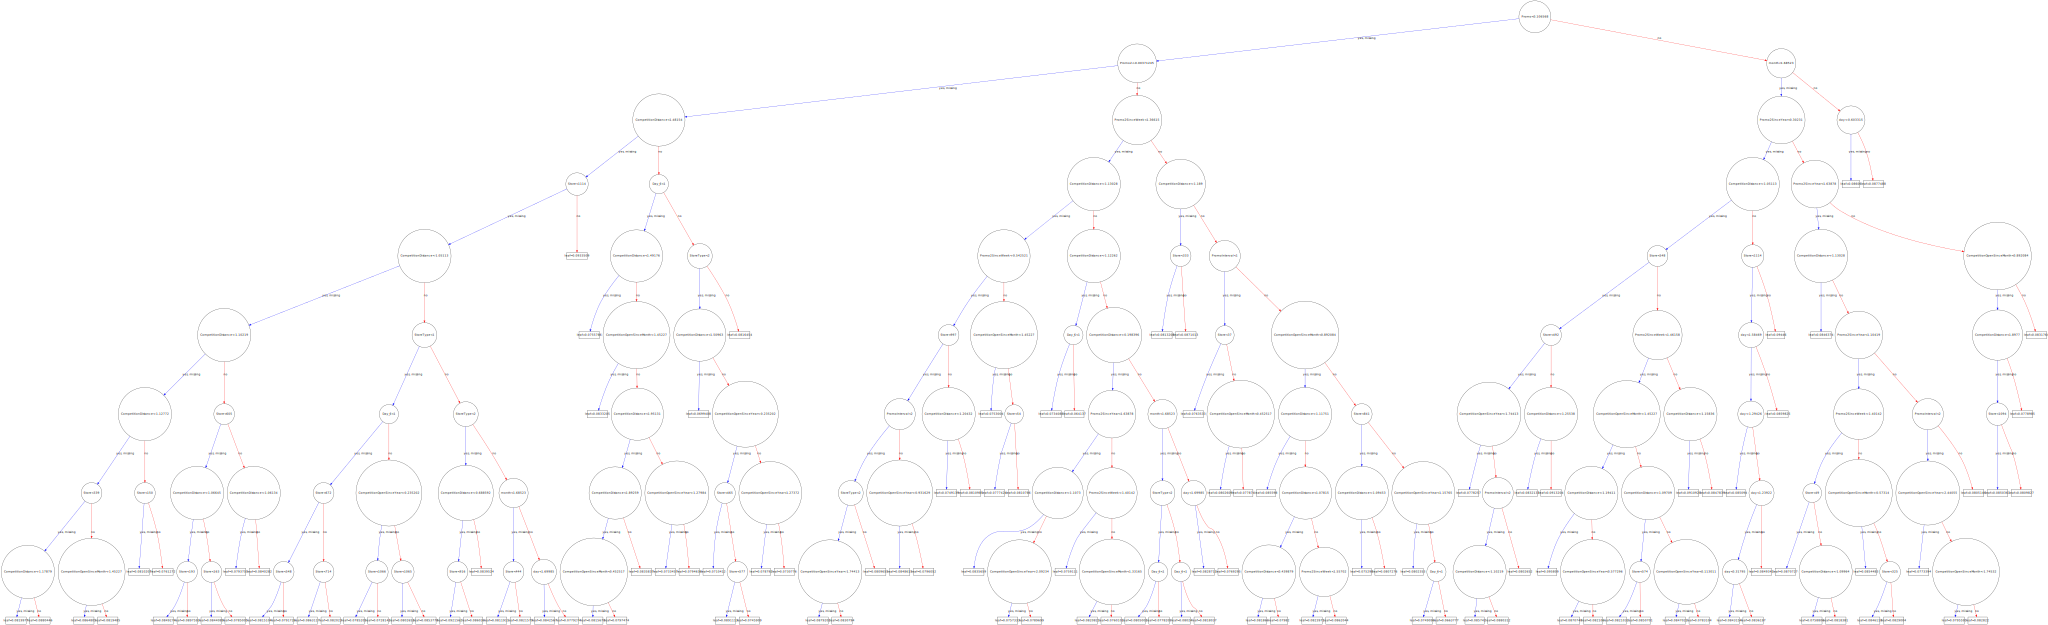

In [36]:
xgb.to_graphviz(gbm)

In [39]:
gbm1

,test-rmspe-mean,test-rmspe-std,train-rmspe-mean,train-rmspe-std
0,0.999832,0.000002,0.999832,8.164966e-07
1,0.999806,0.000002,0.999806,8.164966e-07
2,0.999778,0.000002,0.999778,8.164966e-07
3,0.999748,0.000002,0.999748,8.164966e-07
4,0.999715,0.000002,0.999715,4.714045e-07
5,0.999681,0.000002,0.999681,8.164966e-07
6,0.999644,0.000002,0.999644,8.164966e-07
7,0.999605,0.000002,0.999605,8.164966e-07
8,0.999563,0.000002,0.999563,9.428090e-07
9,0.999518,0.000002,0.999518,9.428090e-07


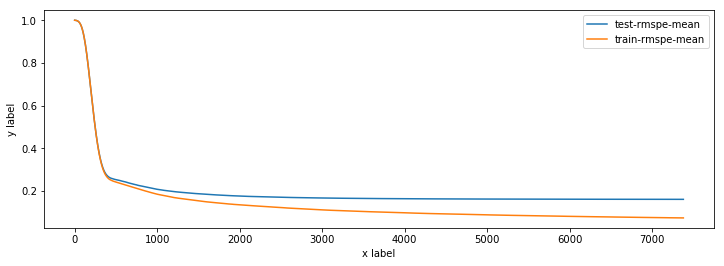

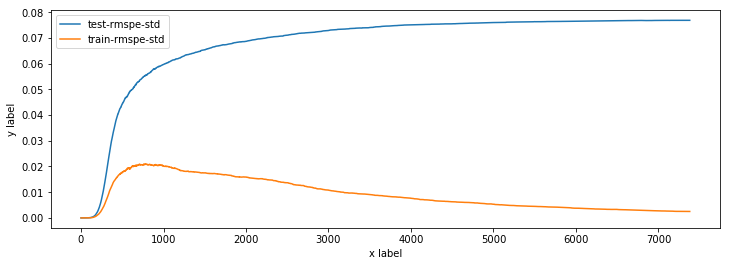

In [42]:
plt.plot(range(len(gbm1['test-rmspe-mean'])),gbm1['test-rmspe-mean'],label = 'test-rmspe-mean')
plt.plot(range(len(gbm1['train-rmspe-mean'])),gbm1['train-rmspe-mean'],label = 'train-rmspe-mean')
plt.xlabel('x label')
plt.ylabel('y label')
plt.legend()
plt.show()
plt.plot(range(len(gbm1['test-rmspe-std'])),gbm1['test-rmspe-std'],label = 'test-rmspe-std')
plt.plot(range(len(gbm1['train-rmspe-std'])),gbm1['train-rmspe-std'],label = 'train-rmspe-std')
plt.xlabel('x label')
plt.ylabel('y label')
plt.legend()
plt.show()